In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as scs
from statsmodels import stats as sms
from tqdm import tqdm
import seaborn

Загружу данные и метки в одну таблицу.

In [2]:
churn_features = pd.read_csv('orange_small_churn_data.txt')
churn_labels = pd.read_csv('orange_small_churn_labels.txt',names=['label'])
churn_labels['label'] = churn_labels['label'].apply(lambda x: 0 if x == -1 else 1)
churn_data = pd.concat([churn_features, churn_labels],axis=1)

Удалю столбцы, состоящие из nan значений и столбцы принимающие константные значения.

In [3]:
churn_data.drop(churn_data.columns[churn_data.isnull().all()], 'columns', inplace=True)
churn_data.drop(churn_data.columns[churn_data.nunique() == 1], 'columns', inplace=True)

Посчитаю корреляцию Пирсона между числовыми признаками.

In [4]:
means = churn_data.iloc[:,:165].mean(axis=0)

In [5]:
churn_data_imputed_value = churn_data.iloc[:,:165].fillna(means)

In [7]:
corr_num_feat = churn_data_imputed_value.corr()

Найду линейно зависимые числовые признаки.

In [8]:
dep_cols = np.array([])
for col in corr_num_feat.columns:
    if len(dep_cols) != 0 and col in dep_cols:
        continue
    dep_cols = np.append(dep_cols, corr_num_feat[(corr_num_feat[col] > 0.99) & (corr_num_feat.index != col)].index)
dep_cols

array(['Var66', 'Var156', 'Var22', 'Var91', 'Var148', 'Var128', 'Var105'],
      dtype=object)

In [9]:
churn_data.drop(dep_cols, 'columns', inplace=True)

Построю таблицу с нормированными данными и вычислю корреляцию с целевой меткой. Корреляцию буду вычислять по формуле: E(x|churn_labels=-1) - E(x|churn_labels=1).

In [12]:
scale_churn_data = (churn_data.iloc[:,:165] - churn_data.iloc[:,:165].mean())/churn_data.iloc[:,:165].std()
scale_churn_data['label'] = churn_data['label']

corr_with_churn = {}
for col in scale_churn_data.columns[:-1]:
    corr = scale_churn_data[scale_churn_data.label == 1][col].mean() \
            - scale_churn_data[scale_churn_data.label == 0][col].mean()
    corr_with_churn[corr] = col

Посмотрю на распределение значений корреляции.

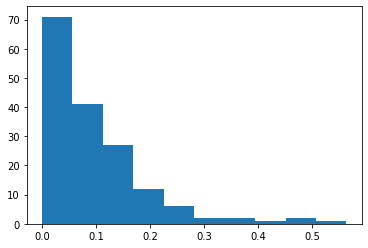

In [13]:
plt.hist(list(map(abs, corr_with_churn.keys())))
plt.show()

Посмотрю на различные статистики числовых признаков.

In [14]:
def bootstrap_samples(data, n_samples):
    """Return bootstrap samples.
        keyword arguments:
            data: 1-d array.
            Data for generic bootstrap samples.
            
            n_samples: int
            Number of samples.
        Return:
            bootstrap samples: 2-d array of shape (n_samples, len(data))
    """
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    return data[indices]

def stat_intervals(stat, alpha=0.05):
    """Return confidence interval of statistic.
        Keyword arguments:
            stat: 1-d array
            Sample of statistic values.
            
            alpha: float
            Significance level for the confidence interval.
        Return:
            conf_interval -- array [low boundary, high boudary]
            Confidence interval of statistics data.
    """
    boundaries = np.percentile(stat, [100 * alpha / 2, 100 * (1-alpha/2)])
    return boundaries

def get_stat_num_features(data, feature, target):
    """Print different statistic information of numerical feature for classification problem.
       keyword arguments:
           data: Pandas.DataFrame
           Data for analysys.
           
           feature: string
           Name of column numerical feature in data.
           
           target: string
           Name of column target label in data. Labels must take the values 0 or 1.
    """
    print("Name of feature: %s" % feature)
    
    data_target_1 = data[(data[target] == 1) & (data[feature].notna())][feature].values
    data_target_0 = data[(data[target] == 0) & (data[feature].notna())][feature].values    
    print('Count notna elements 0: %d, 1: %d'% (len(data_target_1), len(data_target_0)))
    
    print('median: ', data[feature].groupby(data[target]).median())
    print('mean: ', data[feature].groupby(data[target]).mean())
    print('std: ',data[feature].groupby(data[target]).std())
    
    median_target_1 = np.array(list(map(np.median, bootstrap_samples(data_target_1,1000))))
    median_target_0 = np.array(list(map(np.median, bootstrap_samples(data_target_0,1000))))
    
    print('interval of delta medians: ',stat_intervals(median_target_1 - median_target_0))
    
    mean_target_1 = np.array(list(map(np.mean,bootstrap_samples(data_target_1,1000))))
    mean_target_0 = np.array(list(map(np.mean,bootstrap_samples(data_target_0,1000))))
    print('interval of delta means: ', stat_intervals(mean_target_1-mean_target_0))
    
    data[feature].hist(by=data[target],figsize=(15,5))
    medianprops = dict(linestyle='-',linewidth=2)
    data.boxplot(column=feature,by=target, vert=False, figsize=(15,5), showmeans=True,showfliers=False,
                       medianprops=medianprops)
    plt.show()
    
def get_stat_cat_features(data, feature, target):
    """Print different statistic information of cateforial feature for classification problem.
       keyword arguments:
           data: Pandas.DataFrame
           Data for analysys.
           
           feature: string
           Name of column categorial feature in data.
           
           target: string
           Name of column target label in data. Labels must take the values 0 or 1.
    """
    print("Name of feature: %s" % feature)
    
    data_target_1 = data[(data[target] == 1) & (data[feature].notna())][feature].values
    data_target_0 = data[(data[target] == 0) & (data[feature].notna())][feature].values    
    print('Count notna elements 0: %d, 1: %d'% (len(data_target_1), len(data_target_0)))
    
    data[feature].hist(by=data[target],figsize=(15,5),bins=20)
    plt.show()

Correlation with label =  -0.0004308364870692719
Name of feature: Var123
Count notna elements 0: 2789, 1: 33195
median:  label
0    30.0
1    30.0
Name: Var123, dtype: float64
mean:  label
0    59.779485
1    59.685909
Name: Var123, dtype: float64
std:  label
0    221.940262
1    149.619216
Name: Var123, dtype: float64
interval of delta medians:  [0. 6.]
interval of delta means:  [-5.8687874   6.23238329]


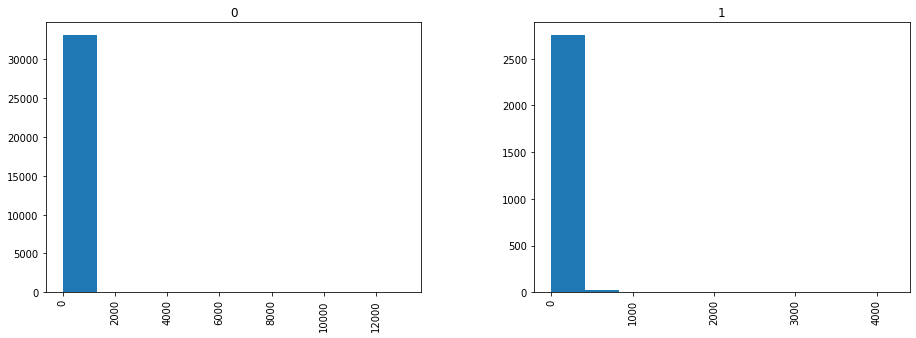

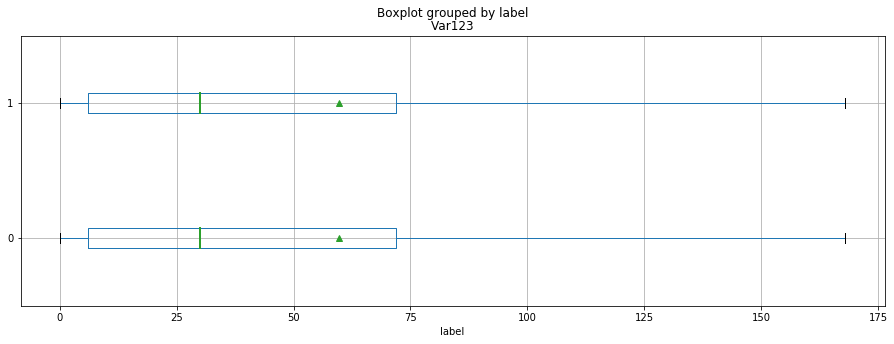

Correlation with label =  0.0013950671674890479
Name of feature: Var129
Count notna elements 0: 35, 1: 535
median:  label
0    2.0
1    6.0
Name: Var129, dtype: float64
mean:  label
0    10.519626
1    10.571429
Name: Var129, dtype: float64
std:  label
0    38.202779
1    12.372374
Name: Var129, dtype: float64
interval of delta medians:  [-2. 10.]
interval of delta means:  [-5.07313752  5.32168224]


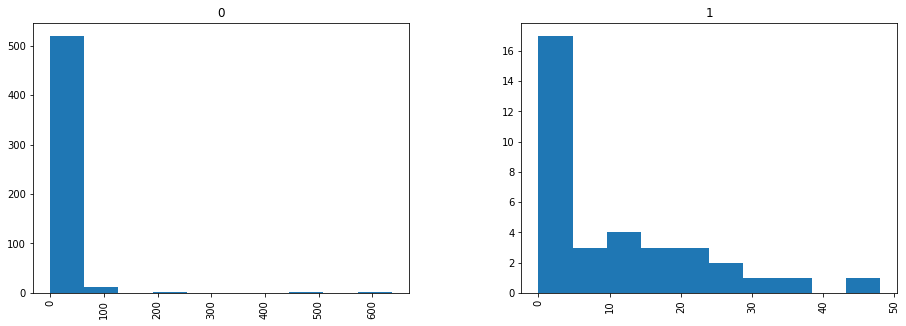

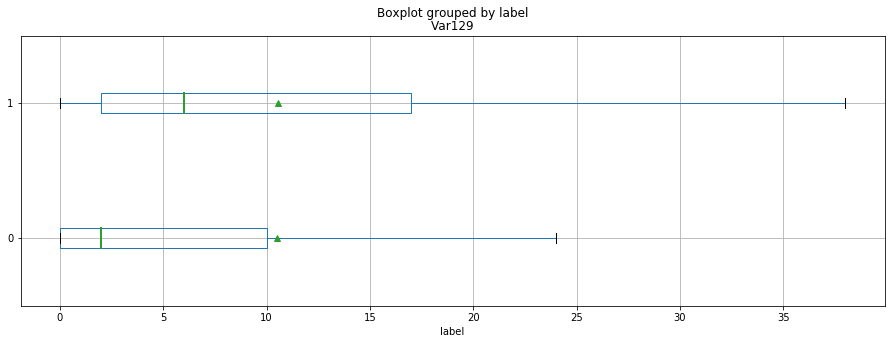

Correlation with label =  -0.0019591390303645025
Name of feature: Var44
Count notna elements 0: 2789, 1: 33195
median:  label
0    0.0
1    0.0
Name: Var44, dtype: float64
mean:  label
0    0.167826
1    0.164575
Name: Var44, dtype: float64
std:  label
0    1.673328
1    1.486604
Name: Var44, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.05694135  0.05454375]


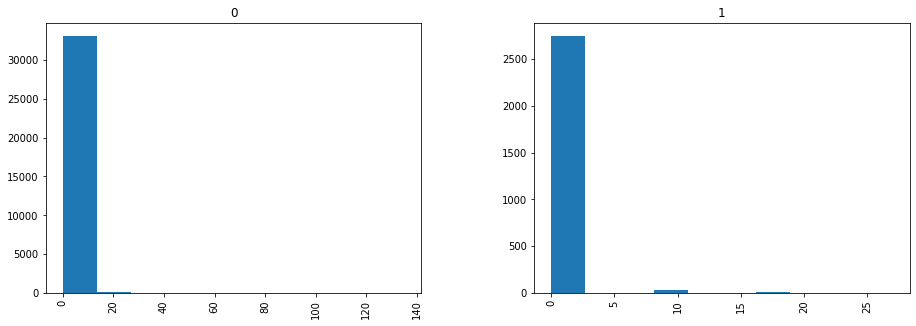

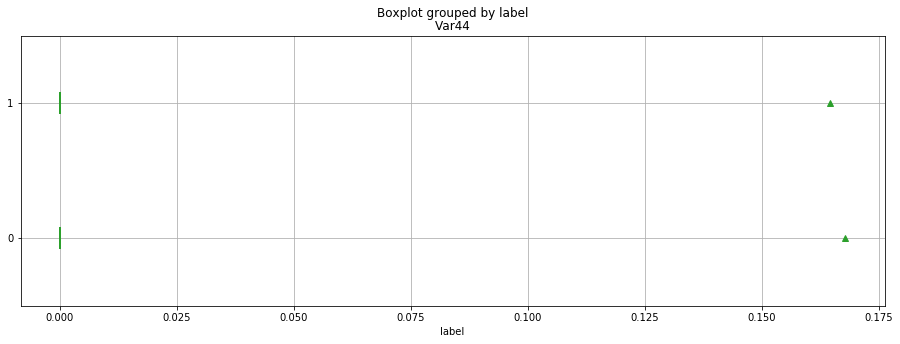

Correlation with label =  0.0030925960876868144
Name of feature: Var104
Count notna elements 0: 37, 1: 625
median:  label
0    45.0
1    54.0
Name: Var104, dtype: float64
mean:  label
0    87.840000
1    88.297297
Name: Var104, dtype: float64
std:  label
0    149.691028
1    114.331843
Name: Var104, dtype: float64
interval of delta medians:  [-36.  36.]
interval of delta means:  [-35.15650054  39.63550378]


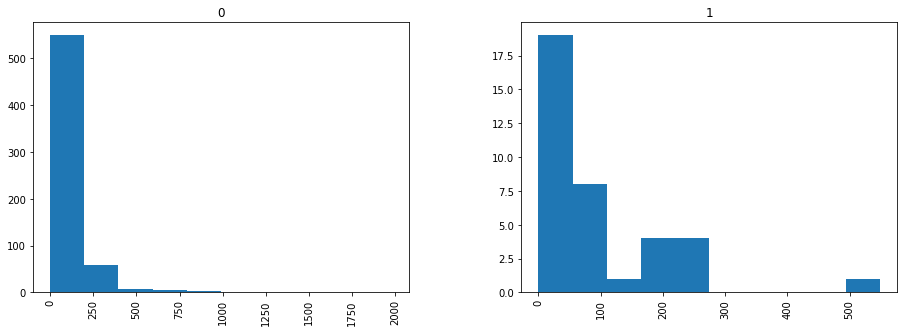

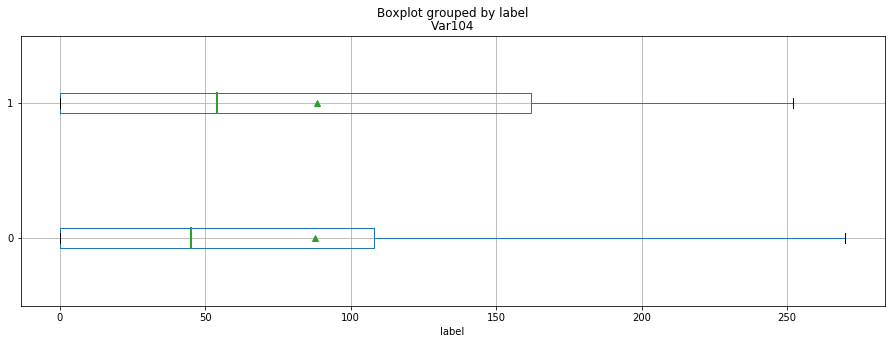

Correlation with label =  0.0050671568098540525
Name of feature: Var133
Count notna elements 0: 2789, 1: 33195
median:  label
0    1487300.0
1    1580650.0
Name: Var133, dtype: float64
mean:  label
0    2.284514e+06
1    2.296904e+06
Name: Var133, dtype: float64
std:  label
0    2.448823e+06
1    2.400608e+06
Name: Var133, dtype: float64
interval of delta medians:  [-31720.375 207069.25 ]
interval of delta means:  [-82497.82515848 101326.46870652]


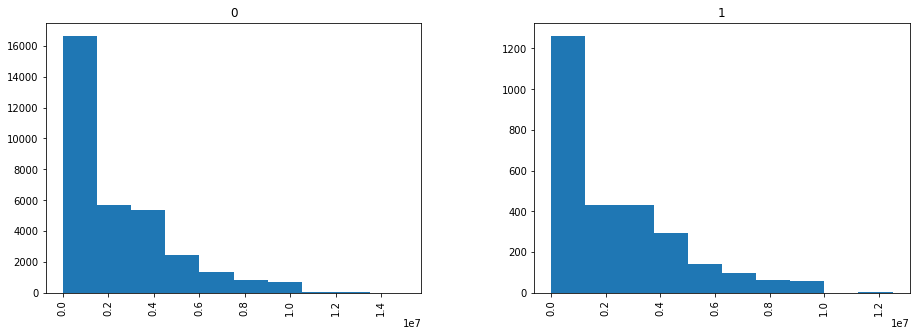

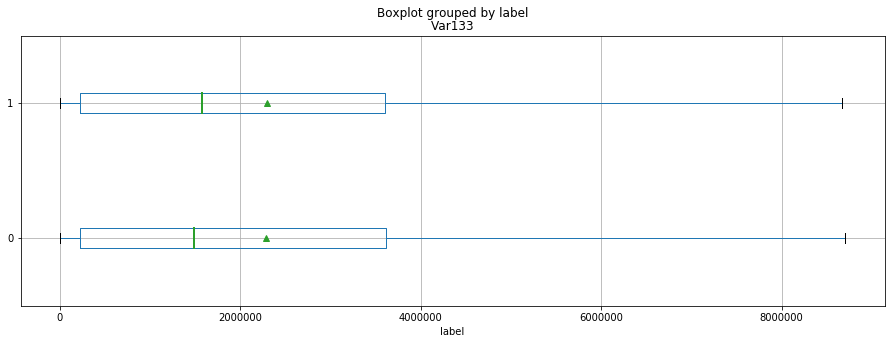

Correlation with label =  -0.006170115347728344
Name of feature: Var146
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var146, dtype: float64
mean:  label
0    2.907124
1    2.857143
Name: Var146, dtype: float64
std:  label
0    8.194578
1    5.992203
Name: Var146, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.56138735  1.68185624]


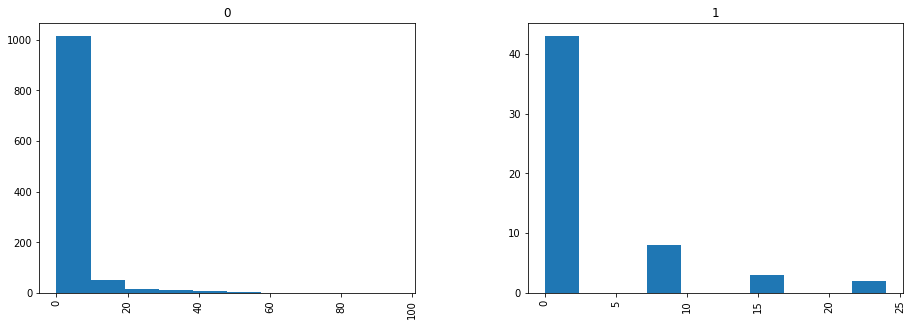

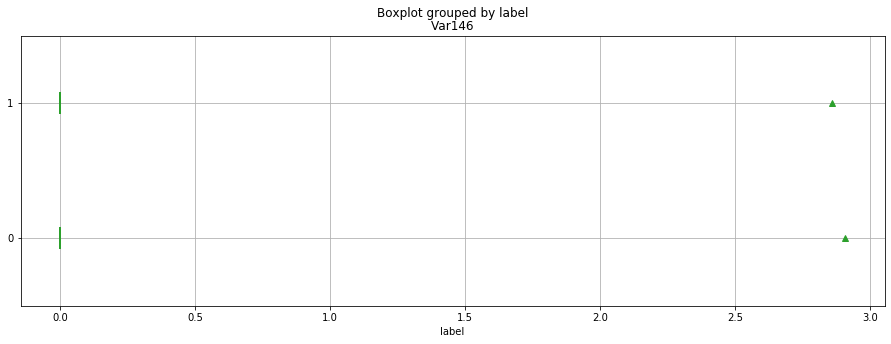

Correlation with label =  0.008413164130305083
Name of feature: Var181
Count notna elements 0: 2789, 1: 33195
median:  label
0    0.0
1    0.0
Name: Var181, dtype: float64
mean:  label
0    0.609007
1    0.629975
Name: Var181, dtype: float64
std:  label
0    2.489590
1    2.523785
Name: Var181, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.07582974  0.11935407]


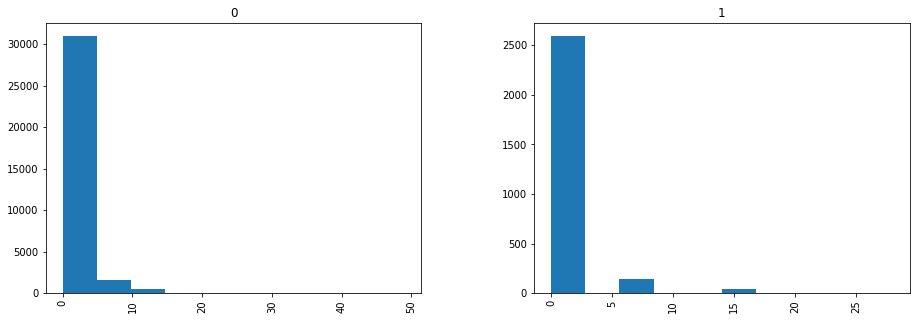

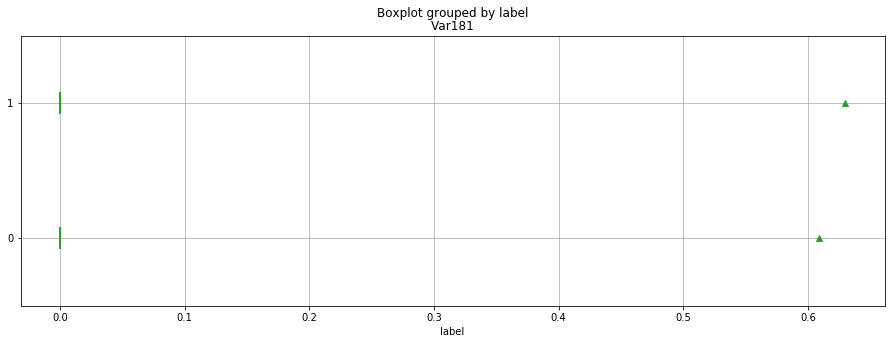

Correlation with label =  0.009500042905374241
Name of feature: Var16
Count notna elements 0: 56, 1: 1109
median:  label
0    129.64
1    144.88
Name: Var16, dtype: float64
mean:  label
0    119.647937
1    120.345714
Name: Var16, dtype: float64
std:  label
0    73.218641
1    78.586800
Name: Var16, dtype: float64
interval of delta medians:  [-34.729  43.681]
interval of delta means:  [-21.0908089   21.74170625]


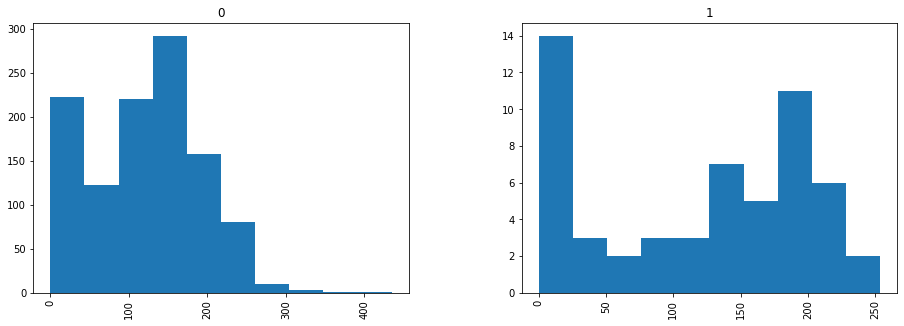

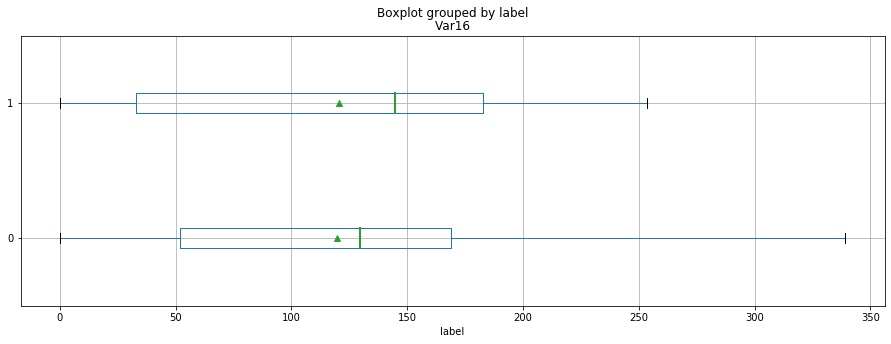

Correlation with label =  0.011364475429687241
Name of feature: Var83
Count notna elements 0: 2789, 1: 33195
median:  label
0    10.0
1    10.0
Name: Var83, dtype: float64
mean:  label
0    19.769694
1    20.745787
Name: Var83, dtype: float64
std:  label
0    86.425569
1    79.244547
Name: Var83, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.68340035  4.22353199]


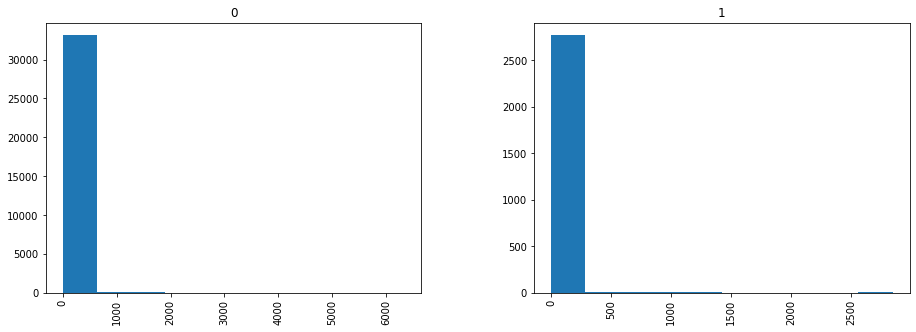

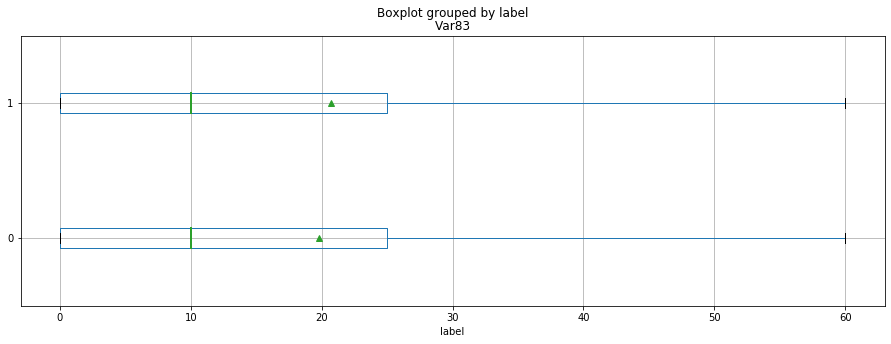

Correlation with label =  0.011529196200851638
Name of feature: Var4
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var4, dtype: float64
mean:  label
0    0.147541
1    0.163636
Name: Var4, dtype: float64
std:  label
0    1.404155
1    1.213560
Name: Var4, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.19918033  0.38043778]


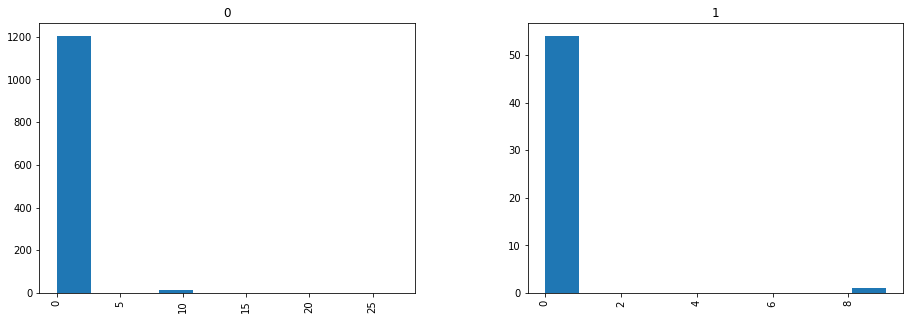

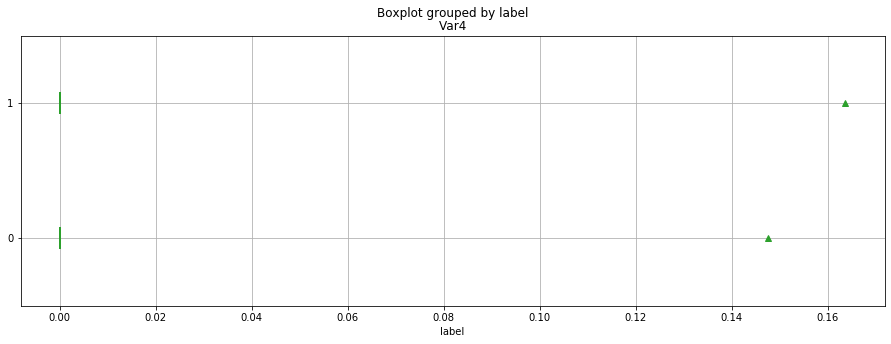

Correlation with label =  -0.012289531633890322
Name of feature: Var121
Count notna elements 0: 35, 1: 535
median:  label
0    2.0
1    0.0
Name: Var121, dtype: float64
mean:  label
0    7.013084
1    6.628571
Name: Var121, dtype: float64
std:  label
0    32.113064
1    13.631895
Name: Var121, dtype: float64
interval of delta medians:  [-2.  2.]
interval of delta means:  [-5.41465955  5.19389853]


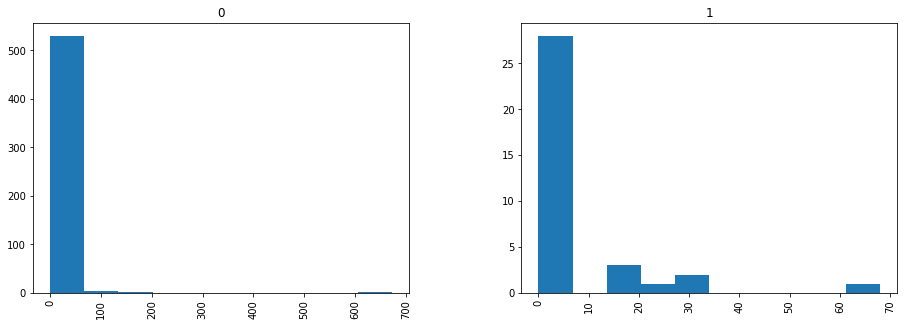

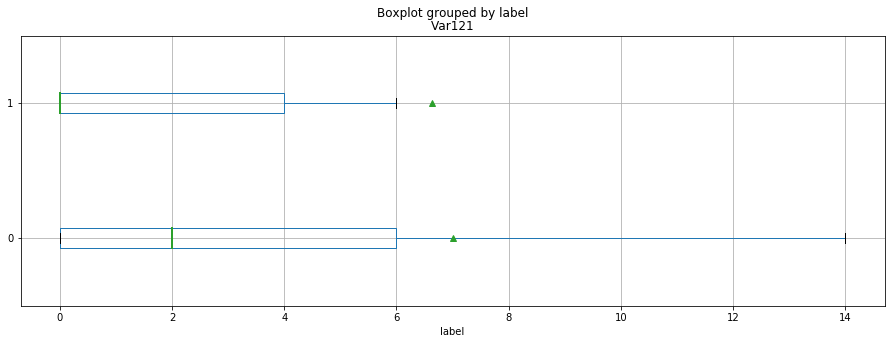

Correlation with label =  0.012426111793675887
Name of feature: Var163
Count notna elements 0: 2789, 1: 33195
median:  label
0    134508.0
1    145740.0
Name: Var163, dtype: float64
mean:  label
0    485132.458744
1    495607.744711
Name: Var163, dtype: float64
std:  label
0    844006.045679
1    831098.532259
Name: Var163, dtype: float64
interval of delta medians:  [-14268.3  33852. ]
interval of delta means:  [-20049.34395665  43298.80331085]


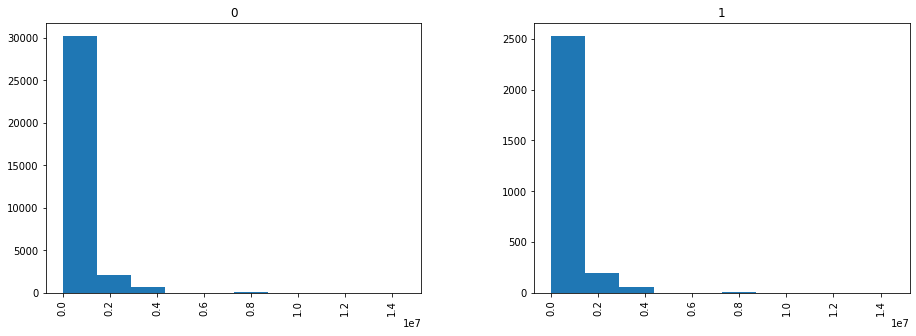

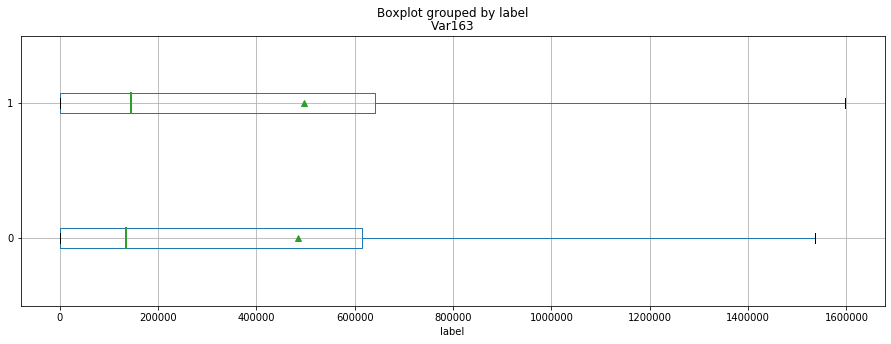

Correlation with label =  -0.013142910606293294
Name of feature: Var57
Count notna elements 0: 2976, 1: 37024
median:  label
0    3.498931
1    3.577014
Name: Var57, dtype: float64
mean:  label
0    3.507949
1    3.481283
Name: Var57, dtype: float64
std:  label
0    2.028786
1    2.029935
Name: Var57, dtype: float64
interval of delta medians:  [-0.05887904  0.20296088]
interval of delta means:  [-0.10443063  0.05002034]


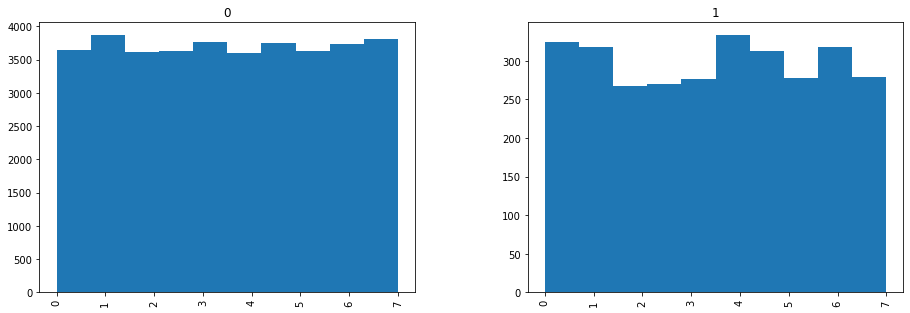

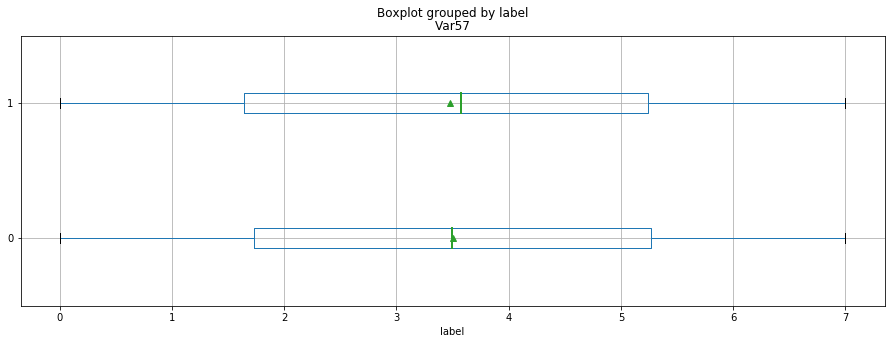

Correlation with label =  0.013598900684752772
Name of feature: Var58
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var58, dtype: float64
mean:  label
0    171947.783178
1    181122.057143
Name: Var58, dtype: float64
std:  label
0    691739.399990
1    318341.068973
Name: Var58, dtype: float64
interval of delta medians:  [     0. 127368.]
interval of delta means:  [-103967.61036048  140098.53201602]


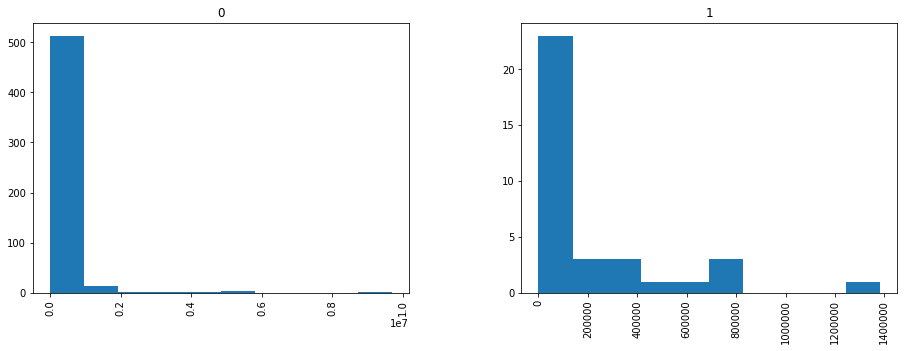

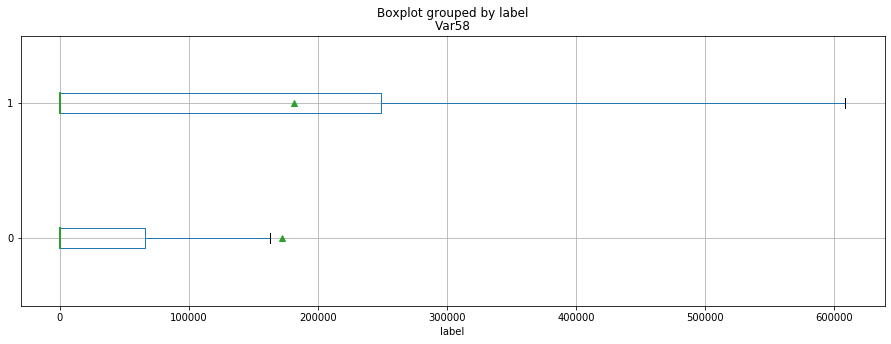

Correlation with label =  0.017859245533298686
Name of feature: Var78
Count notna elements 0: 2789, 1: 33195
median:  label
0    0.0
1    0.0
Name: Var78, dtype: float64
mean:  label
0    0.527067
1    0.564719
Name: Var78, dtype: float64
std:  label
0    2.101827
1    2.182949
Name: Var78, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.04024928  0.11993173]


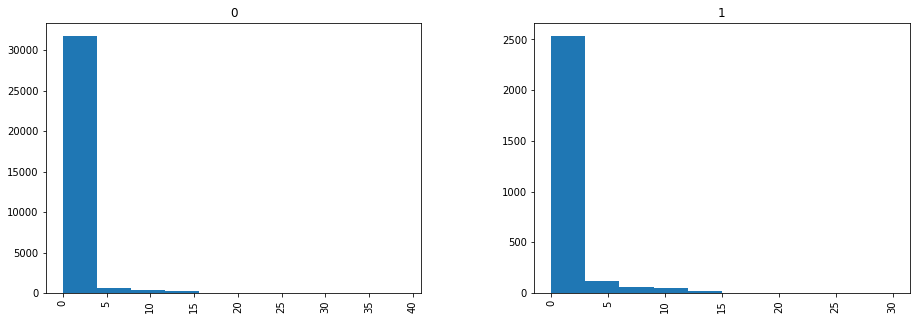

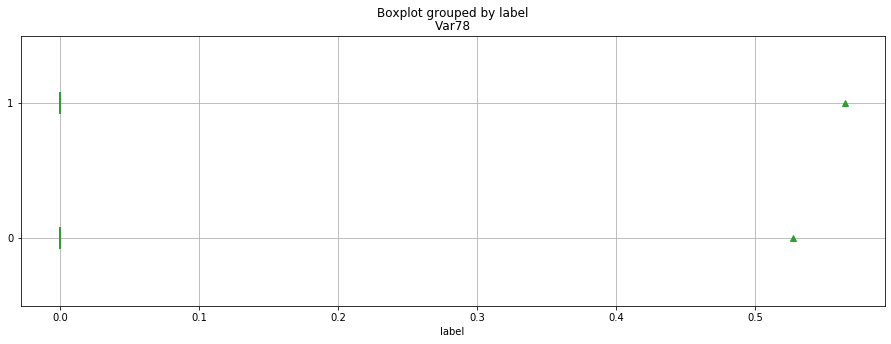

Correlation with label =  0.01874581590047545
Name of feature: Var64
Count notna elements 0: 10, 1: 180
median:  label
0    15845.715
1    19261.800
Name: Var64, dtype: float64
mean:  label
0    27181.358017
1    27811.503000
Name: Var64, dtype: float64
std:  label
0    34106.900578
1    24349.226406
Name: Var64, dtype: float64
interval of delta medians:  [-11335.82175  39056.13   ]
interval of delta means:  [-14449.21617236  14772.40979722]


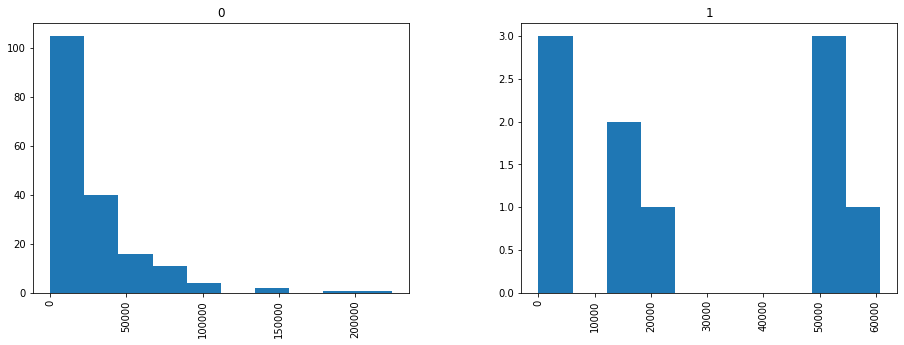

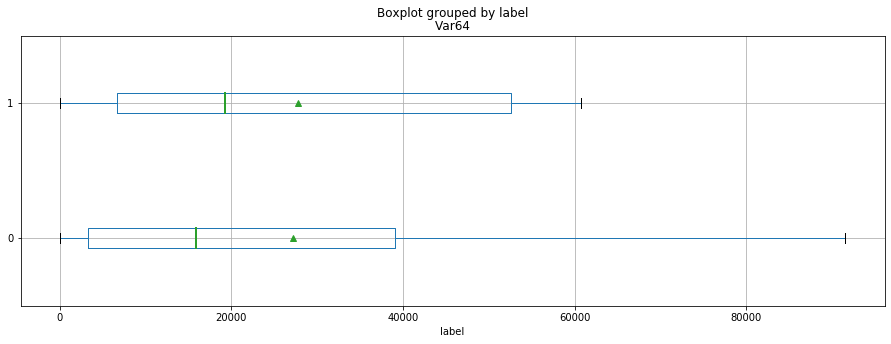

Correlation with label =  -0.020444057613122162
Name of feature: Var109
Count notna elements 0: 2575, 1: 31609
median:  label
0    32.0
1    32.0
Name: Var109, dtype: float64
mean:  label
0    61.065140
1    58.156117
Name: Var109, dtype: float64
std:  label
0    143.011497
1    133.138408
Name: Var109, dtype: float64
interval of delta medians:  [0. 8.]
interval of delta means:  [-7.73869787  2.89555371]


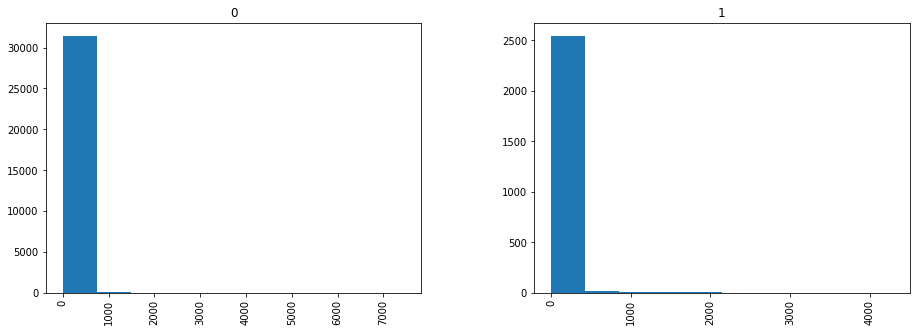

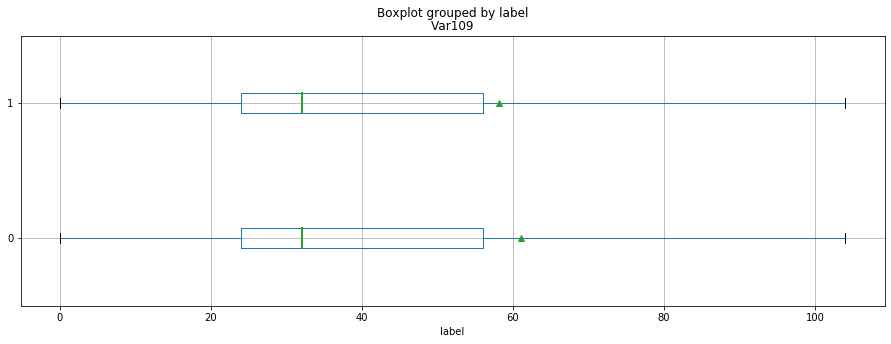

Correlation with label =  -0.021140142720580356
Name of feature: Var112
Count notna elements 0: 2789, 1: 33195
median:  label
0    40.0
1    32.0
Name: Var112, dtype: float64
mean:  label
0    66.478687
1    63.128003
Name: Var112, dtype: float64
std:  label
0    155.376484
1    191.801838
Name: Var112, dtype: float64
interval of delta medians:  [-8. -8.]
interval of delta means:  [-9.48470966  4.22632863]


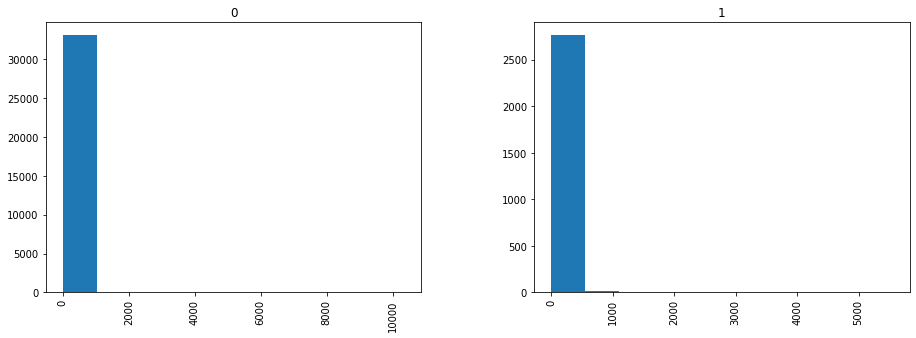

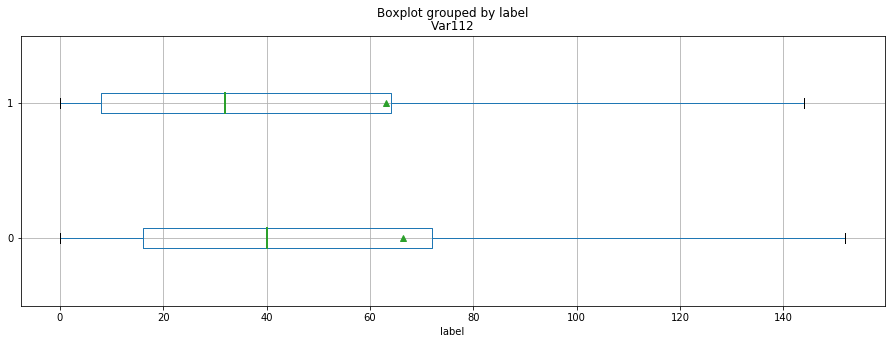

Correlation with label =  -0.021209447718553324
Name of feature: Var96
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var96, dtype: float64
mean:  label
0    4.250777
1    3.853659
Name: Var96, dtype: float64
std:  label
0    19.083984
1     5.556802
Name: Var96, dtype: float64
interval of delta medians:  [0. 4.]
interval of delta means:  [-2.460805    1.76996588]


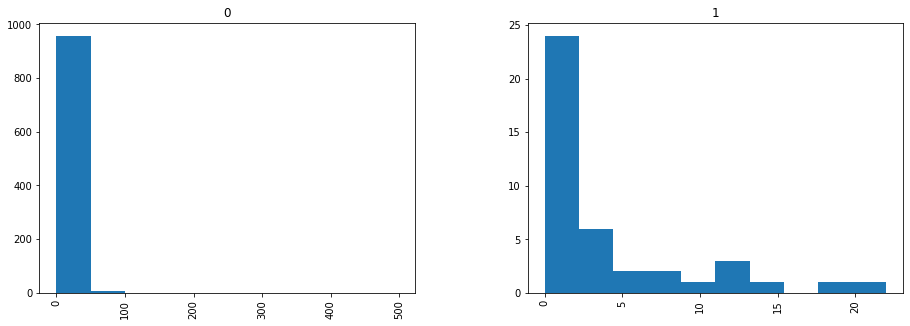

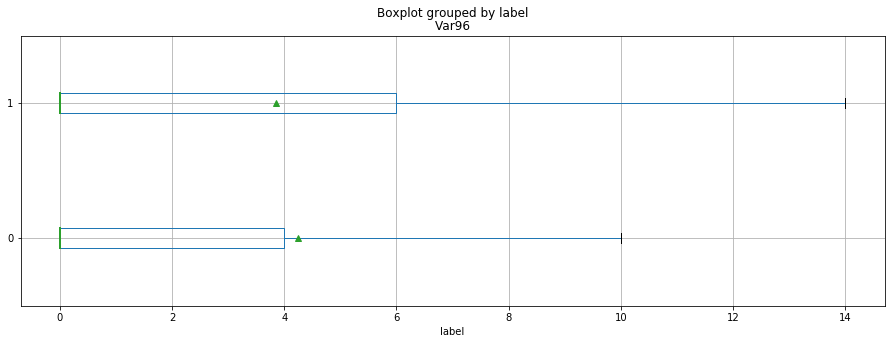

Correlation with label =  -0.02129175382209089
Name of feature: Var75
Count notna elements 0: 41, 1: 965
median:  label
0    5.0
1    5.0
Name: Var75, dtype: float64
mean:  label
0    6.523316
1    6.341463
Name: Var75, dtype: float64
std:  label
0    8.612854
1    6.710476
Name: Var75, dtype: float64
interval of delta medians:  [-5.  5.]
interval of delta means:  [-2.20049918  2.00998041]


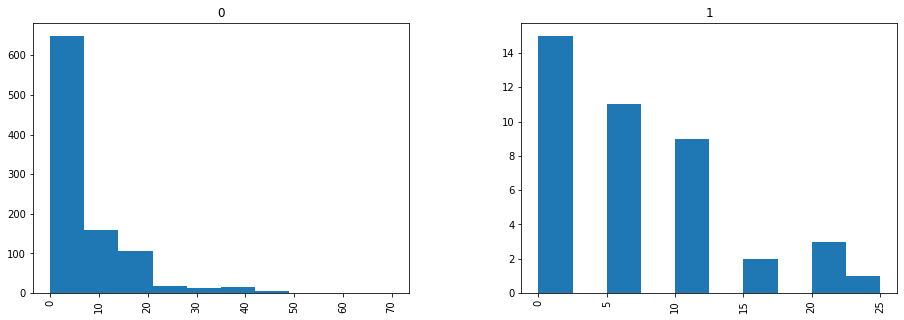

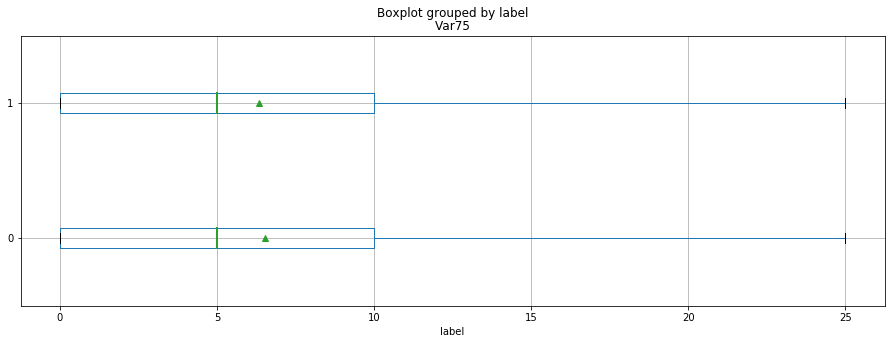

Correlation with label =  -0.02308697755497897
Name of feature: Var95
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var95, dtype: float64
mean:  label
0    105866.959585
1     97644.292683
Name: Var95, dtype: float64
std:  label
0    360471.807948
1    235569.920671
Name: Var95, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-76405.91737268  72180.29770251]


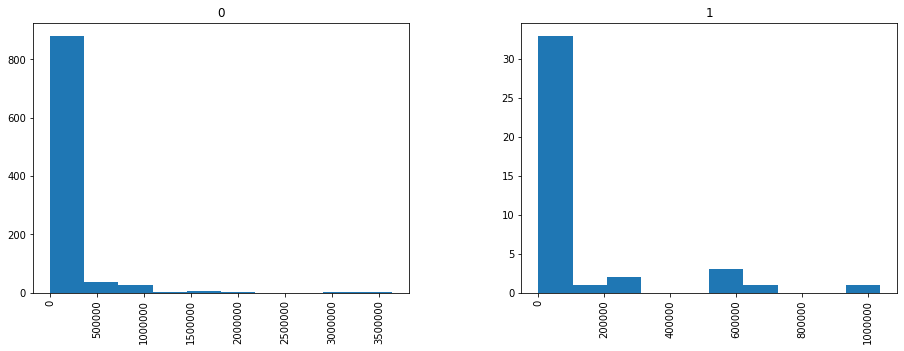

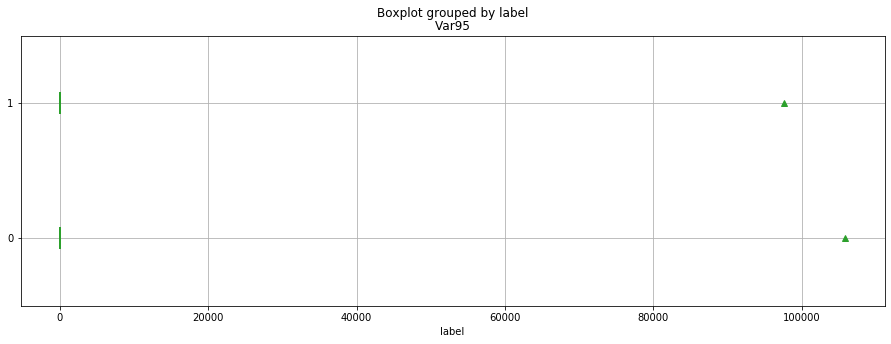

Correlation with label =  0.023185857184697865
Name of feature: Var41
Count notna elements 0: 35, 1: 535
median:  label
0     7.0
1    21.0
Name: Var41, dtype: float64
mean:  label
0    27.306542
1    28.800000
Name: Var41, dtype: float64
std:  label
0    66.062700
1    29.784323
Name: Var41, dtype: float64
interval of delta medians:  [-7. 35.]
interval of delta means:  [-9.52191589 13.1035514 ]


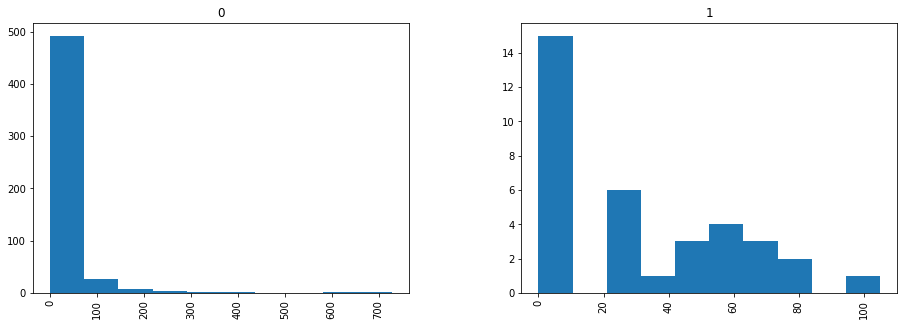

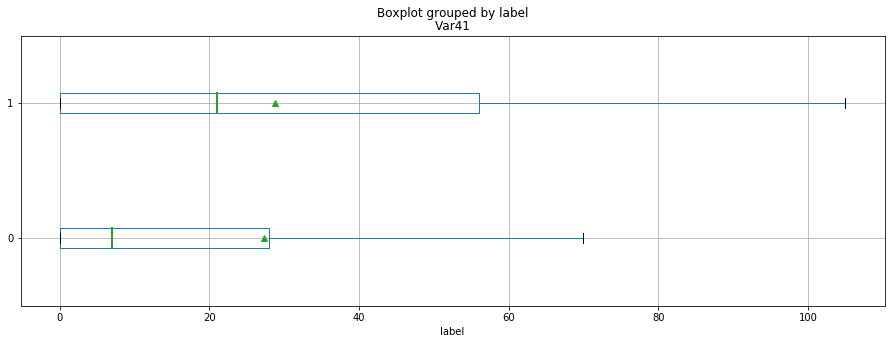

Correlation with label =  -0.024628069734299346
Name of feature: Var155
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var155, dtype: float64
mean:  label
0    0.803279
1    0.727273
Name: Var155, dtype: float64
std:  label
0    3.112966
1    2.437778
Name: Var155, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.64551043  0.68825447]


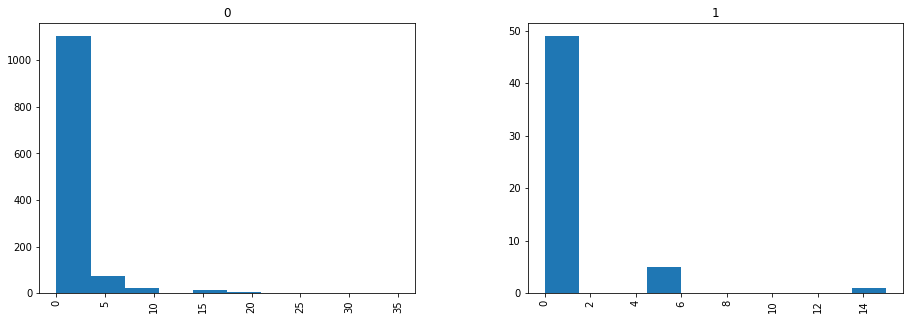

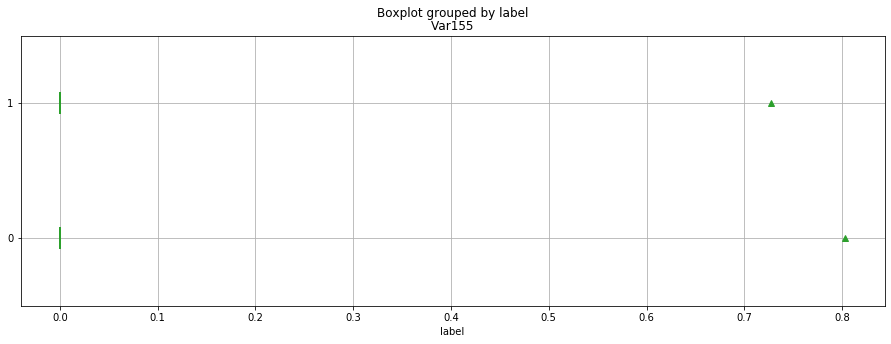

Correlation with label =  0.024664048104704885
Name of feature: Var134
Count notna elements 0: 2789, 1: 33195
median:  label
0    207020.0
1    242226.0
Name: Var134, dtype: float64
mean:  label
0    436871.634222
1    451814.354249
Name: Var134, dtype: float64
std:  label
0    606130.123094
1    602446.509104
Name: Var134, dtype: float64
interval of delta medians:  [ 2037.05 64705.8 ]
interval of delta means:  [-7386.77915387 38111.01365641]


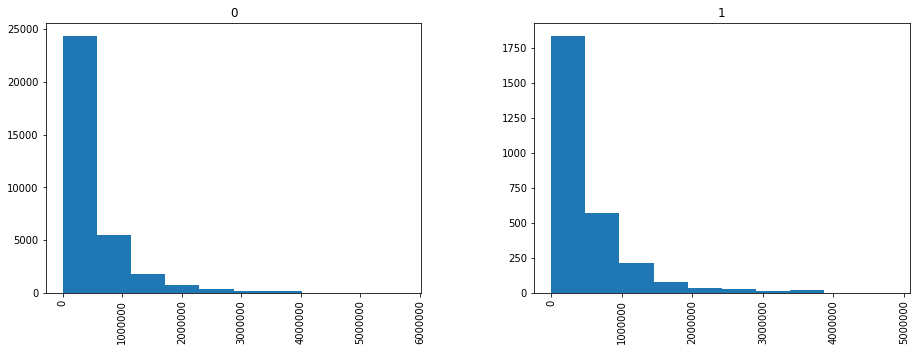

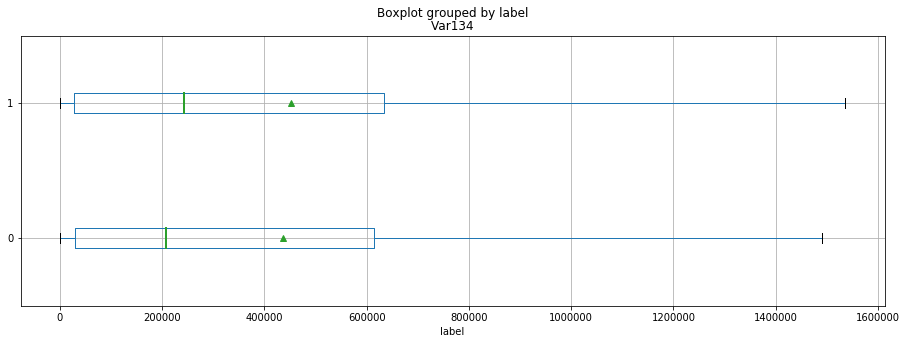

Correlation with label =  -0.025722016883882964
Name of feature: Var117
Count notna elements 0: 55, 1: 1220
median:  label
0       0.0
1    3094.0
Name: Var117, dtype: float64
mean:  label
0    129714.583607
1    122219.927273
Name: Var117, dtype: float64
std:  label
0    293902.726256
1    230149.491961
Name: Var117, dtype: float64
interval of delta medians:  [    0.   57700.25]
interval of delta means:  [-64006.47312221  57736.3092921 ]


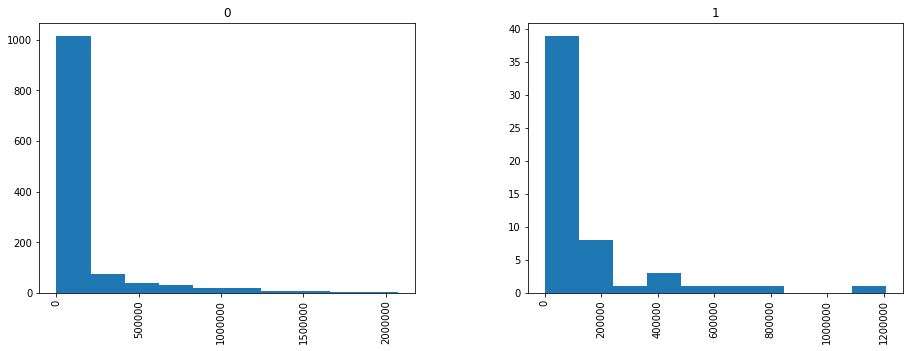

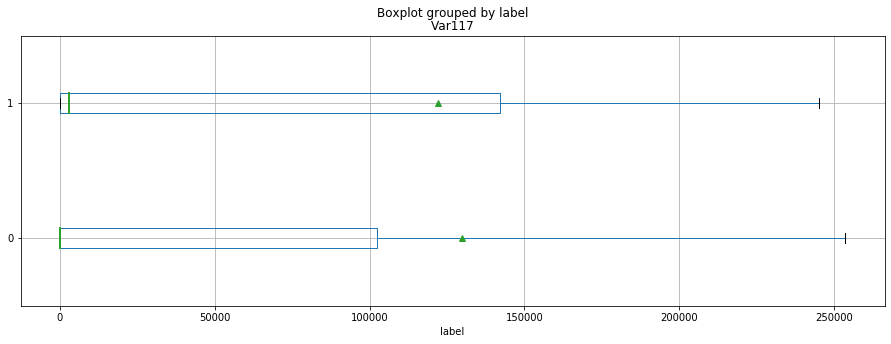

Correlation with label =  0.02582513417138002
Name of feature: Var38
Count notna elements 0: 2789, 1: 33195
median:  label
0    1245708.0
1    1568862.0
Name: Var38, dtype: float64
mean:  label
0    2.568717e+06
1    2.646388e+06
Name: Var38, dtype: float64
std:  label
0    3.010897e+06
1    2.967330e+06
Name: Var38, dtype: float64
interval of delta medians:  [112143.6 575220. ]
interval of delta means:  [-37132.51505998 185715.07262329]


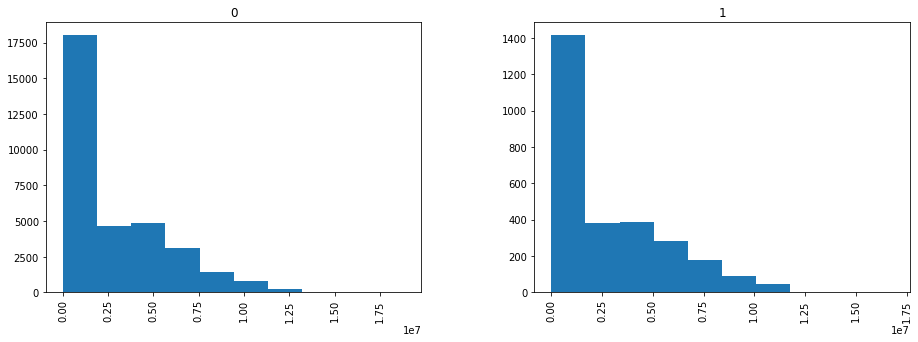

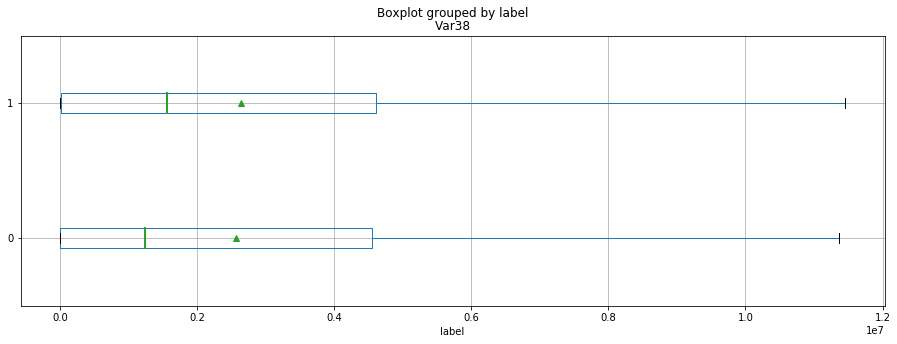

Correlation with label =  -0.027151881175556874
Name of feature: Var182
Count notna elements 0: 55, 1: 1220
median:  label
0    101583.0
1    390504.0
Name: Var182, dtype: float64
mean:  label
0    1.404086e+06
1    1.342472e+06
Name: Var182, dtype: float64
std:  label
0    2.282483e+06
1    1.970501e+06
Name: Var182, dtype: float64
interval of delta medians:  [-137558.55  732265.05]
interval of delta means:  [-550584.10385991  468251.87883756]


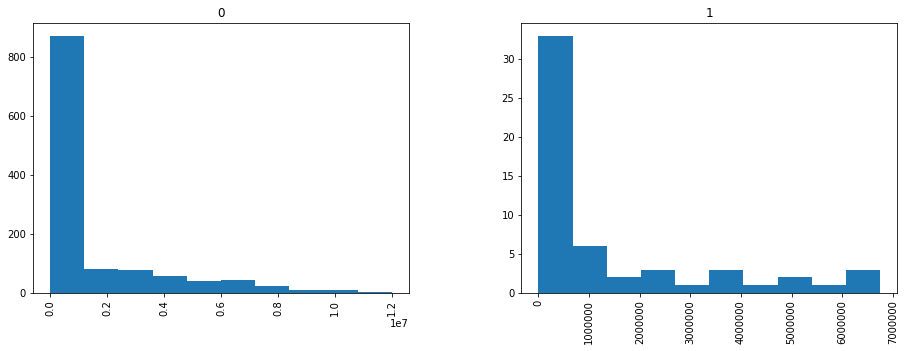

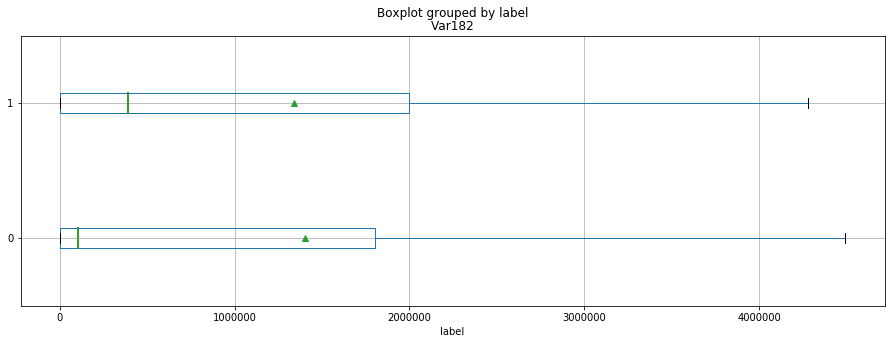

Correlation with label =  -0.02754752289491555
Name of feature: Var37
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var37, dtype: float64
mean:  label
0    641437.185246
1    603484.690909
Name: Var37, dtype: float64
std:  label
0    1.383412e+06
1    1.255560e+06
Name: Var37, dtype: float64
interval of delta medians:  [    0. 39276.]
interval of delta means:  [-358454.30173994  344636.12241617]


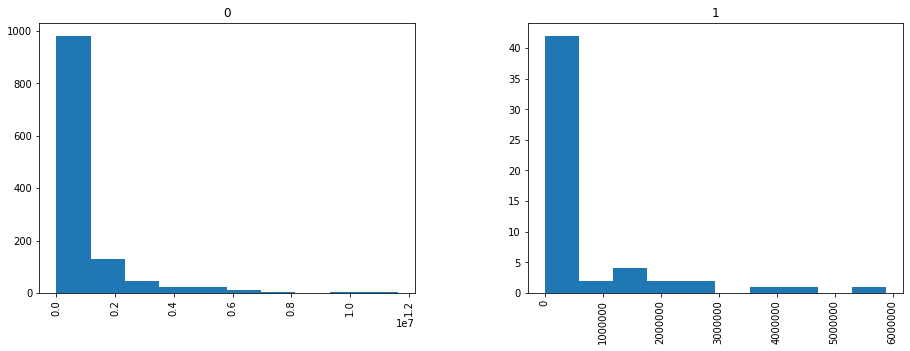

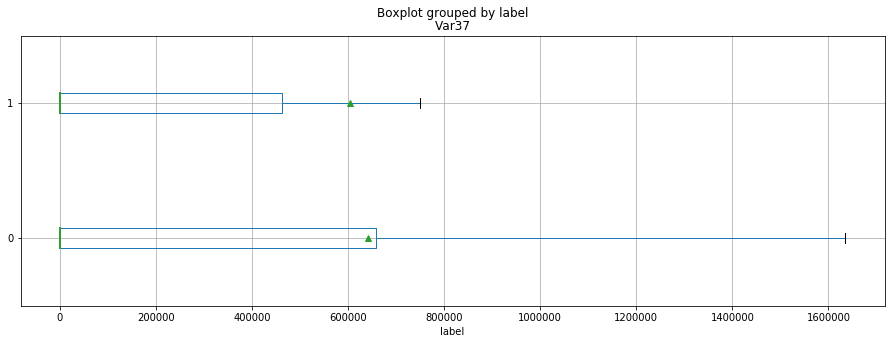

Correlation with label =  0.027577843837137614
Name of feature: Var116
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var116, dtype: float64
mean:  label
0    0.072897
1    0.085714
Name: Var116, dtype: float64
std:  label
0    0.462360
1    0.507093
Name: Var116, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.10093458  0.20667557]


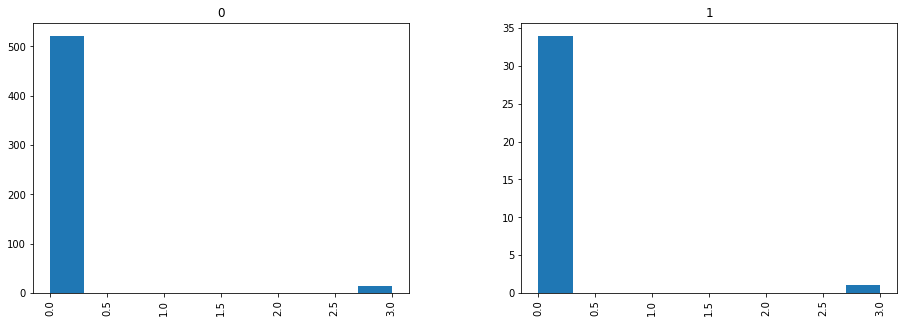

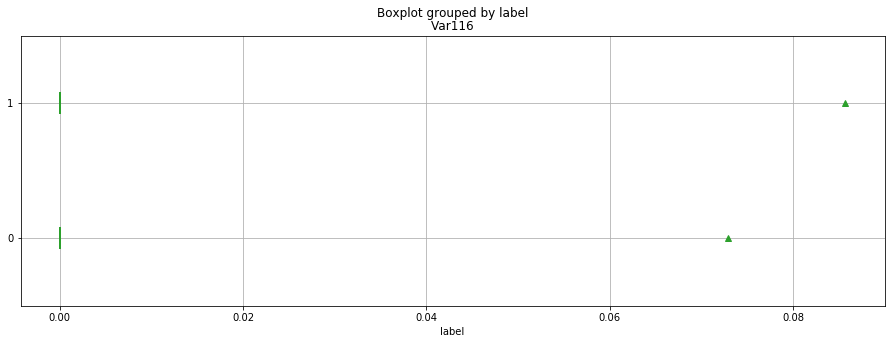

Correlation with label =  0.02763877752777213
Name of feature: Var97
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var97, dtype: float64
mean:  label
0    0.973850
1    1.071429
Name: Var97, dtype: float64
std:  label
0    3.414273
1    5.379615
Name: Var97, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.99008115  1.81623808]


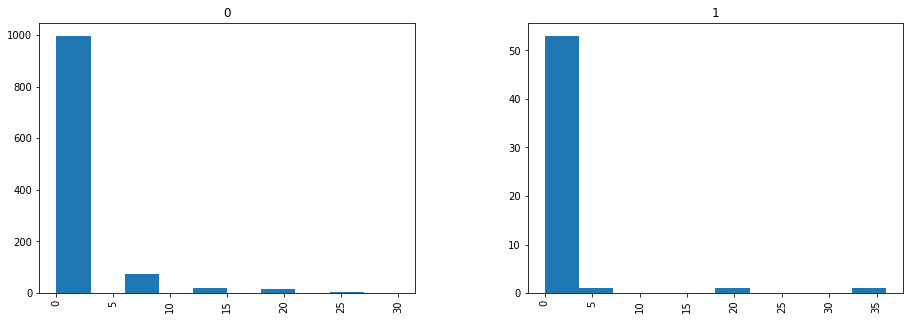

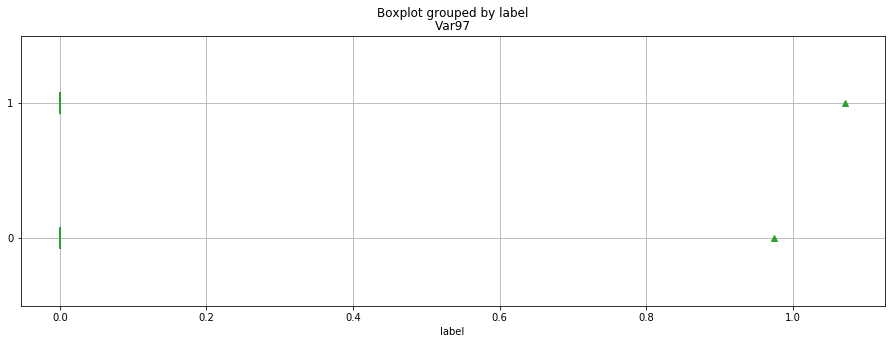

Correlation with label =  -0.029268149297307085
Name of feature: Var138
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var138, dtype: float64
mean:  label
0    0.001639
1    0.000000
Name: Var138, dtype: float64
std:  label
0    0.05726
1    0.00000
Name: Var138, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.00491803  0.        ]


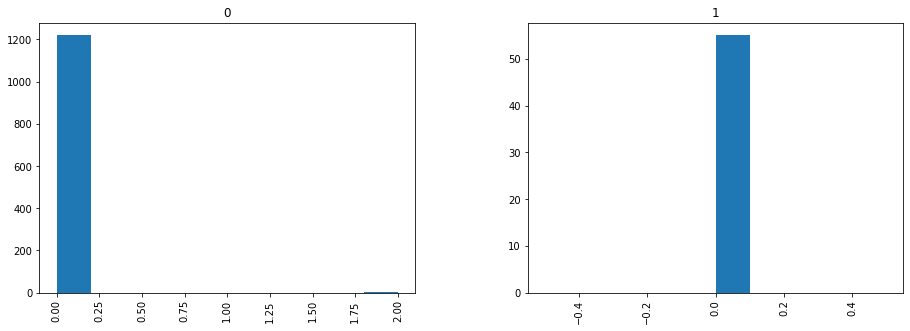

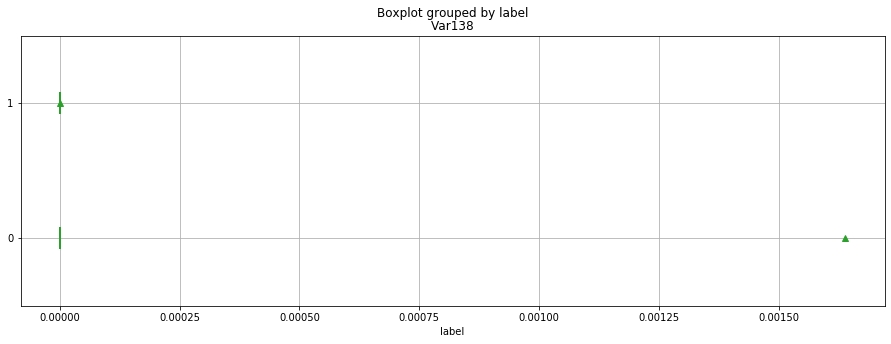

Correlation with label =  -0.029338313609221442
Name of feature: Var21
Count notna elements 0: 2759, 1: 32806
median:  label
0    144.0
1    140.0
Name: Var21, dtype: float64
mean:  label
0    235.149668
1    218.734324
Name: Var21, dtype: float64
std:  label
0    565.185632
1    486.948955
Name: Var21, dtype: float64
interval of delta medians:  [-4.  0.]
interval of delta means:  [-33.40487155   4.76044842]


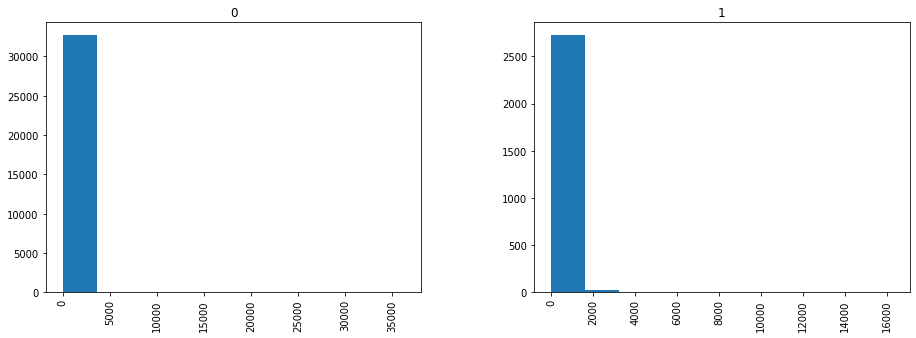

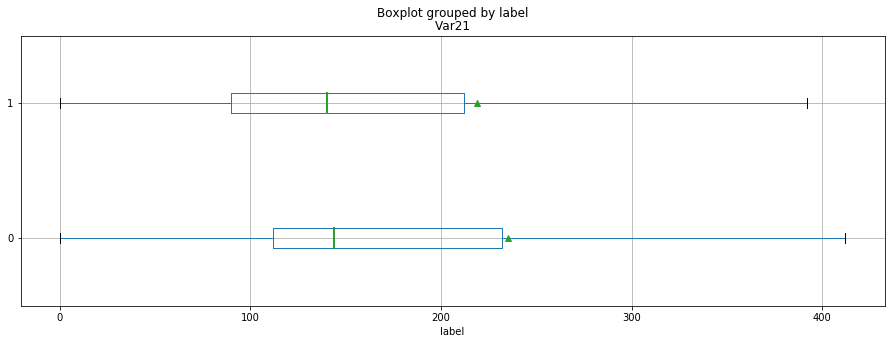

Correlation with label =  -0.029594059079388745
Name of feature: Var164
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var164, dtype: float64
mean:  label
0    1.706557
1    1.472727
Name: Var164, dtype: float64
std:  label
0    8.047284
1    3.310223
Name: Var164, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.15055142  0.71812779]


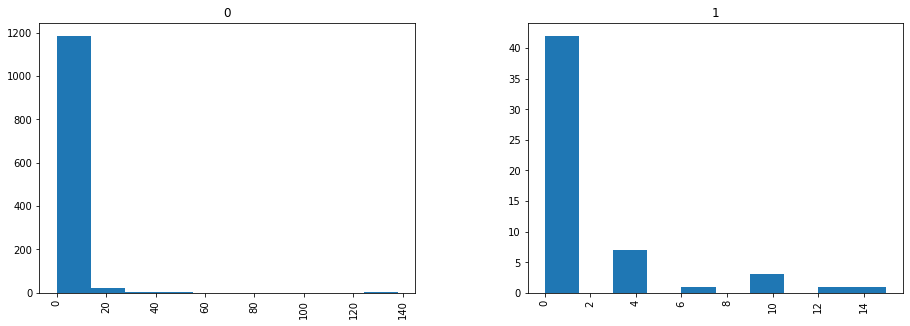

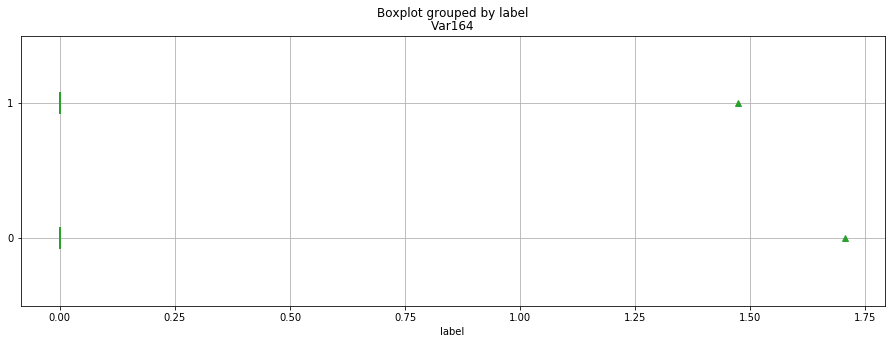

Correlation with label =  0.029695336212837643
Name of feature: Var35
Count notna elements 0: 2789, 1: 33195
median:  label
0    0.0
1    0.0
Name: Var35, dtype: float64
mean:  label
0    0.703269
1    0.790606
Name: Var35, dtype: float64
std:  label
0    2.906463
1    3.325466
Name: Var35, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.03582327  0.21977277]


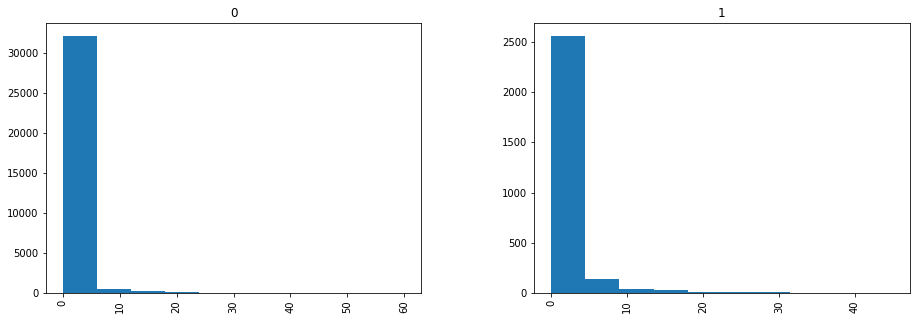

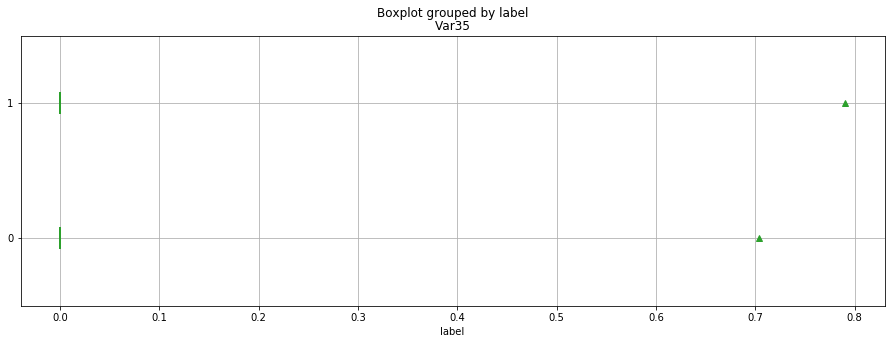

Correlation with label =  0.030836813202406634
Name of feature: Var76
Count notna elements 0: 2789, 1: 33195
median:  label
0    886408.0
1    961464.0
Name: Var76, dtype: float64
mean:  label
0    1.484571e+06
1    1.541352e+06
Name: Var76, dtype: float64
std:  label
0    1.831618e+06
1    1.952776e+06
Name: Var76, dtype: float64
interval of delta medians:  [-54302.  194323.2]
interval of delta means:  [-23263.18485051 127540.82758616]


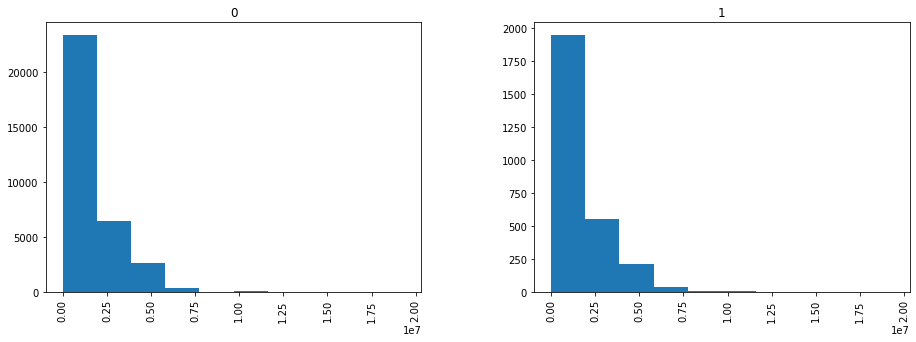

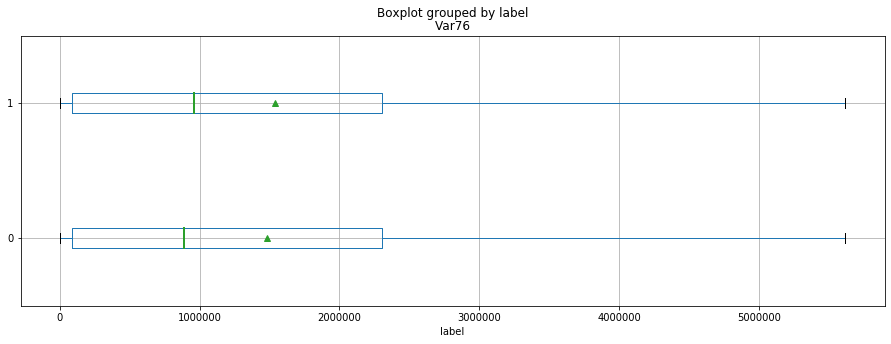

Correlation with label =  0.03105799973940723
Name of feature: Var102
Count notna elements 0: 22, 1: 345
median:  label
0    18337.68
1    23399.37
Name: Var102, dtype: float64
mean:  label
0    29777.291244
1    30860.550000
Name: Var102, dtype: float64
std:  label
0    35210.840433
1    29863.081205
Name: Var102, dtype: float64
interval of delta medians:  [-6944.706   18110.89575]
interval of delta means:  [-9889.31309753 15435.21614941]


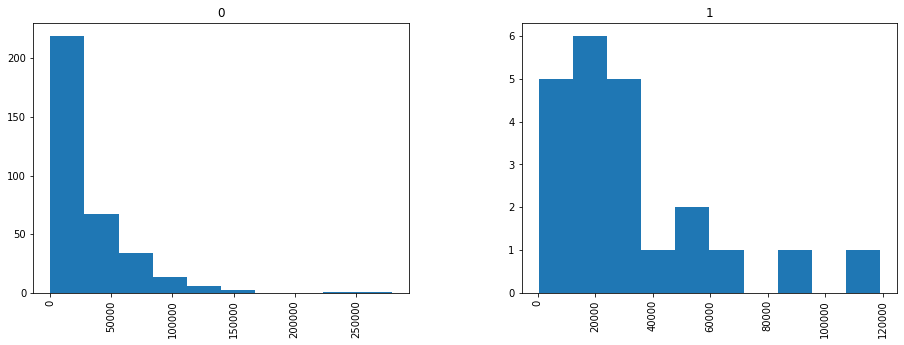

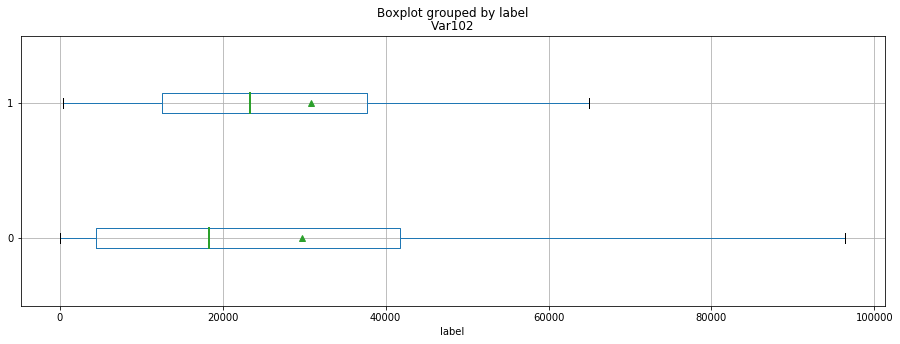

Correlation with label =  -0.03160744380738266
Name of feature: Var26
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var26, dtype: float64
mean:  label
0    0.070334
1    0.053571
Name: Var26, dtype: float64
std:  label
0    0.536160
1    0.400892
Name: Var26, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.09204238  0.10667912]


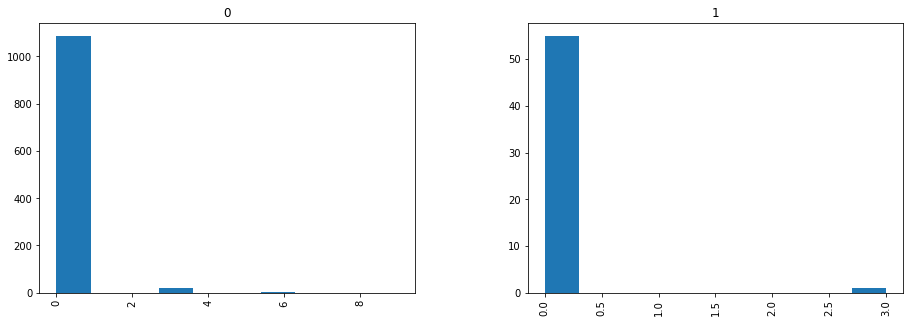

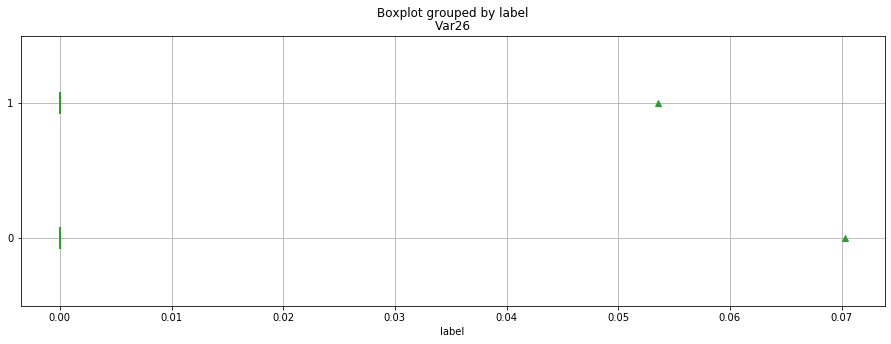

Correlation with label =  0.031877899758883235
Name of feature: Var132
Count notna elements 0: 2789, 1: 33195
median:  label
0    0.0
1    0.0
Name: Var132, dtype: float64
mean:  label
0    3.476668
1    3.792040
Name: Var132, dtype: float64
std:  label
0     9.843869
1    10.459037
Name: Var132, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.07746602  0.72346404]


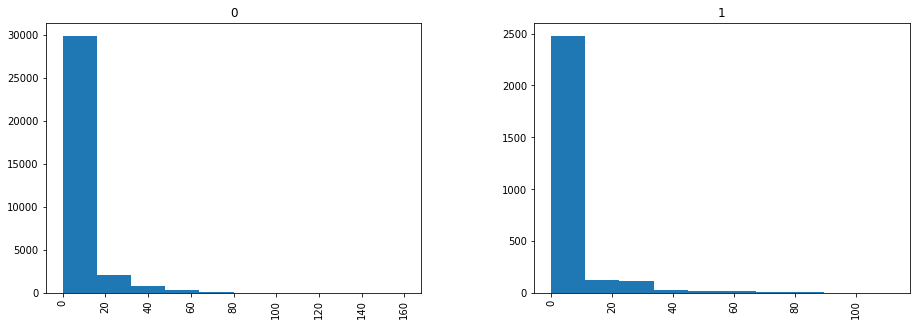

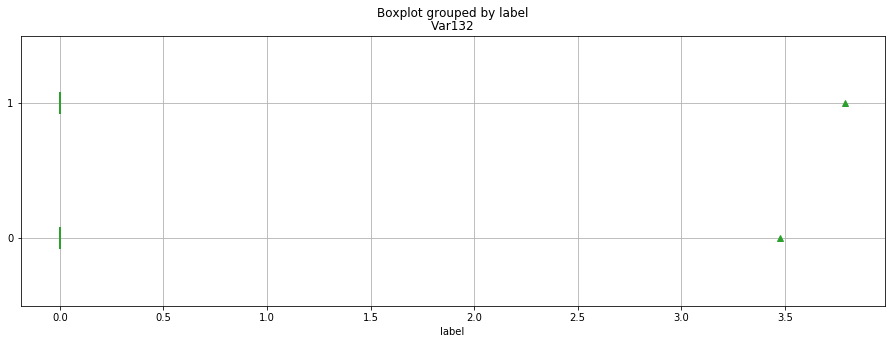

Correlation with label =  -0.03286787881275326
Name of feature: Var2
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var2, dtype: float64
mean:  label
0    0.005181
1    0.000000
Name: Var2, dtype: float64
std:  label
0    0.160956
1    0.000000
Name: Var2, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.01554404  0.        ]


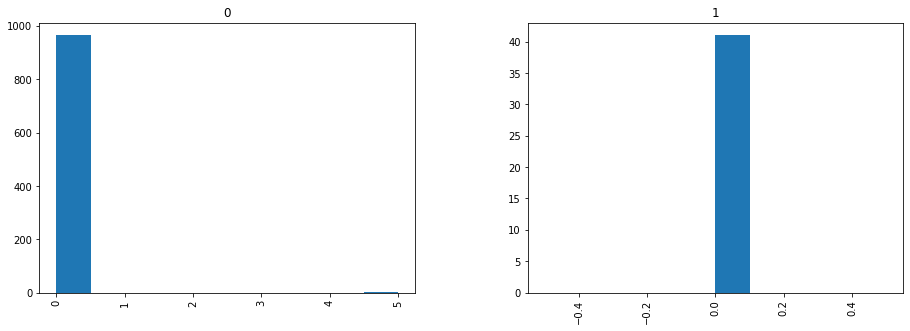

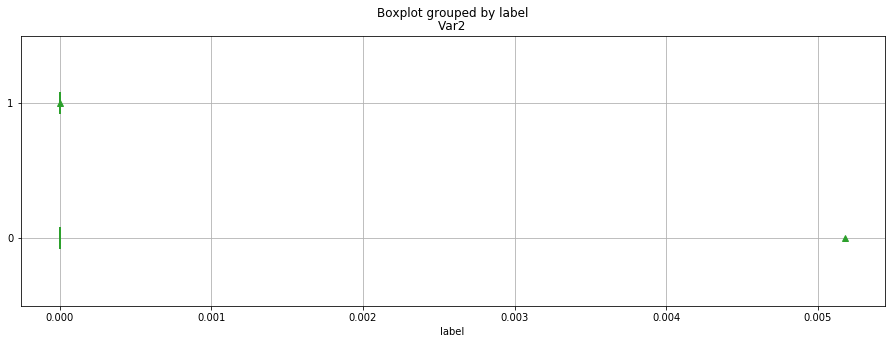

Correlation with label =  -0.03452169709837432
Name of feature: Var179
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var179, dtype: float64
mean:  label
0    2.95082
1    2.00000
Name: Var179, dtype: float64
std:  label
0    28.139274
1     4.674596
Name: Var179, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-3.36787444  0.89680514]


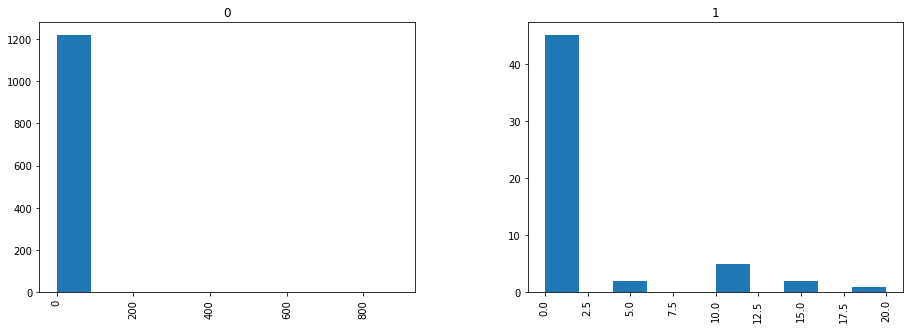

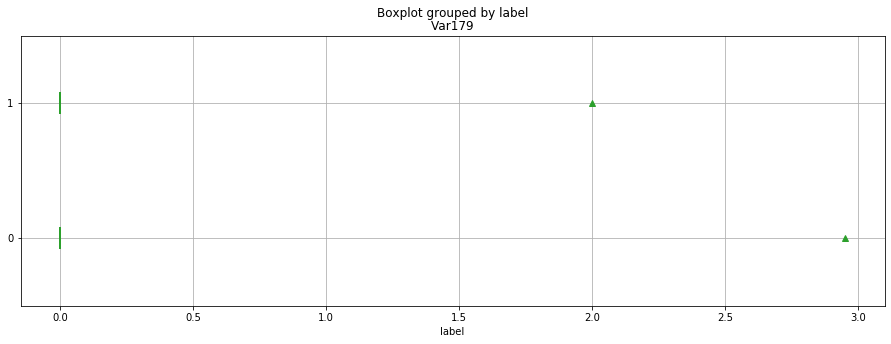

Correlation with label =  0.034835545750988545
Name of feature: Var153
Count notna elements 0: 2789, 1: 33195
median:  label
0    8100880.0
1    8436480.0
Name: Var153, dtype: float64
mean:  label
0    6.175110e+06
1    6.326563e+06
Name: Var153, dtype: float64
std:  label
0    4.352147e+06
1    4.292296e+06
Name: Var153, dtype: float64
interval of delta medians:  [-95672. 701381.]
interval of delta means:  [ -7676.27310209 317640.50500294]


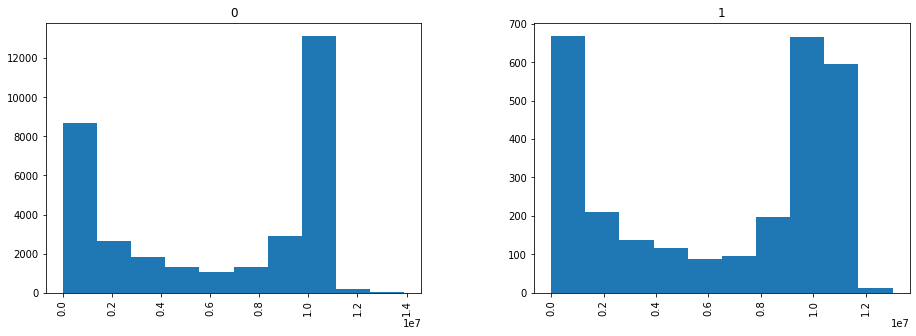

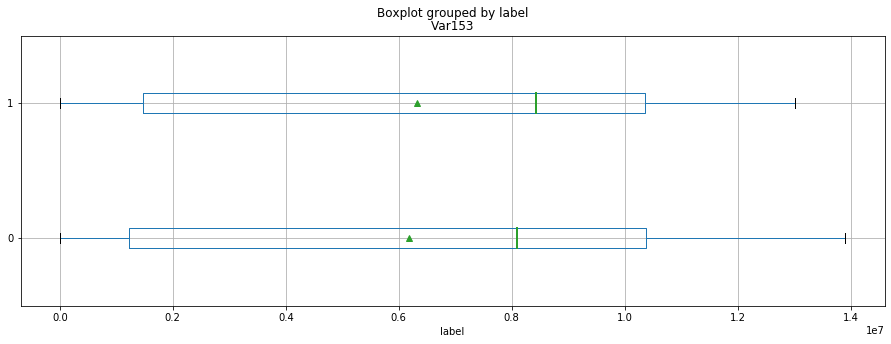

Correlation with label =  -0.036555478223072736
Name of feature: Var158
Count notna elements 0: 33, 1: 667
median:  label
0    0.0
1    0.0
Name: Var158, dtype: float64
mean:  label
0    1.965517
1    1.727273
Name: Var158, dtype: float64
std:  label
0    6.642095
1    3.095084
Name: Var158, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.34974104  0.95042252]


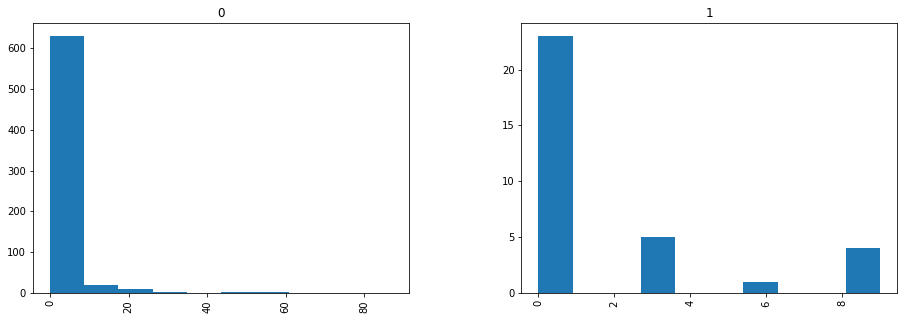

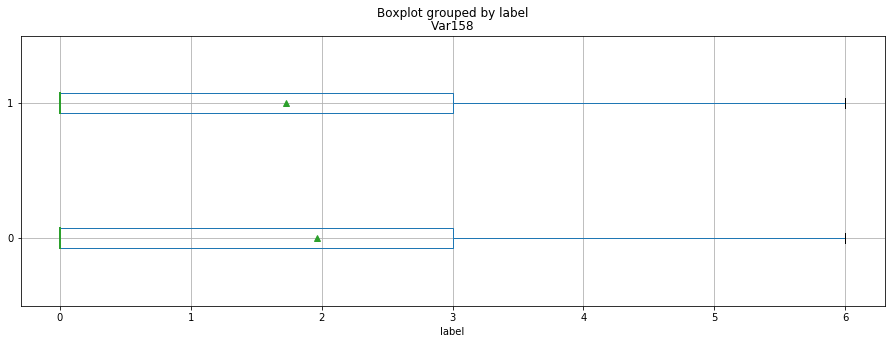

Correlation with label =  -0.03691872253430189
Name of feature: Var25
Count notna elements 0: 2789, 1: 33195
median:  label
0    48.0
1    48.0
Name: Var25, dtype: float64
mean:  label
0    96.834584
1    89.009681
Name: Var25, dtype: float64
std:  label
0    213.237039
1    195.867292
Name: Var25, dtype: float64
interval of delta medians:  [-8.  0.]
interval of delta means:  [-14.83724144   0.65783194]


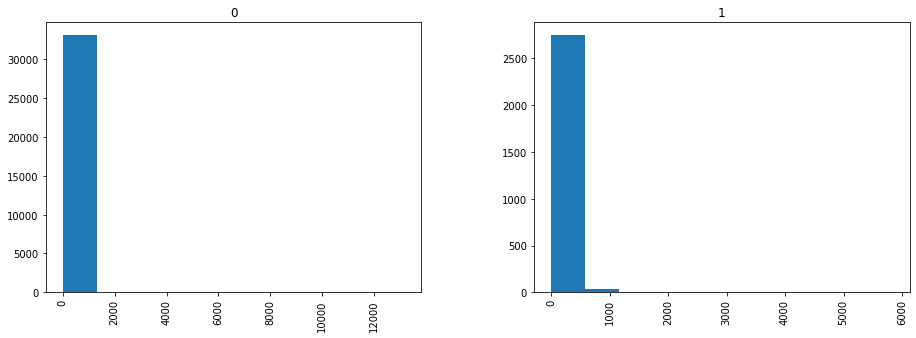

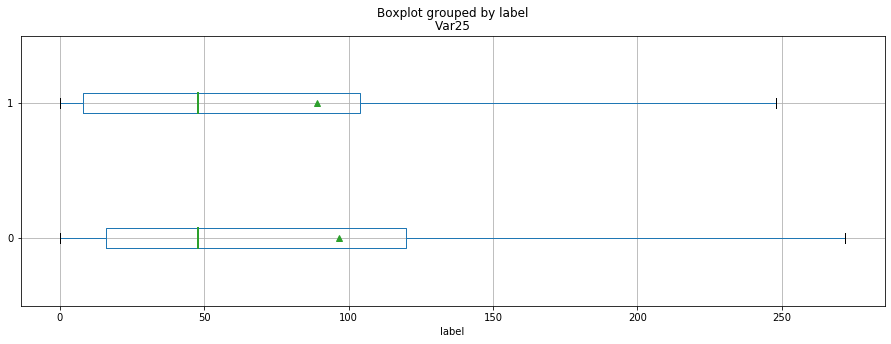

Correlation with label =  -0.03706144200880645
Name of feature: Var85
Count notna elements 0: 2789, 1: 33195
median:  label
0    4.0
1    4.0
Name: Var85, dtype: float64
mean:  label
0    8.517367
1    7.746863
Name: Var85, dtype: float64
std:  label
0    20.819030
1    20.430528
Name: Var85, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.5031496   0.13501873]


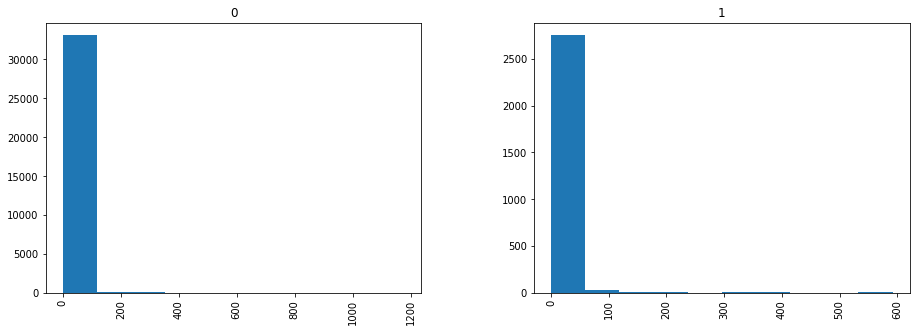

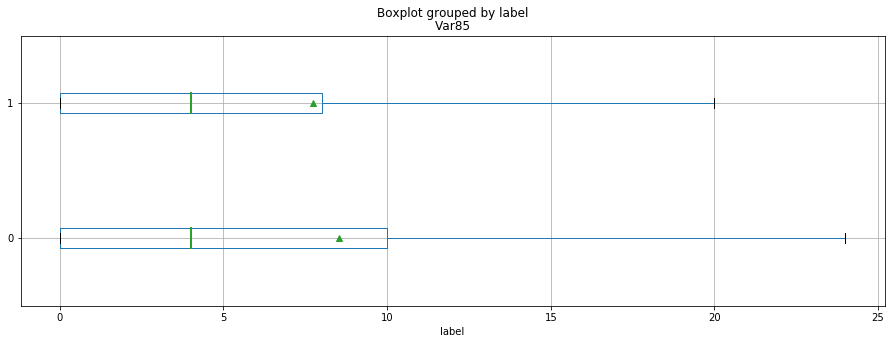

Correlation with label =  0.0374799798636353
Name of feature: Var159
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var159, dtype: float64
mean:  label
0    4.64456
1    5.04878
Name: Var159, dtype: float64
std:  label
0    10.857579
1     9.010969
Name: Var159, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-2.03884178  3.24846202]


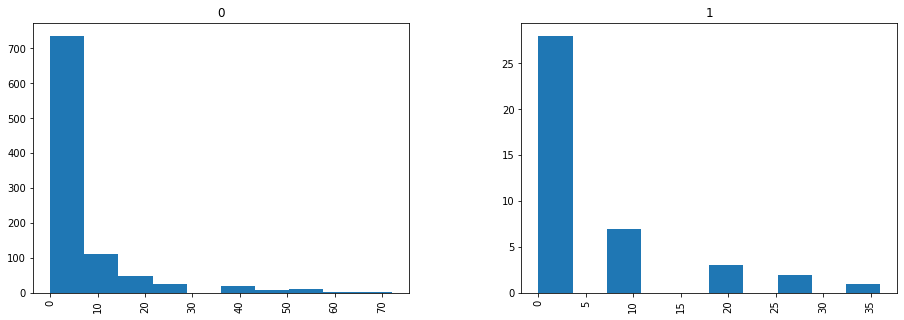

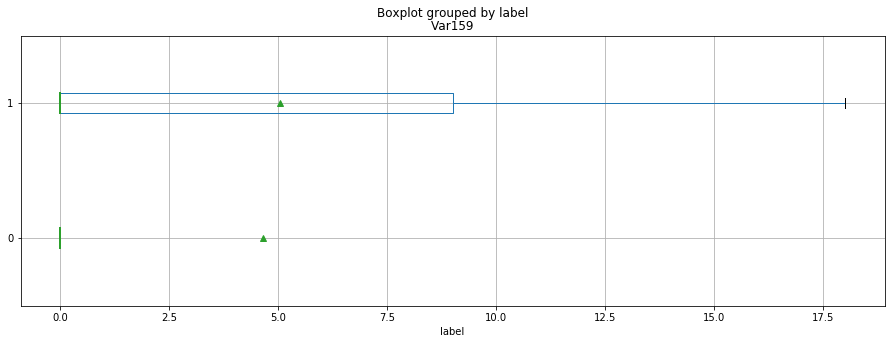

Correlation with label =  -0.037531936877361005
Name of feature: Var3
Count notna elements 0: 41, 1: 964
median:  label
0    0.0
1    0.0
Name: Var3, dtype: float64
mean:  label
0    436.173237
1    268.390244
Name: Var3, dtype: float64
std:  label
0    4556.193744
1    1346.643677
Name: Var3, dtype: float64
interval of delta medians:  [ 0.   18.45]
interval of delta means:  [-628.42590704  370.25183433]


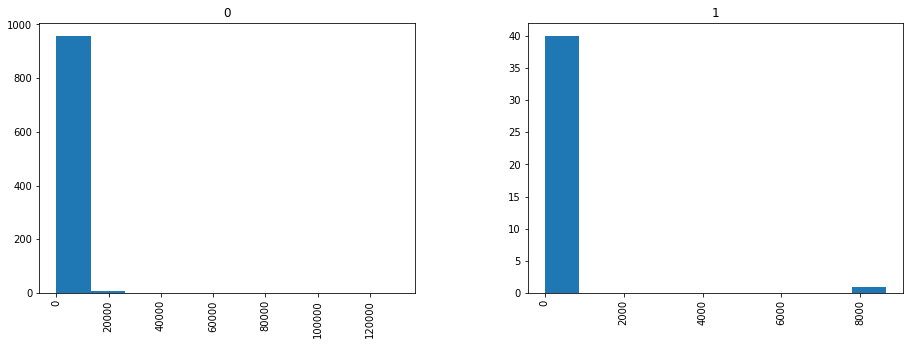

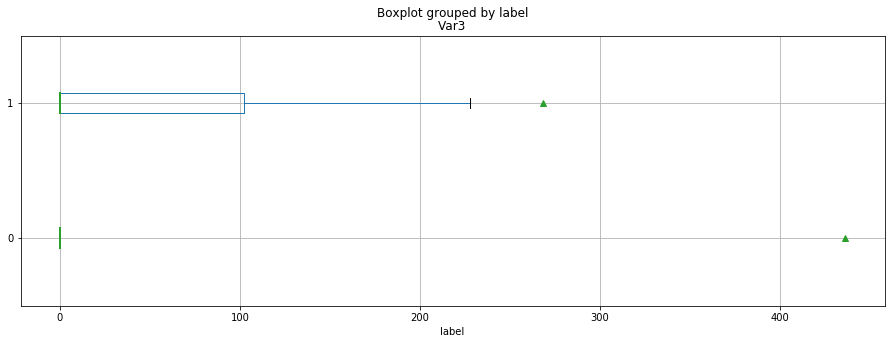

Correlation with label =  0.03810440953785368
Name of feature: Var54
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    8.0
Name: Var54, dtype: float64
mean:  label
0    4.849741
1    5.073171
Name: Var54, dtype: float64
std:  label
0    5.877661
1    5.587442
Name: Var54, dtype: float64
interval of delta medians:  [0. 8.]
interval of delta means:  [-1.5082118   1.91330216]


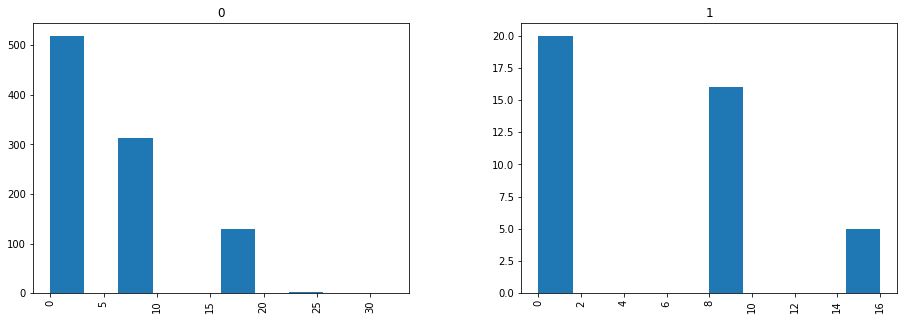

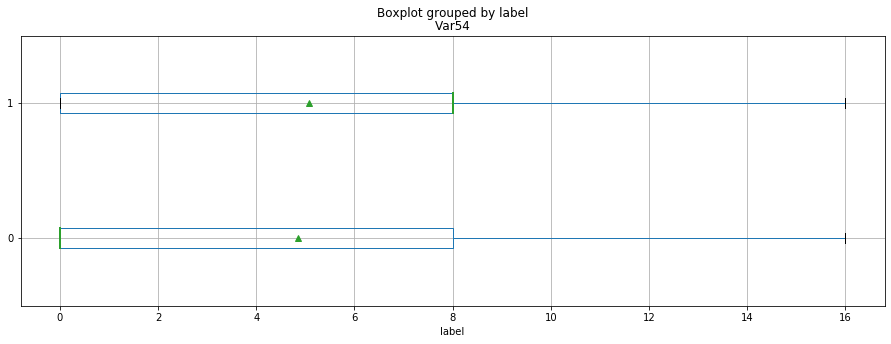

Correlation with label =  0.038435564307394234
Name of feature: Var173
Count notna elements 0: 2789, 1: 33195
median:  label
0    0.0
1    0.0
Name: Var173, dtype: float64
mean:  label
0    0.006387
1    0.011474
Name: Var173, dtype: float64
std:  label
0    0.127858
1    0.177291
Name: Var173, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.00118603  0.01255352]


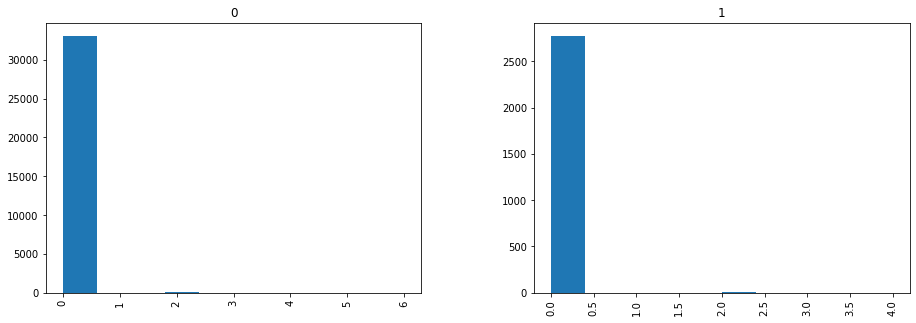

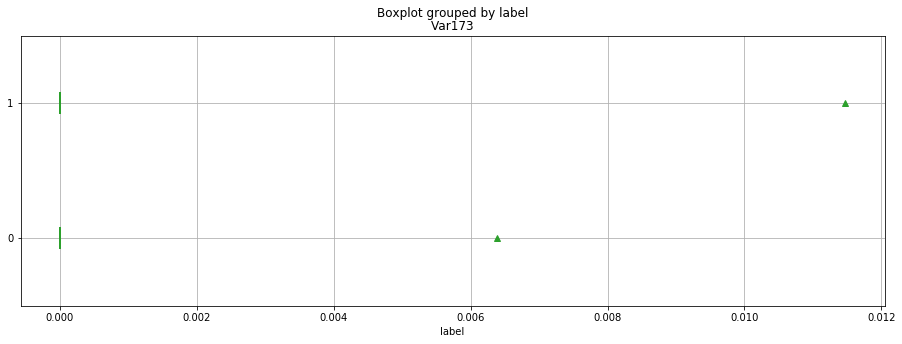

Correlation with label =  0.03908773889560847
Name of feature: Var143
Count notna elements 0: 2789, 1: 33195
median:  label
0    0.0
1    0.0
Name: Var143, dtype: float64
mean:  label
0    0.056394
1    0.081750
Name: Var143, dtype: float64
std:  label
0    0.632666
1    0.815330
Name: Var143, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.00227241  0.05891229]


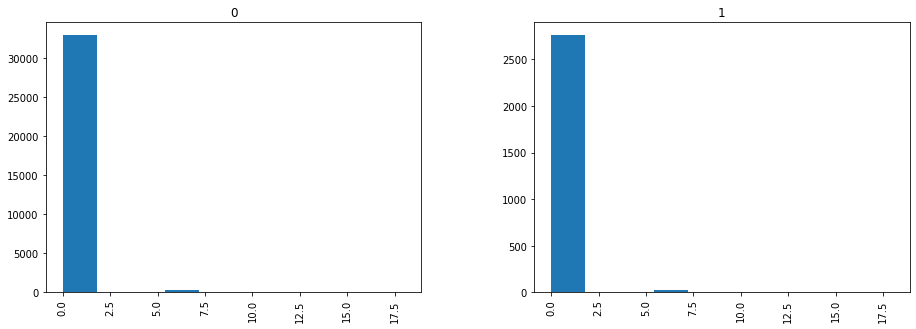

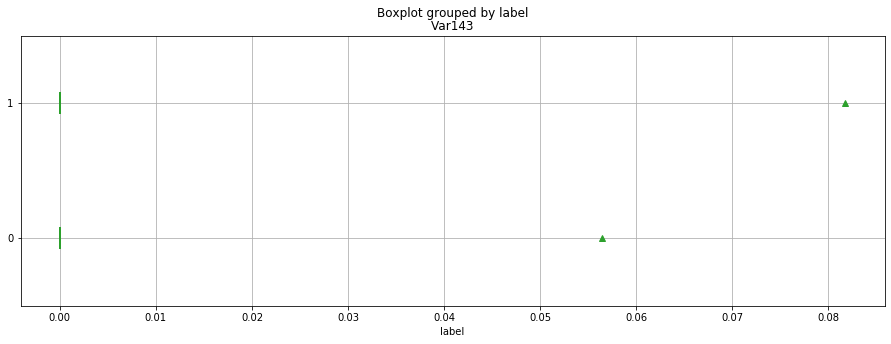

Correlation with label =  0.04053491576971019
Name of feature: Var9
Count notna elements 0: 35, 1: 535
median:  label
0    20.0
1    34.0
Name: Var9, dtype: float64
mean:  label
0    47.121495
1    53.085714
Name: Var9, dtype: float64
std:  label
0    150.690540
1     75.056595
Name: Var9, dtype: float64
interval of delta medians:  [-2. 28.]
interval of delta means:  [-19.49255007  37.49562083]


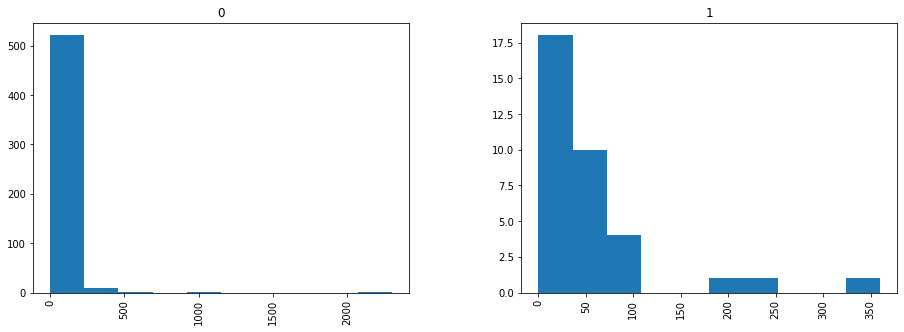

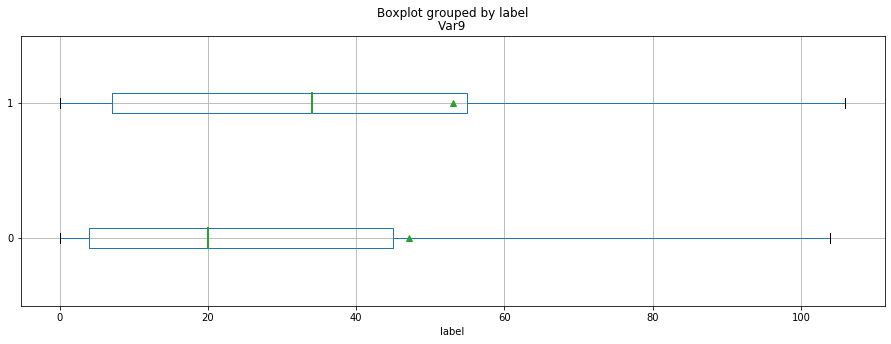

Correlation with label =  -0.040898249476161844
Name of feature: Var24
Count notna elements 0: 2575, 1: 31609
median:  label
0    2.0
1    2.0
Name: Var24, dtype: float64
mean:  label
0    4.539214
1    4.132816
Name: Var24, dtype: float64
std:  label
0    10.028070
1     8.732193
Name: Var24, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.7577401  -0.01984998]


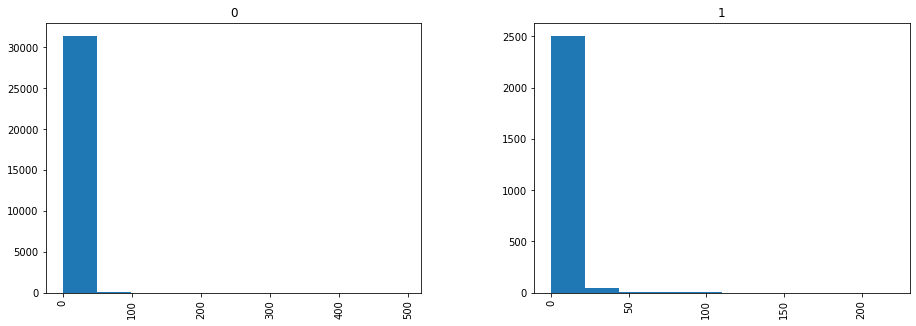

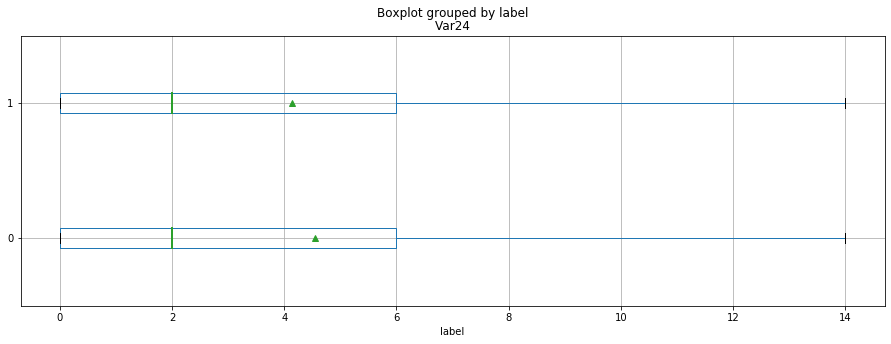

Correlation with label =  0.04095141699197338
Name of feature: Var135
Count notna elements 0: 55, 1: 1220
median:  label
0    223.16
1    235.13
Name: Var135, dtype: float64
mean:  label
0    198.481328
1    203.894727
Name: Var135, dtype: float64
std:  label
0    132.353705
1    129.601024
Name: Var135, dtype: float64
interval of delta medians:  [-18.277    44.24525]
interval of delta means:  [-30.00826321  37.78313167]


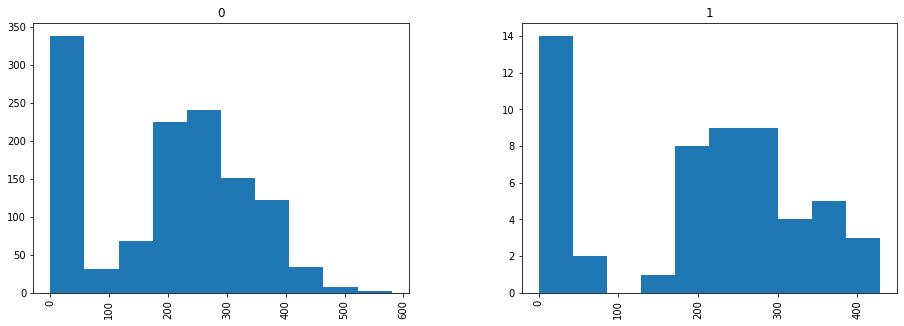

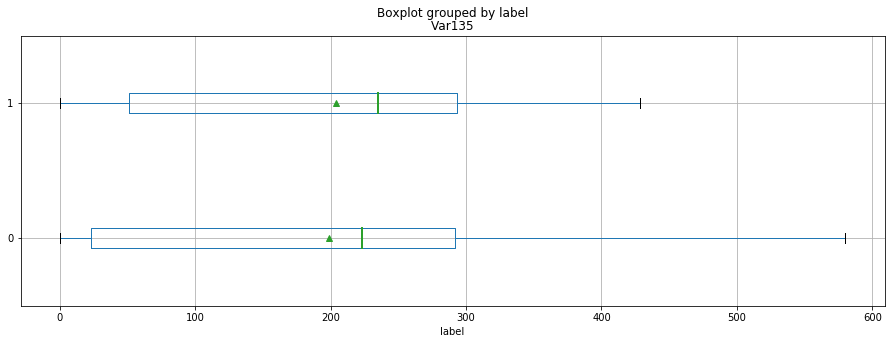

Correlation with label =  -0.0430433073101025
Name of feature: Var119
Count notna elements 0: 2759, 1: 32806
median:  label
0    560.0
1    540.0
Name: Var119, dtype: float64
mean:  label
0    916.549107
1    827.013411
Name: Var119, dtype: float64
std:  label
0    2104.767686
1    1759.188288
Name: Var119, dtype: float64
interval of delta medians:  [-30. -10.]
interval of delta means:  [-155.56249502  -20.21216973]


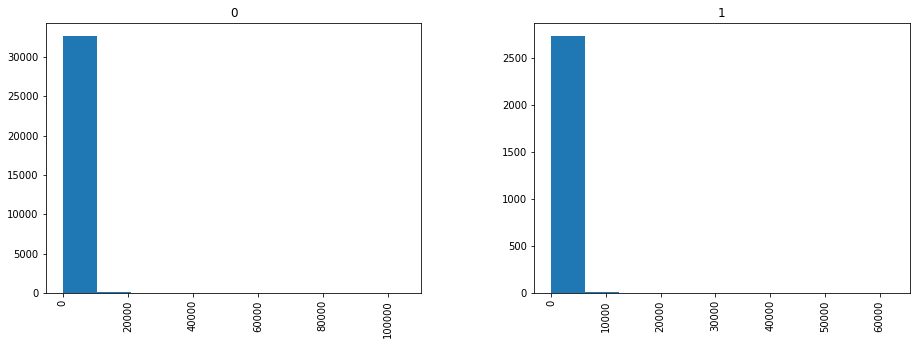

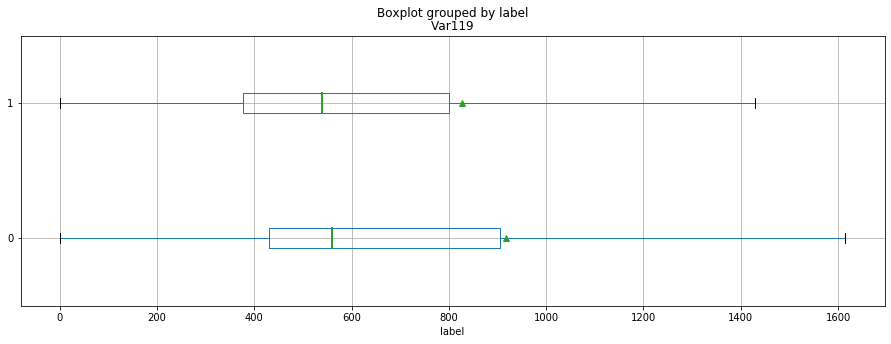

Correlation with label =  -0.043155494726137514
Name of feature: Var107
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var107, dtype: float64
mean:  label
0    5.569883
1    3.053571
Name: Var107, dtype: float64
std:  label
0    59.745231
1     6.121258
Name: Var107, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-7.07803201  0.69508929]


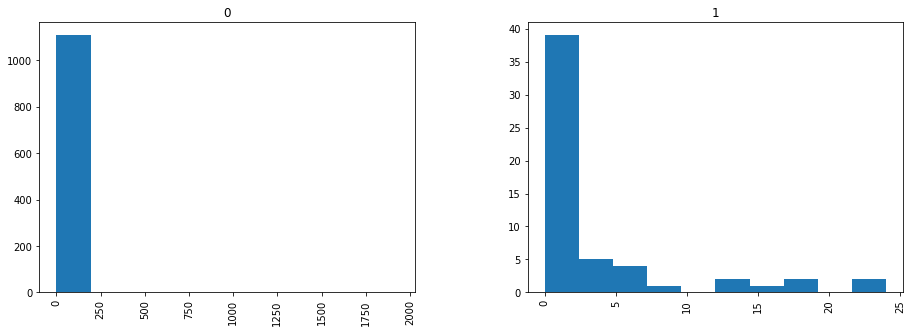

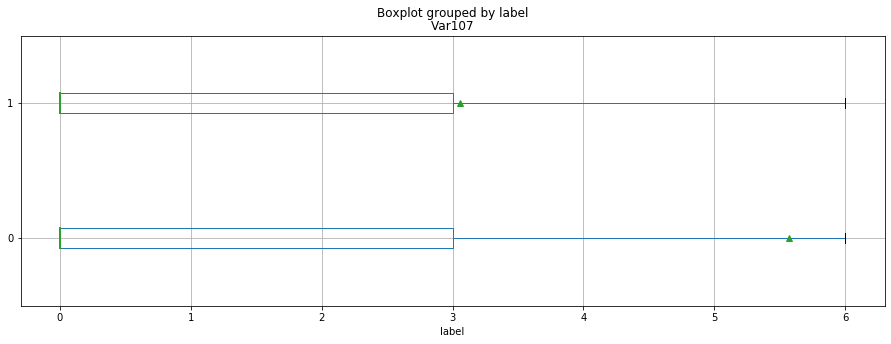

Correlation with label =  -0.04327296761598708
Name of feature: Var103
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var103, dtype: float64
mean:  label
0    19.971145
1    15.875000
Name: Var103, dtype: float64
std:  label
0    96.808424
1    28.519889
Name: Var103, dtype: float64
interval of delta medians:  [ 0. 14.]
interval of delta means:  [-13.09489968   5.17677243]


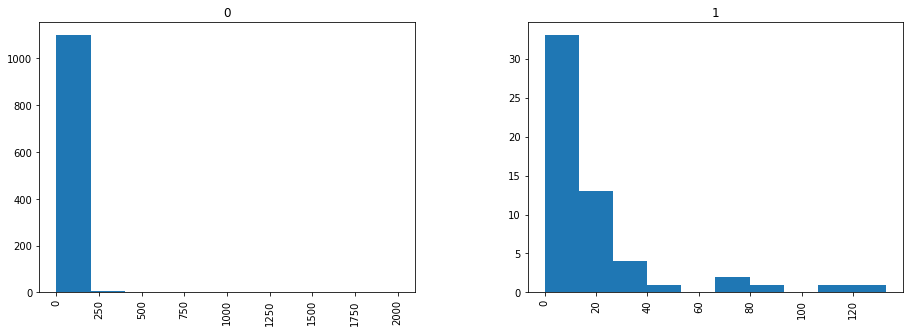

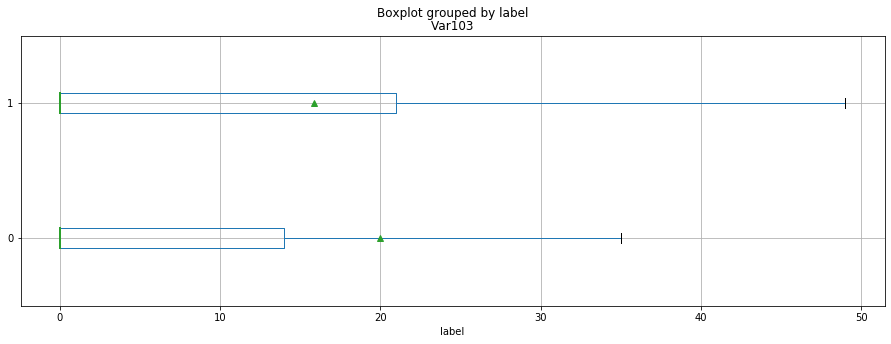

Correlation with label =  0.043514346448452555
Name of feature: Var70
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var70, dtype: float64
mean:  label
0    404156.967538
1    440279.625000
Name: Var70, dtype: float64
std:  label
0    828799.435695
1    863089.177645
Name: Var70, dtype: float64
interval of delta medians:  [    0.  52201.5]
interval of delta means:  [-177559.58999783  265740.95801438]


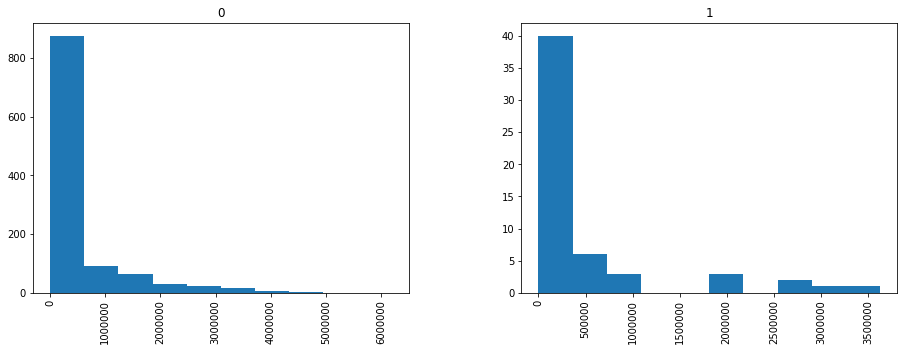

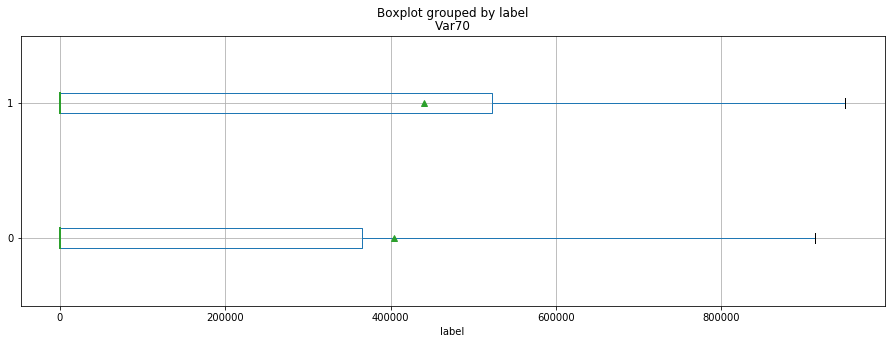

Correlation with label =  0.043818325193075394
Name of feature: Var149
Count notna elements 0: 2575, 1: 31609
median:  label
0    51338.0
1    61096.0
Name: Var149, dtype: float64
mean:  label
0    295945.232212
1    325481.906019
Name: Var149, dtype: float64
std:  label
0    667695.985989
1    747518.562353
Name: Var149, dtype: float64
interval of delta medians:  [-6950.3   26101.425]
interval of delta means:  [ 4209.73276554 58834.96665586]


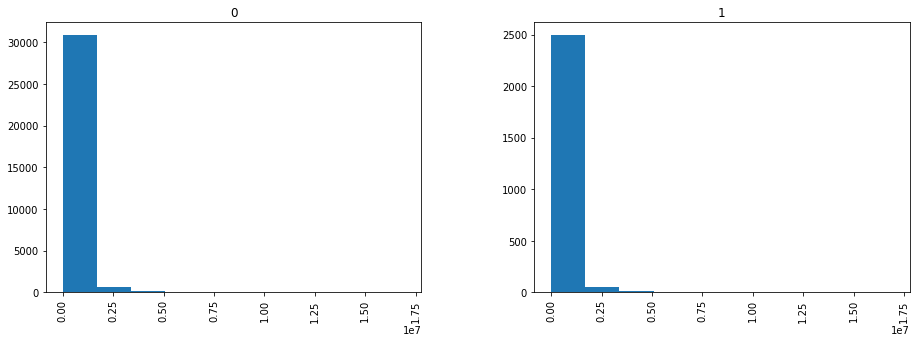

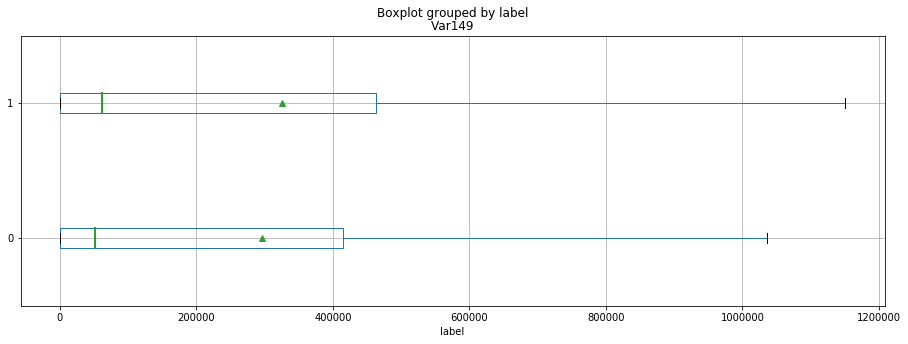

Correlation with label =  -0.04596028772396371
Name of feature: Var99
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    8.0
Name: Var99, dtype: float64
mean:  label
0    24.636066
1    20.363636
Name: Var99, dtype: float64
std:  label
0    94.546638
1    45.433045
Name: Var99, dtype: float64
interval of delta medians:  [ 0. 16.]
interval of delta means:  [-16.24992548   8.95748137]


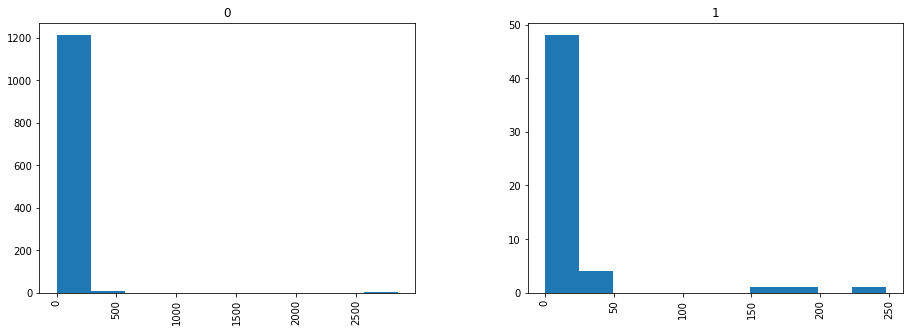

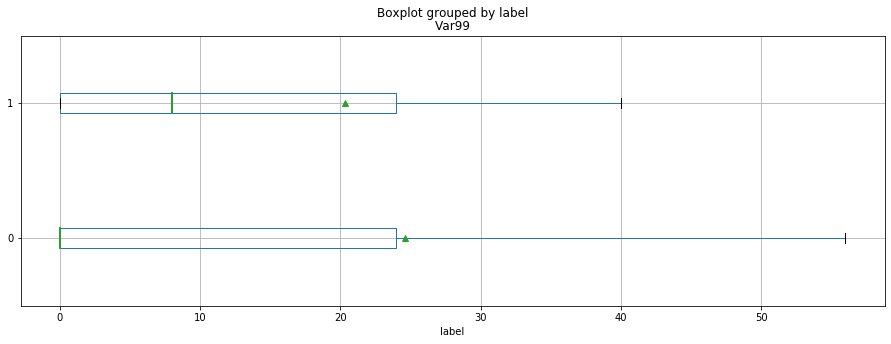

Correlation with label =  0.0460801326260241
Name of feature: Var162
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var162, dtype: float64
mean:  label
0    332941.840415
1    377503.024390
Name: Var162, dtype: float64
std:  label
0    978046.720937
1    663686.720148
Name: Var162, dtype: float64
interval of delta medians:  [     0. 148545.]
interval of delta means:  [-152646.92250474  266585.4408088 ]


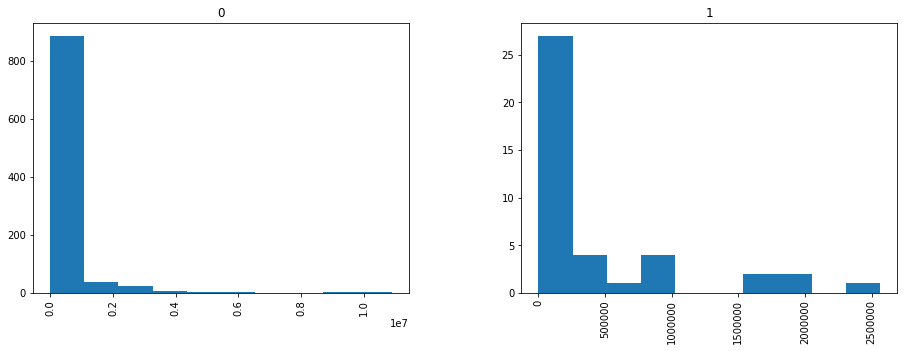

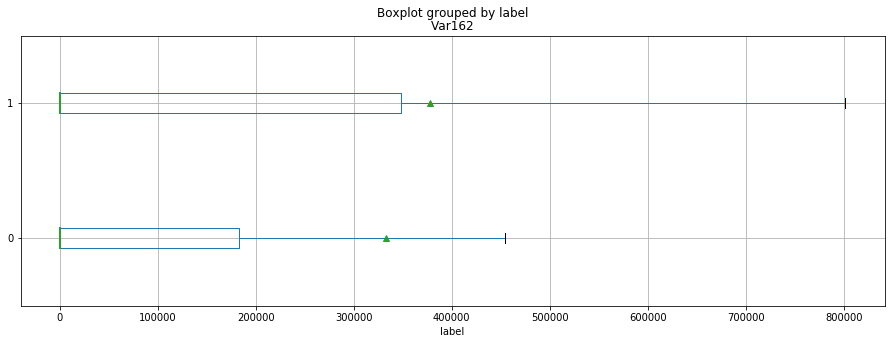

Correlation with label =  -0.0466141183647483
Name of feature: Var174
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var174, dtype: float64
mean:  label
0    7.232787
1    5.381818
Name: Var174, dtype: float64
std:  label
0    40.542849
1     9.528691
Name: Var174, dtype: float64
interval of delta medians:  [0. 4.]
interval of delta means:  [-5.05849478  1.27710134]


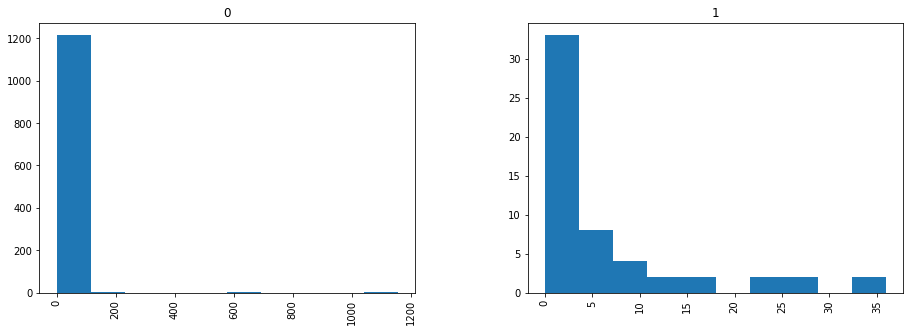

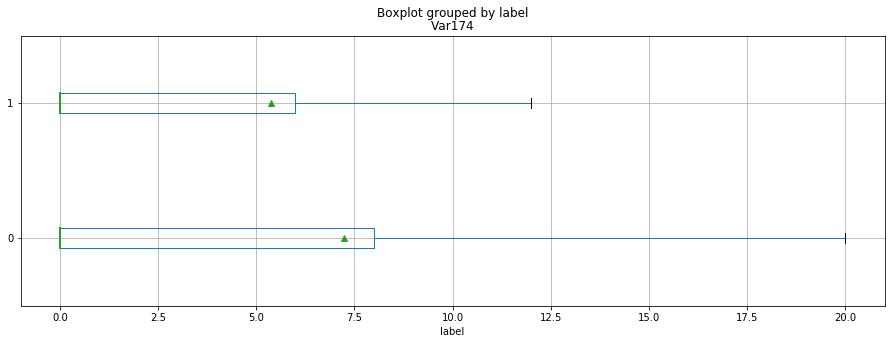

Correlation with label =  0.04779286211233358
Name of feature: Var1
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    8.0
Name: Var1, dtype: float64
mean:  label
0    10.900935
1    12.571429
Name: Var1, dtype: float64
std:  label
0    35.601881
1    23.144413
Name: Var1, dtype: float64
interval of delta medians:  [0. 8.]
interval of delta means:  [-5.38627503  9.90595461]


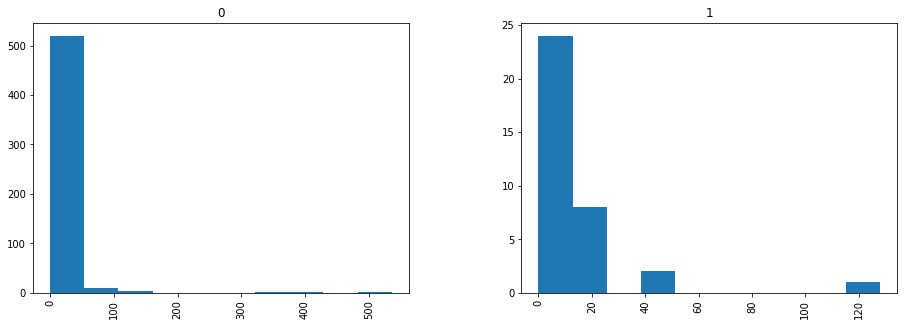

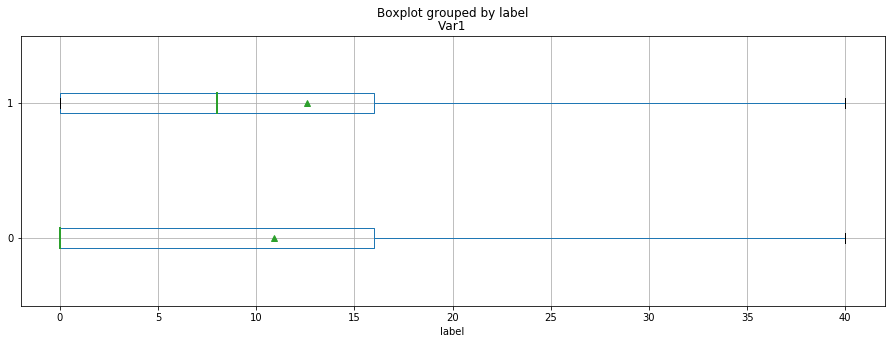

Correlation with label =  -0.048681248105877886
Name of feature: Var186
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var186, dtype: float64
mean:  label
0    3.543925
1    3.085714
Name: Var186, dtype: float64
std:  label
0    9.594076
1    6.065192
Name: Var186, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-2.39883845  1.84425901]


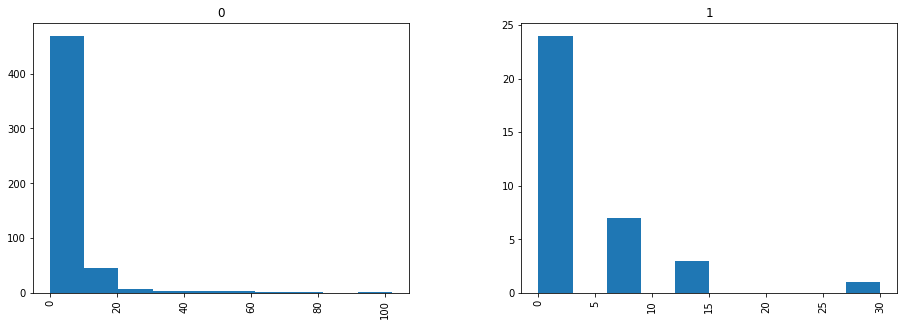

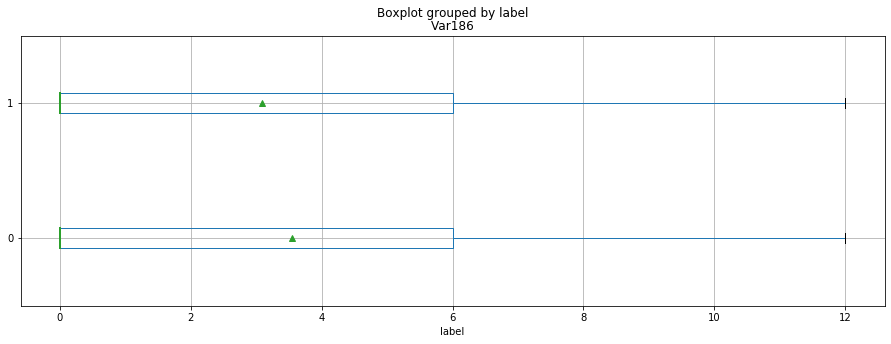

Correlation with label =  0.04875534114492595
Name of feature: Var187
Count notna elements 0: 35, 1: 535
median:  label
0    4.0
1    6.0
Name: Var187, dtype: float64
mean:  label
0    15.891589
1    18.571429
Name: Var187, dtype: float64
std:  label
0    55.797616
1    40.678283
Name: Var187, dtype: float64
interval of delta medians:  [-2. 10.]
interval of delta means:  [-8.81651535 19.19451268]


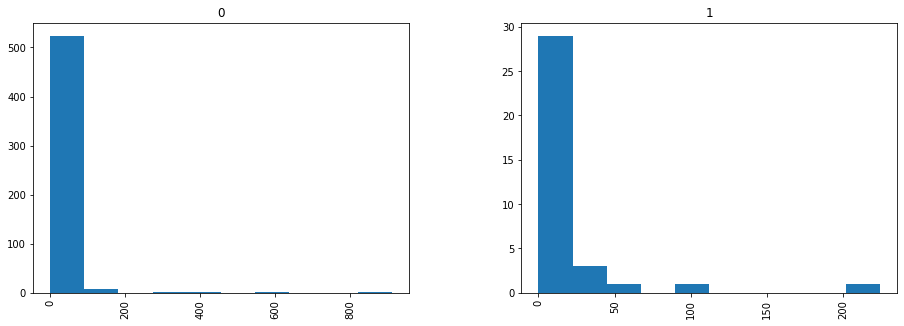

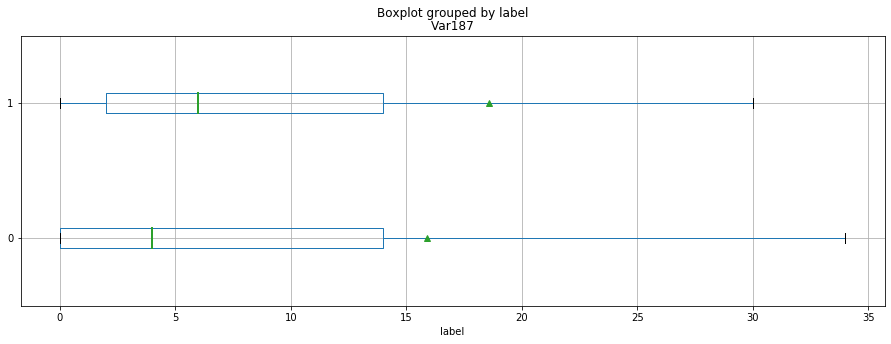

Correlation with label =  -0.049340397302510504
Name of feature: Var160
Count notna elements 0: 2789, 1: 33195
median:  label
0    22.0
1    20.0
Name: Var160, dtype: float64
mean:  label
0    39.130953
1    34.299032
Name: Var160, dtype: float64
std:  label
0    99.379501
1    78.535946
Name: Var160, dtype: float64
interval of delta medians:  [-2.  0.]
interval of delta means:  [-7.65266008 -1.59780294]


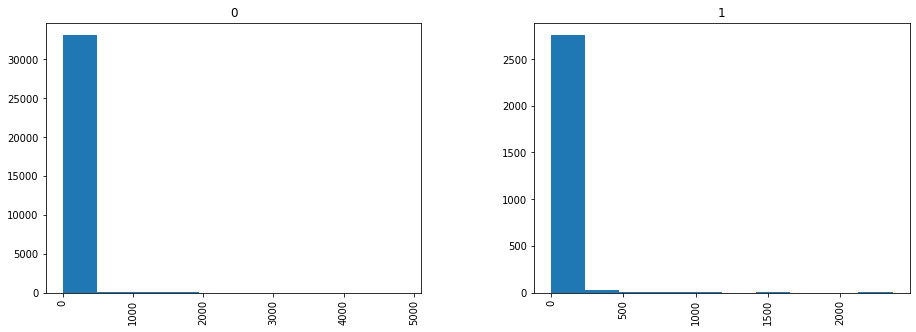

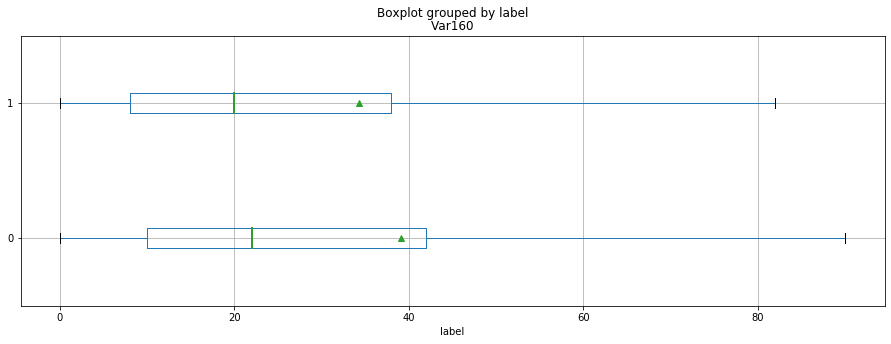

Correlation with label =  -0.05264421306410075
Name of feature: Var40
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var40, dtype: float64
mean:  label
0    11.854922
1    10.146341
Name: Var40, dtype: float64
std:  label
0    33.015960
1    13.859223
Name: Var40, dtype: float64
interval of delta medians:  [0. 8.]
interval of delta means:  [-6.39409074  2.73978011]


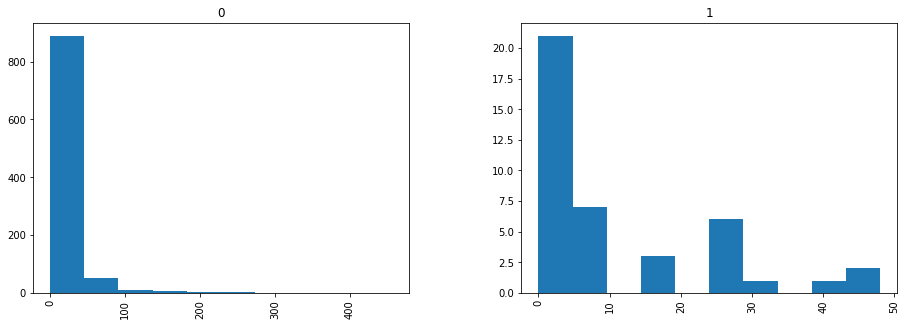

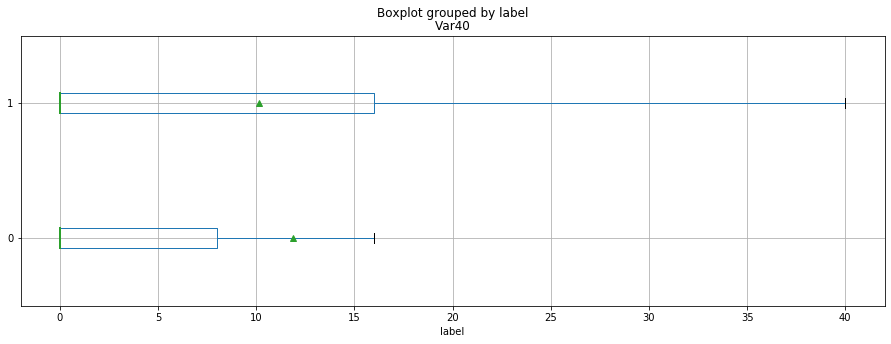

Correlation with label =  0.05386018324340559
Name of feature: Var63
Count notna elements 0: 35, 1: 528
median:  label
0    12.0
1    18.0
Name: Var63, dtype: float64
mean:  label
0    39.068182
1    47.142857
Name: Var63, dtype: float64
std:  label
0    153.415149
1     81.467837
Name: Var63, dtype: float64
interval of delta medians:  [-6.075 18.   ]
interval of delta means:  [-19.82314935  40.74836039]


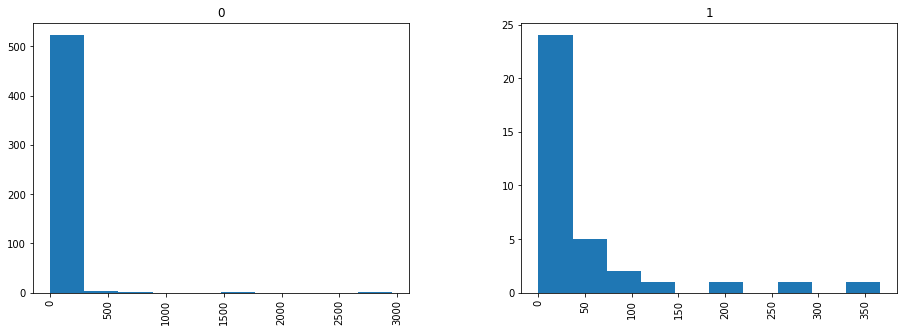

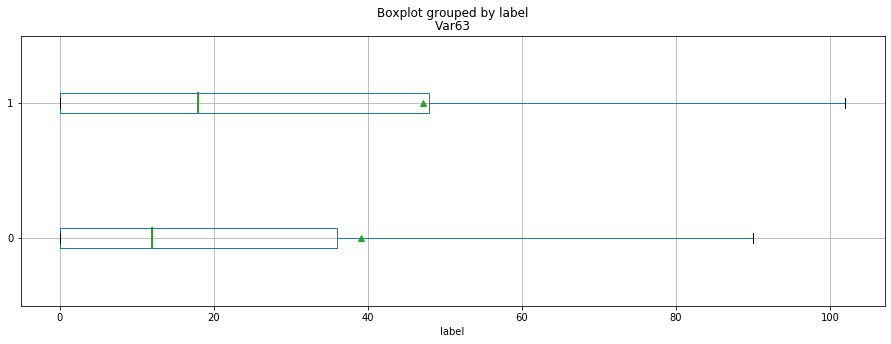

Correlation with label =  -0.05420522184816044
Name of feature: Var145
Count notna elements 0: 55, 1: 1220
median:  label
0    12.0
1    12.0
Name: Var145, dtype: float64
mean:  label
0    55.686885
1    43.309091
Name: Var145, dtype: float64
std:  label
0    232.974820
1     69.307921
Name: Var145, dtype: float64
interval of delta medians:  [-12.     18.075]
interval of delta means:  [-34.64718331  10.17517511]


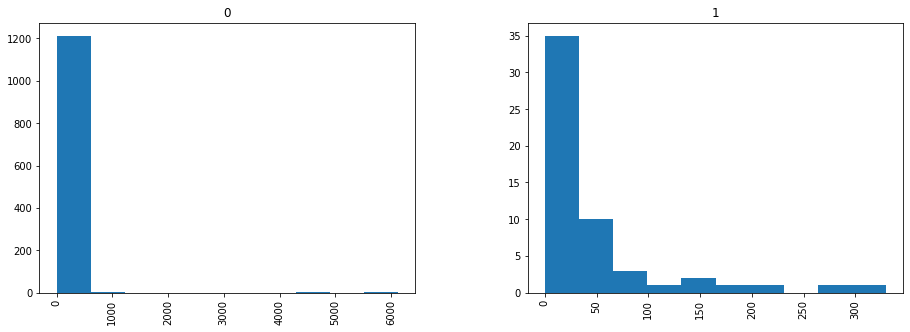

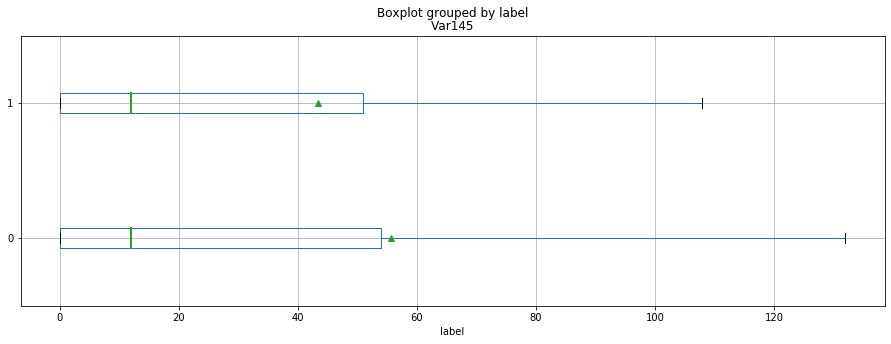

Correlation with label =  -0.05468390368191205
Name of feature: Var30
Count notna elements 0: 35, 1: 535
median:  label
0    5.0
1    5.0
Name: Var30, dtype: float64
mean:  label
0    7.654206
1    7.142857
Name: Var30, dtype: float64
std:  label
0    9.513545
1    6.449546
Name: Var30, dtype: float64
interval of delta medians:  [0. 5.]
interval of delta means:  [-2.49539386  2.03821762]


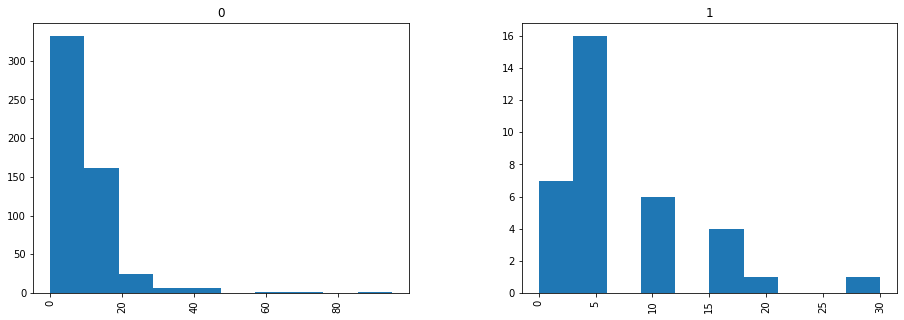

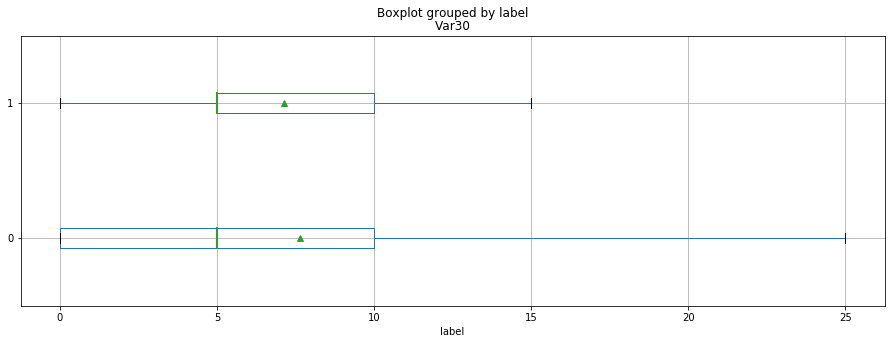

Correlation with label =  -0.05604735744931507
Name of feature: Var106
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var106, dtype: float64
mean:  label
0    39312.240984
1    30193.963636
Name: Var106, dtype: float64
std:  label
0    165301.511416
1     86787.339726
Name: Var106, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-31134.47737891  19080.73925857]


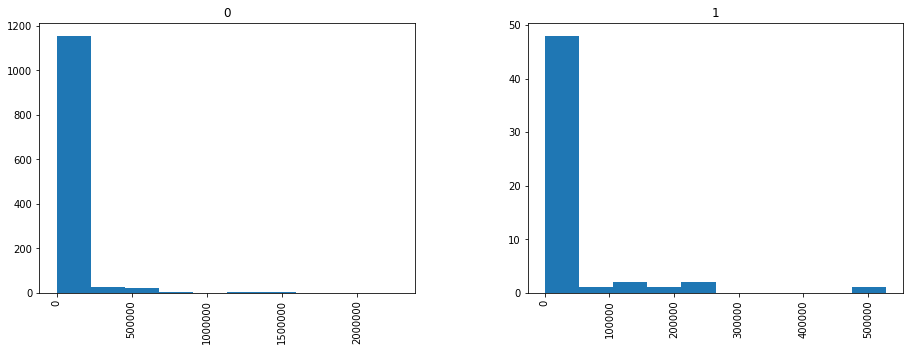

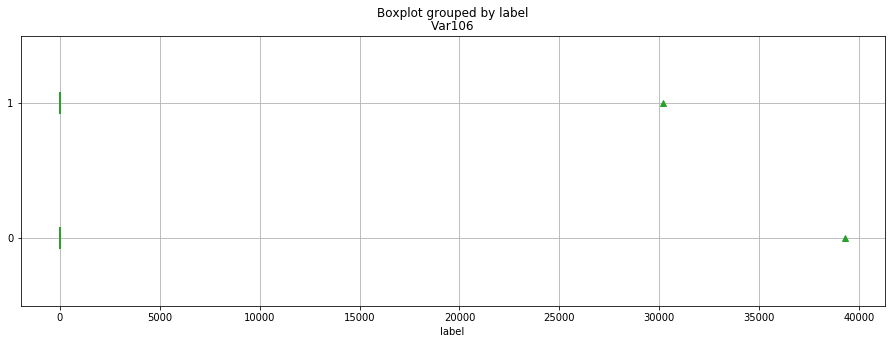

Correlation with label =  -0.05609466817198045
Name of feature: Var94
Count notna elements 0: 1591, 1: 20472
median:  label
0    41514.0
1    34395.0
Name: Var94, dtype: float64
mean:  label
0    98765.745750
1    89076.654305
Name: Var94, dtype: float64
std:  label
0    173983.523607
1    155433.776237
Name: Var94, dtype: float64
interval of delta medians:  [-13053.8625  -1861.35  ]
interval of delta means:  [-17405.34876326  -1768.54549795]


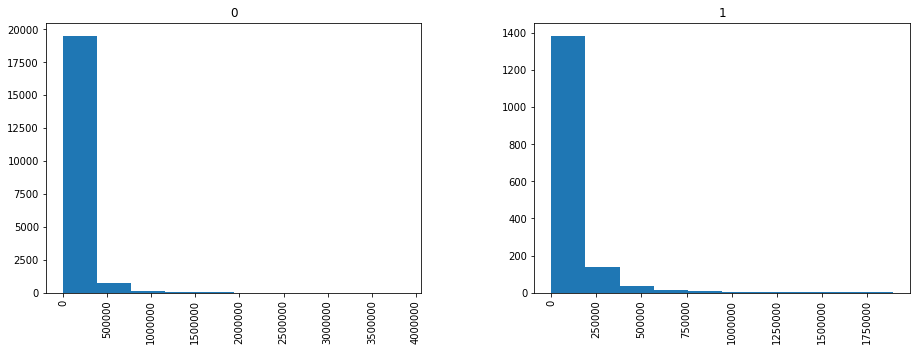

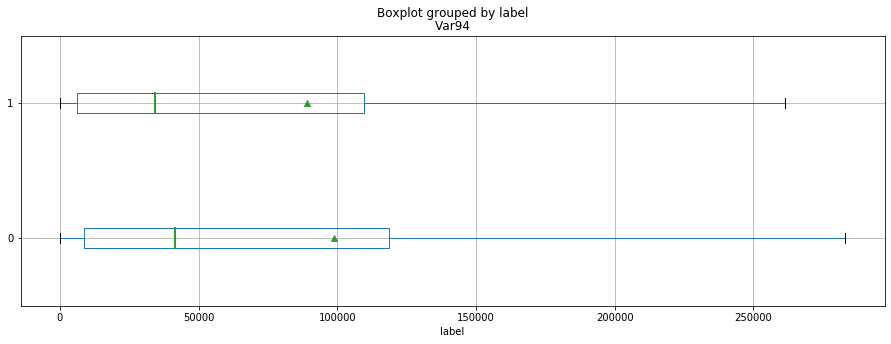

Correlation with label =  -0.05630276944717069
Name of feature: Var82
Count notna elements 0: 55, 1: 1220
median:  label
0    3.0
1    3.0
Name: Var82, dtype: float64
mean:  label
0    2.419672
1    2.290909
Name: Var82, dtype: float64
std:  label
0    2.283645
1    2.377929
Name: Var82, dtype: float64
interval of delta medians:  [-3.  0.]
interval of delta means:  [-0.77796572  0.52627981]


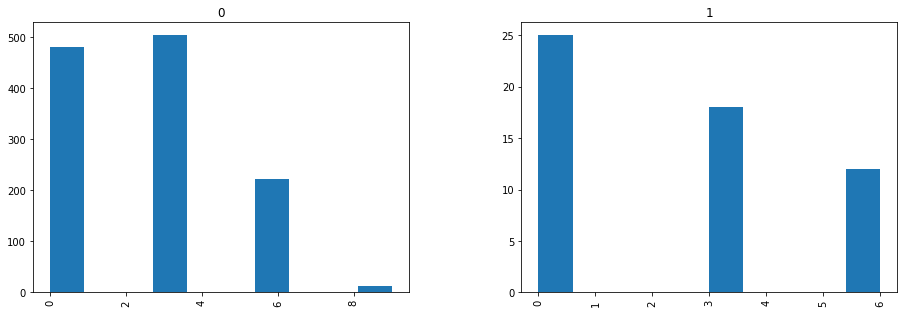

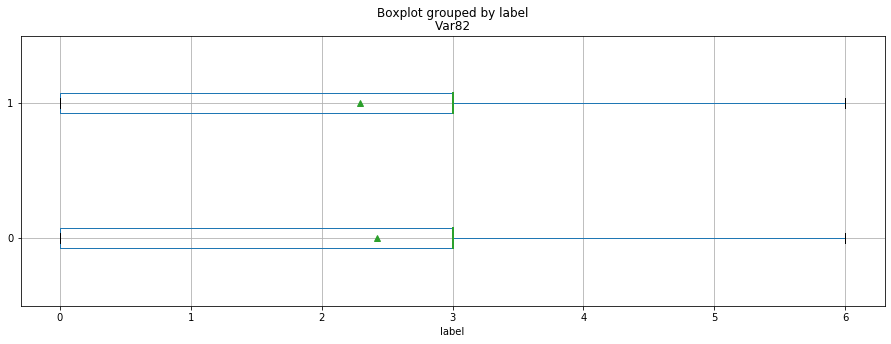

Correlation with label =  0.05675606693187675
Name of feature: Var28
Count notna elements 0: 2789, 1: 33194
median:  label
0    220.08
1    220.08
Name: Var28, dtype: float64
mean:  label
0    223.872713
1    229.432447
Name: Var28, dtype: float64
std:  label
0    98.106631
1    96.045883
Name: Var28, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [1.79223273 9.2512786 ]


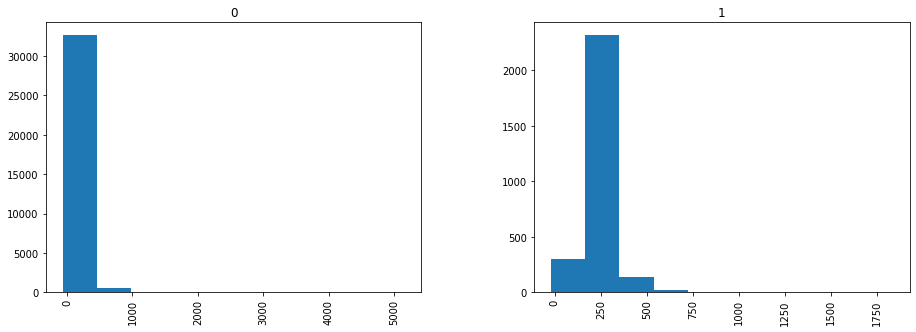

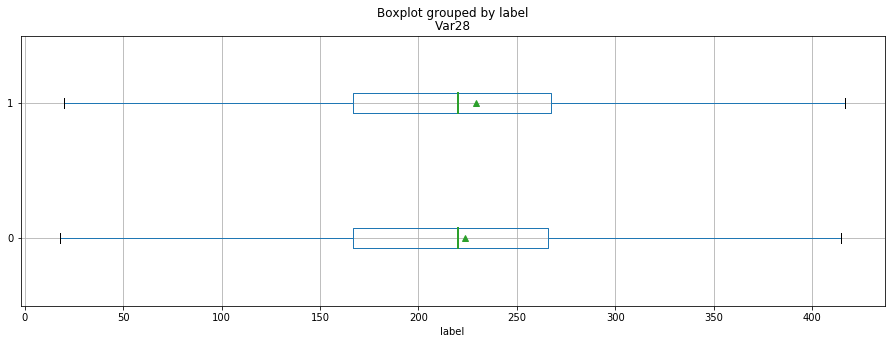

Correlation with label =  -0.056835457049328915
Name of feature: Var17
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var17, dtype: float64
mean:  label
0    10.684426
1     8.000000
Name: Var17, dtype: float64
std:  label
0    48.169985
1    15.622870
Name: Var17, dtype: float64
interval of delta medians:  [0. 5.]
interval of delta means:  [-7.47951751  2.28267511]


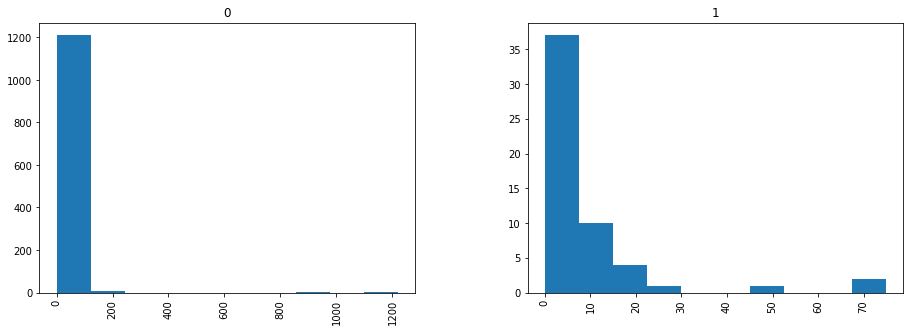

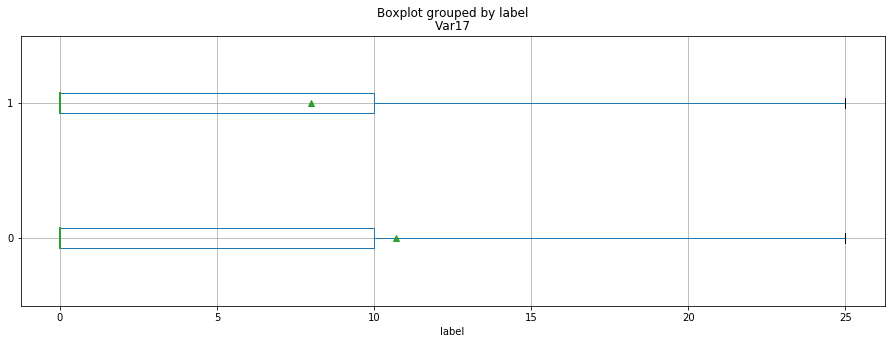

Correlation with label =  -0.05715413227722443
Name of feature: Var125
Count notna elements 0: 2745, 1: 32815
median:  label
0    6714.0
1    2727.0
Name: Var125, dtype: float64
mean:  label
0    28461.731373
1    23146.334426
Name: Var125, dtype: float64
std:  label
0    95020.162041
1    63925.876952
Name: Var125, dtype: float64
interval of delta medians:  [-4626.   -3518.55]
interval of delta means:  [-7720.53250199 -2494.95098065]


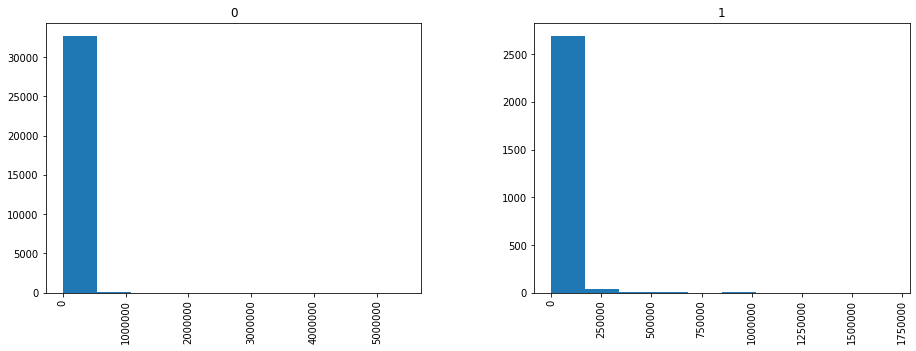

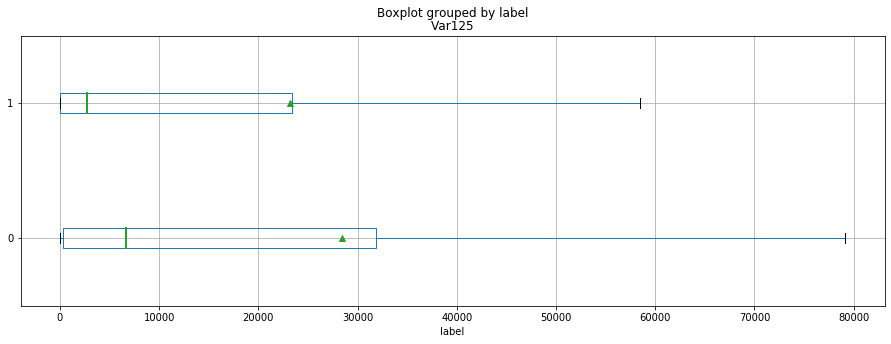

Correlation with label =  -0.0574429244592677
Name of feature: Var60
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var60, dtype: float64
mean:  label
0    9.532913
1    6.750000
Name: Var60, dtype: float64
std:  label
0    49.498770
1    17.495194
Name: Var60, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-7.82144186  2.47079979]


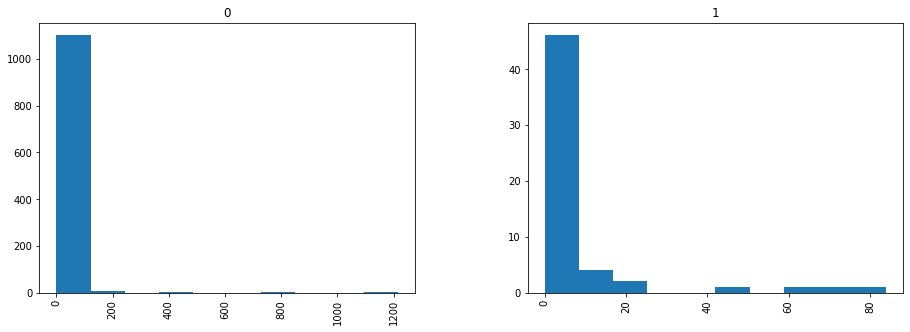

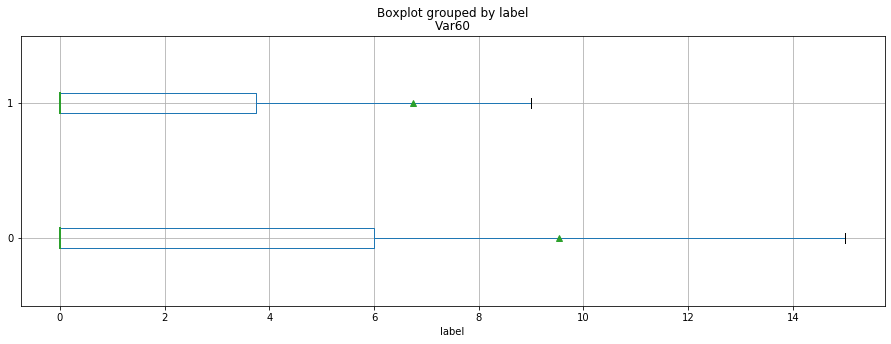

Correlation with label =  0.0599490822429007
Name of feature: Var68
Count notna elements 0: 41, 1: 965
median:  label
0     7.0
1    42.0
Name: Var68, dtype: float64
mean:  label
0    75.367876
1    88.780488
Name: Var68, dtype: float64
std:  label
0    227.242414
1    113.988708
Name: Var68, dtype: float64
interval of delta medians:  [-7. 56.]
interval of delta means:  [-20.71764249  53.41106154]


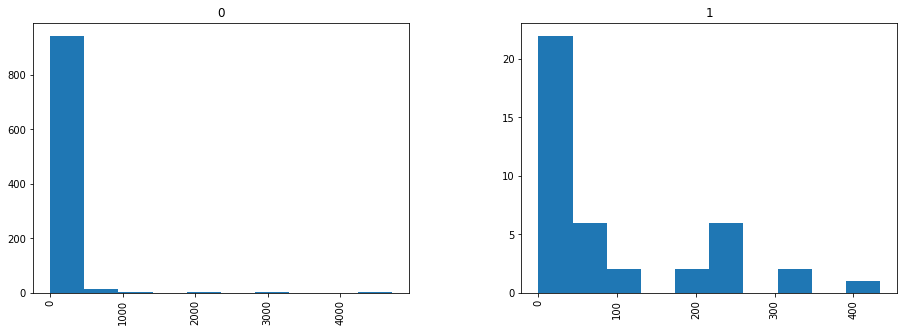

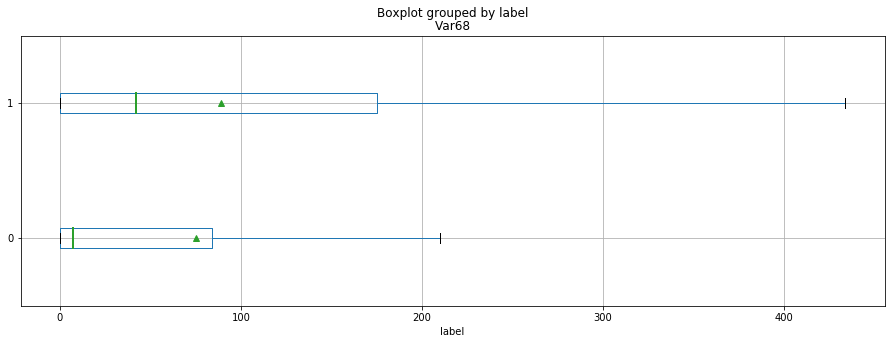

Correlation with label =  -0.060124060650348414
Name of feature: Var47
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var47, dtype: float64
mean:  label
0    2.482243
1    1.828571
Name: Var47, dtype: float64
std:  label
0    11.124052
1     5.848508
Name: Var47, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-2.58280374  1.70109479]


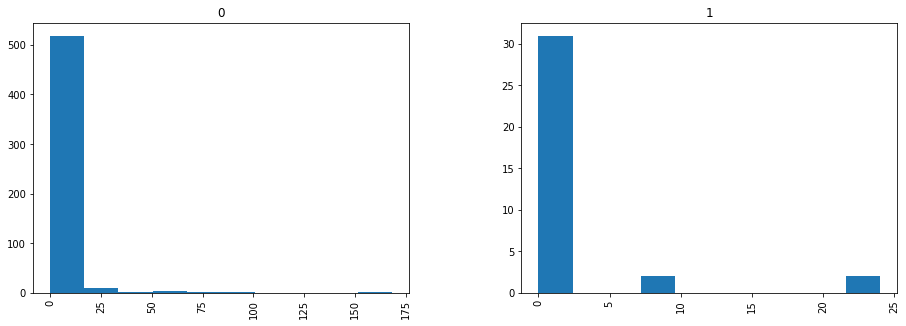

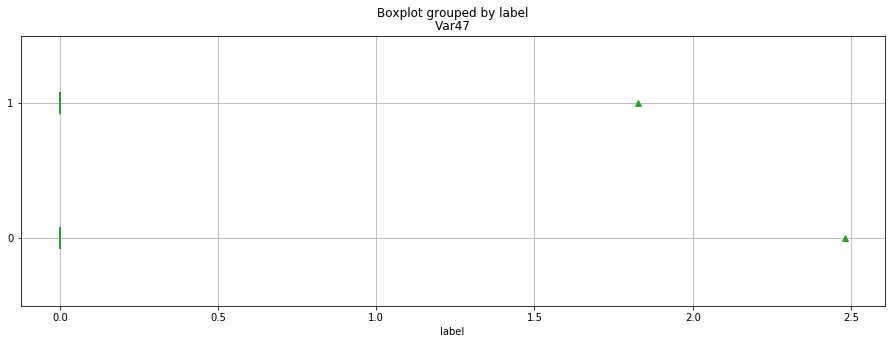

Correlation with label =  -0.06039093851804763
Name of feature: Var18
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var18, dtype: float64
mean:  label
0    6.585246
1    5.018182
Name: Var18, dtype: float64
std:  label
0    26.419878
1    11.240619
Name: Var18, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-4.59327496  1.83583458]


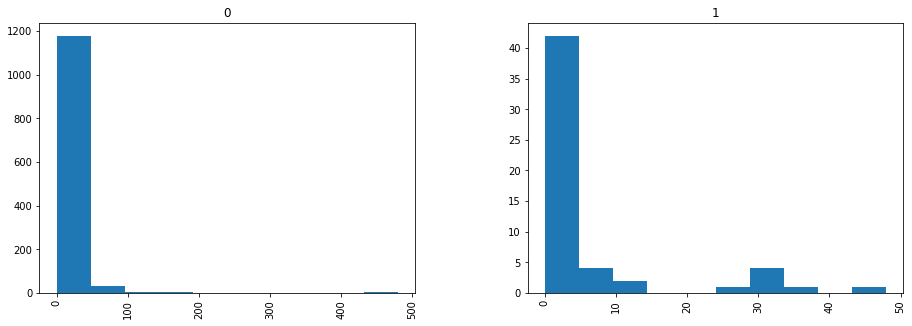

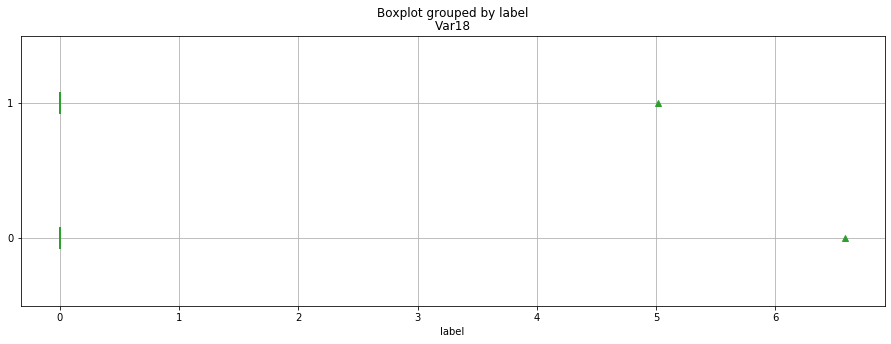

Correlation with label =  -0.060602131533588434
Name of feature: Var154
Count notna elements 0: 35, 1: 535
median:  label
0    351592.0
1    691200.0
Name: Var154, dtype: float64
mean:  label
0    1.611016e+06
1    1.469285e+06
Name: Var154, dtype: float64
std:  label
0    2.370606e+06
1    1.803563e+06
Name: Var154, dtype: float64
interval of delta medians:  [-383141.6 1662931.8]
interval of delta means:  [-742517.27108144  450883.54477971]


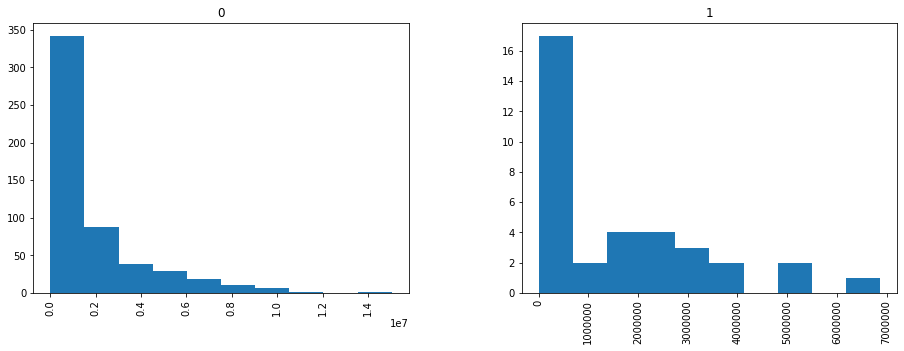

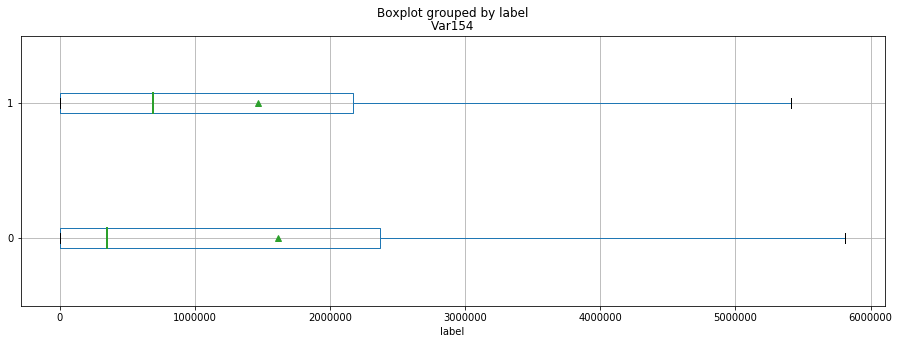

Correlation with label =  0.0623761743887504
Name of feature: Var62
Count notna elements 0: 30, 1: 434
median:  label
0    0.0
1    0.0
Name: Var62, dtype: float64
mean:  label
0    4.976959
1    6.600000
Name: Var62, dtype: float64
std:  label
0    26.553870
1    16.701435
Name: Var62, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-3.83917051  8.55698157]


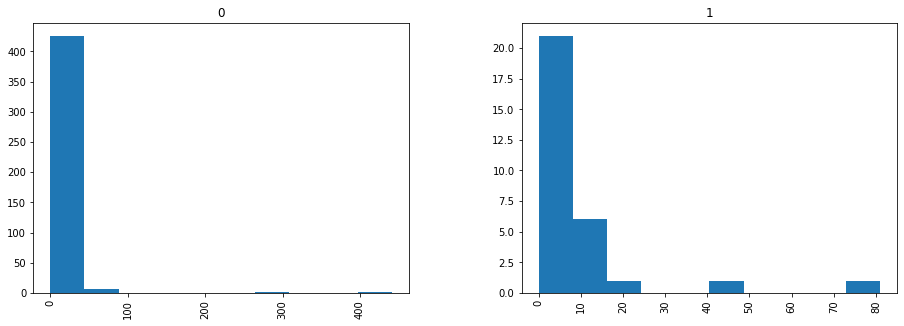

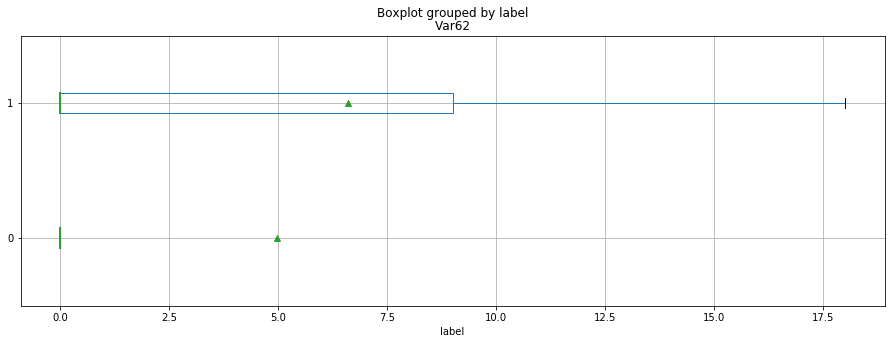

Correlation with label =  -0.06316559755642104
Name of feature: Var90
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var90, dtype: float64
mean:  label
0    0.026168
1    0.000000
Name: Var90, dtype: float64
std:  label
0    0.427592
1    0.000000
Name: Var90, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.06542056  0.        ]


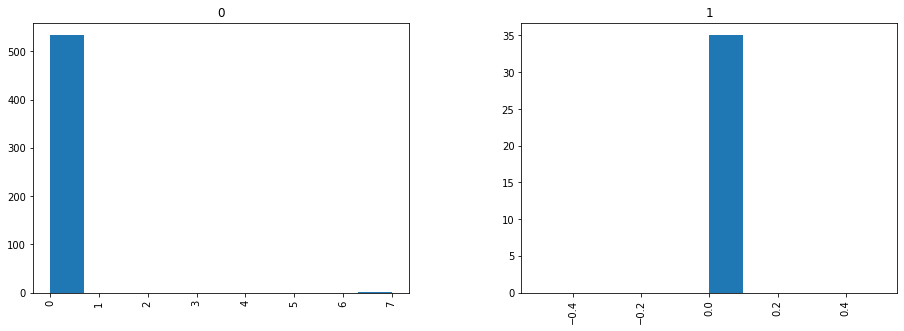

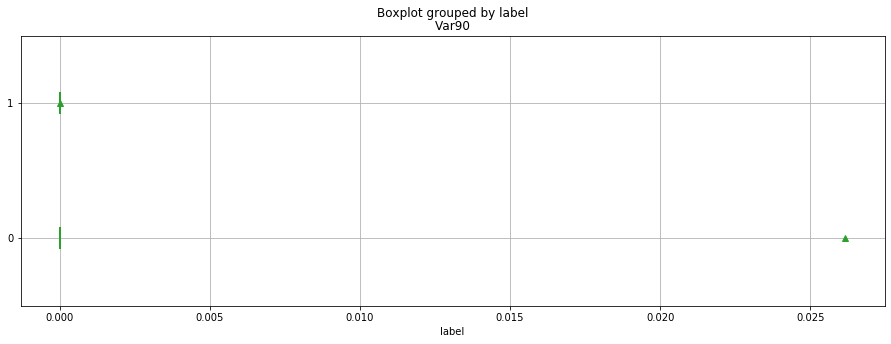

Correlation with label =  -0.06784805206267792
Name of feature: Var171
Count notna elements 0: 43, 1: 828
median:  label
0    165183.3
1    166287.6
Name: Var171, dtype: float64
mean:  label
0    374795.858405
1    333225.492279
Name: Var171, dtype: float64
std:  label
0    618676.836279
1    487534.751262
Name: Var171, dtype: float64
interval of delta medians:  [-113417.83125  188087.4    ]
interval of delta means:  [-182013.74064665  116826.62728164]


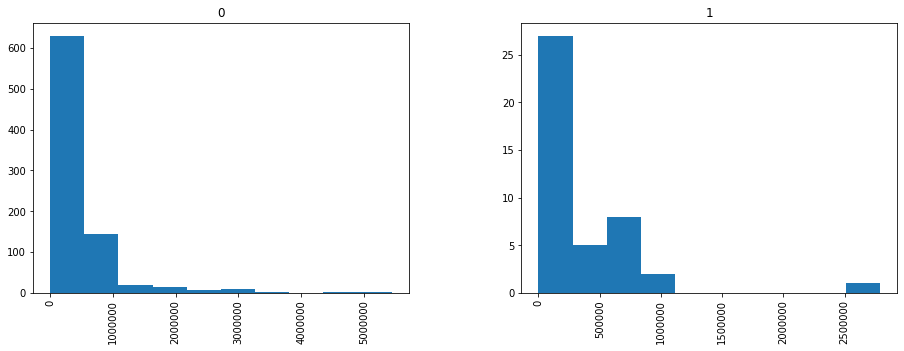

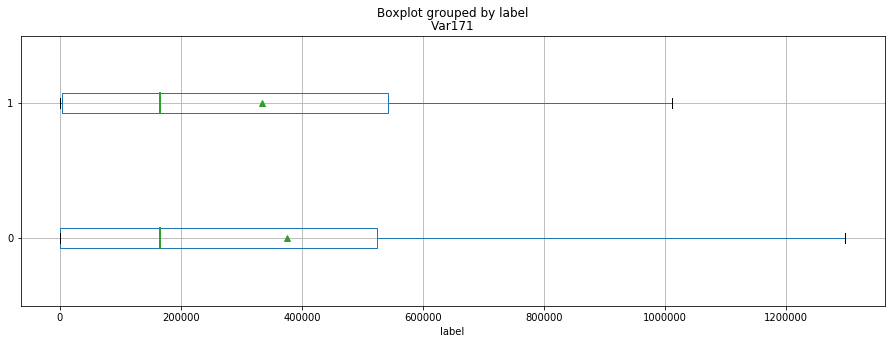

Correlation with label =  0.0679072967880103
Name of feature: Var183
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var183, dtype: float64
mean:  label
0    80083.852850
1    94627.219512
Name: Var183, dtype: float64
std:  label
0    216189.720231
1    160642.266806
Name: Var183, dtype: float64
interval of delta medians:  [    0.   50149.25]
interval of delta means:  [-31791.84060028  66620.03951599]


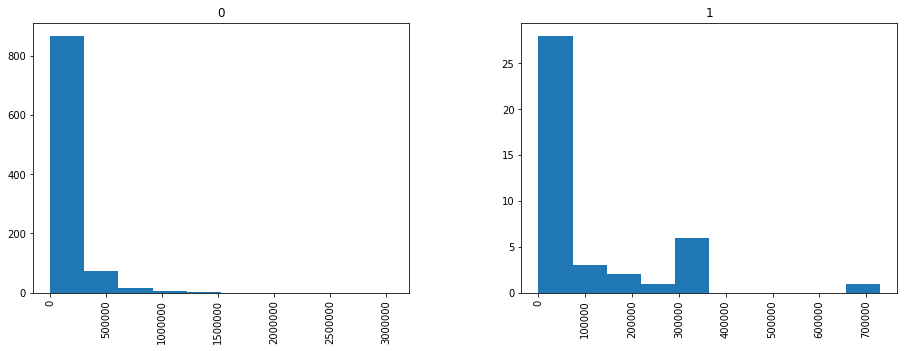

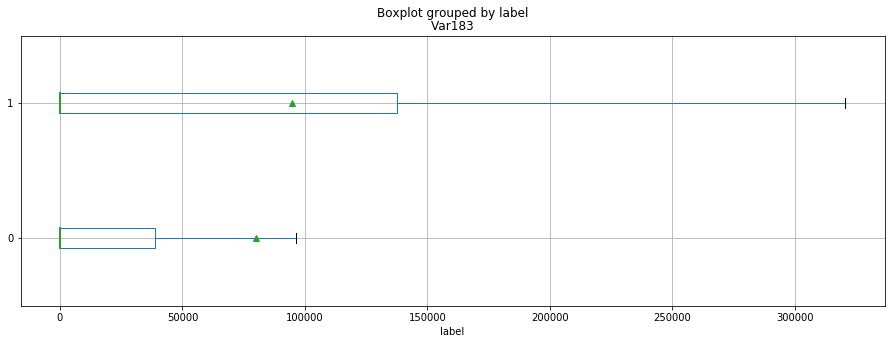

Correlation with label =  -0.06893883091542999
Name of feature: Var67
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var67, dtype: float64
mean:  label
0    0.022543
1    0.000000
Name: Var67, dtype: float64
std:  label
0    0.335123
1    0.000000
Name: Var67, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.04508566 -0.00450857]


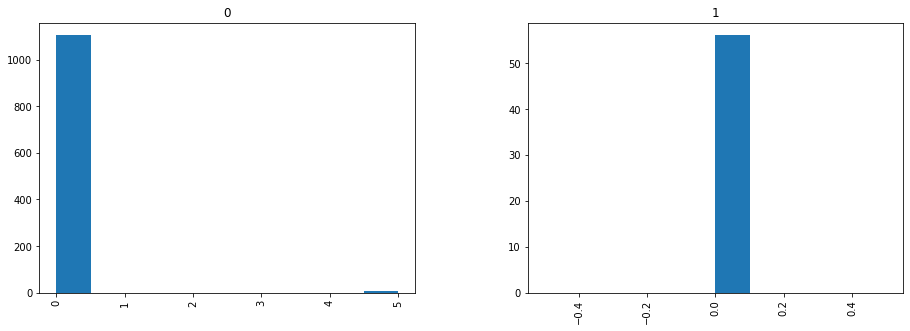

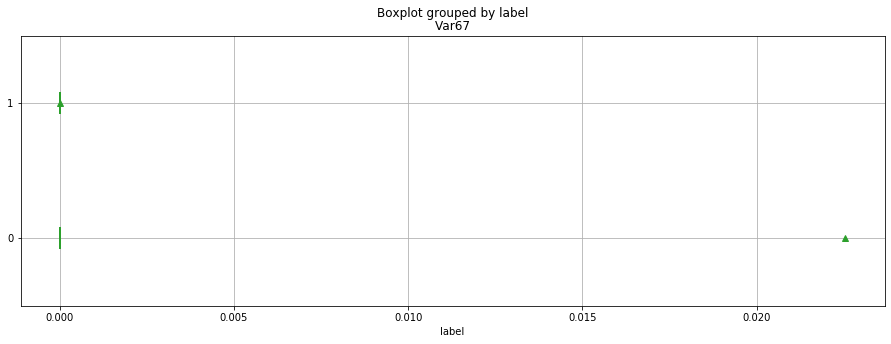

Correlation with label =  -0.06959976404166808
Name of feature: Var165
Count notna elements 0: 33, 1: 667
median:  label
0    0.0
1    0.0
Name: Var165, dtype: float64
mean:  label
0    30410.779610
1    22179.939394
Name: Var165, dtype: float64
std:  label
0    120413.477954
1     60470.354878
Name: Var165, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-27725.17611649  16900.31507201]


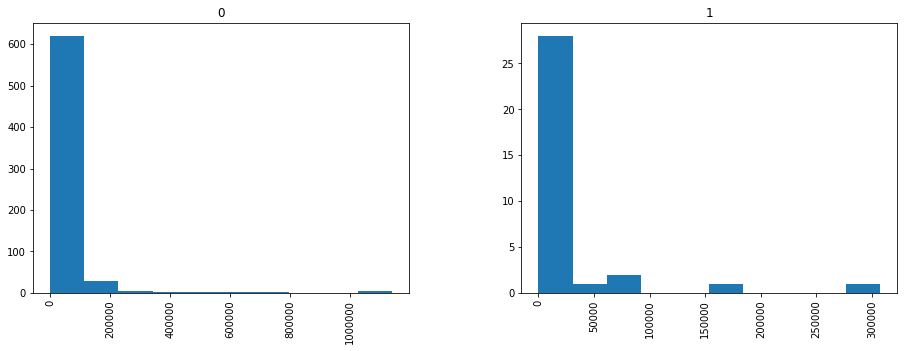

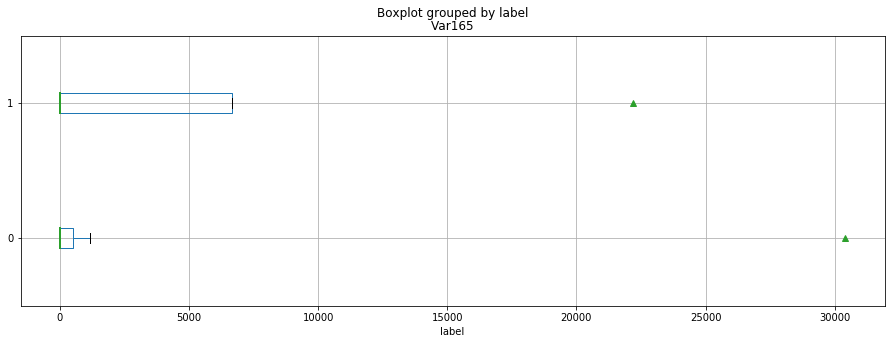

Correlation with label =  0.07097346016013449
Name of feature: Var170
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var170, dtype: float64
mean:  label
0    2.281865
1    2.780488
Name: Var170, dtype: float64
std:  label
0    7.121160
1    4.210179
Name: Var170, dtype: float64
interval of delta medians:  [0. 3.]
interval of delta means:  [-0.78492102  1.85918868]


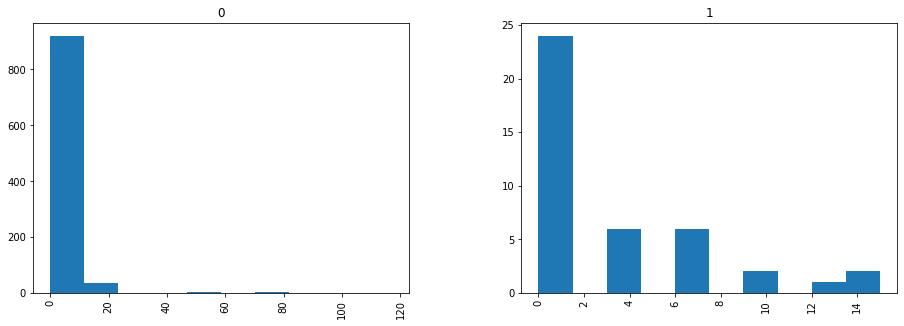

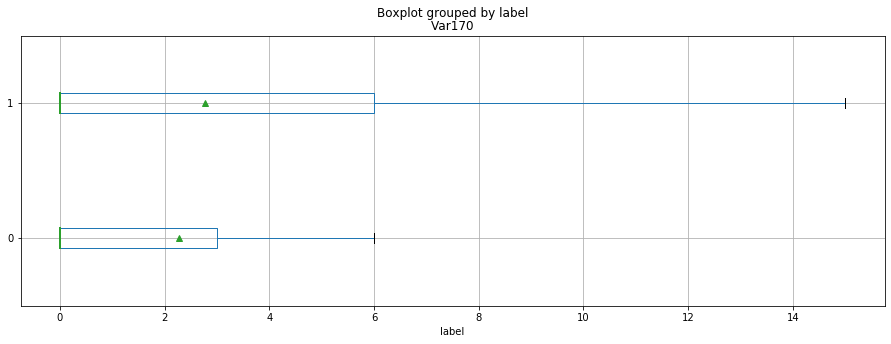

Correlation with label =  -0.07187242379454312
Name of feature: Var23
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var23, dtype: float64
mean:  label
0    7.357980
1    3.839286
Name: Var23, dtype: float64
std:  label
0    50.116821
1    10.702212
Name: Var23, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-8.03852006  0.02392358]


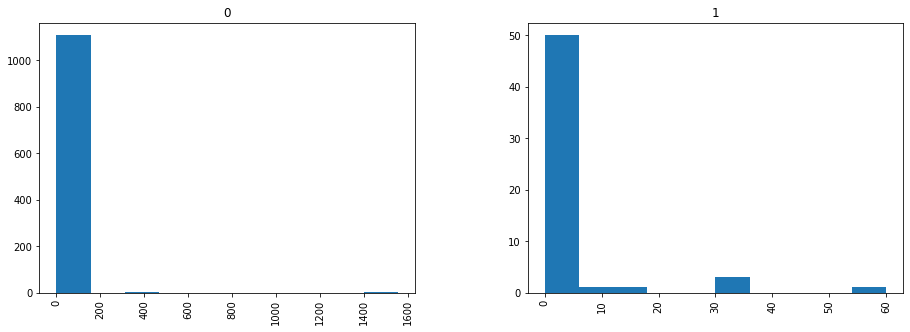

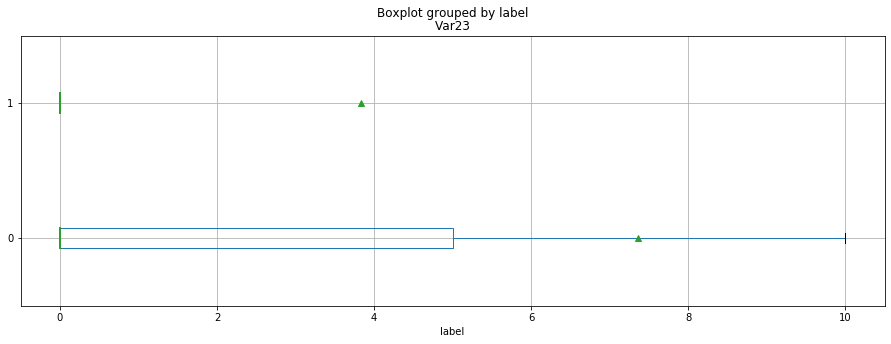

Correlation with label =  -0.07278482387672311
Name of feature: Var157
Count notna elements 0: 41, 1: 849
median:  label
0    8.0
1    4.0
Name: Var157, dtype: float64
mean:  label
0    33.540636
1    19.219512
Name: Var157, dtype: float64
std:  label
0    201.261168
1     38.711440
Name: Var157, dtype: float64
interval of delta medians:  [-8.  0.]
interval of delta means:  [-32.78007125   3.04611451]


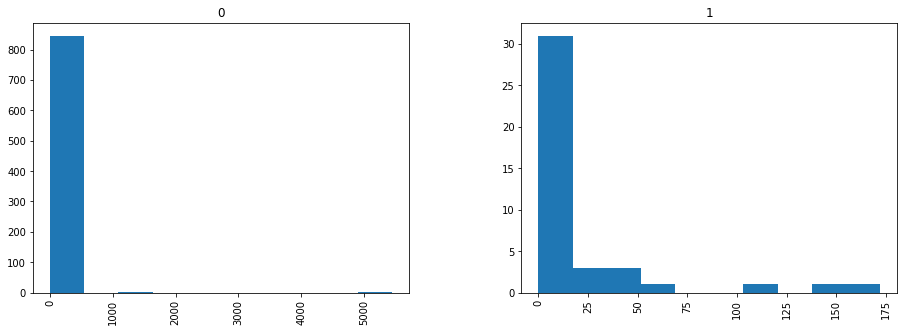

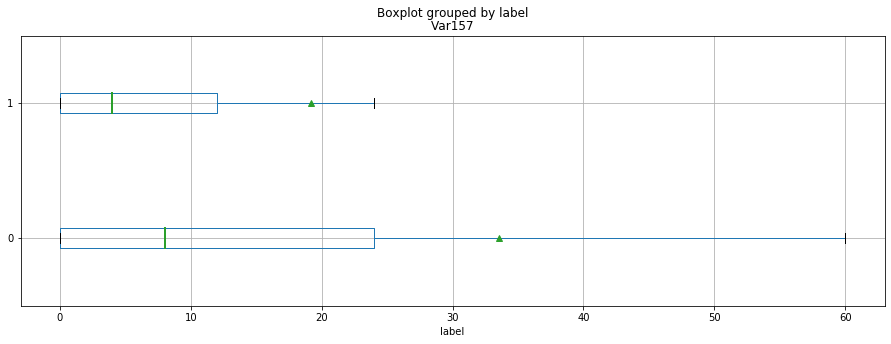

Correlation with label =  -0.07384480903981862
Name of feature: Var56
Count notna elements 0: 27, 1: 497
median:  label
0    0.0
1    0.0
Name: Var56, dtype: float64
mean:  label
0    98033.158954
1    75938.333333
Name: Var56, dtype: float64
std:  label
0    304426.028772
1    179939.584492
Name: Var56, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-86970.98343766  50534.54823385]


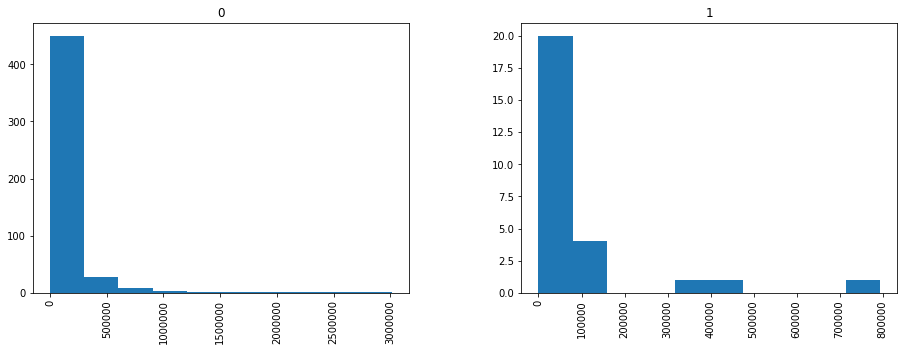

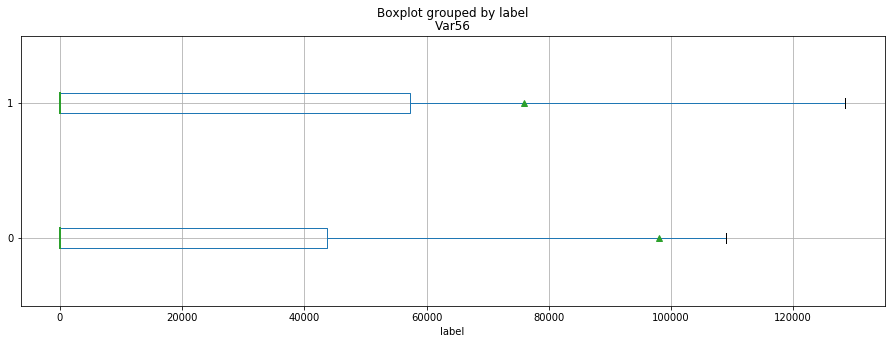

Correlation with label =  -0.07464902369052881
Name of feature: Var137
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var137, dtype: float64
mean:  label
0    3.857944
1    3.085714
Name: Var137, dtype: float64
std:  label
0    10.443822
1     8.789604
Name: Var137, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-3.47674232  2.43703605]


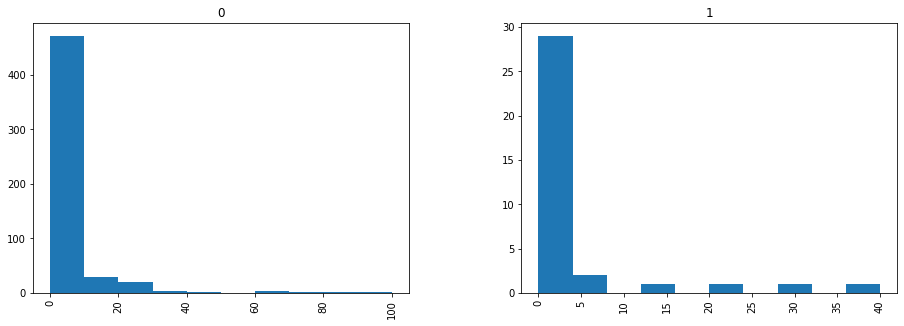

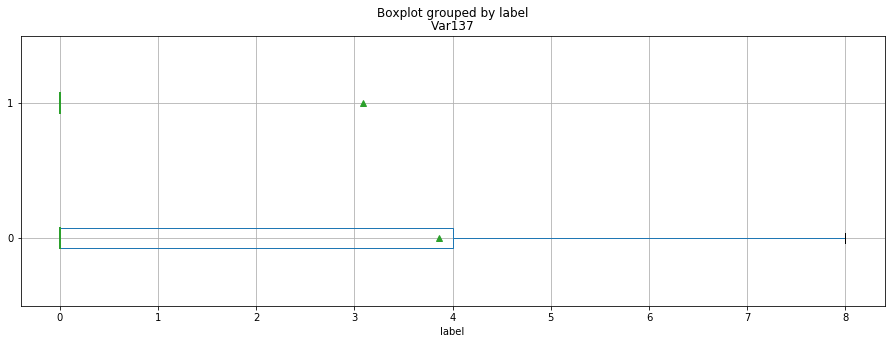

Correlation with label =  -0.07534588747076279
Name of feature: Var61
Count notna elements 0: 33, 1: 627
median:  label
0    16.0
1     8.0
Name: Var61, dtype: float64
mean:  label
0    40.791069
1    26.181818
Name: Var61, dtype: float64
std:  label
0    198.690633
1     41.678423
Name: Var61, dtype: float64
interval of delta medians:  [-16.   8.]
interval of delta means:  [-34.85901116   4.64848485]


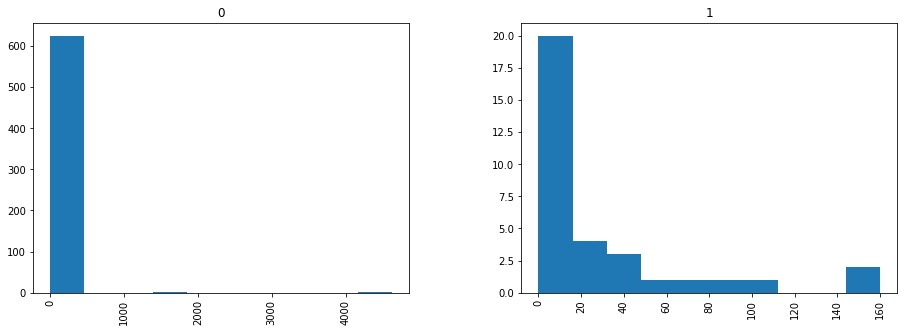

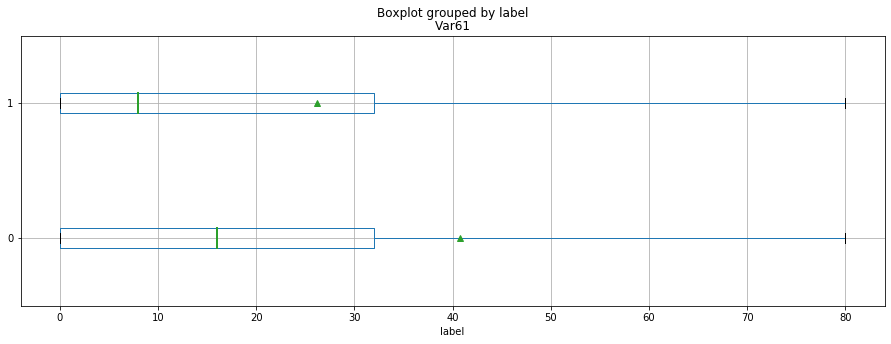

Correlation with label =  -0.07856423653758682
Name of feature: Var101
Count notna elements 0: 33, 1: 667
median:  label
0    0.0
1    0.0
Name: Var101, dtype: float64
mean:  label
0    19.430285
1    13.090909
Name: Var101, dtype: float64
std:  label
0    82.553536
1    18.566374
Name: Var101, dtype: float64
interval of delta medians:  [-9.  9.]
interval of delta means:  [-15.11423266   2.35841625]


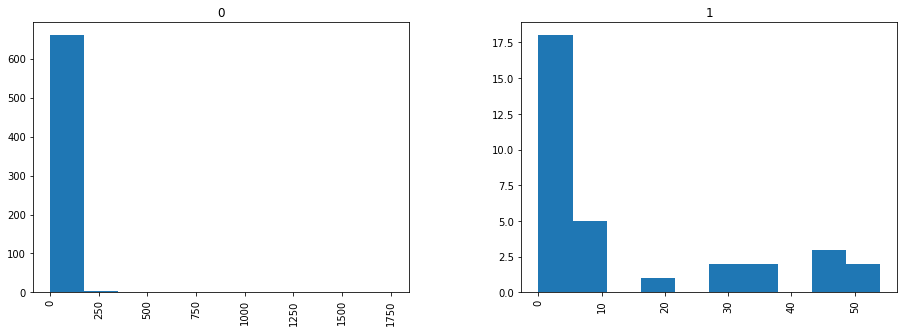

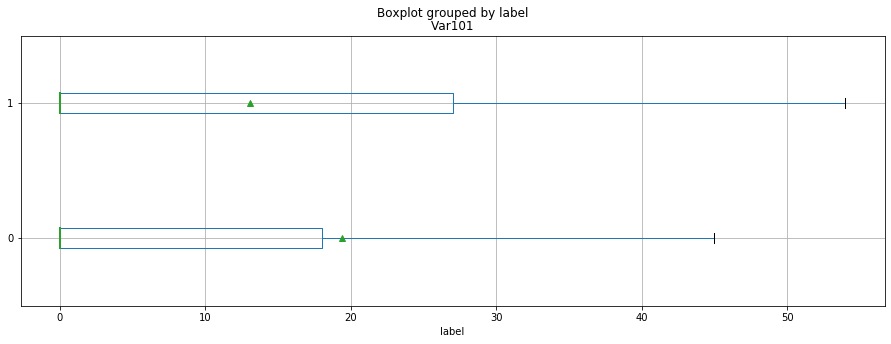

Correlation with label =  -0.07872670479709952
Name of feature: Var6
Count notna elements 0: 2759, 1: 32806
median:  label
0    861.0
1    791.0
Name: Var6, dtype: float64
mean:  label
0    1335.855240
1    1130.382022
Name: Var6, dtype: float64
std:  label
0    2617.494085
1    2511.307353
Name: Var6, dtype: float64
interval of delta medians:  [-91. -49.]
interval of delta means:  [-291.47439727 -103.54036818]


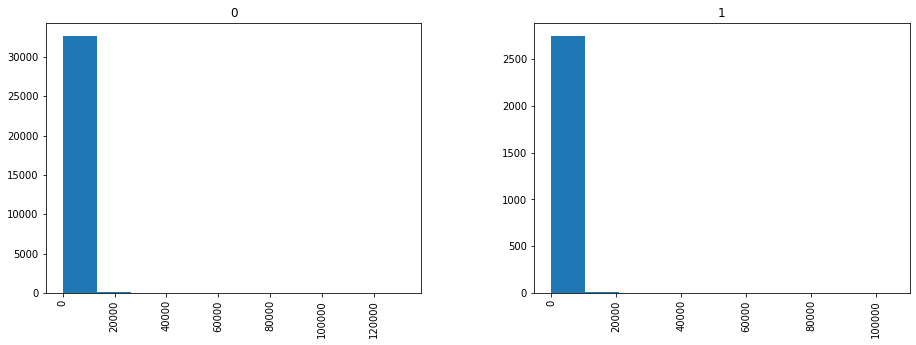

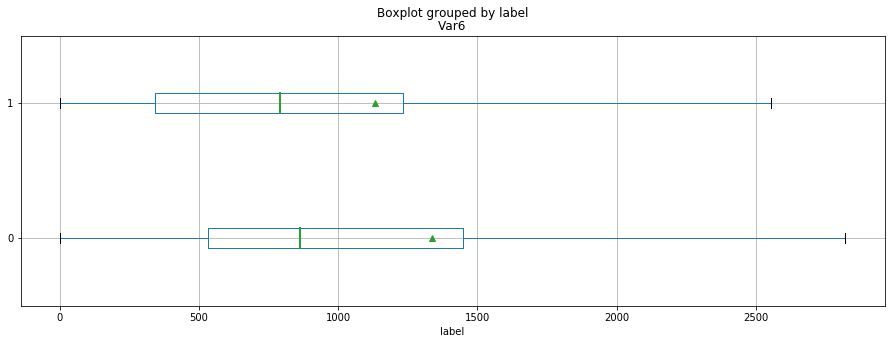

Correlation with label =  0.07912304882781486
Name of feature: Var184
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var184, dtype: float64
mean:  label
0     7.307772
1    10.048780
Name: Var184, dtype: float64
std:  label
0    35.225439
1    15.520875
Name: Var184, dtype: float64
interval of delta medians:  [0. 4.]
interval of delta means:  [-1.97907999  7.97248578]


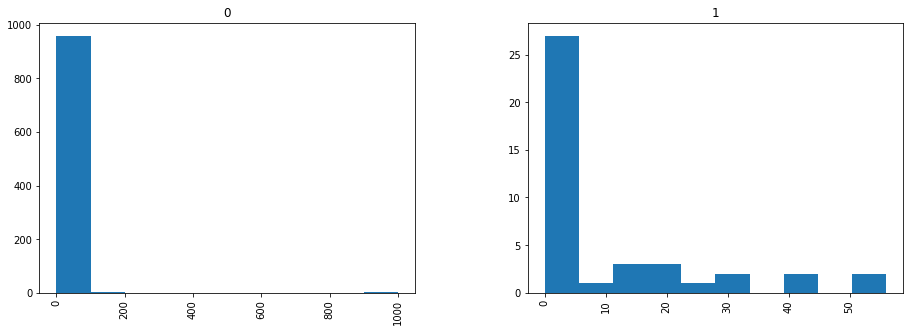

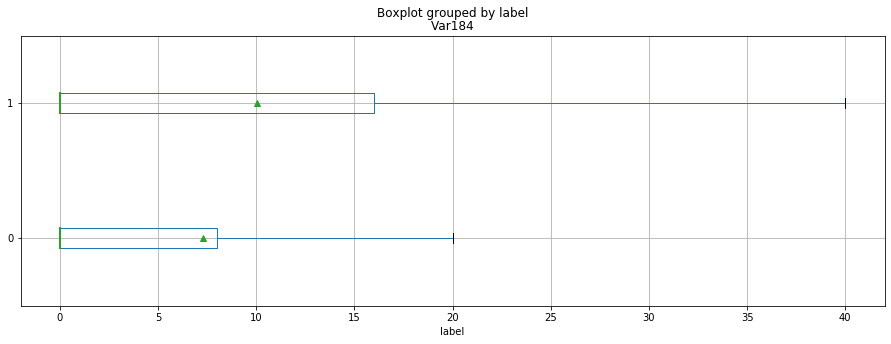

Correlation with label =  -0.07963634845181103
Name of feature: Var151
Count notna elements 0: 33, 1: 627
median:  label
0    0.0
1    0.0
Name: Var151, dtype: float64
mean:  label
0    10.577352
1     6.545455
Name: Var151, dtype: float64
std:  label
0    51.815275
1    15.805638
Name: Var151, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-10.76937799   2.97607656]


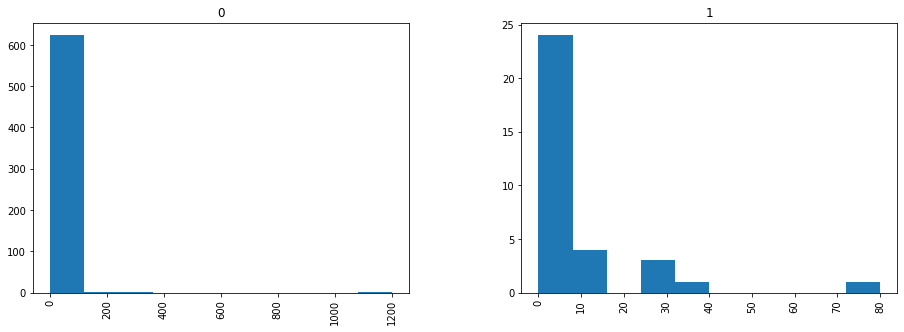

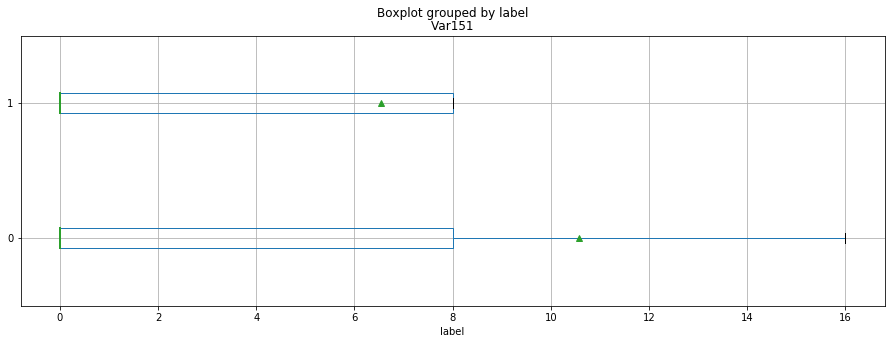

Correlation with label =  -0.08156666588456012
Name of feature: Var127
Count notna elements 0: 43, 1: 828
median:  label
0    0.0
1    0.0
Name: Var127, dtype: float64
mean:  label
0    26.502415
1    17.674419
Name: Var127, dtype: float64
std:  label
0    110.787000
1     29.859768
Name: Var127, dtype: float64
interval of delta medians:  [0. 8.]
interval of delta means:  [-21.12641276   2.5563139 ]


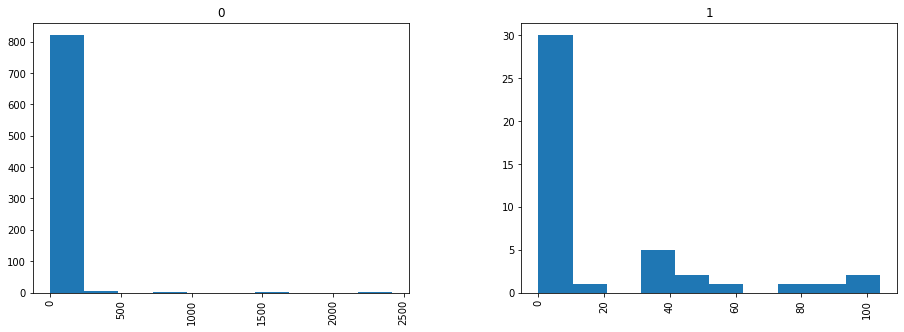

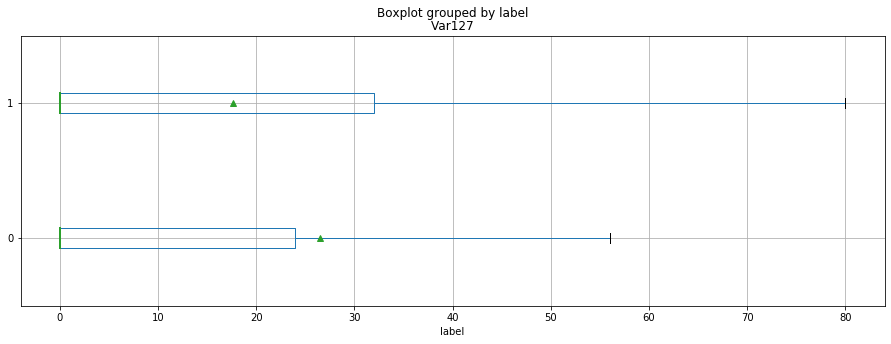

Correlation with label =  -0.08431086740677843
Name of feature: Var172
Count notna elements 0: 56, 1: 1109
median:  label
0    7.0
1    7.0
Name: Var172, dtype: float64
mean:  label
0    9.884581
1    9.000000
Name: Var172, dtype: float64
std:  label
0    10.532965
1     9.691608
Name: Var172, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-3.48304497  1.78144725]


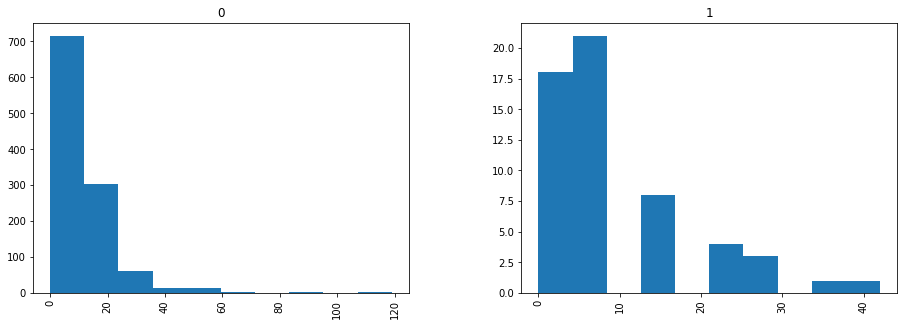

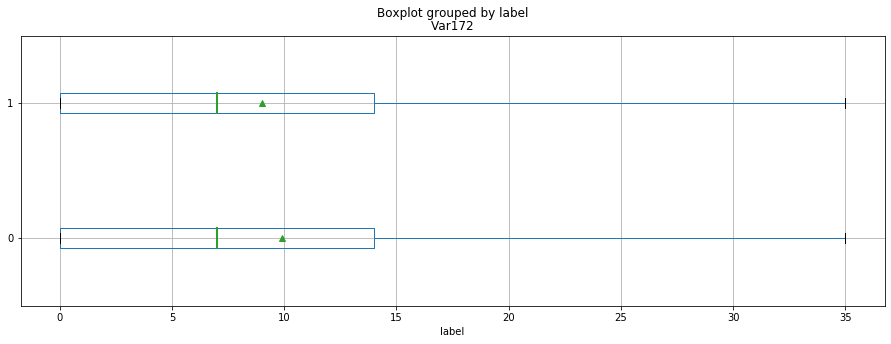

Correlation with label =  0.0850997900050232
Name of feature: Var180
Count notna elements 0: 35, 1: 535
median:  label
0    2419200.0
1    4194547.0
Name: Var180, dtype: float64
mean:  label
0    3.804263e+06
1    4.124426e+06
Name: Var180, dtype: float64
std:  label
0    3.773843e+06
1    3.618580e+06
Name: Var180, dtype: float64
interval of delta medians:  [-1192453.325  2900435.825]
interval of delta means:  [-845353.76182243 1551551.25383178]


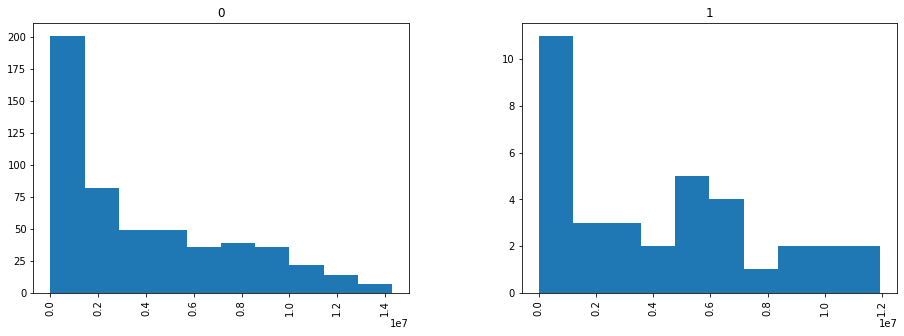

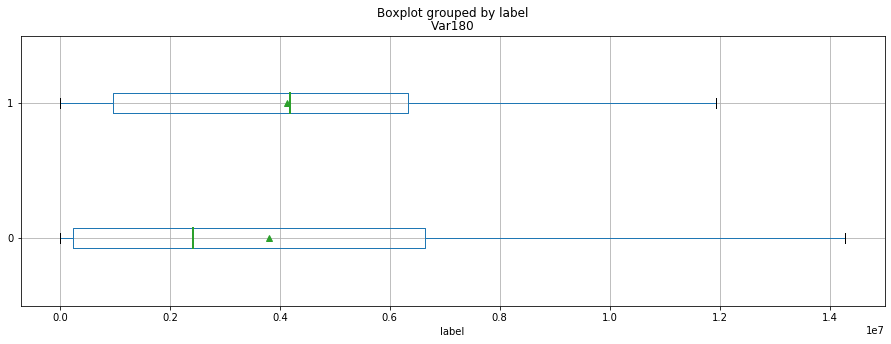

Correlation with label =  -0.08657576672898042
Name of feature: Var80
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var80, dtype: float64
mean:  label
0    58631.469793
1    40919.946429
Name: Var80, dtype: float64
std:  label
0    207120.128000
1    145697.139062
Name: Var80, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-50916.40156592  27760.95324738]


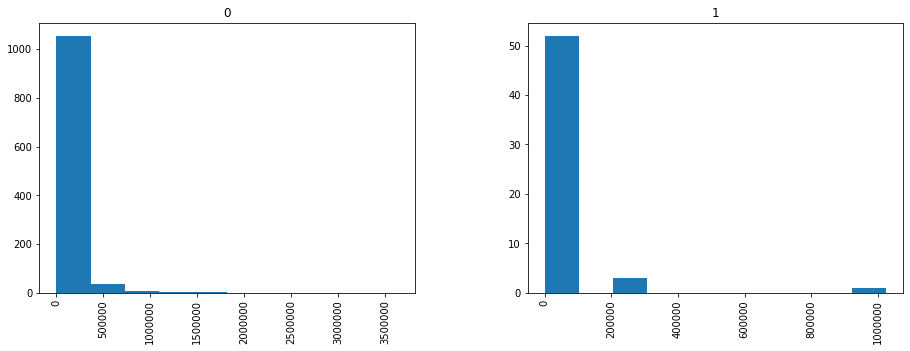

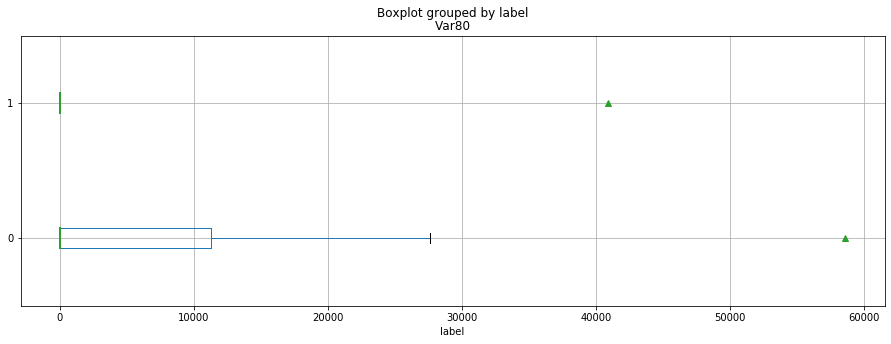

Correlation with label =  -0.08703762467534905
Name of feature: Var88
Count notna elements 0: 43, 1: 828
median:  label
0    20.0
1    25.0
Name: Var88, dtype: float64
mean:  label
0    65.966184
1    46.162791
Name: Var88, dtype: float64
std:  label
0    232.910134
1     61.748696
Name: Var88, dtype: float64
interval of delta medians:  [-10.  20.]
interval of delta means:  [-43.5559593    3.28352151]


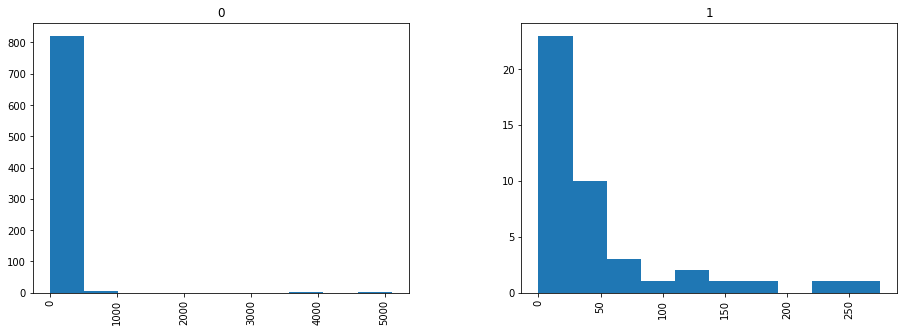

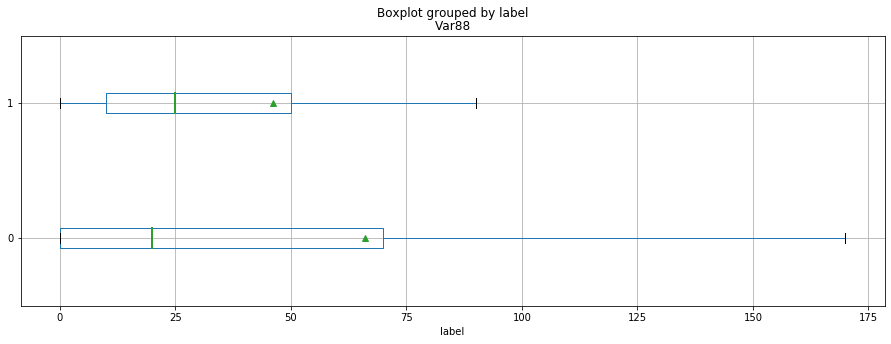

Correlation with label =  -0.08829895806855448
Name of feature: Var84
Count notna elements 0: 41, 1: 964
median:  label
0    0.0
1    0.0
Name: Var84, dtype: float64
mean:  label
0    44.143154
1    21.756098
Name: Var84, dtype: float64
std:  label
0    258.549369
1     60.006991
Name: Var84, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-45.87799438   5.61545137]


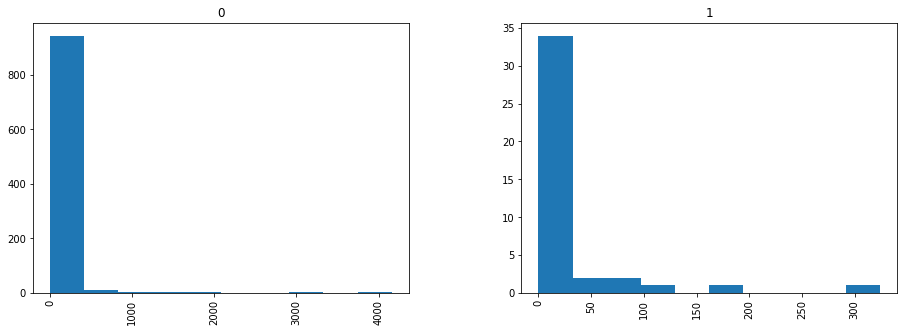

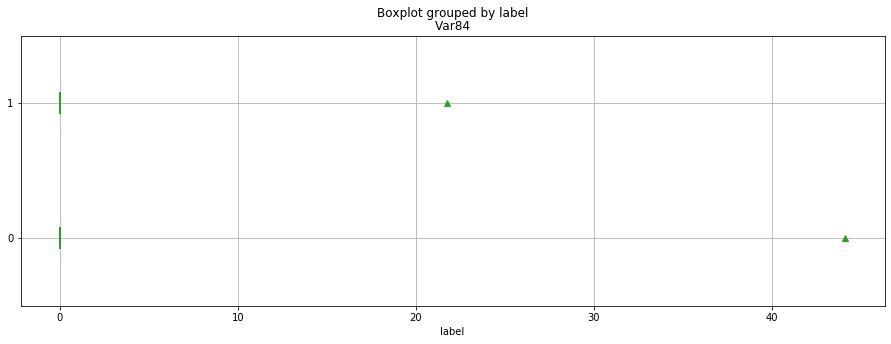

Correlation with label =  0.08846724198132491
Name of feature: Var86
Count notna elements 0: 35, 1: 535
median:  label
0     54540.0
1    170966.0
Name: Var86, dtype: float64
mean:  label
0    289040.986916
1    329655.657143
Name: Var86, dtype: float64
std:  label
0    461411.327621
1    426439.985156
Name: Var86, dtype: float64
interval of delta medians:  [-28362.55 369895.35]
interval of delta means:  [-99830.12504673 200538.8882777 ]


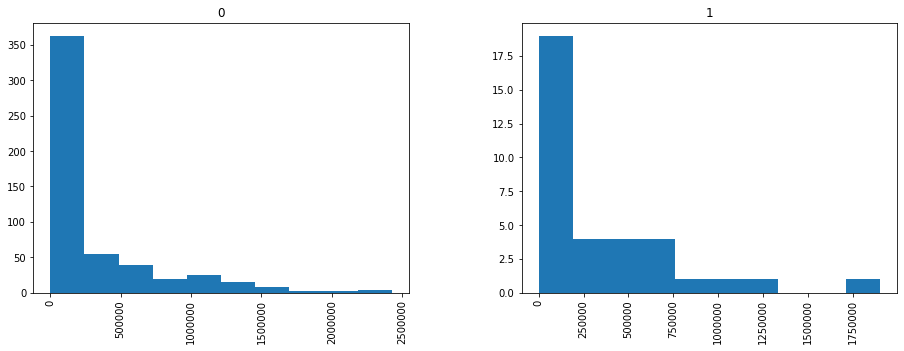

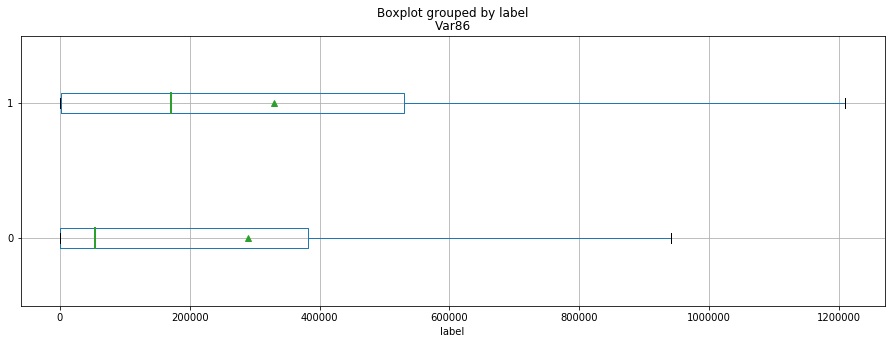

Correlation with label =  0.09008953588606469
Name of feature: Var87
Count notna elements 0: 35, 1: 535
median:  label
0    7.0
1    7.0
Name: Var87, dtype: float64
mean:  label
0    5.325234
1    5.800000
Name: Var87, dtype: float64
std:  label
0    5.328077
1    4.323669
Name: Var87, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.96098131  1.99317757]


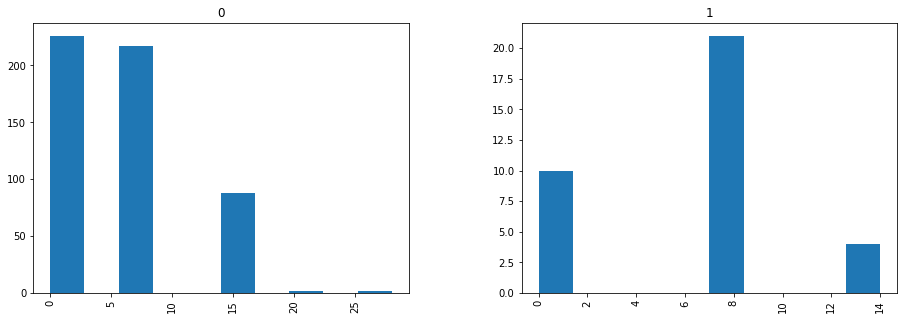

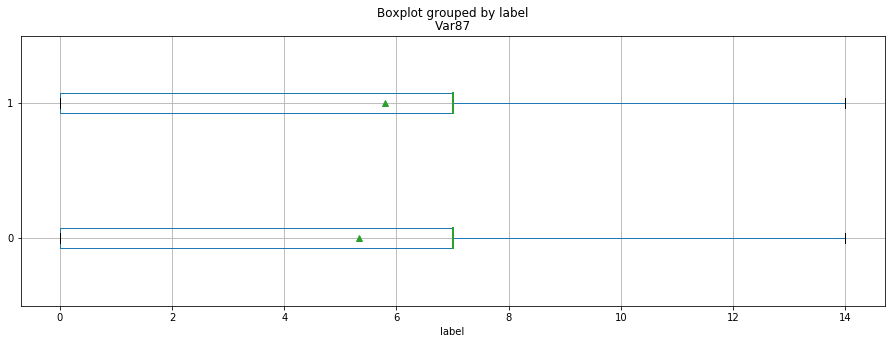

Correlation with label =  -0.0944055072567644
Name of feature: Var120
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    3.0
Name: Var120, dtype: float64
mean:  label
0    31.812444
1    20.250000
Name: Var120, dtype: float64
std:  label
0    125.235666
1     37.067138
Name: Var120, dtype: float64
interval of delta medians:  [ 0.    15.075]
interval of delta means:  [-23.91109751   0.68430375]


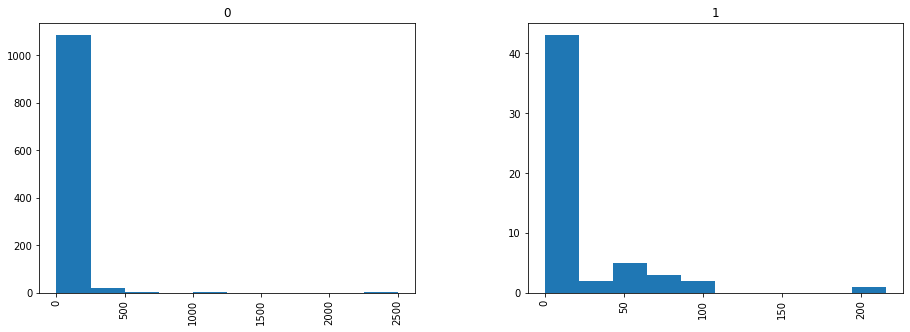

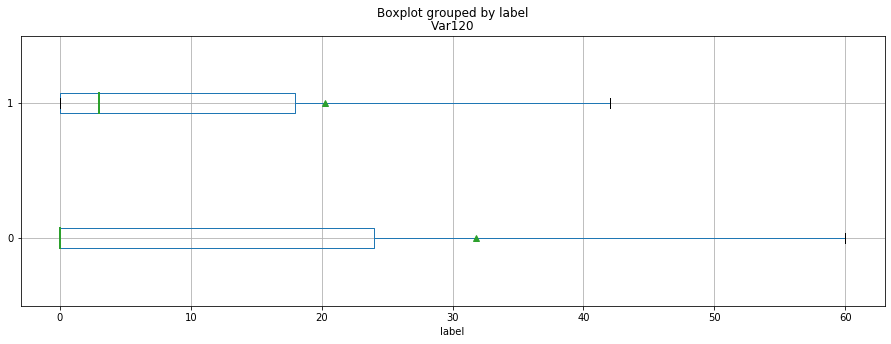

Correlation with label =  -0.09681490856748229
Name of feature: Var71
Count notna elements 0: 41, 1: 849
median:  label
0    42.0
1    36.0
Name: Var71, dtype: float64
mean:  label
0    138.657244
1     85.024390
Name: Var71, dtype: float64
std:  label
0    566.341367
1    134.129879
Name: Var71, dtype: float64
interval of delta medians:  [-30.  30.]
interval of delta means:  [-110.27704473    0.71857278]


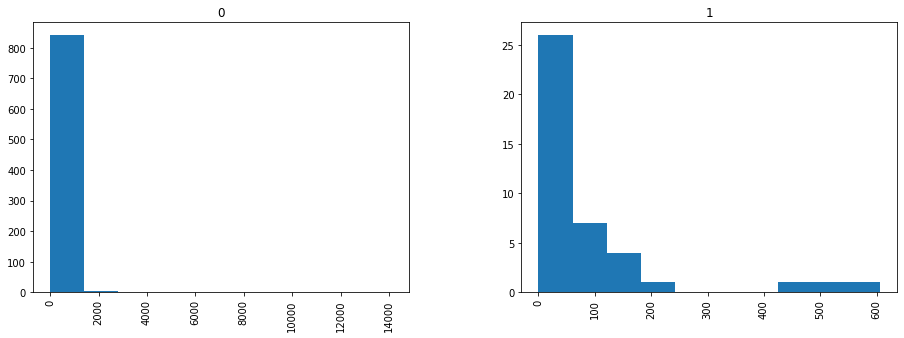

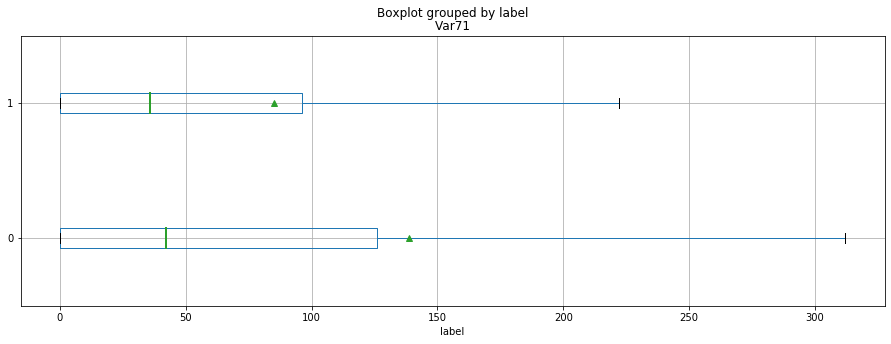

Correlation with label =  0.0972848733418727
Name of feature: Var69
Count notna elements 0: 56, 1: 1109
median:  label
0     421812.0
1    1711548.0
Name: Var69, dtype: float64
mean:  label
0    3.515753e+06
1    3.996612e+06
Name: Var69, dtype: float64
std:  label
0    4.928277e+06
1    5.247539e+06
Name: Var69, dtype: float64
interval of delta medians:  [-582291.    3442407.075]
interval of delta means:  [-828656.22293411 1858809.95812911]


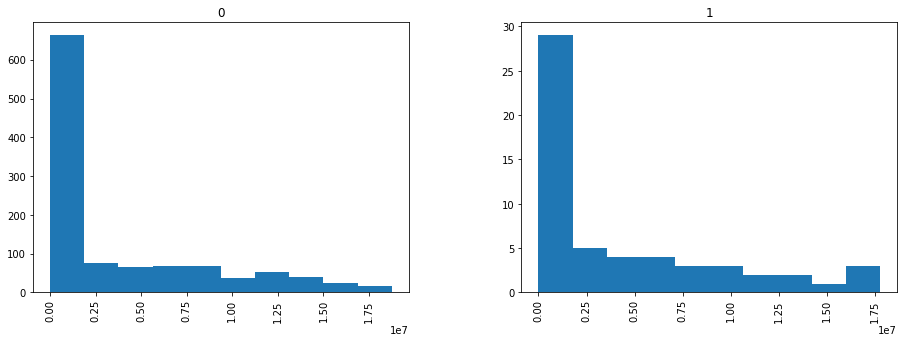

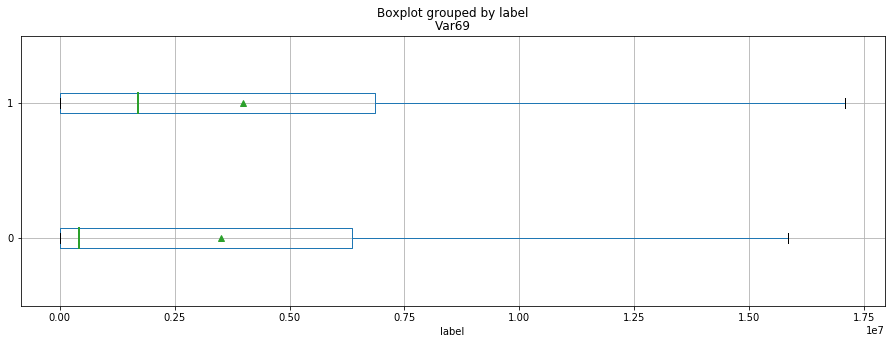

Correlation with label =  -0.098754395054455
Name of feature: Var108
Count notna elements 0: 35, 1: 535
median:  label
0    12620.0
1        0.0
Name: Var108, dtype: float64
mean:  label
0    192573.674766
1    147415.200000
Name: Var108, dtype: float64
std:  label
0    468445.332468
1    225739.596935
Name: Var108, dtype: float64
interval of delta medians:  [-25936. 143888.]
interval of delta means:  [-120070.9329773    42711.37108144]


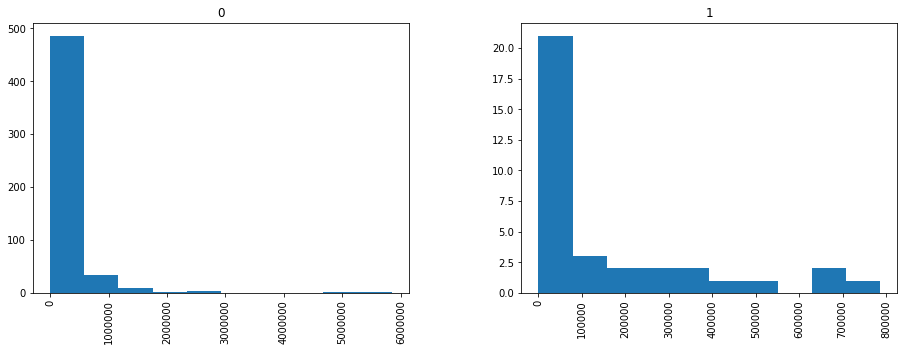

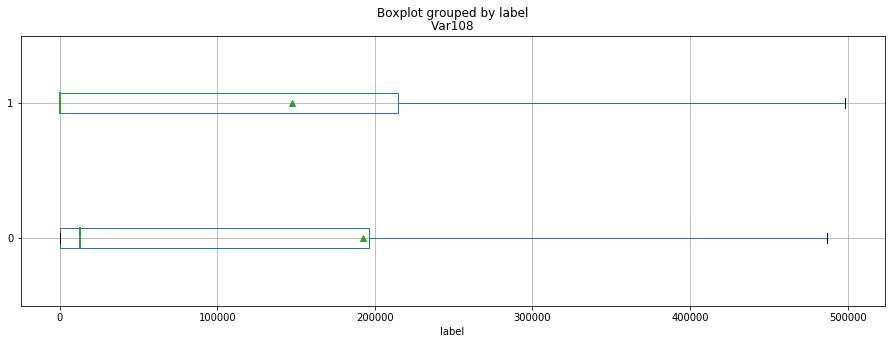

Correlation with label =  -0.09900867126671424
Name of feature: Var5
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var5, dtype: float64
mean:  label
0    252273.706041
1    185323.839286
Name: Var5, dtype: float64
std:  label
0    682555.187996
1    536018.139881
Name: Var5, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-196861.99496812  106854.1289611 ]


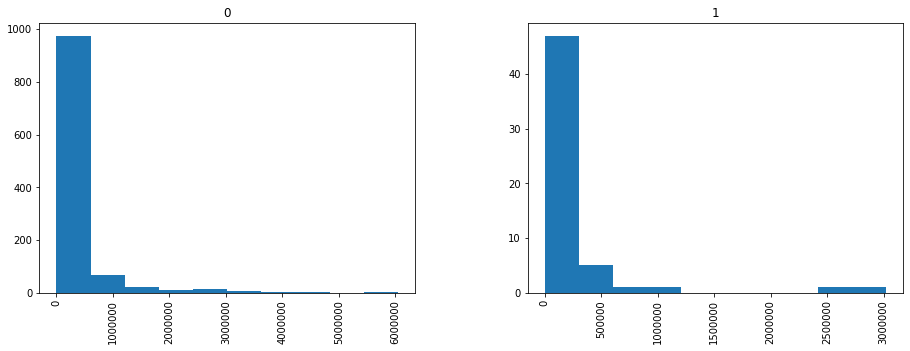

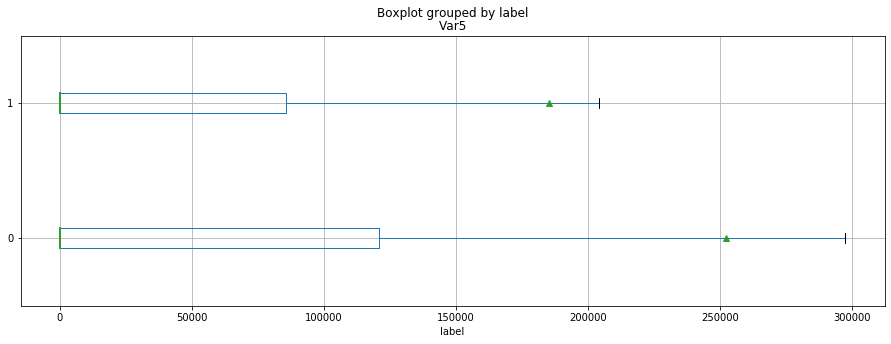

Correlation with label =  -0.10013837907754408
Name of feature: Var29
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var29, dtype: float64
mean:  label
0    0.018692
1    0.000000
Name: Var29, dtype: float64
std:  label
0    0.192622
1    0.000000
Name: Var29, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.03738318 -0.00373832]


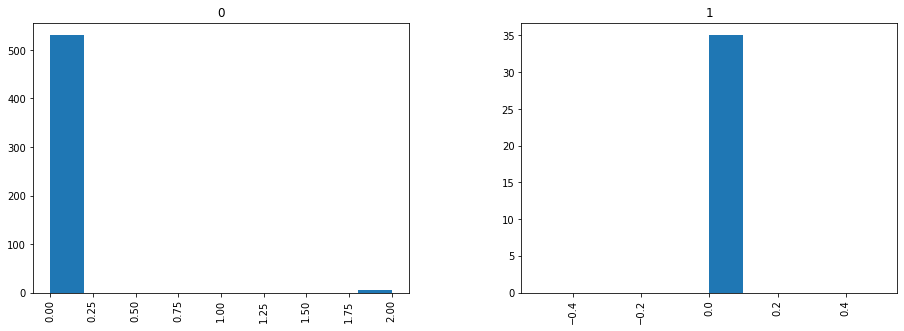

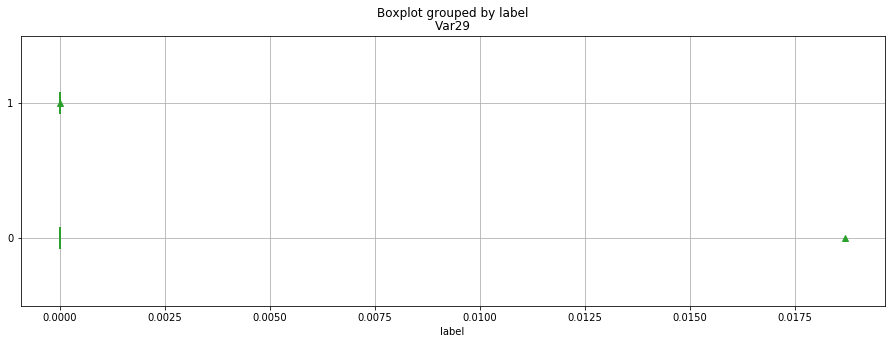

Correlation with label =  0.10131477682191595
Name of feature: Var152
Count notna elements 0: 55, 1: 1220
median:  label
0    6.0
1    6.0
Name: Var152, dtype: float64
mean:  label
0    8.360656
1    9.272727
Name: Var152, dtype: float64
std:  label
0     8.938093
1    10.380635
Name: Var152, dtype: float64
interval of delta medians:  [0. 6.]
interval of delta means:  [-1.67756334  3.84741058]


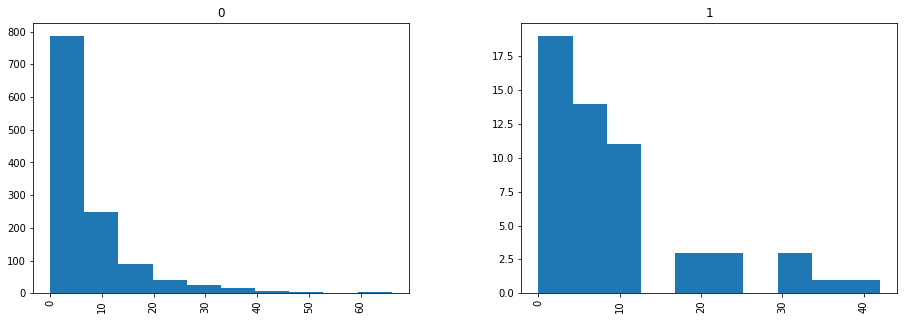

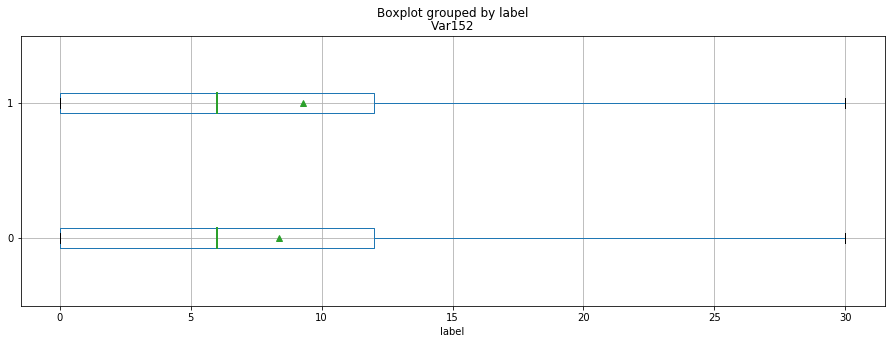

Correlation with label =  -0.10715881714148909
Name of feature: Var140
Count notna elements 0: 2745, 1: 32815
median:  label
0    240.0
1     45.0
Name: Var140, dtype: float64
mean:  label
0    1413.742953
1     967.540984
Name: Var140, dtype: float64
std:  label
0    4275.354235
1    2432.277035
Name: Var140, dtype: float64
interval of delta medians:  [-215. -175.]
interval of delta means:  [-550.27955515 -342.64996228]


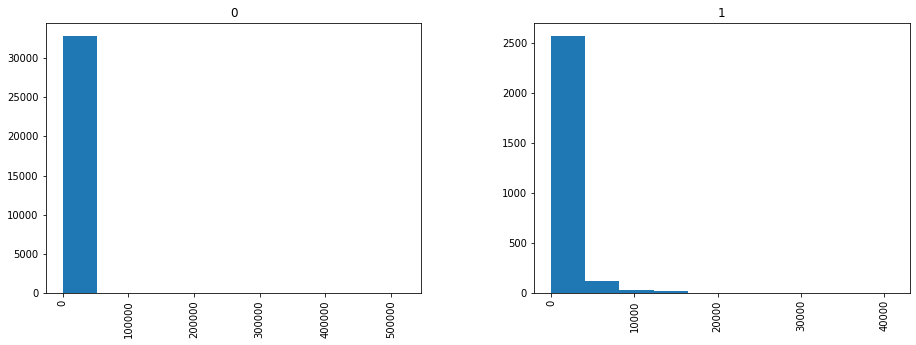

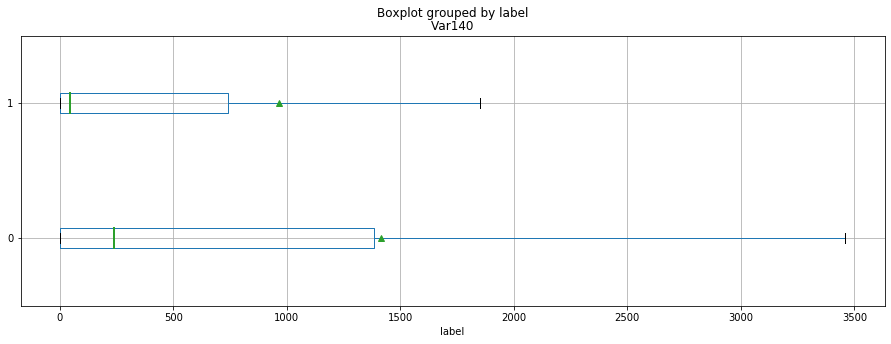

Correlation with label =  0.10879190966610588
Name of feature: Var10
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var10, dtype: float64
mean:  label
0    376455.246168
1    478212.107143
Name: Var10, dtype: float64
std:  label
0    9.261294e+05
1    1.107214e+06
Name: Var10, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-152363.35499324  431542.09254195]


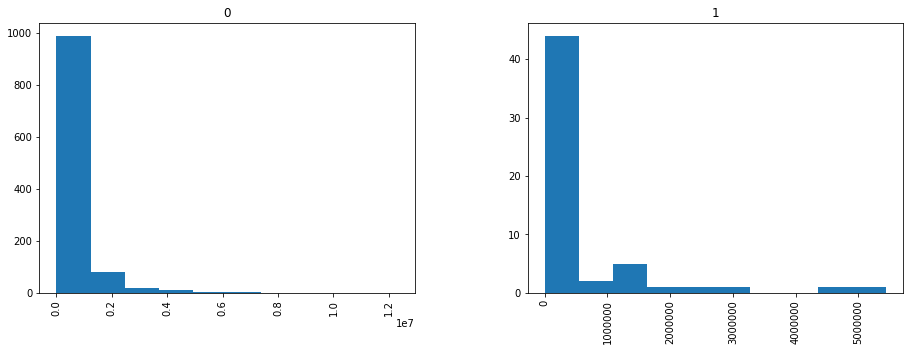

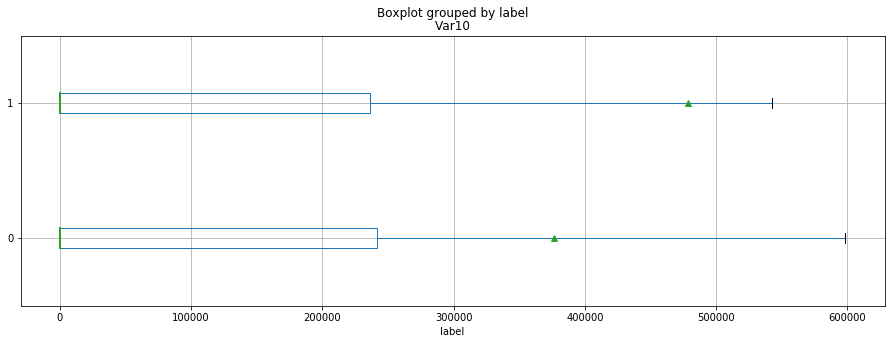

Correlation with label =  -0.1134304087314651
Name of feature: Var45
Count notna elements 0: 15, 1: 269
median:  label
0    4044.08
1    6142.18
Name: Var45, dtype: float64
mean:  label
0    7211.155836
1    6250.570667
Name: Var45, dtype: float64
std:  label
0    8582.128455
1    6229.991620
Name: Var45, dtype: float64
interval of delta medians:  [-3661.3575  4396.8   ]
interval of delta means:  [-4162.10381797  2351.71553494]


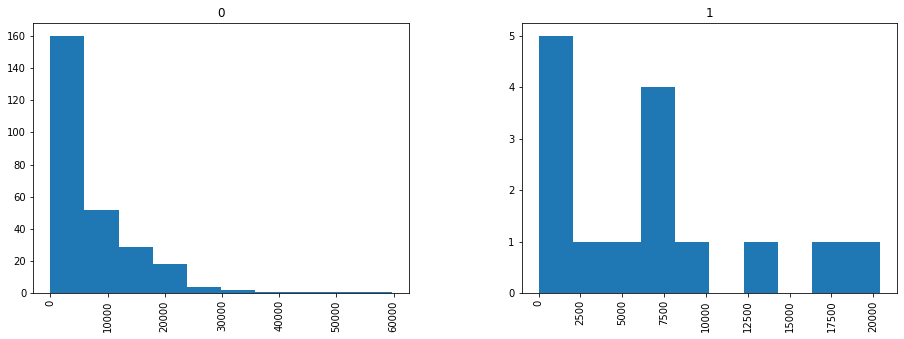

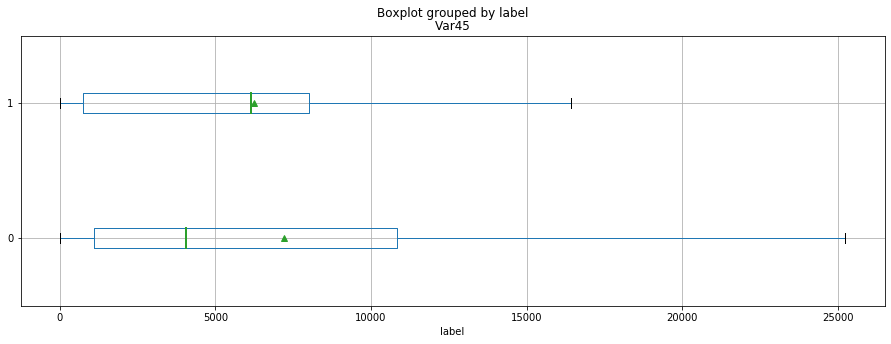

Correlation with label =  -0.11415547481117097
Name of feature: Var166
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var166, dtype: float64
mean:  label
0    22.55275
1    12.12500
Name: Var166, dtype: float64
std:  label
0    93.360256
1    29.981851
Name: Var166, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-19.85855782  -0.49901939]


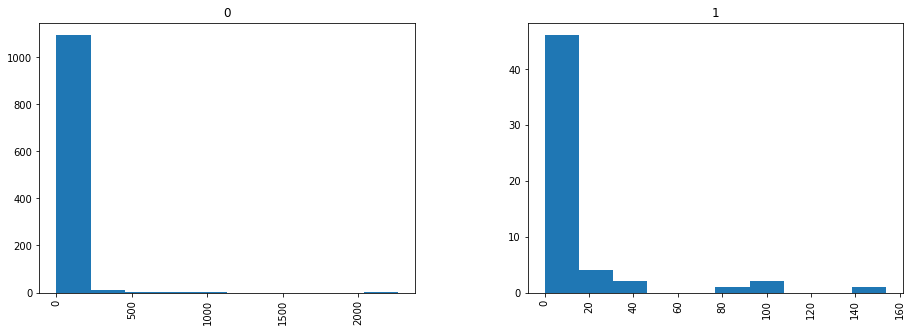

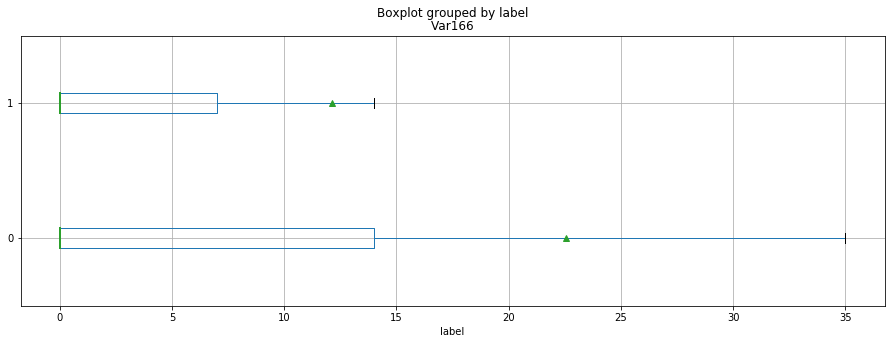

Correlation with label =  -0.11568689939798278
Name of feature: Var49
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var49, dtype: float64
mean:  label
0    0.087047
1    0.000000
Name: Var49, dtype: float64
std:  label
0    0.768066
1    0.000000
Name: Var49, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.14300518 -0.04352332]


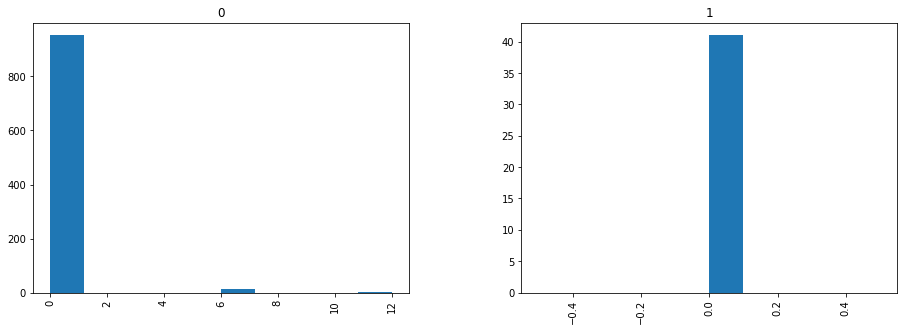

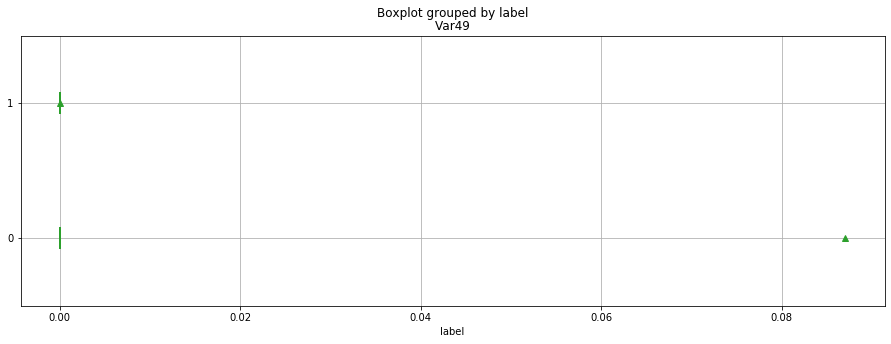

Correlation with label =  -0.11733346789978258
Name of feature: Var176
Count notna elements 0: 41, 1: 964
median:  label
0    0.0
1    0.0
Name: Var176, dtype: float64
mean:  label
0    4.070539
1    2.146341
Name: Var176, dtype: float64
std:  label
0    16.678600
1     7.048266
Name: Var176, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-3.97741372  0.74334582]


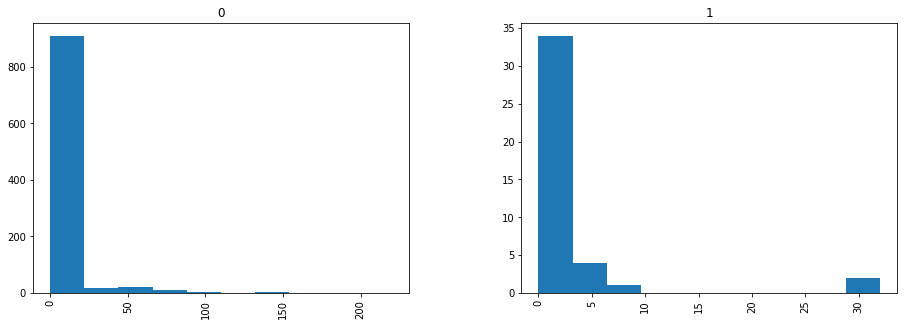

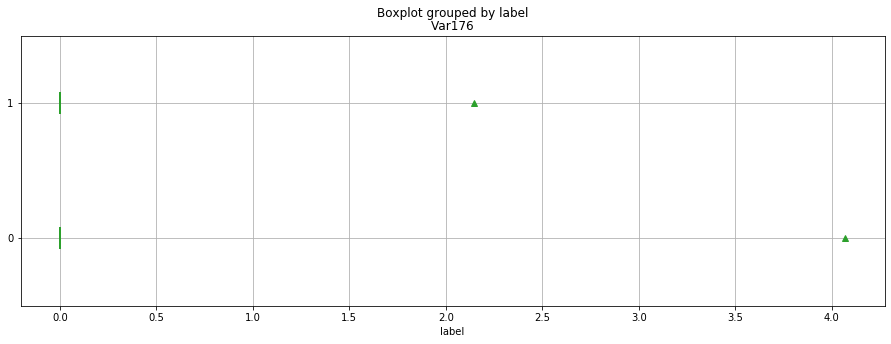

Correlation with label =  0.11737205845251736
Name of feature: Var51
Count notna elements 0: 169, 1: 2821
median:  label
0     9976.24
1    12771.84
Name: Var51, dtype: float64
mean:  label
0    43490.600241
1    51850.224852
Name: Var51, dtype: float64
std:  label
0    70769.218721
1    78223.335365
Name: Var51, dtype: float64
interval of delta medians:  [-1383.496 12389.516]
interval of delta means:  [-3366.70607351 21071.39961819]


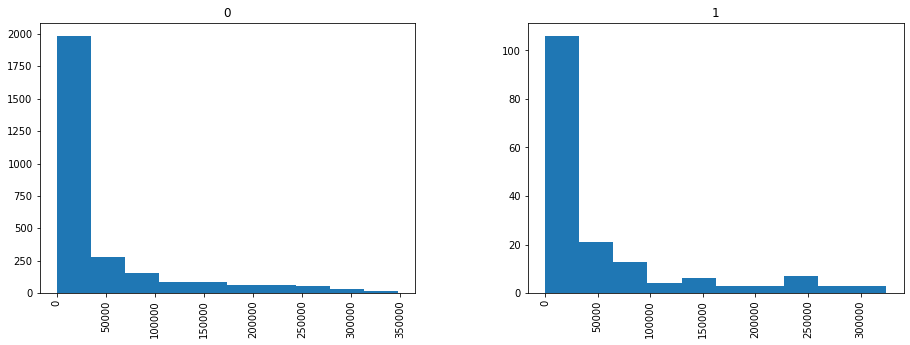

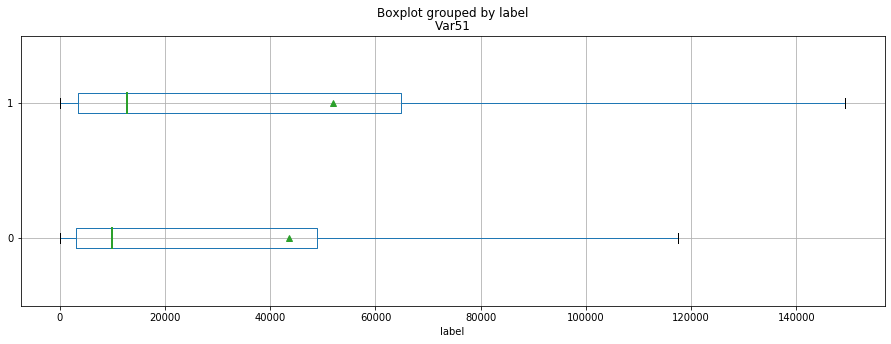

Correlation with label =  -0.11992358864236279
Name of feature: Var27
Count notna elements 0: 56, 1: 1109
median:  label
0    0.0
1    0.0
Name: Var27, dtype: float64
mean:  label
0    0.027051
1    0.000000
Name: Var27, dtype: float64
std:  label
0    0.231126
1    0.000000
Name: Var27, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.04147881 -0.01442741]


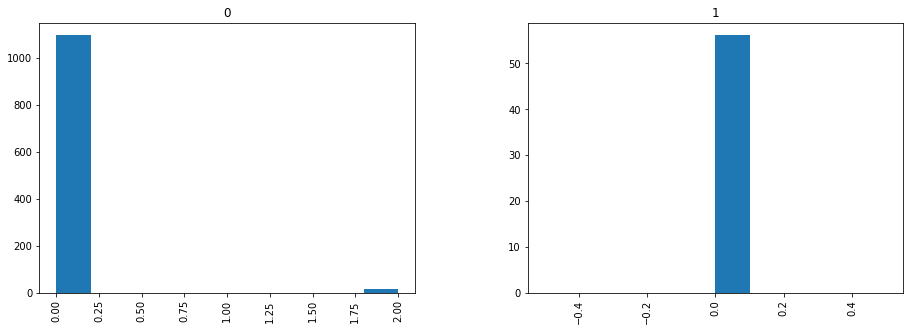

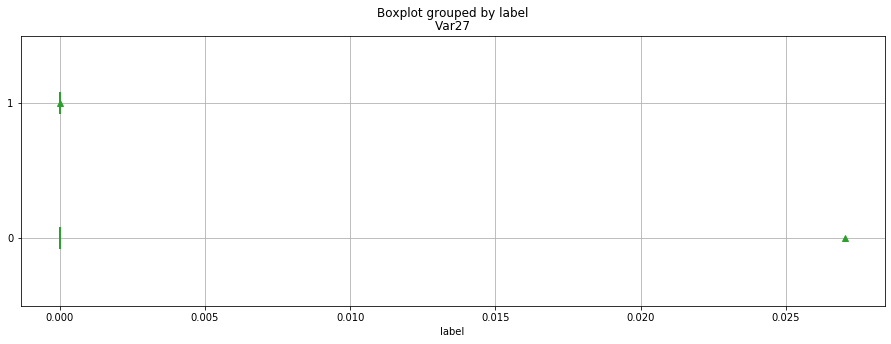

Correlation with label =  0.1205184079418669
Name of feature: Var150
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var150, dtype: float64
mean:  label
0    149307.504098
1    194886.000000
Name: Var150, dtype: float64
std:  label
0    371943.729239
1    499369.610447
Name: Var150, dtype: float64
interval of delta medians:  [    0. 19680.]
interval of delta means:  [-68844.3554769  191761.74321908]


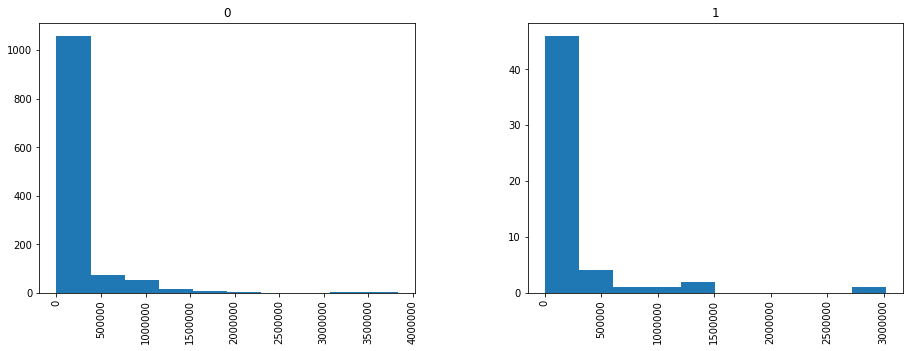

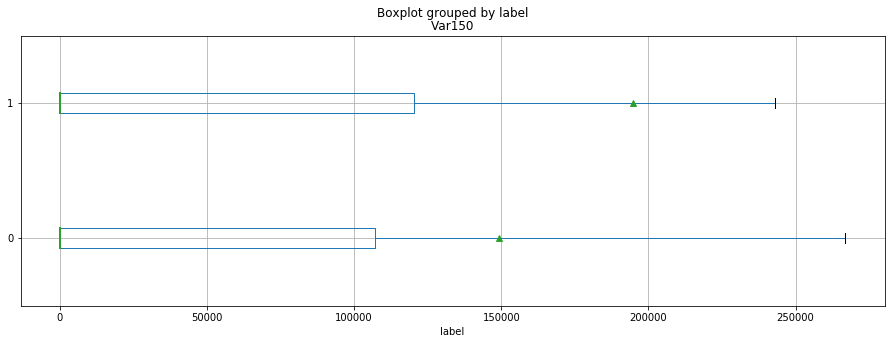

Correlation with label =  0.12316019194943117
Name of feature: Var46
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    4.0
Name: Var46, dtype: float64
mean:  label
0    15.407254
1    22.439024
Name: Var46, dtype: float64
std:  label
0    57.713818
1    39.737922
Name: Var46, dtype: float64
interval of delta medians:  [0. 8.]
interval of delta means:  [-4.04399596 21.1813977 ]


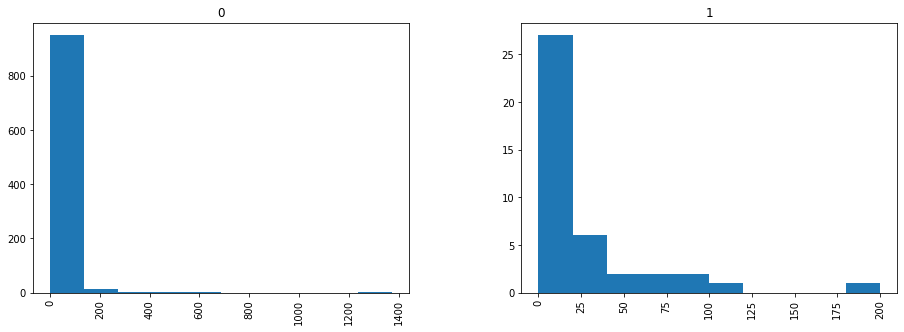

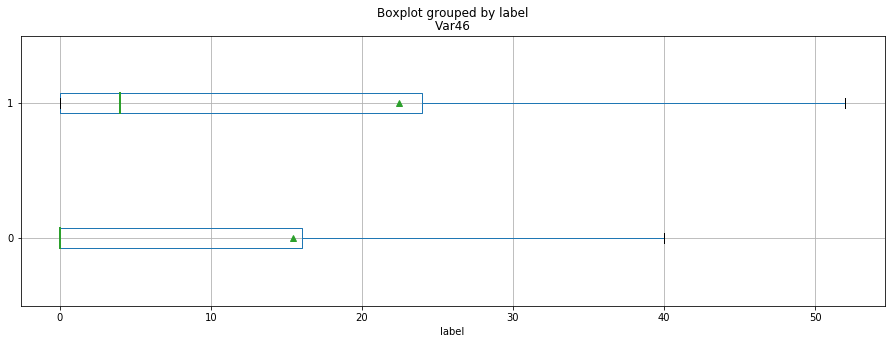

Correlation with label =  -0.12477605525522416
Name of feature: Var122
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var122, dtype: float64
mean:  label
0    0.049741
1    0.000000
Name: Var122, dtype: float64
std:  label
0    0.406907
1    0.000000
Name: Var122, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.07779793 -0.02797927]


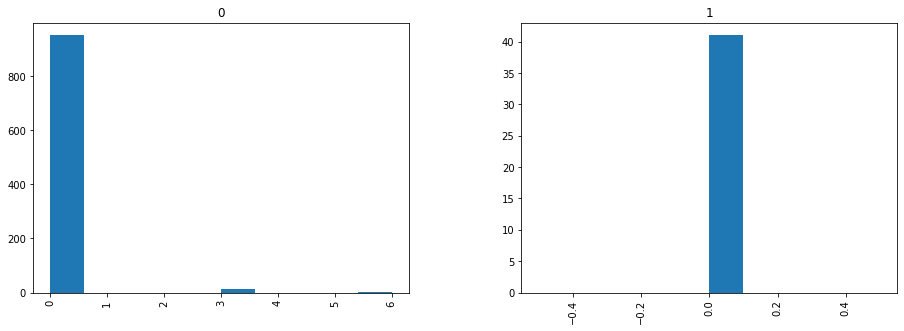

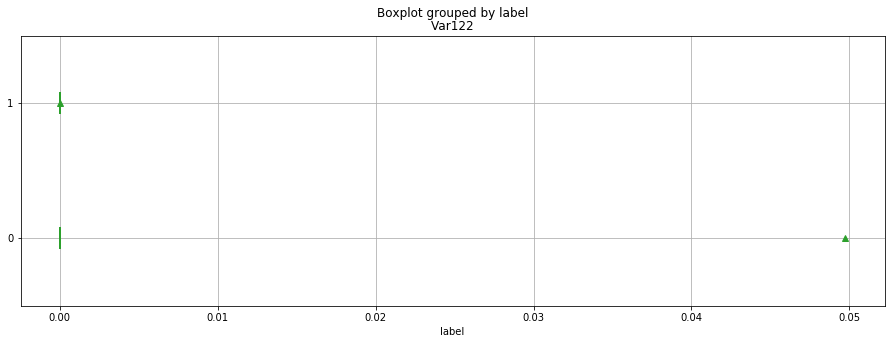

Correlation with label =  -0.12685285163325286
Name of feature: Var74
Count notna elements 0: 2745, 1: 32815
median:  label
0    7.0
1    0.0
Name: Var74, dtype: float64
mean:  label
0    105.164894
1     55.482332
Name: Var74, dtype: float64
std:  label
0    403.230146
1    202.837197
Name: Var74, dtype: float64
interval of delta medians:  [-7. -7.]
interval of delta means:  [-58.27856563 -40.76850802]


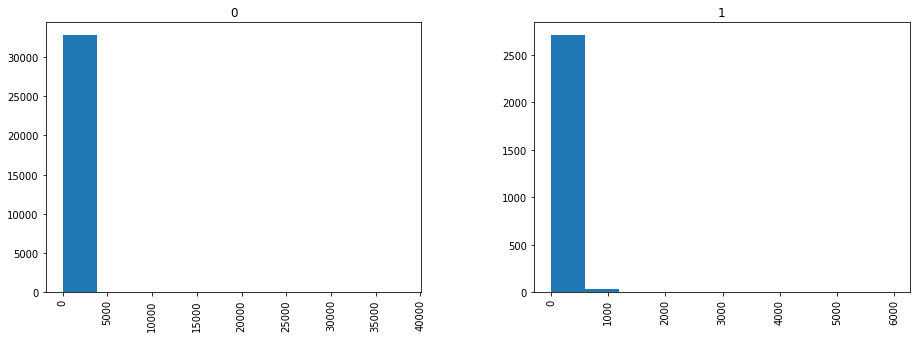

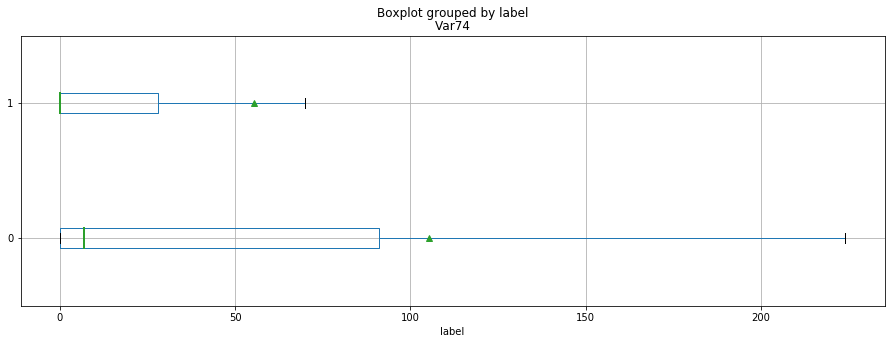

Correlation with label =  0.12731582817367806
Name of feature: Var98
Count notna elements 0: 30, 1: 434
median:  label
0    0.0
1    0.0
Name: Var98, dtype: float64
mean:  label
0    21053.078341
1    31723.200000
Name: Var98, dtype: float64
std:  label
0    84532.907938
1    73037.872707
Name: Var98, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-12002.51777266  40626.86589862]


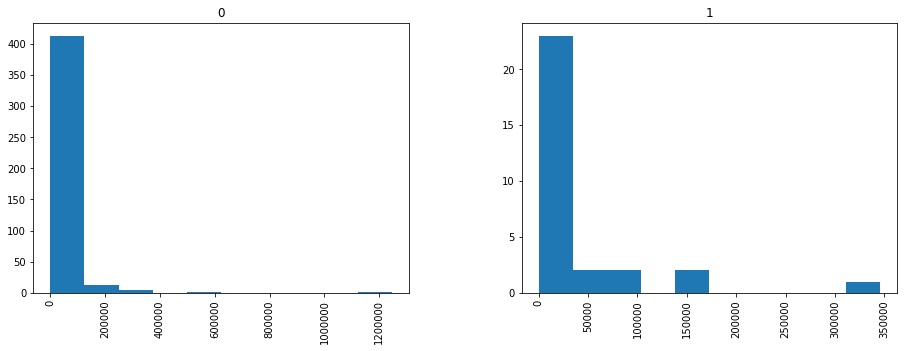

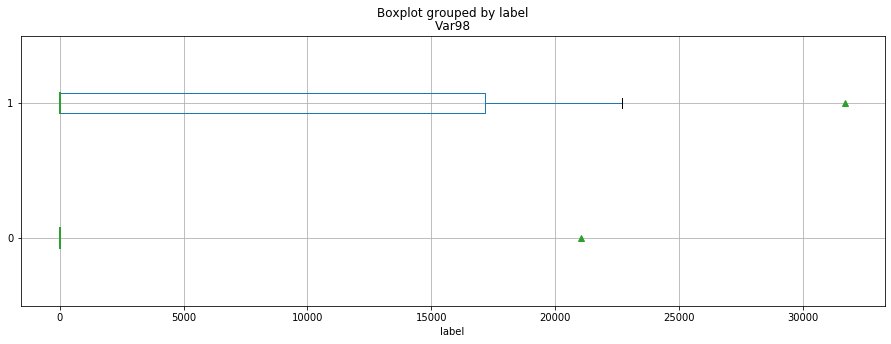

Correlation with label =  -0.1318362298697357
Name of feature: Var43
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var43, dtype: float64
mean:  label
0    3.601036
1    2.195122
Name: Var43, dtype: float64
std:  label
0    10.841722
1     4.749840
Name: Var43, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-2.81512385  0.25674207]


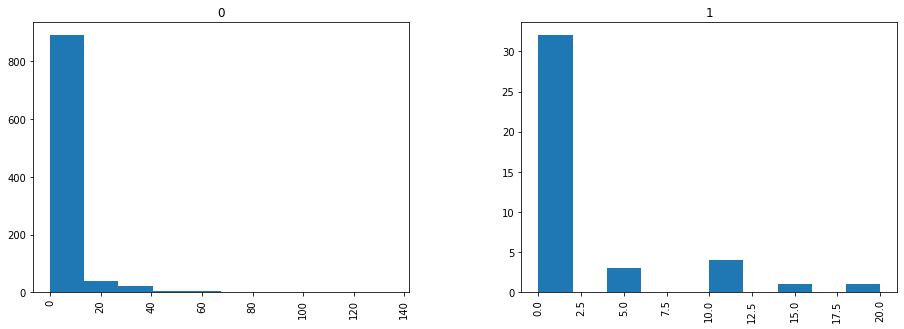

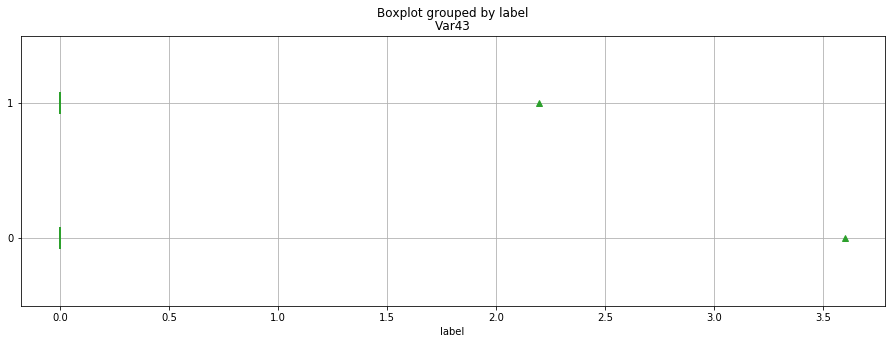

Correlation with label =  0.13385899889352984
Name of feature: Var81
Count notna elements 0: 2759, 1: 32806
median:  label
0    71708.25
1    94355.70
Name: Var81, dtype: float64
mean:  label
0    102175.601597
1    116555.163762
Name: Var81, dtype: float64
std:  label
0    106882.744984
1    112830.771051
Name: Var81, dtype: float64
interval of delta medians:  [15646.86225 31347.51225]
interval of delta means:  [ 9903.28471655 18919.31252193]


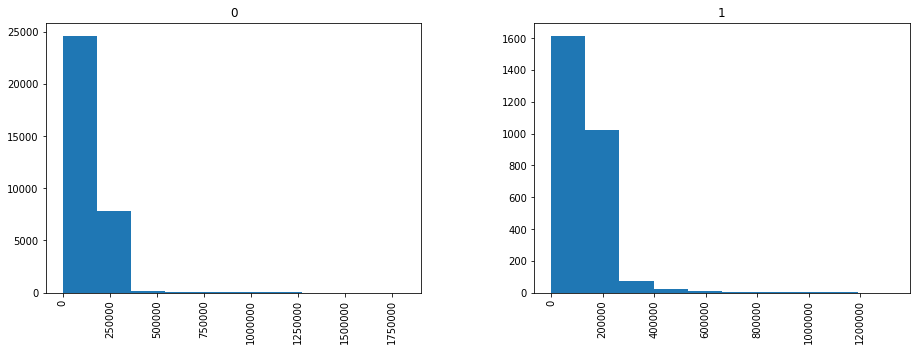

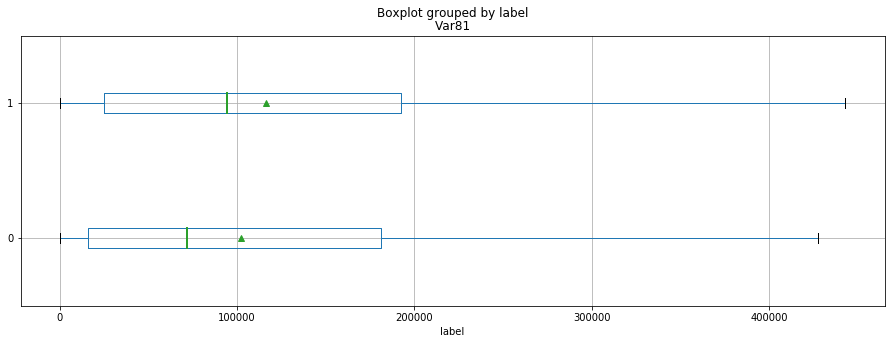

Correlation with label =  -0.13874973281463168
Name of feature: Var34
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var34, dtype: float64
mean:  label
0    1.202073
1    0.585366
Name: Var34, dtype: float64
std:  label
0    4.516176
1    2.109213
Name: Var34, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.28105143  0.16387716]


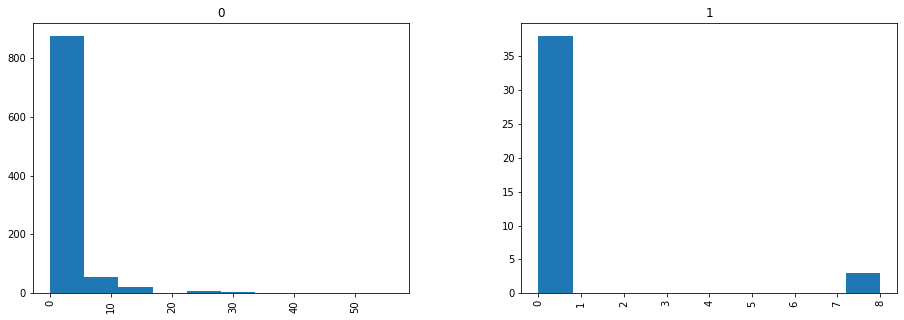

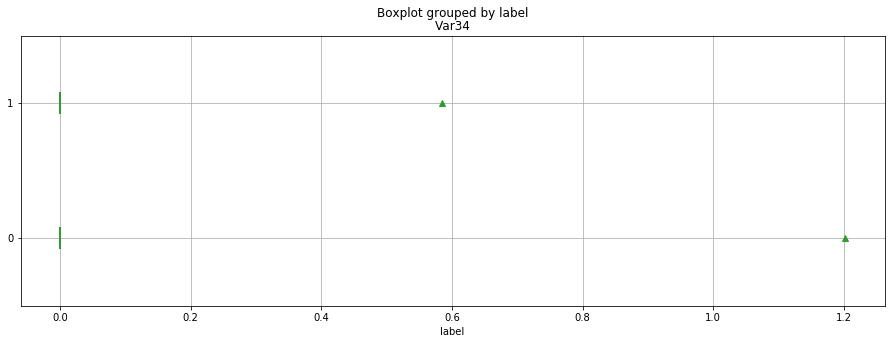

Correlation with label =  -0.1460364042328944
Name of feature: Var11
Count notna elements 0: 41, 1: 964
median:  label
0    8.0
1    8.0
Name: Var11, dtype: float64
mean:  label
0    8.564315
1    8.195122
Name: Var11, dtype: float64
std:  label
0    2.567674
1    1.249390
Name: Var11, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.68049793  0.12063556]


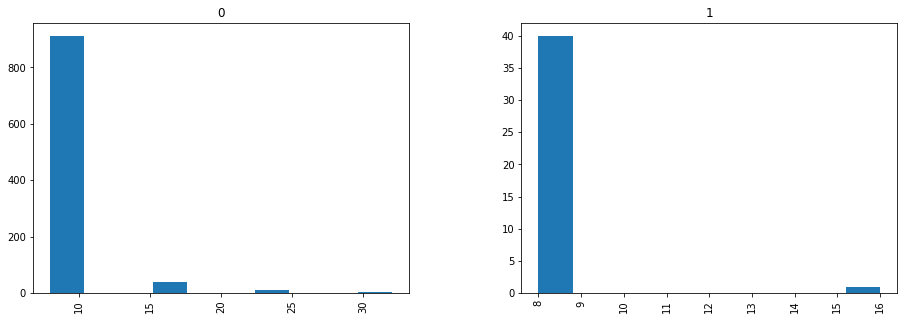

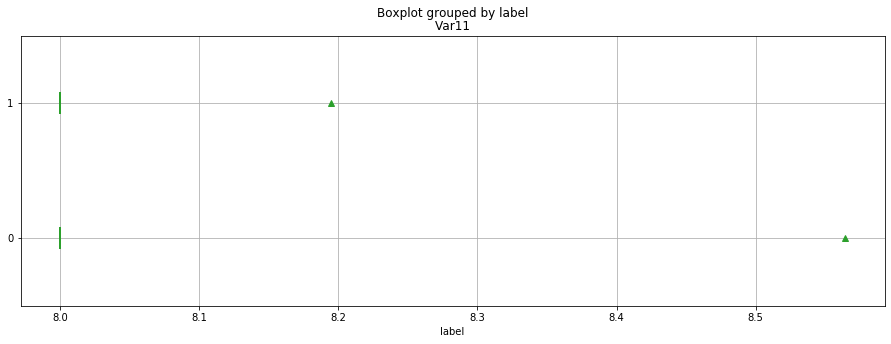

Correlation with label =  0.14644676124620137
Name of feature: Var50
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var50, dtype: float64
mean:  label
0    36.757009
1    56.428571
Name: Var50, dtype: float64
std:  label
0    124.790449
1    238.757727
Name: Var50, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-35.47443258 109.04536048]


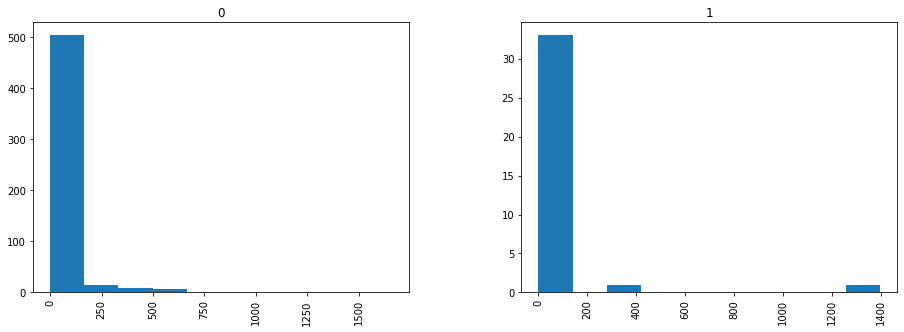

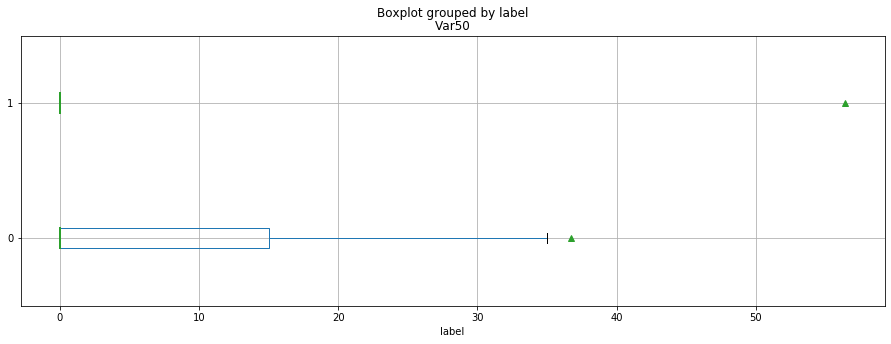

Correlation with label =  0.14922042528413007
Name of feature: Var161
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var161, dtype: float64
mean:  label
0    3.459836
1    4.745455
Name: Var161, dtype: float64
std:  label
0     8.466264
1    11.470119
Name: Var161, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.33402198  4.66348547]


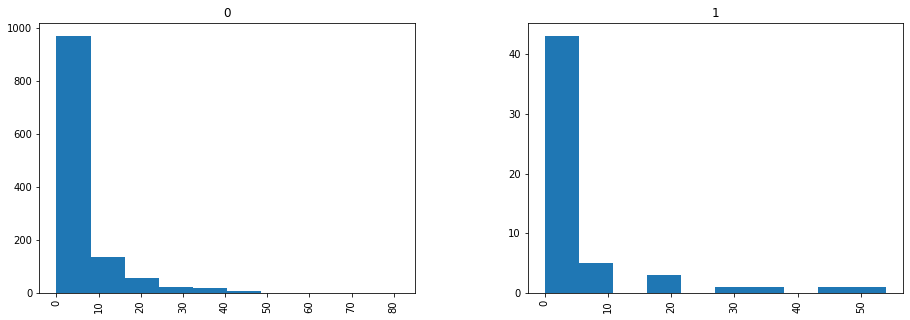

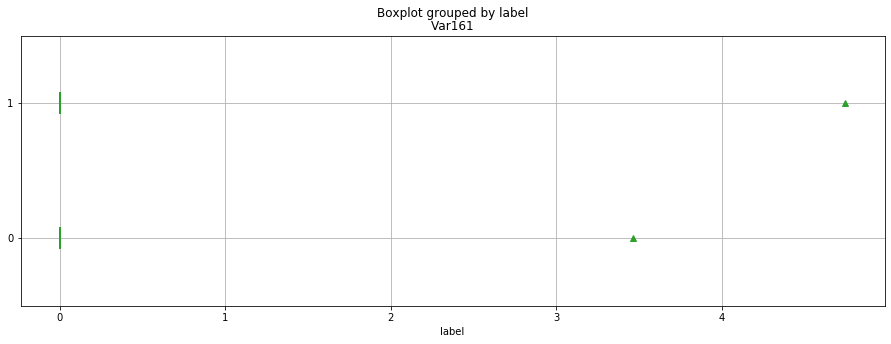

Correlation with label =  -0.1514305431509998
Name of feature: Var178
Count notna elements 0: 27, 1: 497
median:  label
0     5.0
1    10.0
Name: Var178, dtype: float64
mean:  label
0    15.140845
1    10.740741
Name: Var178, dtype: float64
std:  label
0    29.726242
1    10.350000
Name: Var178, dtype: float64
interval of delta medians:  [ 0. 10.]
interval of delta means:  [-8.84986772  0.20981444]


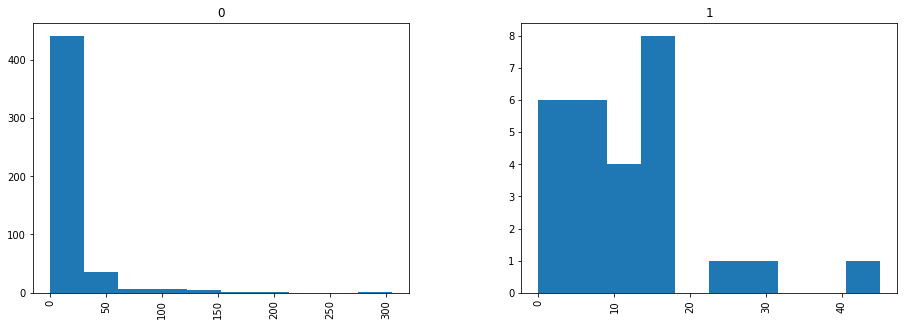

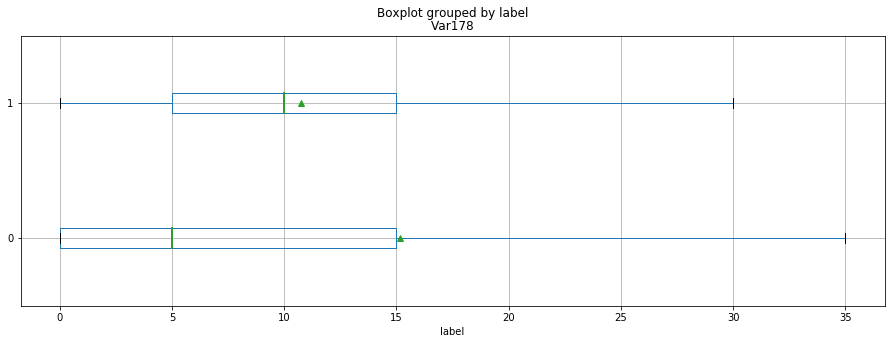

Correlation with label =  -0.15148396944480846
Name of feature: Var147
Count notna elements 0: 56, 1: 1109
median:  label
0    2.0
1    2.0
Name: Var147, dtype: float64
mean:  label
0    1.689811
1    1.464286
Name: Var147, dtype: float64
std:  label
0    1.497680
1    1.292837
Name: Var147, dtype: float64
interval of delta medians:  [-1.  0.]
interval of delta means:  [-0.58305826  0.14101668]


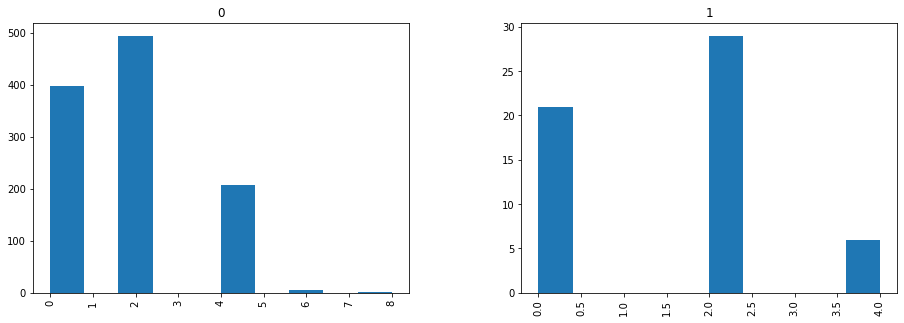

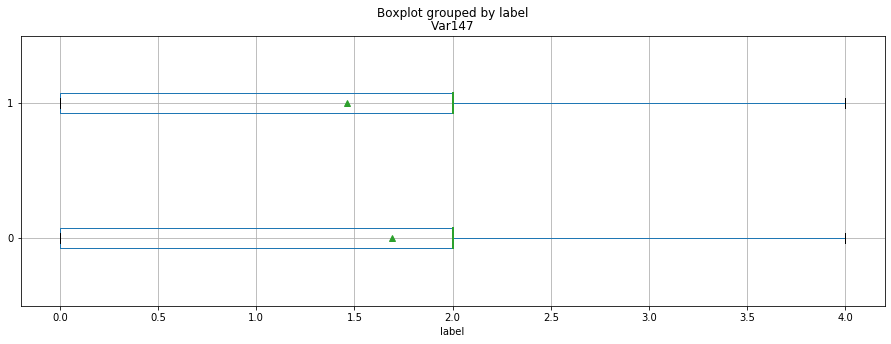

Correlation with label =  -0.15469115745588033
Name of feature: Var93
Count notna elements 0: 56, 1: 1109
median:  label
0    2.0
1    2.0
Name: Var93, dtype: float64
mean:  label
0    2.133454
1    2.035714
Name: Var93, dtype: float64
std:  label
0    0.644505
1    0.267261
Name: Var93, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.16411181 -0.00278484]


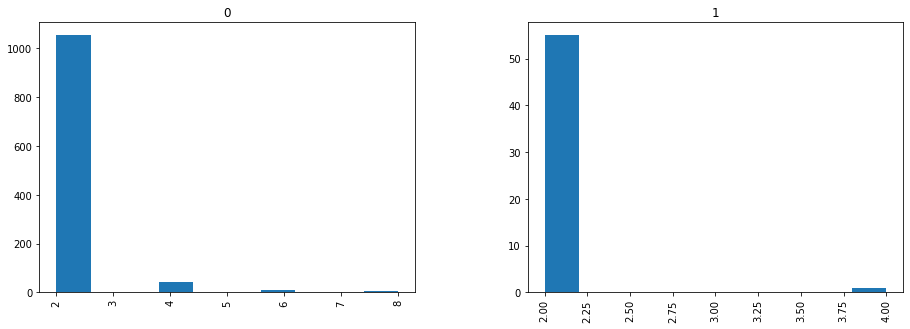

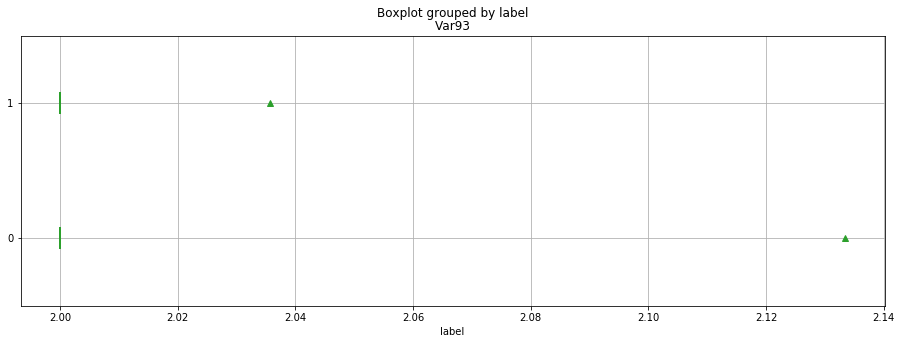

Correlation with label =  -0.15912217999799957
Name of feature: Var72
Count notna elements 0: 1591, 1: 20472
median:  label
0    3.0
1    3.0
Name: Var72, dtype: float64
mean:  label
0    4.209115
1    3.844752
Name: Var72, dtype: float64
std:  label
0    2.312879
1    1.938464
Name: Var72, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.45923818 -0.27555099]


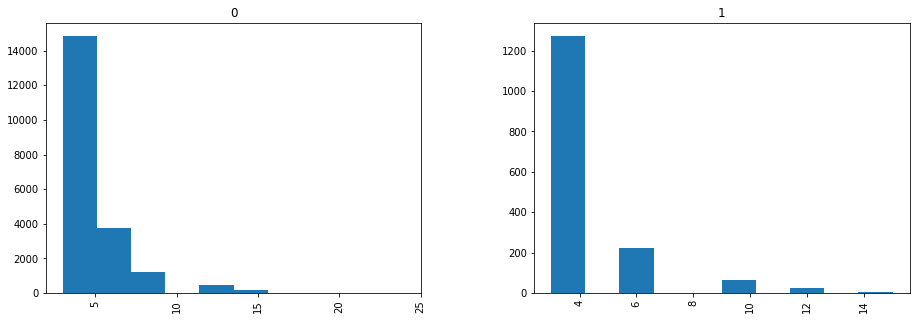

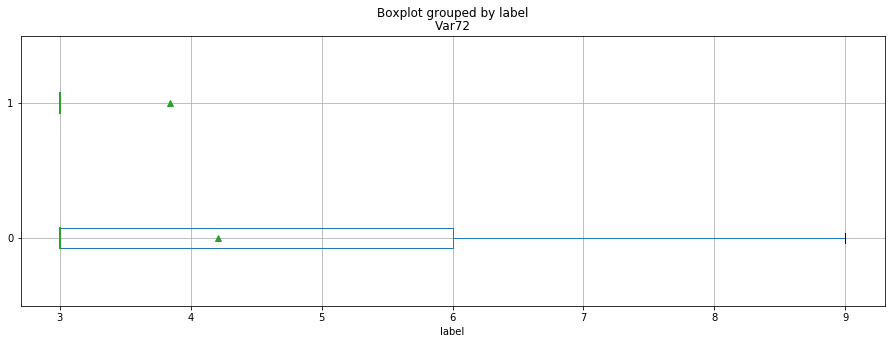

Correlation with label =  -0.16070663393669601
Name of feature: Var136
Count notna elements 0: 35, 1: 528
median:  label
0    50399.8
1    42492.4
Name: Var136, dtype: float64
mean:  label
0    116046.392254
1     85314.532000
Name: Var136, dtype: float64
std:  label
0    194662.057034
1    127285.903054
Name: Var136, dtype: float64
interval of delta medians:  [-34817.985  59153.76 ]
interval of delta means:  [-68834.28932873  13795.10363773]


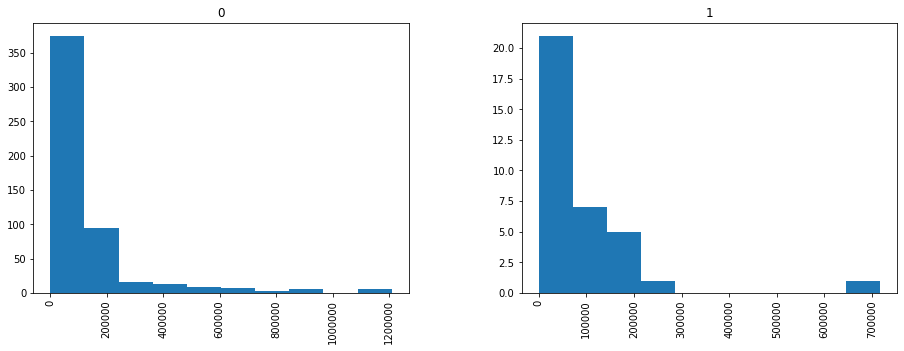

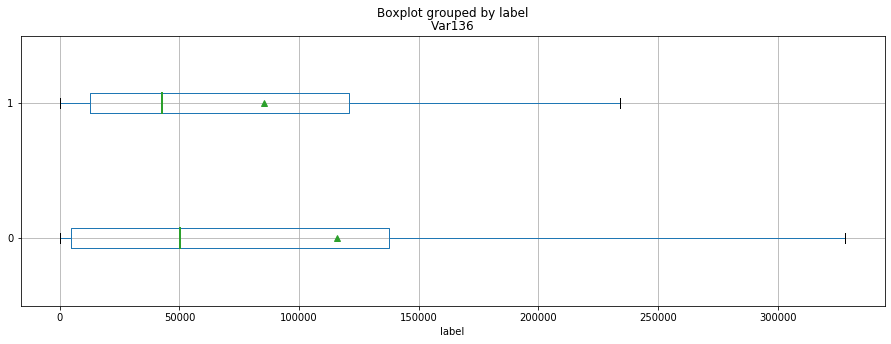

Correlation with label =  -0.16162695484761078
Name of feature: Var65
Count notna elements 0: 2745, 1: 32815
median:  label
0    9.0
1    9.0
Name: Var65, dtype: float64
mean:  label
0    14.952644
1    13.331148
Name: Var65, dtype: float64
std:  label
0    10.103847
1     9.002105
Name: Var65, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.9776991  -1.25945251]


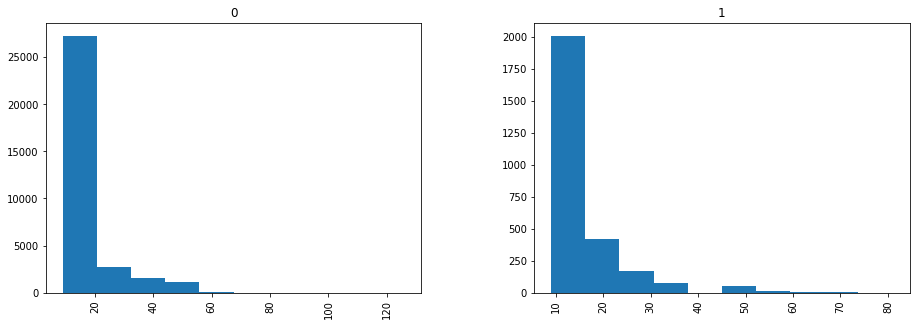

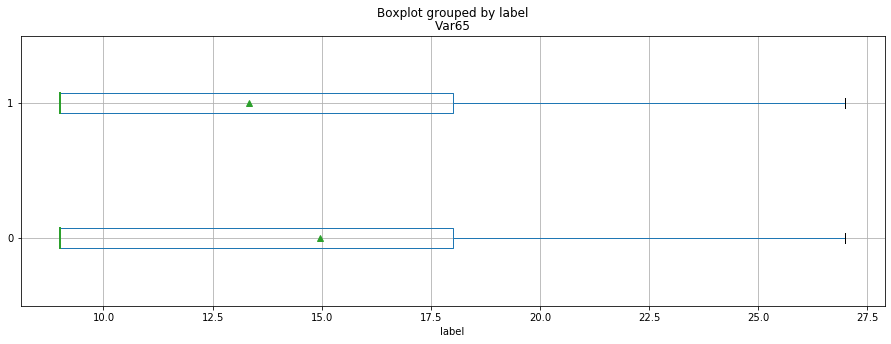

Correlation with label =  -0.16168480085560358
Name of feature: Var124
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var124, dtype: float64
mean:  label
0    228107.816393
1    106103.854545
Name: Var124, dtype: float64
std:  label
0    767938.436307
1    325994.518089
Name: Var124, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-208798.90956781  -22527.68560358]


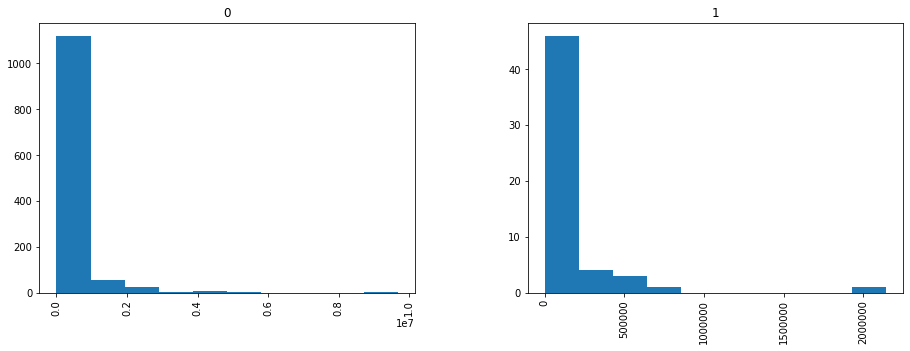

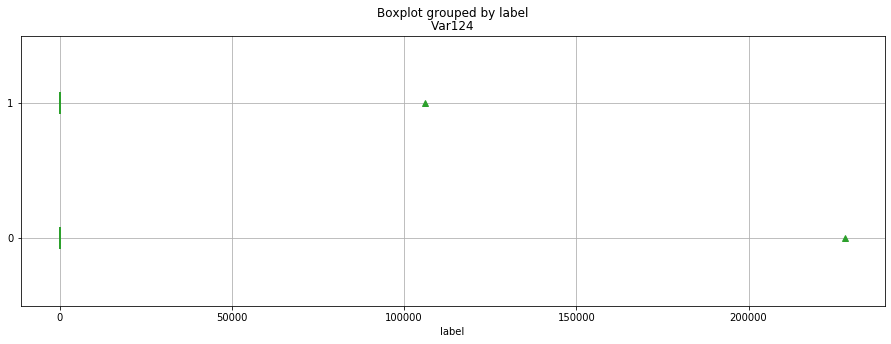

Correlation with label =  -0.1660696685715359
Name of feature: Var59
Count notna elements 0: 37, 1: 625
median:  label
0    169803.9
1    129691.8
Name: Var59, dtype: float64
mean:  label
0    434956.436682
1    304320.381081
Name: Var59, dtype: float64
std:  label
0    802816.436698
1    416641.110242
Name: Var59, dtype: float64
interval of delta medians:  [-188232.3315  244726.02  ]
interval of delta means:  [-263510.21614776   12654.66089387]


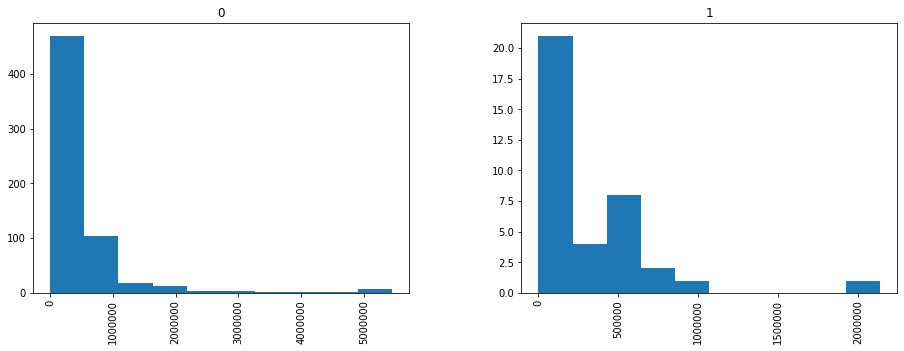

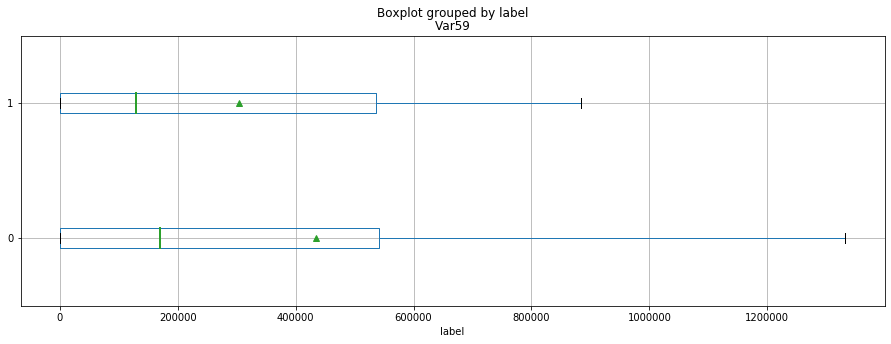

Correlation with label =  0.1663952009106551
Name of feature: Var12
Count notna elements 0: 30, 1: 434
median:  label
0    0.0
1    8.0
Name: Var12, dtype: float64
mean:  label
0    15.64977
1    27.20000
Name: Var12, dtype: float64
std:  label
0    70.301935
1    54.809010
Name: Var12, dtype: float64
interval of delta medians:  [ 0. 16.]
interval of delta means:  [-6.10132104 34.25155146]


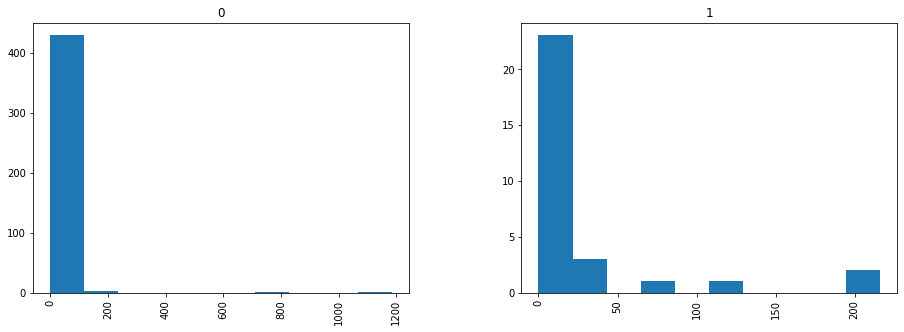

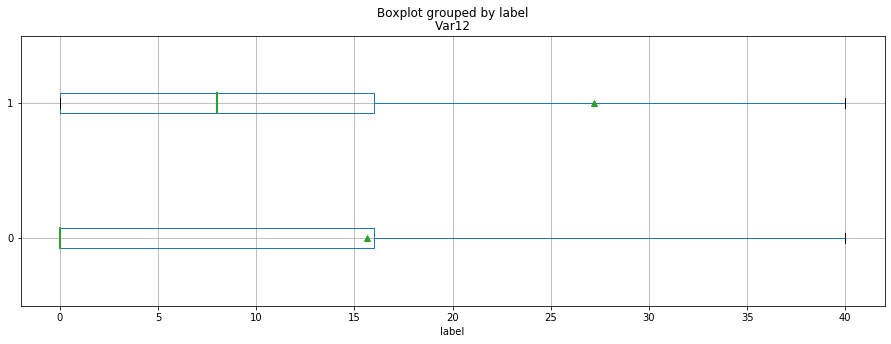

Correlation with label =  -0.16909175196255877
Name of feature: Var115
Count notna elements 0: 37, 1: 625
median:  label
0    9.0
1    9.0
Name: Var115, dtype: float64
mean:  label
0    31.233600
1    20.918919
Name: Var115, dtype: float64
std:  label
0    62.469991
1    24.005067
Name: Var115, dtype: float64
interval of delta medians:  [-9. 18.]
interval of delta means:  [-19.43621514  -1.41962595]


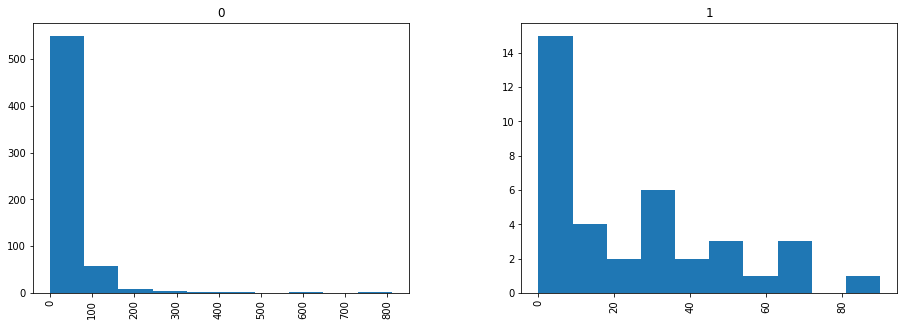

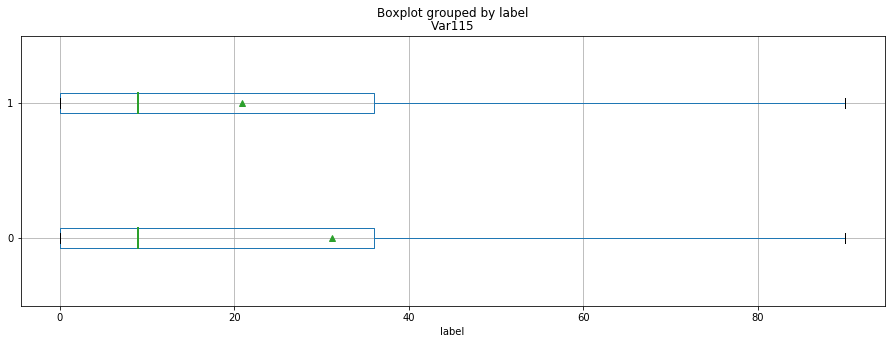

Correlation with label =  -0.1698465047727608
Name of feature: Var14
Count notna elements 0: 41, 1: 964
median:  label
0    0.0
1    0.0
Name: Var14, dtype: float64
mean:  label
0    0.717842
1    0.146341
Name: Var14, dtype: float64
std:  label
0    3.428434
1    0.937043
Name: Var14, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.89014523 -0.20615196]


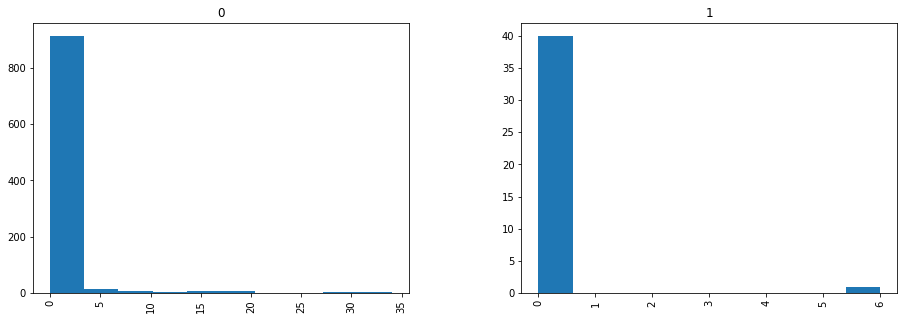

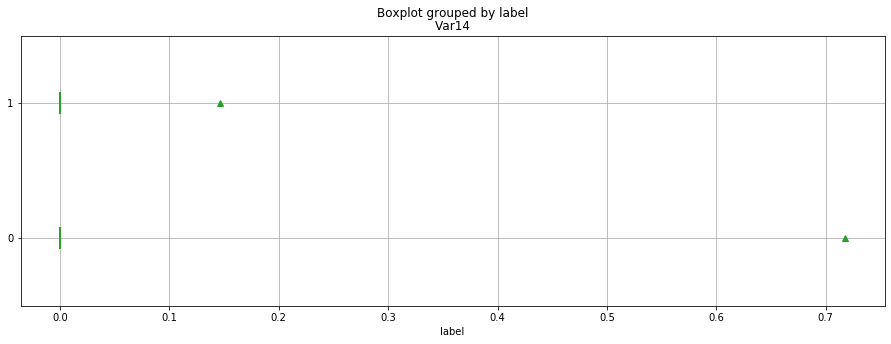

Correlation with label =  -0.17810986657104447
Name of feature: Var100
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var100, dtype: float64
mean:  label
0    0.994393
1    0.400000
Name: Var100, dtype: float64
std:  label
0    3.416468
1    1.648529
Name: Var100, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.16448598  0.04485981]


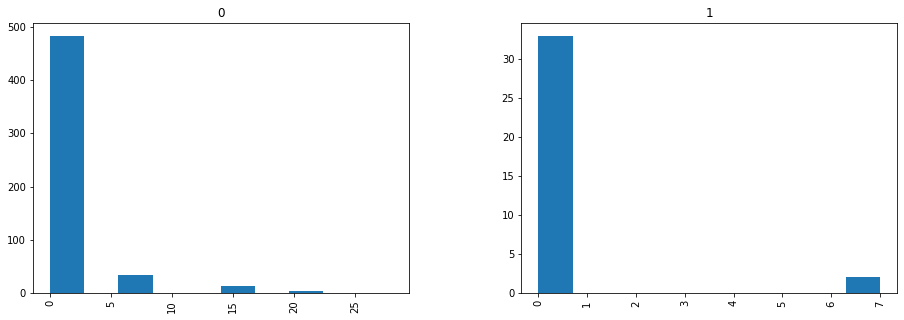

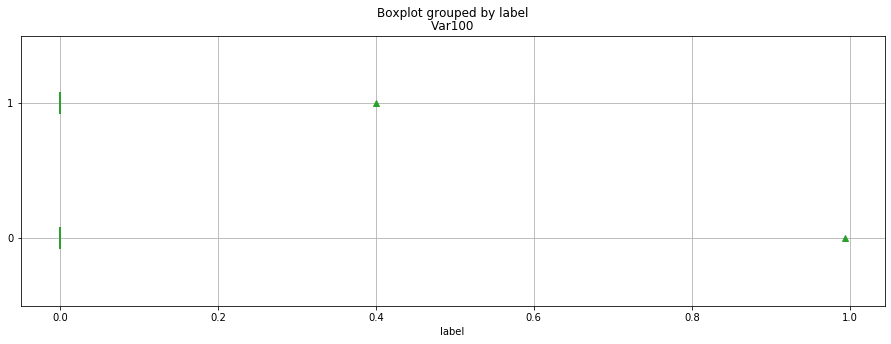

Correlation with label =  0.17813848146562347
Name of feature: Var36
Count notna elements 0: 41, 1: 965
median:  label
0        0.0
1    21188.0
Name: Var36, dtype: float64
mean:  label
0    158193.649741
1    216187.024390
Name: Var36, dtype: float64
std:  label
0    324785.761848
1    342548.581996
Name: Var36, dtype: float64
interval of delta medians:  [     0. 159334.]
interval of delta means:  [-41527.48505624 160508.38408568]


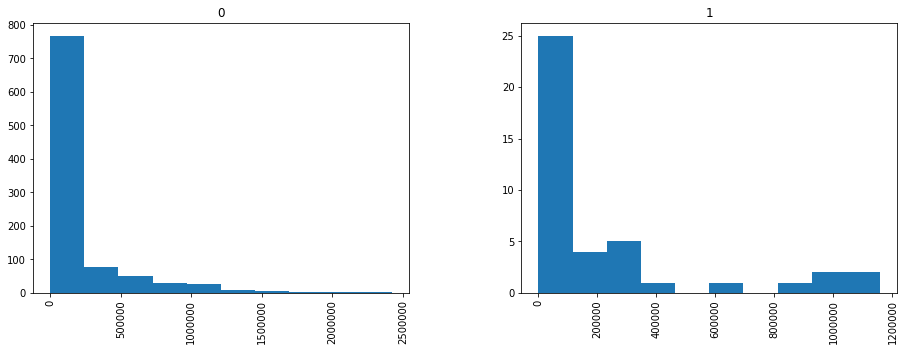

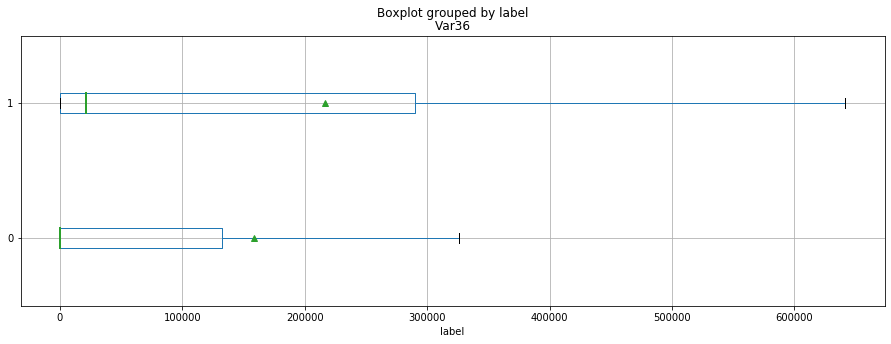

Correlation with label =  -0.17986695414256804
Name of feature: Var89
Count notna elements 0: 27, 1: 497
median:  label
0    0.0
1    0.0
Name: Var89, dtype: float64
mean:  label
0    5.323944
1    2.888889
Name: Var89, dtype: float64
std:  label
0    13.846862
1     4.814508
Name: Var89, dtype: float64
interval of delta medians:  [0. 6.]
interval of delta means:  [-4.43964901 -0.21801923]


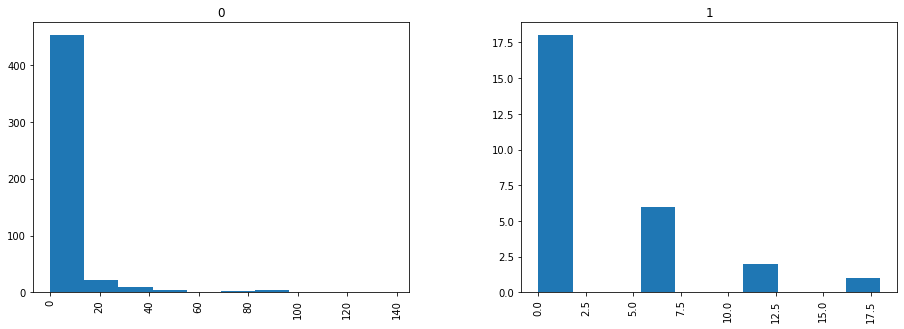

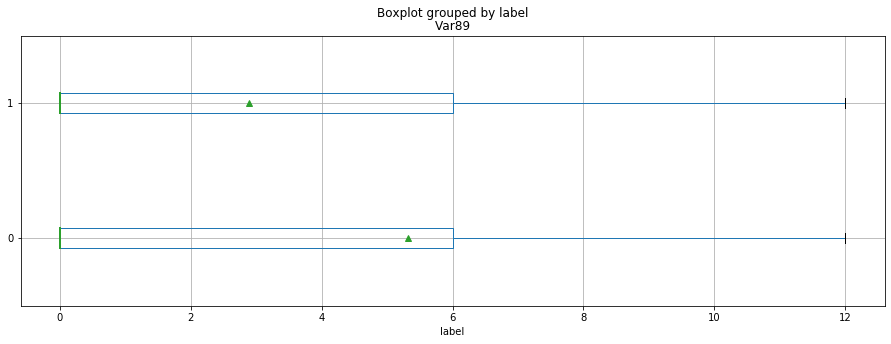

Correlation with label =  -0.1809448466403562
Name of feature: Var33
Count notna elements 0: 33, 1: 627
median:  label
0    0.0
1    0.0
Name: Var33, dtype: float64
mean:  label
0    136864.607656
1     38779.636364
Name: Var33, dtype: float64
std:  label
0    555334.887322
1     94080.960532
Name: Var33, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-154527.16327751  -48615.17117225]


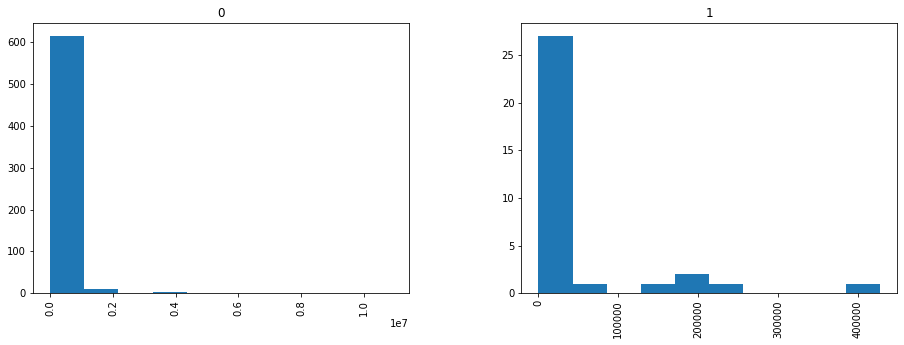

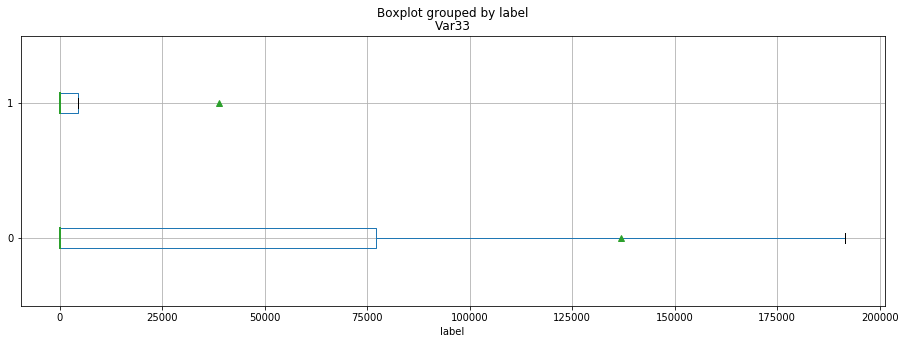

Correlation with label =  -0.1812565854825602
Name of feature: Var13
Count notna elements 0: 2745, 1: 32815
median:  label
0    252.0
1     52.0
Name: Var13, dtype: float64
mean:  label
0    1282.256041
1     799.364663
Name: Var13, dtype: float64
std:  label
0    2726.301243
1    1696.284677
Name: Var13, dtype: float64
interval of delta medians:  [-220. -176.]
interval of delta means:  [-555.57201584 -416.86011162]


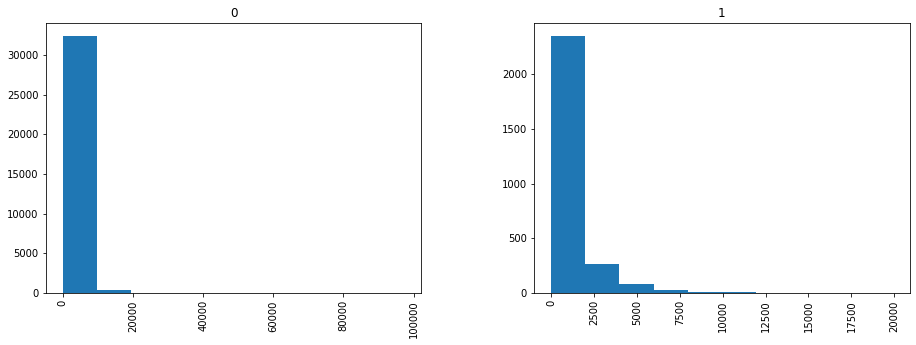

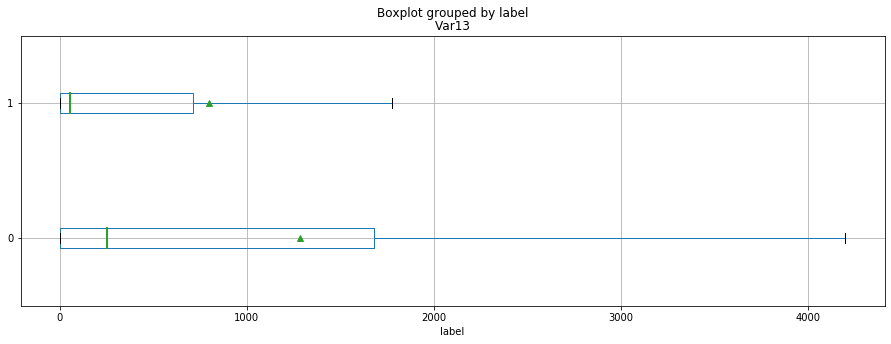

Correlation with label =  -0.1997699855396294
Name of feature: Var144
Count notna elements 0: 2759, 1: 32806
median:  label
0    9.0
1    9.0
Name: Var144, dtype: float64
mean:  label
0    11.892642
1     9.548025
Name: Var144, dtype: float64
std:  label
0    11.829980
1    10.322033
Name: Var144, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-2.70732657 -1.94502886]


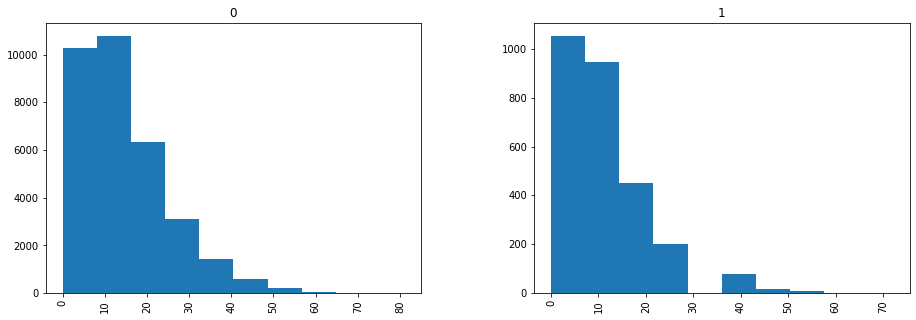

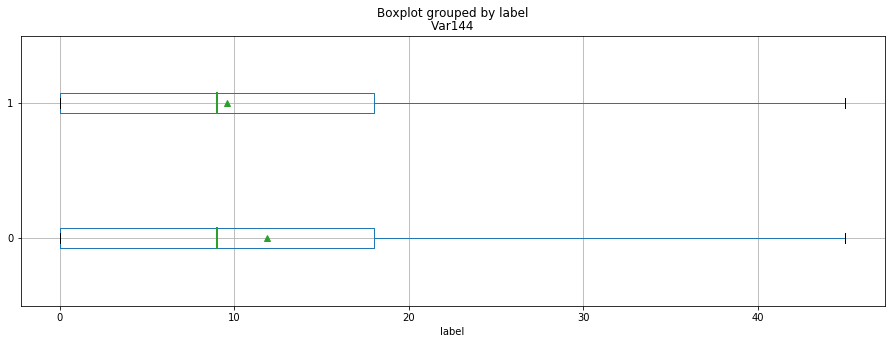

Correlation with label =  -0.2080773886407617
Name of feature: Var142
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var142, dtype: float64
mean:  label
0    1.211215
1    0.800000
Name: Var142, dtype: float64
std:  label
0    1.995844
1    1.623359
Name: Var142, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.93564753  0.16566088]


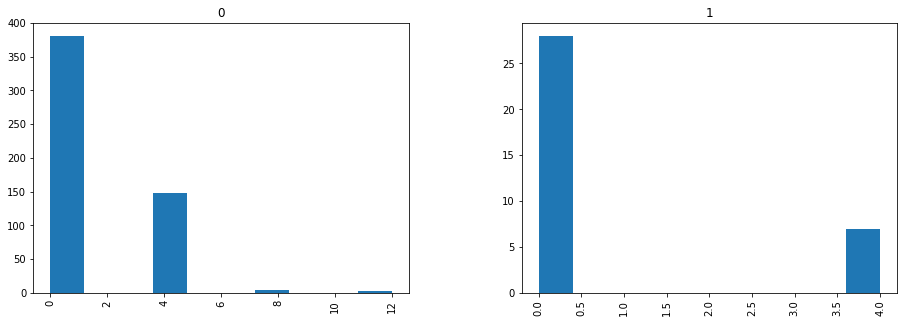

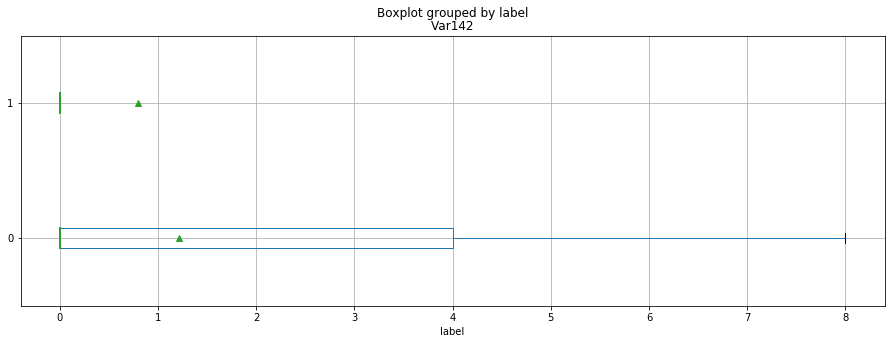

Correlation with label =  -0.2105840784191777
Name of feature: Var110
Count notna elements 0: 35, 1: 535
median:  label
0    6.0
1    6.0
Name: Var110, dtype: float64
mean:  label
0    6.751402
1    6.171429
Name: Var110, dtype: float64
std:  label
0    2.827744
1    1.014185
Name: Var110, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.93084112 -0.18416555]


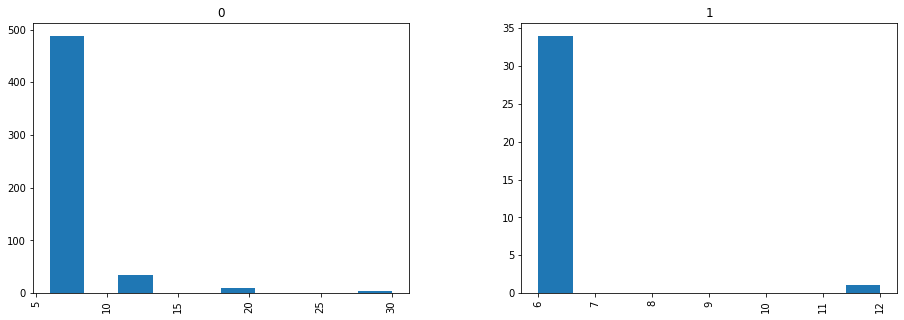

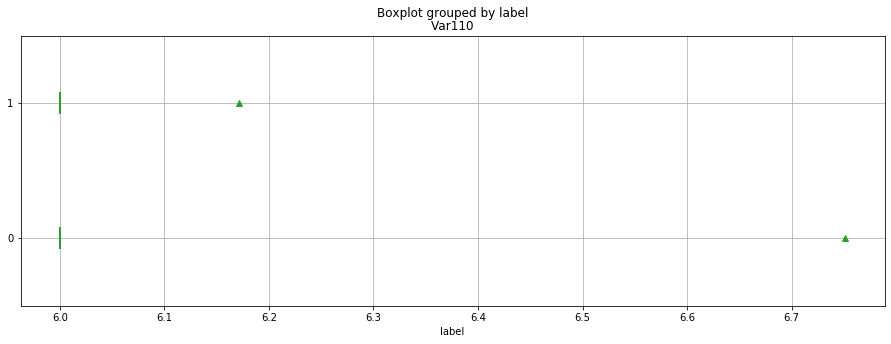

Correlation with label =  0.21143424204355168
Name of feature: Var77
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var77, dtype: float64
mean:  label
0     9.510280
1    17.828571
Name: Var77, dtype: float64
std:  label
0    39.193453
1    41.351780
Name: Var77, dtype: float64
interval of delta medians:  [0. 6.]
interval of delta means:  [-4.18586115 24.13225634]


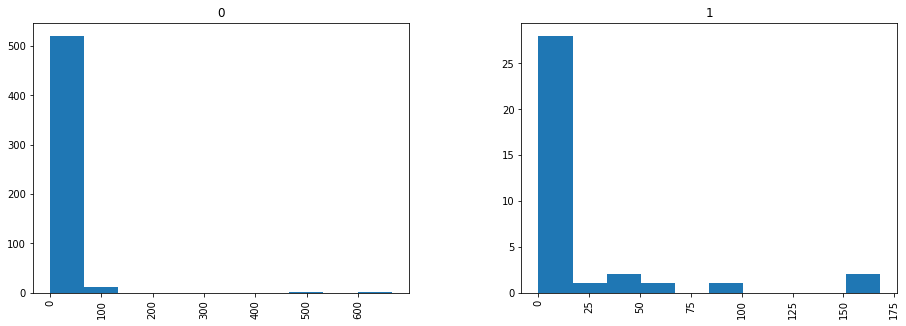

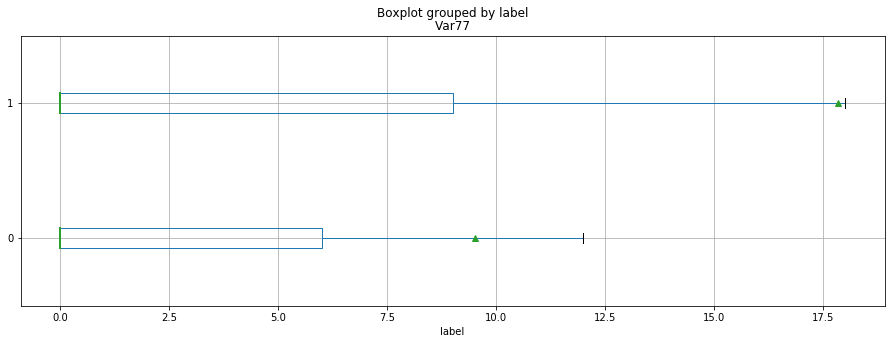

Correlation with label =  0.21382878872974312
Name of feature: Var113
Count notna elements 0: 2976, 1: 37024
median:  label
0    27759.5
1    52510.2
Name: Var113, dtype: float64
mean:  label
0   -166363.763393
1     -3521.578855
Name: Var113, dtype: float64
std:  label
0    760373.442261
1    760241.846893
Name: Var113, dtype: float64
interval of delta medians:  [11804.5005 34196.0235]
interval of delta means:  [132564.0558697  190857.55399628]


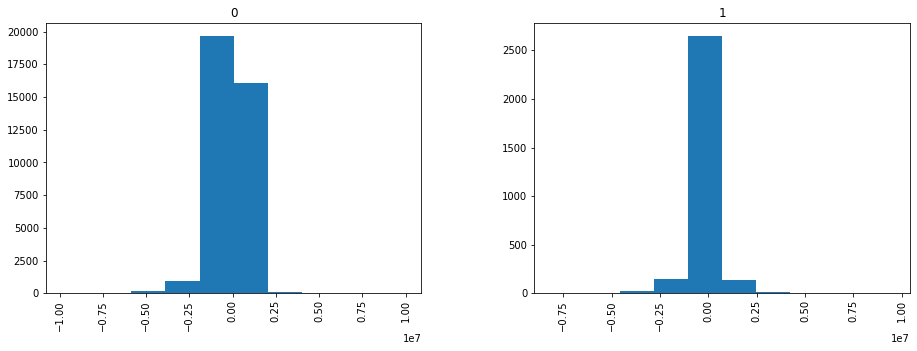

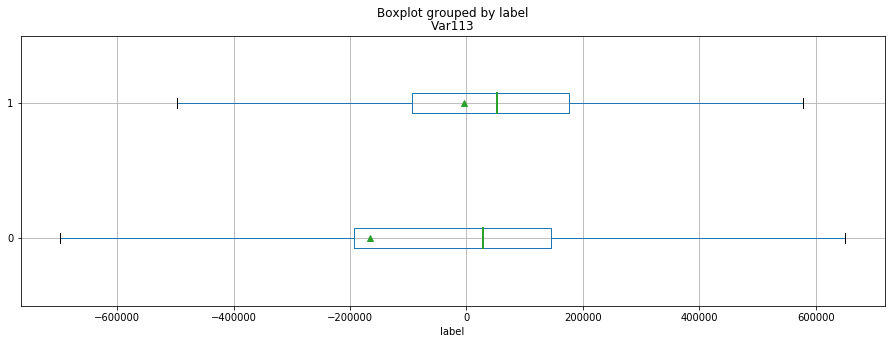

Correlation with label =  0.22091988972342497
Name of feature: Var130
Count notna elements 0: 41, 1: 964
median:  label
0    0.0
1    0.0
Name: Var130, dtype: float64
mean:  label
0    0.485477
1    0.731707
Name: Var130, dtype: float64
std:  label
0    1.105446
1    1.304308
Name: Var130, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.14794302  0.66992777]


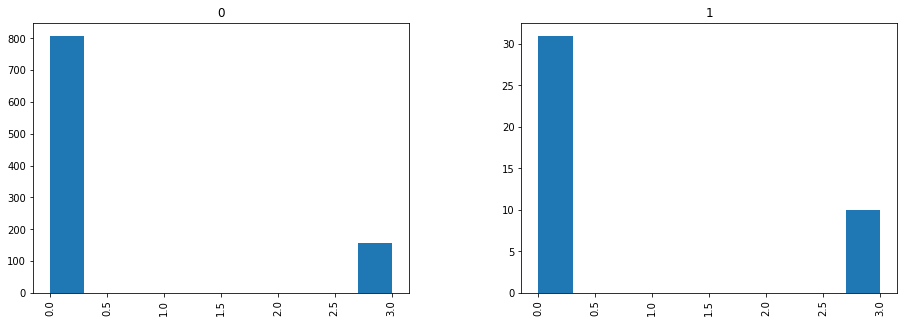

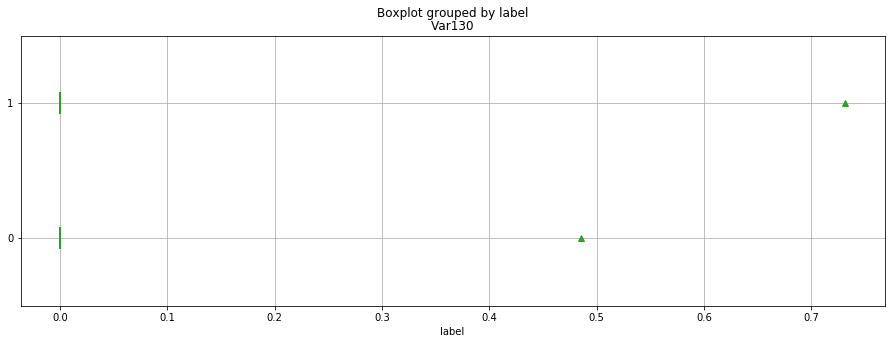

Correlation with label =  0.2313891161404992
Name of feature: Var126
Count notna elements 0: 1726, 1: 27166
median:  label
0    4.0
1    4.0
Name: Var126, dtype: float64
mean:  label
0   -0.880954
1    4.325608
Name: Var126, dtype: float64
std:  label
0    22.684926
1    18.720414
Name: Var126, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [4.32243571 6.08576116]


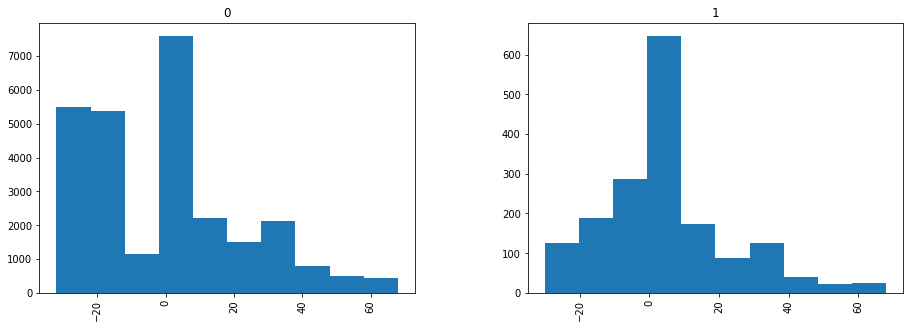

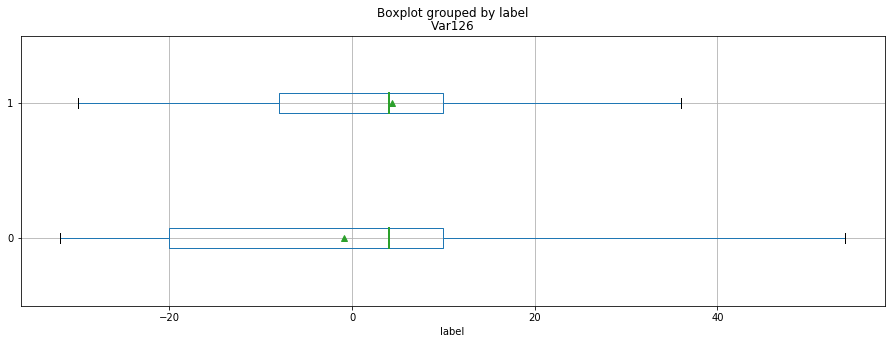

Correlation with label =  -0.24263569656112044
Name of feature: Var92
Count notna elements 0: 9, 1: 131
median:  label
0    97769.0
1    41580.0
Name: Var92, dtype: float64
mean:  label
0    184752.015267
1    127163.555556
Name: Var92, dtype: float64
std:  label
0    240124.28173
1    195760.21732
Name: Var92, dtype: float64
interval of delta medians:  [-91005.425 143528.   ]
interval of delta means:  [-165556.10110263   69789.42913486]


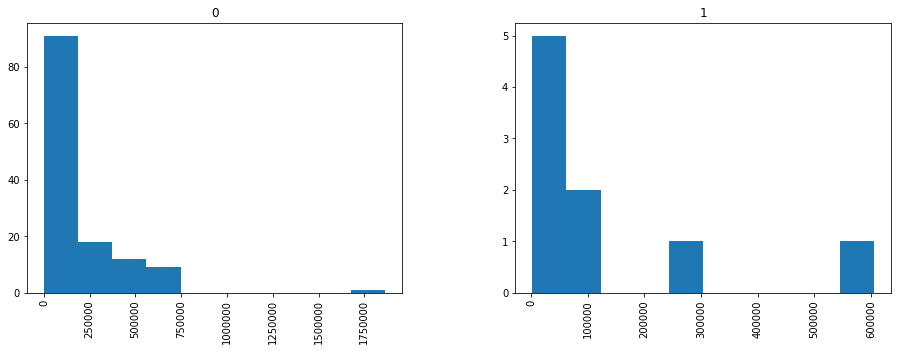

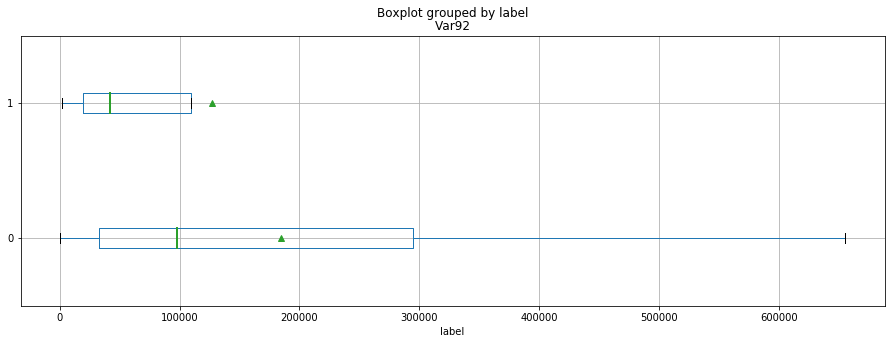

Correlation with label =  0.24892365734630595
Name of feature: Var139
Count notna elements 0: 56, 1: 1109
median:  label
0       0.0
1    1153.0
Name: Var139, dtype: float64
mean:  label
0    171240.834986
1    267105.535714
Name: Var139, dtype: float64
std:  label
0    376989.107080
1    516613.651647
Name: Var139, dtype: float64
interval of delta medians:  [    0. 44643.]
interval of delta means:  [-35830.22236732 243340.3897575 ]


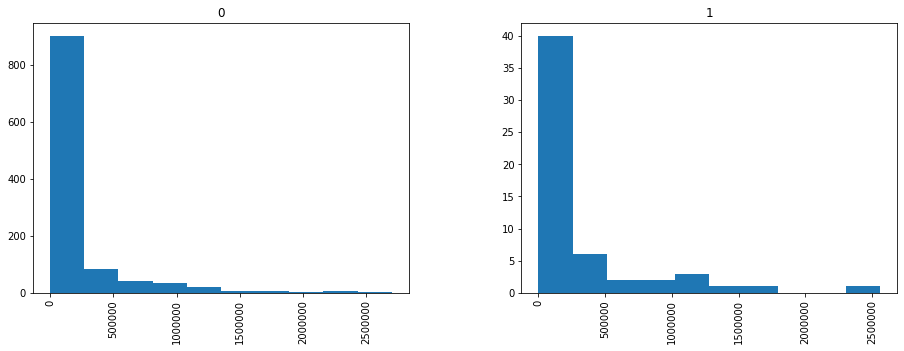

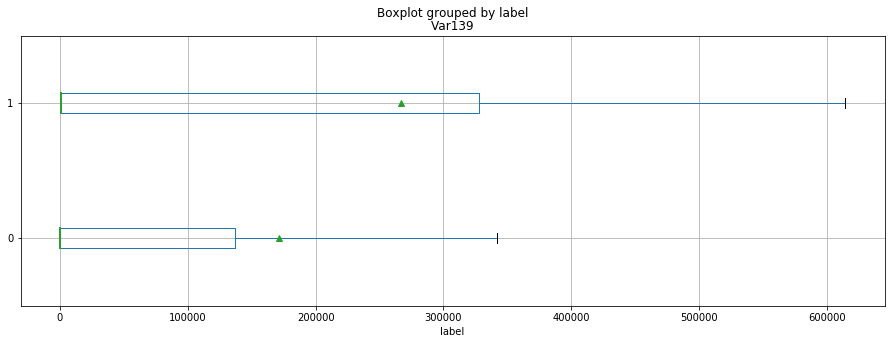

Correlation with label =  0.25890417536089155
Name of feature: Var114
Count notna elements 0: 41, 1: 965
median:  label
0      2684.0
1    357754.0
Name: Var114, dtype: float64
mean:  label
0    601770.484974
1    843405.219512
Name: Var114, dtype: float64
std:  label
0    9.259900e+05
1    1.078366e+06
Name: Var114, dtype: float64
interval of delta medians:  [-12520.  907706.3]
interval of delta means:  [-62973.17567042 575497.58420195]


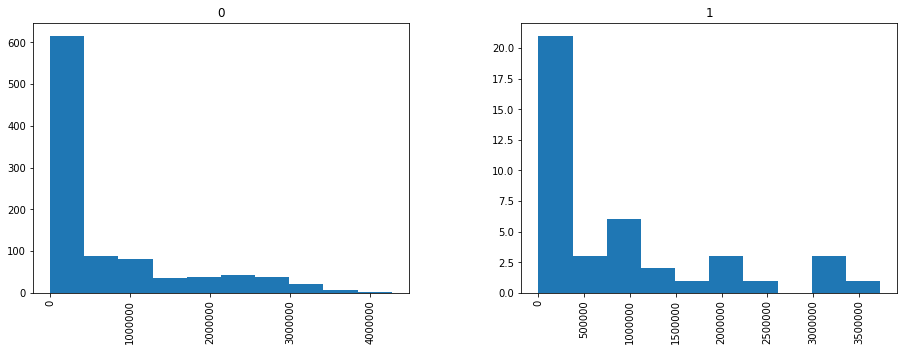

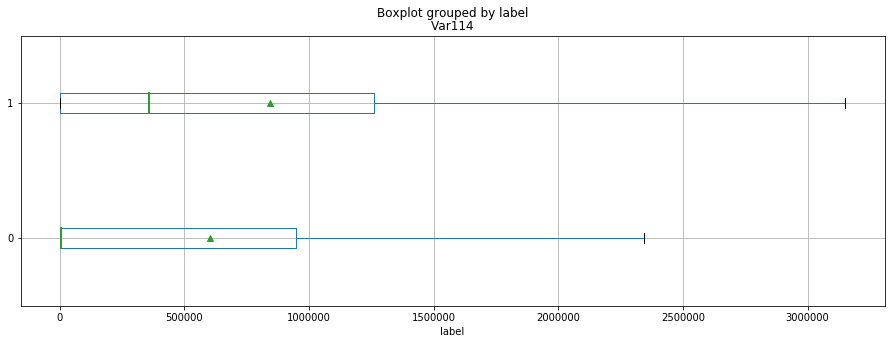

Correlation with label =  -0.2650301754823452
Name of feature: Var73
Count notna elements 0: 2976, 1: 37024
median:  label
0    52
1    40
Name: Var73, dtype: int64
mean:  label
0    67.593885
1    53.572581
Name: Var73, dtype: float64
std:  label
0    53.448045
1    43.571575
Name: Var73, dtype: float64
interval of delta medians:  [-16. -12.]
interval of delta means:  [-15.67723276 -12.39321065]


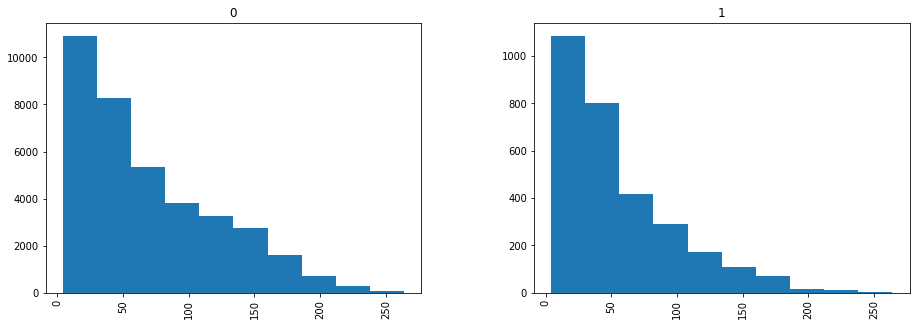

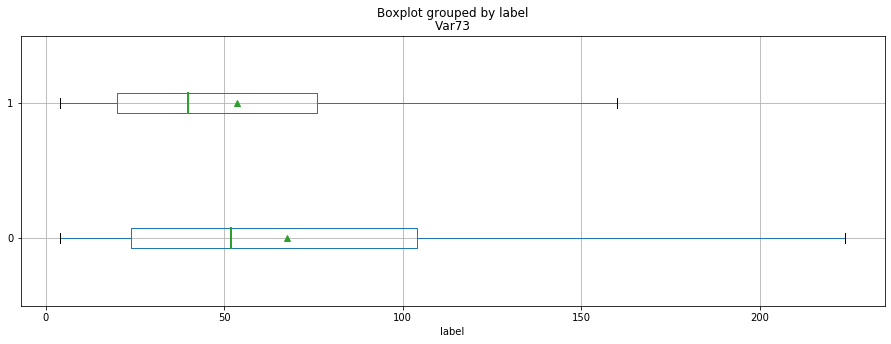

Correlation with label =  -0.271398478010608
Name of feature: Var7
Count notna elements 0: 2745, 1: 32815
median:  label
0    7.0
1    7.0
Name: Var7, dtype: float64
mean:  label
0    6.923846
1    5.217486
Name: Var7, dtype: float64
std:  label
0    6.319380
1    5.658438
Name: Var7, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-1.92611614 -1.4897778 ]


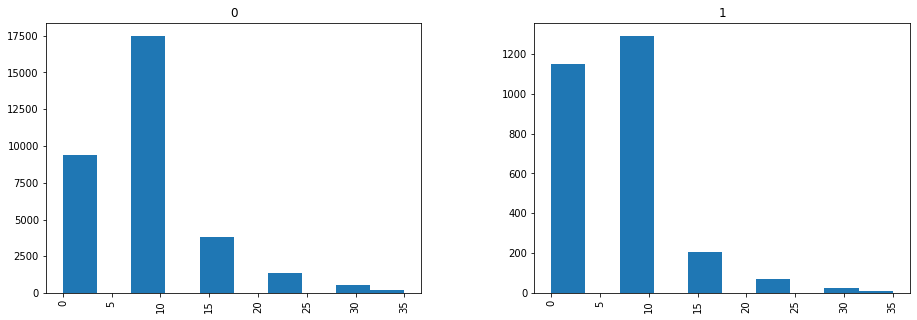

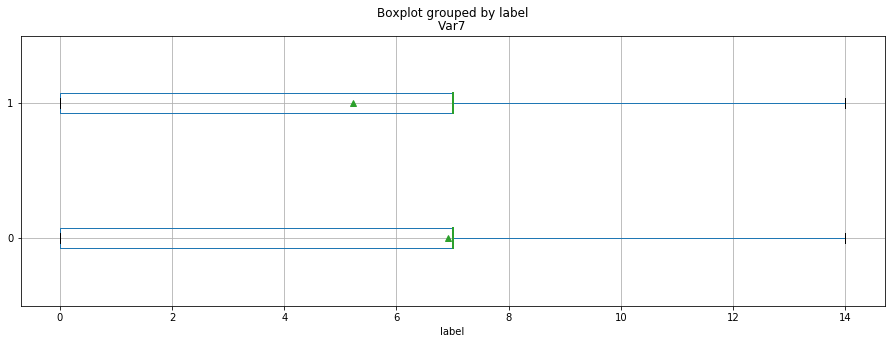

Correlation with label =  0.3041139889488903
Name of feature: Var177
Count notna elements 0: 41, 1: 965
median:  label
0    0.0
1    0.0
Name: Var177, dtype: float64
mean:  label
0    6.088397e+05
1    1.010588e+06
Name: Var177, dtype: float64
std:  label
0    1.306638e+06
1    1.594530e+06
Name: Var177, dtype: float64
interval of delta medians:  [     0. 968422.]
interval of delta means:  [-52363.41326741 921457.56878175]


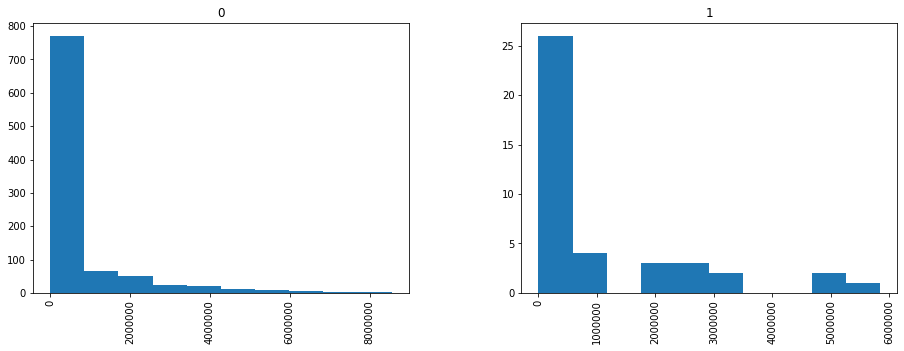

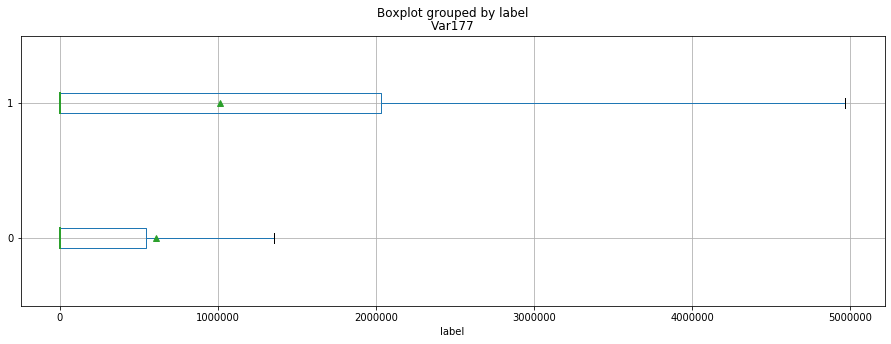

Correlation with label =  0.32897262508933717
Name of feature: Var53
Count notna elements 0: 35, 1: 535
median:  label
0     72765.0
1    587736.0
Name: Var53, dtype: float64
mean:  label
0    6.216911e+05
1    1.060599e+06
Name: Var53, dtype: float64
std:  label
0    1.323091e+06
1    1.452211e+06
Name: Var53, dtype: float64
interval of delta medians:  [ 75595.725 945270.   ]
interval of delta means:  [  7968.15288385 957186.39875167]


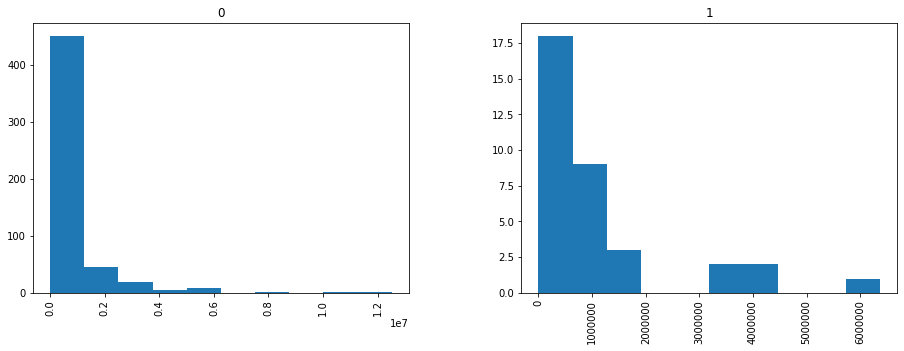

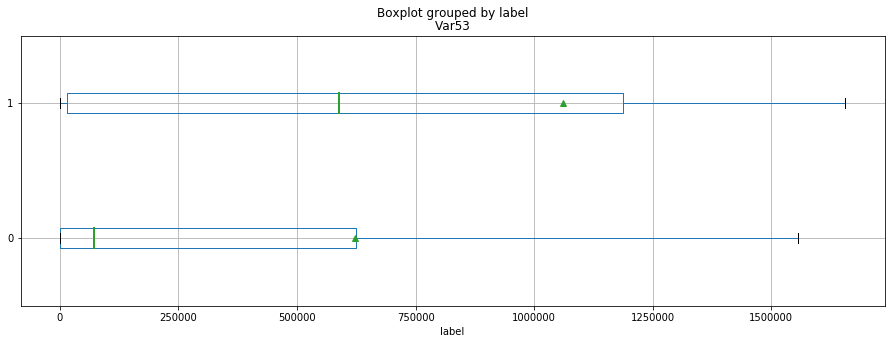

Correlation with label =  0.3650857671656934
Name of feature: Var19
Count notna elements 0: 55, 1: 1220
median:  label
0    0.0
1    0.0
Name: Var19, dtype: float64
mean:  label
0    0.221311
1    0.818182
Name: Var19, dtype: float64
std:  label
0    1.530721
1    3.133398
Name: Var19, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-0.08736773  1.54918033]


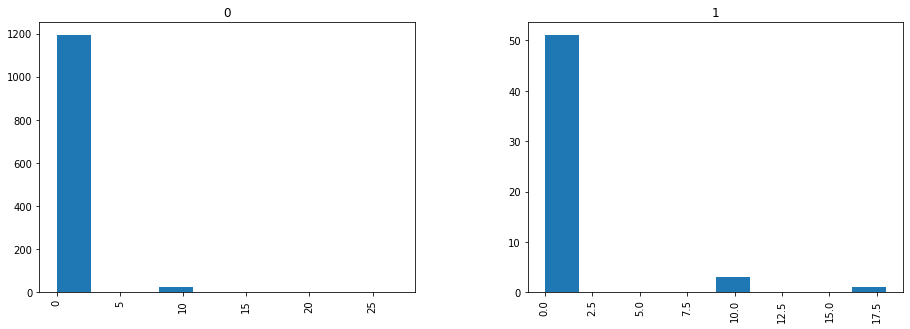

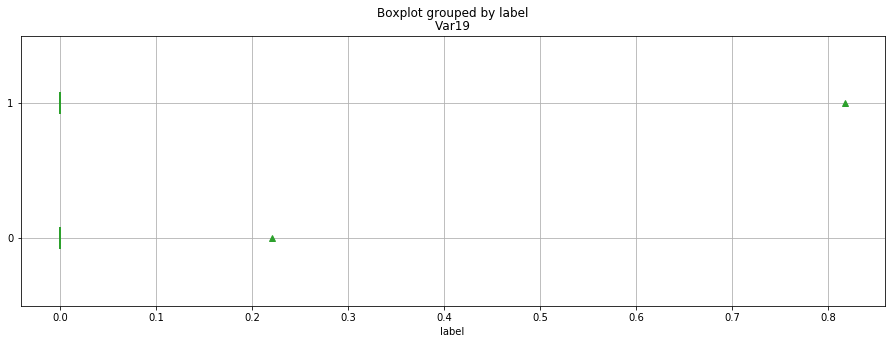

Correlation with label =  0.3668975271305365
Name of feature: Var111
Count notna elements 0: 41, 1: 849
median:  label
0     92225.41
1    164421.60
Name: Var111, dtype: float64
mean:  label
0    287174.988706
1    480340.134829
Name: Var111, dtype: float64
std:  label
0    511797.219475
1    755563.626368
Name: Var111, dtype: float64
interval of delta medians:  [-59759.16525 308161.9895 ]
interval of delta means:  [-13384.28923565 446065.03315085]


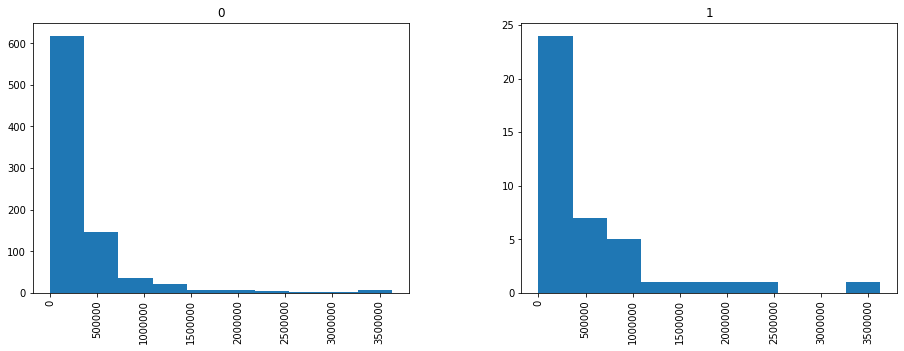

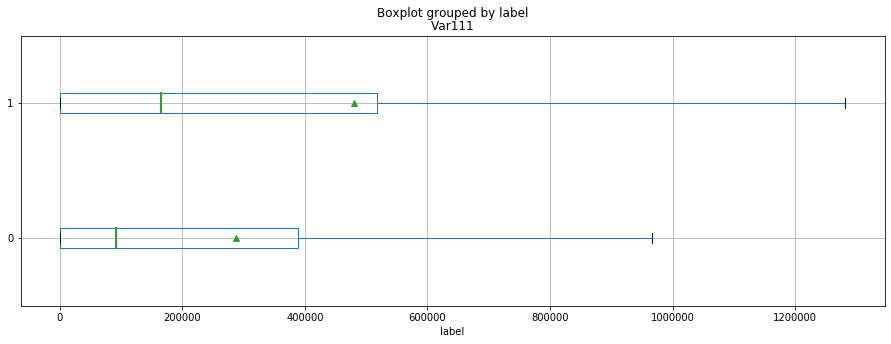

Correlation with label =  0.40037439759578203
Name of feature: Var131
Count notna elements 0: 35, 1: 535
median:  label
0    0.0
1    0.0
Name: Var131, dtype: float64
mean:  label
0    3.524199e+06
1    1.387028e+07
Name: Var131, dtype: float64
std:  label
0    1.865703e+07
1    7.486468e+07
Name: Var131, dtype: float64
interval of delta medians:  [0. 0.]
interval of delta means:  [-4162005.81548732 37162777.42296394]


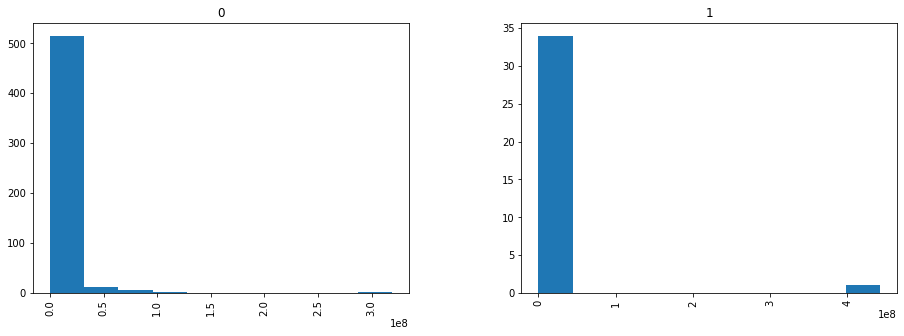

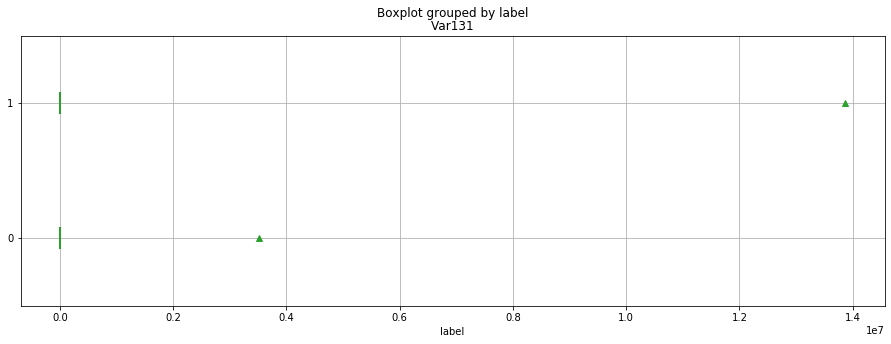

Correlation with label =  -0.463537662927574
Name of feature: Var189
Count notna elements 0: 1268, 1: 15517
median:  label
0    270.0
1    222.0
Name: Var189, dtype: float64
mean:  label
0    273.622350
1    233.422713
Name: Var189, dtype: float64
std:  label
0    86.268914
1    83.635968
Name: Var189, dtype: float64
interval of delta medians:  [-60. -42.]
interval of delta means:  [-44.86014757 -35.31597263]


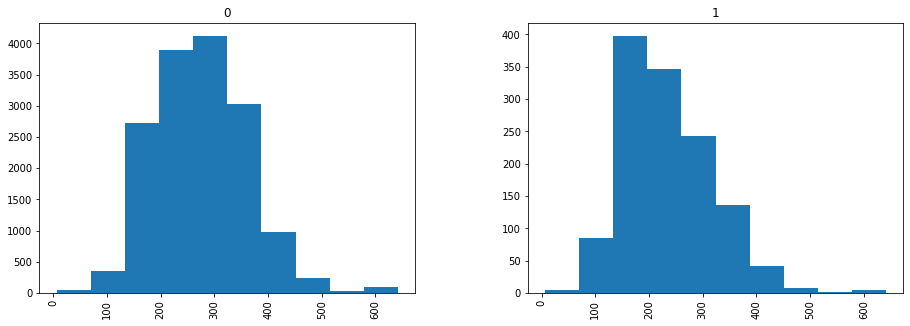

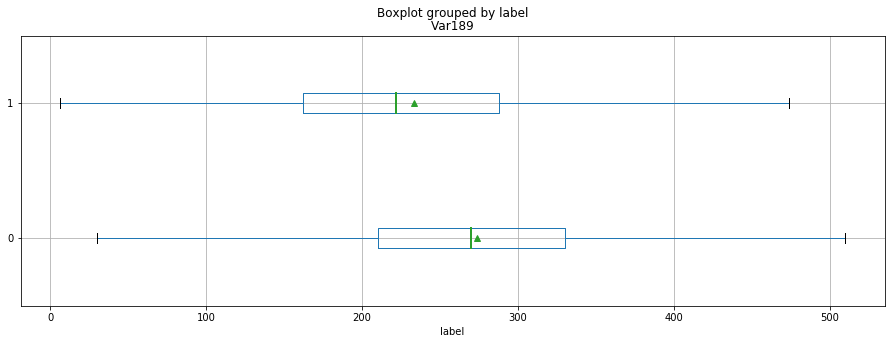

Correlation with label =  0.48143466540649976
Name of feature: Var188
Count notna elements 0: 41, 1: 965
median:  label
0    193.98
1    241.14
Name: Var188, dtype: float64
mean:  label
0    162.883275
1    217.478049
Name: Var188, dtype: float64
std:  label
0    112.379585
1    125.713221
Name: Var188, dtype: float64
interval of delta medians:  [15.3555 76.2   ]
interval of delta means:  [15.79365038 94.36295263]


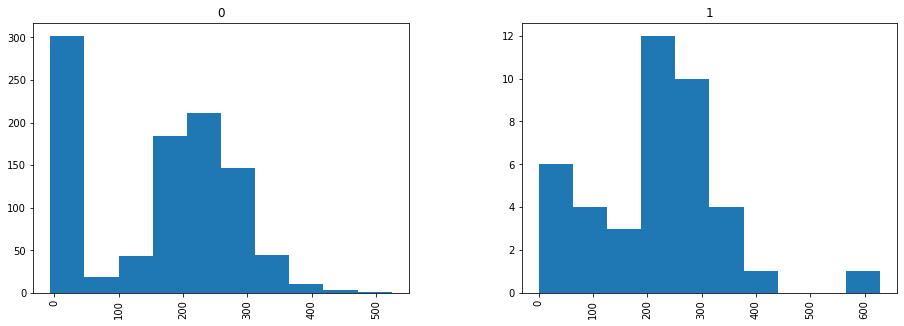

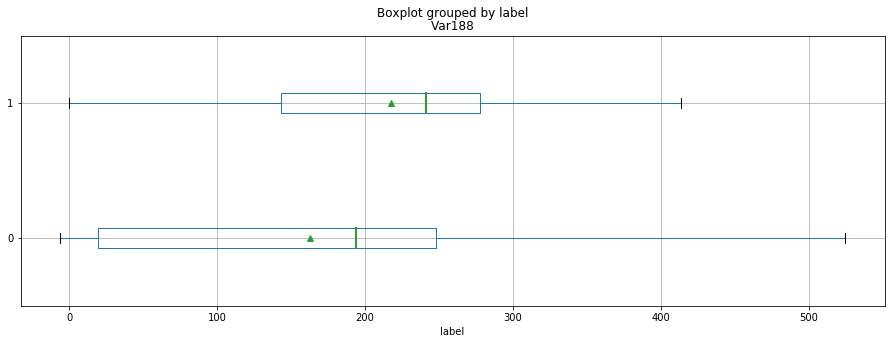

Correlation with label =  -0.5631134355782773
Name of feature: Var168
Count notna elements 0: 35, 1: 535
median:  label
0    329.84
1    279.36
Name: Var168, dtype: float64
mean:  label
0    334.840224
1    276.788571
Name: Var168, dtype: float64
std:  label
0     99.720647
1    135.713904
Name: Var168, dtype: float64
interval of delta medians:  [-82.004  28.562]
interval of delta means:  [-102.82534206  -14.59500454]


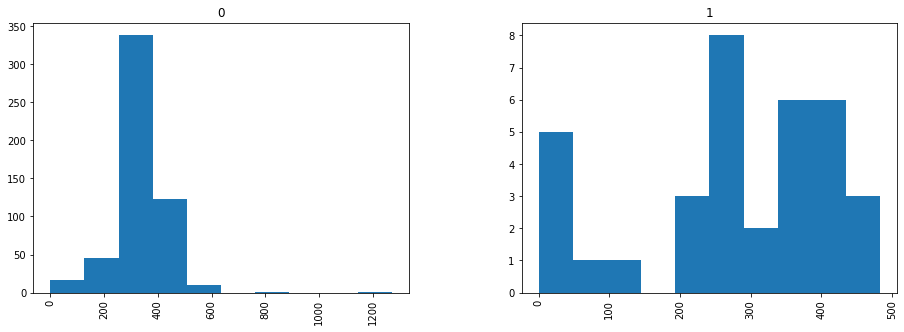

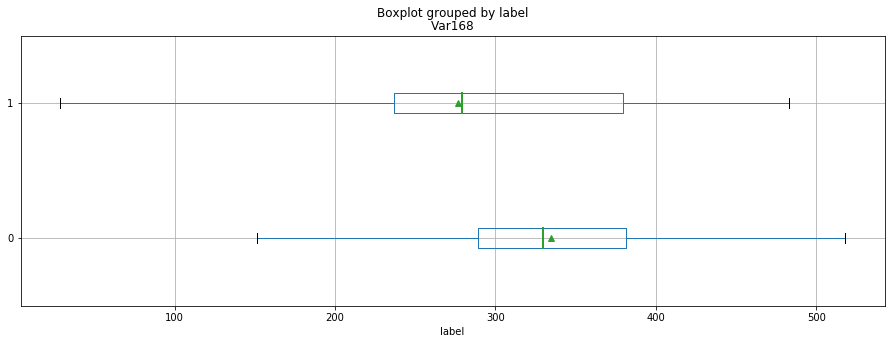

In [15]:
for corr in sorted(corr_with_churn.keys(),key=abs):
    print('Correlation with label = ', corr)
    get_stat_num_features(churn_data,corr_with_churn[corr],'label')

Из числовых признаков, как я думаю, следующие признаки дадут довольно малый вклад в модель: Var123,Var44,Var133,Var146,Var180,Var83,Var163,Var57,Var78,Var109,Var134,Var37,Var116,Var138,Var35,Var76,Var132,Var2,Var25,
Var173,Var143,Var24,Var149,Var160,Var106,Var94,Var28,Var60,Var47,Var18,Var90,Var67,Var151,Var69,Var10,Var51,Var27,Var150,
Var122,Var161,Var130,Var139,Var73,Var131.

Наибольший вклад, по моему мнению даст признак Var189.

Далее займусь уже категориальными признаками.

In [16]:
churn_data.iloc[:,166:].head()

Var192            Var193 Var194 Var195 Var196 Var197   Var198  \
0  NESt0G8EIb           AERks4l    NaN   taul   1K8T   0LaQ  UaKK0yW   
1  P1WvyxLp3Z           2Knk1KF    NaN   taul   1K8T   YFAj  Bnunsla   
2  FoxgUHSK8h  LrdZy8QqgUfkVShG    NaN   taul   1K8T   TyGl  fhk21Ss   
3  vNEvyxLp3Z              RO12    NaN   taul   1K8T   0Xwj  uoZk2Zj   
4  4e7gUH7IEC              RO12    NaN   taul   1K8T   vSNn  kugYdIL   

       Var199   Var200 Var201  ...   Var220   Var221   Var222      Var223  \
0  I1sFbv_0IT      NaN    NaN  ...  hLKtJ9p  Al6ZaUT  vr93T2a  LM8l689qOp   
1     o64y9zI  DlISMzi    NaN  ...  hN8KpA1     oslk  6hQ9lNX  LM8l689qOp   
2  nQUveAzAF7      NaN    NaN  ...  4UxGlow     zCkv  catzS2D  LM8l689qOp   
3  LWyxgtXeJL      NaN    NaN  ...  ylCK5YS     oslk  e4lqvY0  LM8l689qOp   
4  ZIXKpoNpqq      NaN    NaN  ...  PYpzAu9     oslk  MAz3HNj  LM8l689qOp   

  Var225 Var226   Var227         Var228 Var229 label  
0    NaN   fKCe  02N6s8f  xwM2aC7IdeMC0    NaN     0  
1   ELof   xb3V     RAYp        55YFVY9   mj86     0  
2    NaN   FSa2     ZI9m  ib5G6X1eUxUn6   mj86     0  
3    NaN   xb3V     RAYp  F2FyR07IdsN7I    NaN     1  
4    NaN   WqMG     RAYp  F2FyR07IdsN7I    NaN     0  

[5 rows x 35 columns]

In [17]:
cat_data = churn_data.iloc[:,166:].fillna('na')

In [18]:
cat_data.head()

Var192            Var193 Var194 Var195 Var196 Var197   Var198  \
0  NESt0G8EIb           AERks4l     na   taul   1K8T   0LaQ  UaKK0yW   
1  P1WvyxLp3Z           2Knk1KF     na   taul   1K8T   YFAj  Bnunsla   
2  FoxgUHSK8h  LrdZy8QqgUfkVShG     na   taul   1K8T   TyGl  fhk21Ss   
3  vNEvyxLp3Z              RO12     na   taul   1K8T   0Xwj  uoZk2Zj   
4  4e7gUH7IEC              RO12     na   taul   1K8T   vSNn  kugYdIL   

       Var199   Var200 Var201  ...   Var220   Var221   Var222      Var223  \
0  I1sFbv_0IT       na     na  ...  hLKtJ9p  Al6ZaUT  vr93T2a  LM8l689qOp   
1     o64y9zI  DlISMzi     na  ...  hN8KpA1     oslk  6hQ9lNX  LM8l689qOp   
2  nQUveAzAF7       na     na  ...  4UxGlow     zCkv  catzS2D  LM8l689qOp   
3  LWyxgtXeJL       na     na  ...  ylCK5YS     oslk  e4lqvY0  LM8l689qOp   
4  ZIXKpoNpqq       na     na  ...  PYpzAu9     oslk  MAz3HNj  LM8l689qOp   

  Var225 Var226   Var227         Var228 Var229 label  
0     na   fKCe  02N6s8f  xwM2aC7IdeMC0     na     0  
1   ELof   xb3V     RAYp        55YFVY9   mj86     0  
2     na   FSa2     ZI9m  ib5G6X1eUxUn6   mj86     0  
3     na   xb3V     RAYp  F2FyR07IdsN7I     na     1  
4     na   WqMG     RAYp  F2FyR07IdsN7I     na     0  

[5 rows x 35 columns]

In [19]:
corr_cat = []
for i in tqdm(range(len(cat_data.columns[:-1]))):
    for j in range(len(cat_data.columns[:-1])):
        if j <= i:
            continue
        validity = True
        col_i = cat_data.columns[i]
        col_j = cat_data.columns[j]
        crosstab = pd.crosstab(index=cat_data[col_i], columns=cat_data[col_j],dropna=True)
        if len(crosstab) == 0:
            continue
        chi2_stat, p_val, dof, expect_freq = scs.chi2_contingency(crosstab)
        if expect_freq[expect_freq<5].size/expect_freq.size > 0.2:
            validity = False
        n = crosstab.values.sum()
        k1 = crosstab.shape[0]
        k2 = crosstab.shape[1]    
        corr = np.sqrt(chi2_stat/(n*np.minimum(k1,k2) - 1))
        corr_cat.append([col_i, col_j, corr,validity])

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [15:15<00:00, 26.93s/it]


In [20]:
corr_cat_t = pd.DataFrame(corr_cat,columns=['col_1','col_2','corr','validity'])
corr_cat_t[corr_cat_t['corr'] > 0.999]

col_1   col_2      corr  validity
201  Var198  Var220  0.999871     False
203  Var198  Var222  0.999871     False
247  Var200  Var214  0.999962     False
526  Var220  Var222  0.999871     False

Var200 и Var214 л.з., Var198 и Var220 и Var222 л.з. Удалю зависимые столбцы.

In [21]:
cat_data.drop(corr_cat_t[corr_cat_t['corr'] > 0.999]['col_2'].unique(),axis='columns',inplace=True)

In [22]:
cat_data.drop(cat_data.columns[cat_data.nunique() == 1], axis='columns', inplace=True)

Посмотрю на корреляции с целевой меткой.

In [23]:
corr_cat = []
for col in cat_data.columns[:-1]:
    validity = True
    crosstab = pd.crosstab(index=cat_data.label,columns=cat_data[col],dropna=True)
    chi2_stat, p_val, dof, expect_freq = scs.chi2_contingency(crosstab)
    if expect_freq[expect_freq<5].size/expect_freq.size > 0.2:
        # bad_cols.append(col)
        # continue
        validity = False
    n = crosstab.values.sum()
    k1 = crosstab.shape[0]
    k2 = crosstab.shape[1]
    corr = np.sqrt(chi2_stat/(n*np.minimum(k1,k2) - 1))
    corr_cat.append([col, corr, validity])

In [24]:
corr_cat_label = pd.DataFrame(corr_cat,columns=['col','corr','validity'])
corr_cat_label.sort_values(by='corr',ascending=False)

col      corr  validity
21  Var217  0.374672     False
8   Var200  0.371934     False
7   Var199  0.288382     False
10  Var202  0.256987     False
6   Var198  0.206896     False
20  Var216  0.161886     False
0   Var192  0.106949     False
22  Var218  0.071953      True
19  Var212  0.061533     False
14  Var206  0.060143      True
5   Var197  0.058068     False
29  Var228  0.053440     False
13  Var205  0.051306      True
1   Var193  0.049644     False
12  Var204  0.048807      True
30  Var229  0.044184      True
15  Var207  0.041207     False
26  Var225  0.039962      True
28  Var227  0.039329      True
24  Var221  0.034732      True
17  Var210  0.034323      True
27  Var226  0.034306      True
18  Var211  0.022580      True
3   Var195  0.022395     False
23  Var219  0.018225     False
2   Var194  0.013681      True
9   Var201  0.012823      True
11  Var203  0.010055     False
4   Var196  0.008652     False
16  Var208  0.008402      True
25  Var223  0.008283      True

Посмотрю на распределения категориальных признаков.

Значение корреляции признака Var217: 0.37
корреляция необоснована
Name of feature: Var217
Count notna elements 0: 2821, 1: 36619


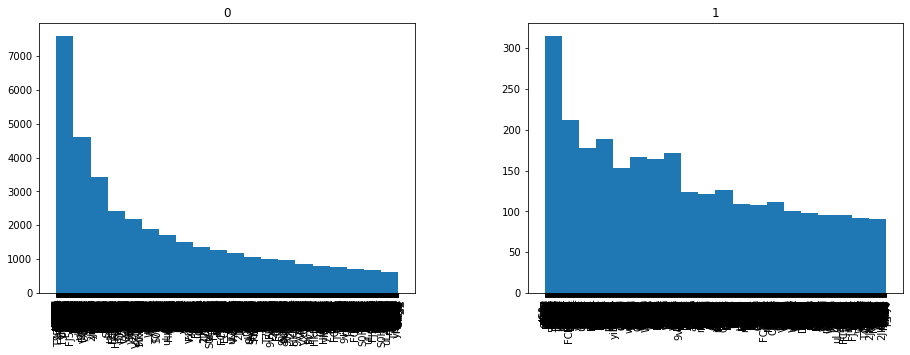

Значение корреляции признака Var200: 0.37
корреляция необоснована
Name of feature: Var200
Count notna elements 0: 1182, 1: 18452


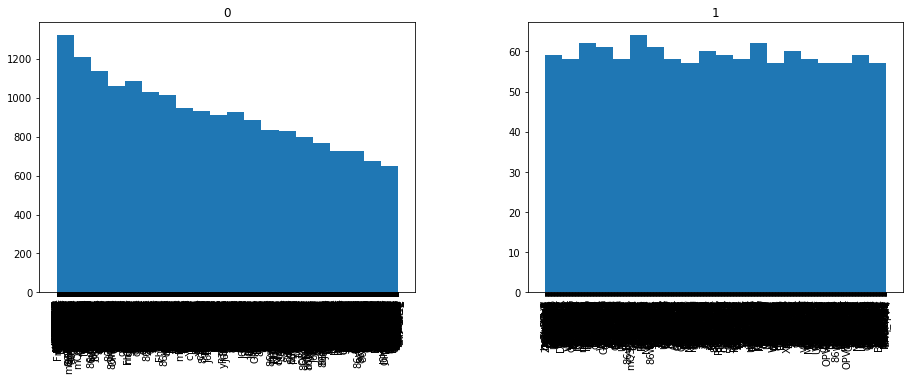

Значение корреляции признака Var199: 0.29
корреляция необоснована
Name of feature: Var199
Count notna elements 0: 2975, 1: 37021


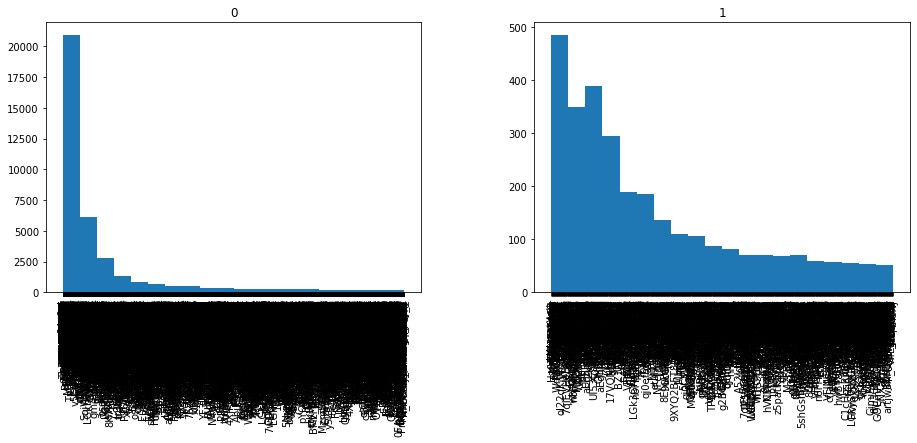

Значение корреляции признака Var202: 0.26
корреляция необоснована
Name of feature: Var202
Count notna elements 0: 2976, 1: 37023


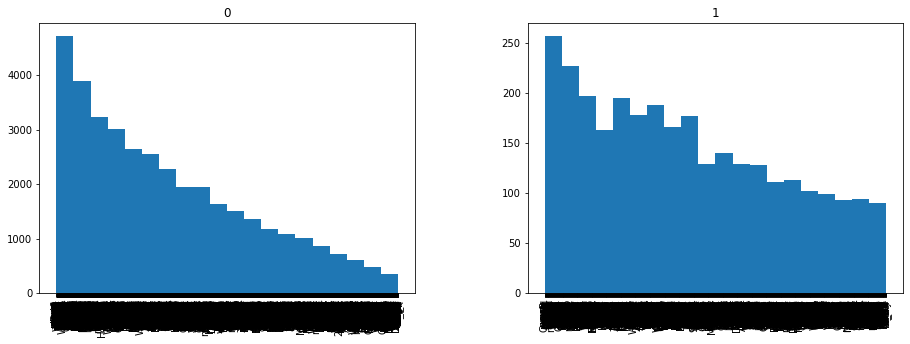

Значение корреляции признака Var198: 0.21
корреляция необоснована
Name of feature: Var198
Count notna elements 0: 2976, 1: 37024


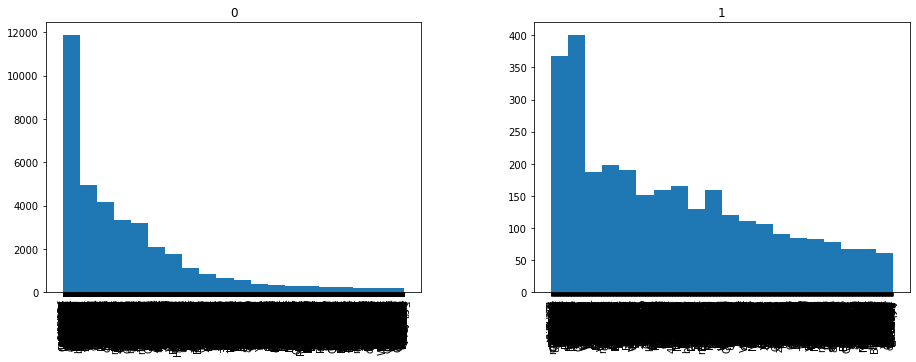

Значение корреляции признака Var216: 0.16
корреляция необоснована
Name of feature: Var216
Count notna elements 0: 2976, 1: 37024


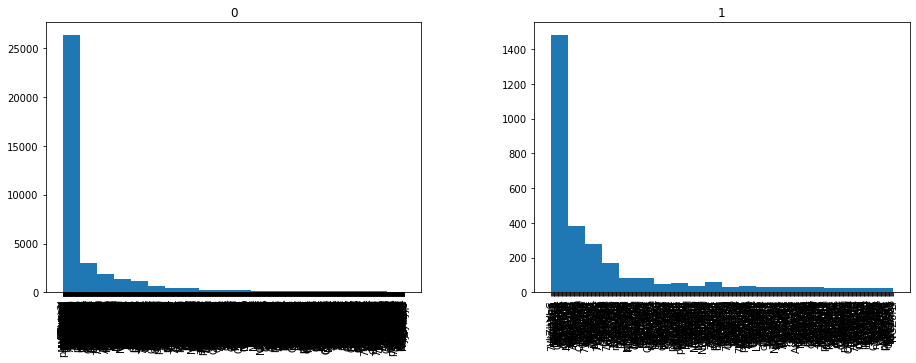

Значение корреляции признака Var192: 0.11
корреляция необоснована
Name of feature: Var192
Count notna elements 0: 2929, 1: 36780


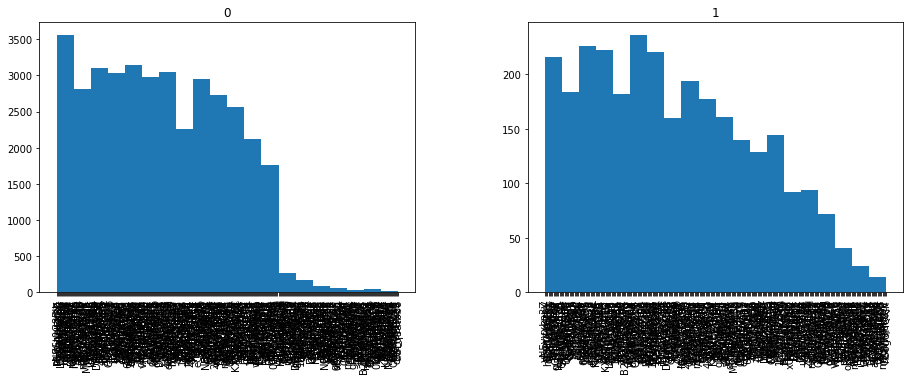

Значение корреляции признака Var218: 0.07
корреляция обоснована
Name of feature: Var218
Count notna elements 0: 2821, 1: 36619


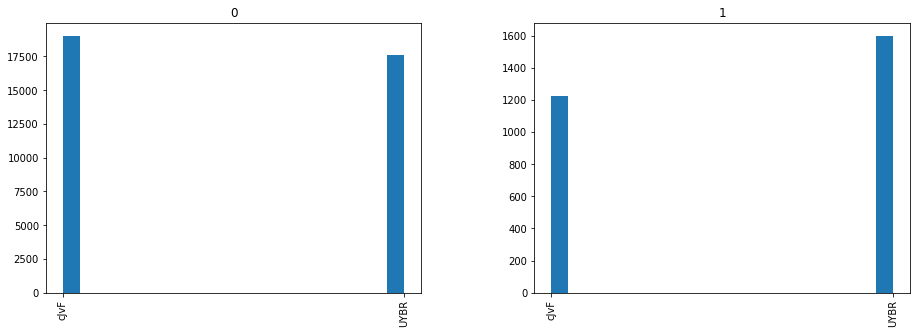

Значение корреляции признака Var212: 0.06
корреляция необоснована
Name of feature: Var212
Count notna elements 0: 2976, 1: 37024


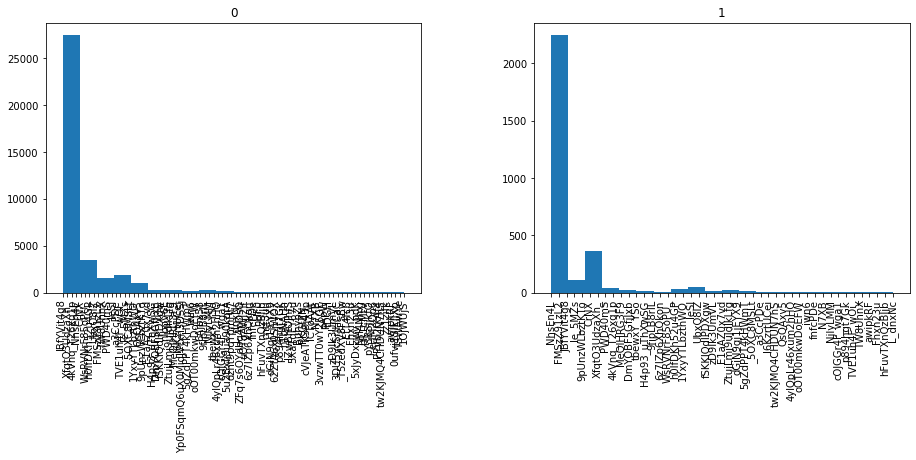

Значение корреляции признака Var206: 0.06
корреляция обоснована
Name of feature: Var206
Count notna elements 0: 2759, 1: 32806


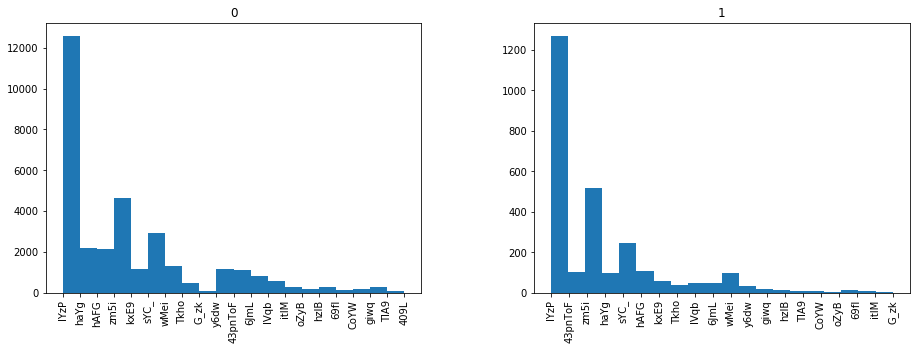

Значение корреляции признака Var197: 0.06
корреляция необоснована
Name of feature: Var197
Count notna elements 0: 2971, 1: 36906


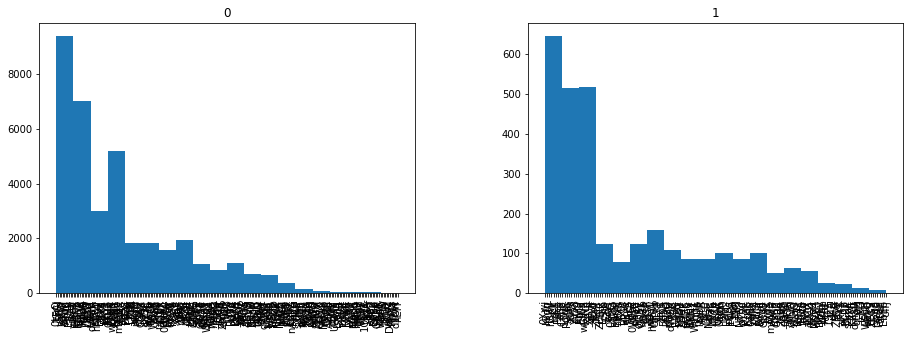

Значение корреляции признака Var228: 0.05
корреляция необоснована
Name of feature: Var228
Count notna elements 0: 2976, 1: 37024


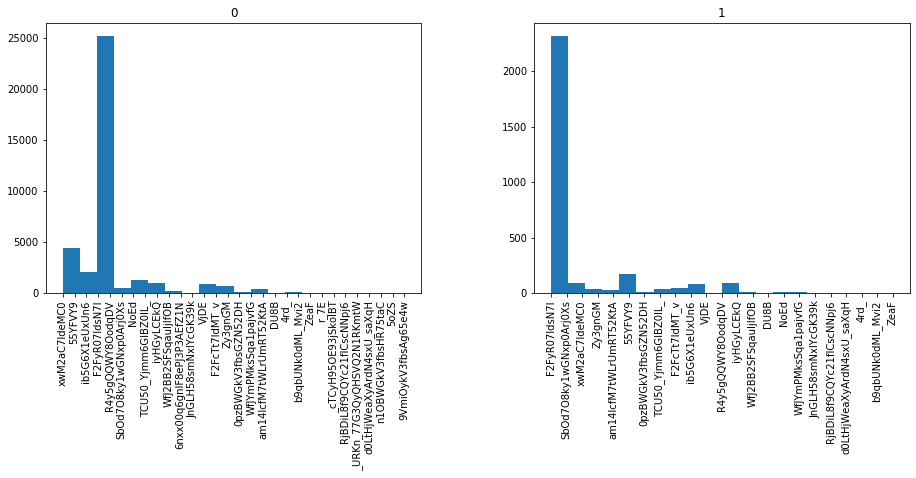

Значение корреляции признака Var205: 0.05
корреляция обоснована
Name of feature: Var205
Count notna elements 0: 2847, 1: 35606


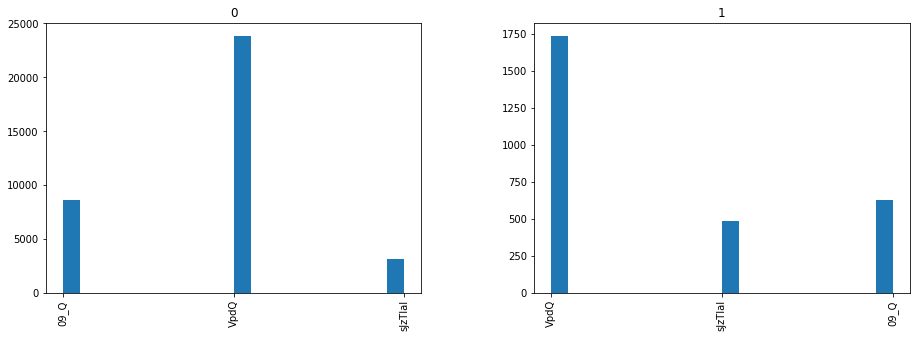

Значение корреляции признака Var193: 0.05
корреляция необоснована
Name of feature: Var193
Count notna elements 0: 2976, 1: 37024


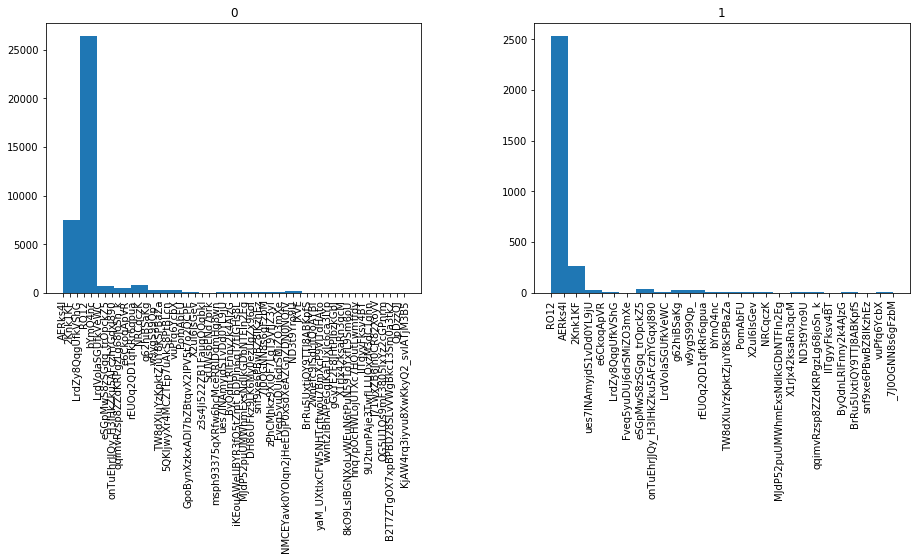

Значение корреляции признака Var204: 0.05
корреляция обоснована
Name of feature: Var204
Count notna elements 0: 2976, 1: 37024


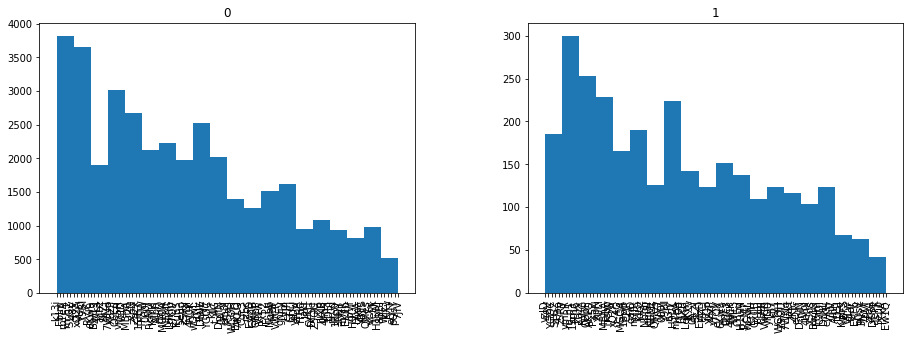

Значение корреляции признака Var229: 0.04
корреляция обоснована
Name of feature: Var229
Count notna elements 0: 957, 1: 16266


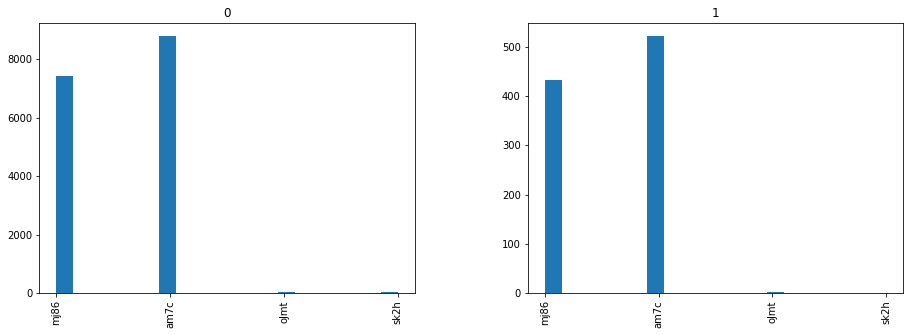

Значение корреляции признака Var207: 0.04
корреляция необоснована
Name of feature: Var207
Count notna elements 0: 2976, 1: 37024


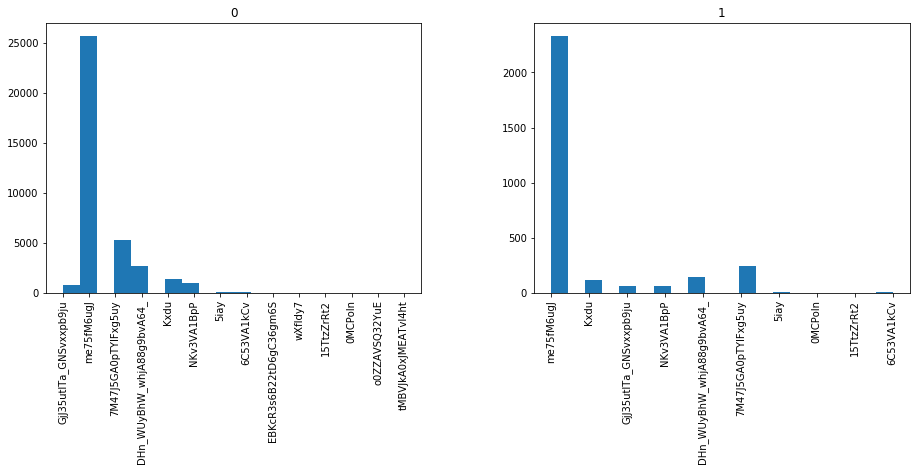

Значение корреляции признака Var225: 0.04
корреляция обоснована
Name of feature: Var225
Count notna elements 0: 1142, 1: 17923


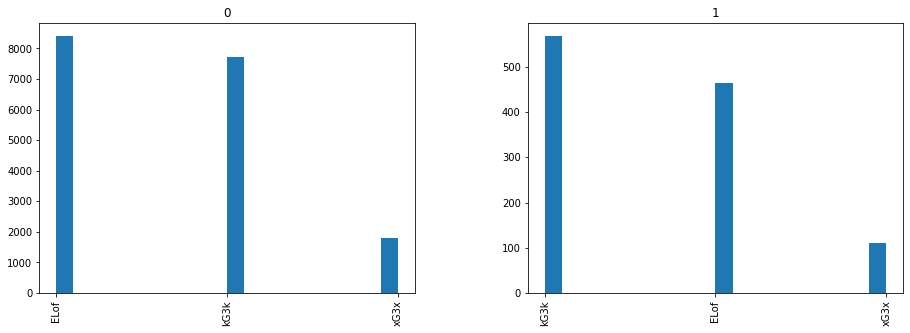

Значение корреляции признака Var227: 0.04
корреляция обоснована
Name of feature: Var227
Count notna elements 0: 2976, 1: 37024


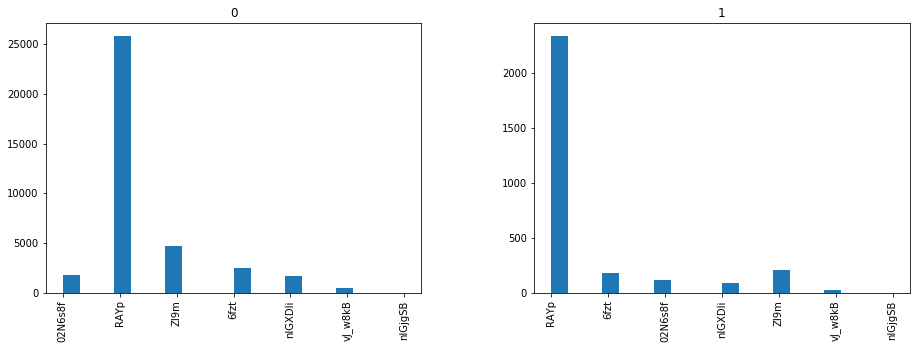

Значение корреляции признака Var221: 0.03
корреляция обоснована
Name of feature: Var221
Count notna elements 0: 2976, 1: 37024


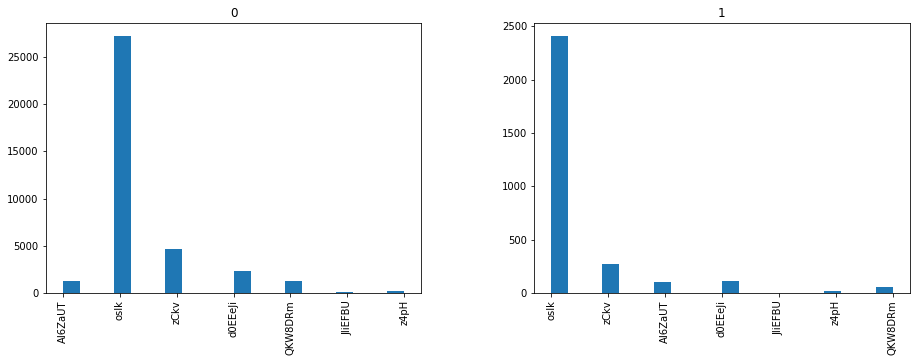

Значение корреляции признака Var210: 0.03
корреляция обоснована
Name of feature: Var210
Count notna elements 0: 2976, 1: 37024


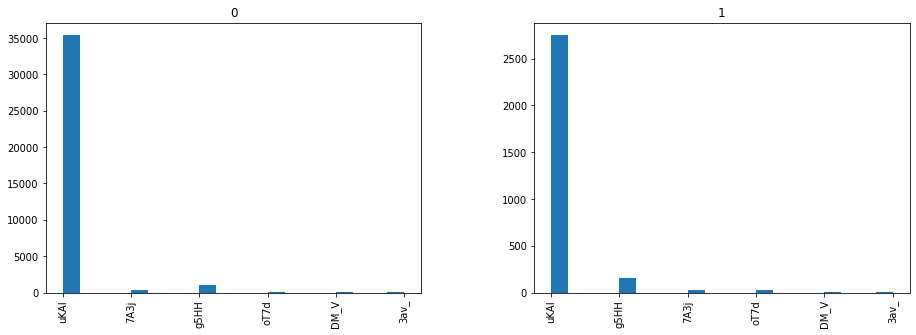

Значение корреляции признака Var226: 0.03
корреляция обоснована
Name of feature: Var226
Count notna elements 0: 2976, 1: 37024


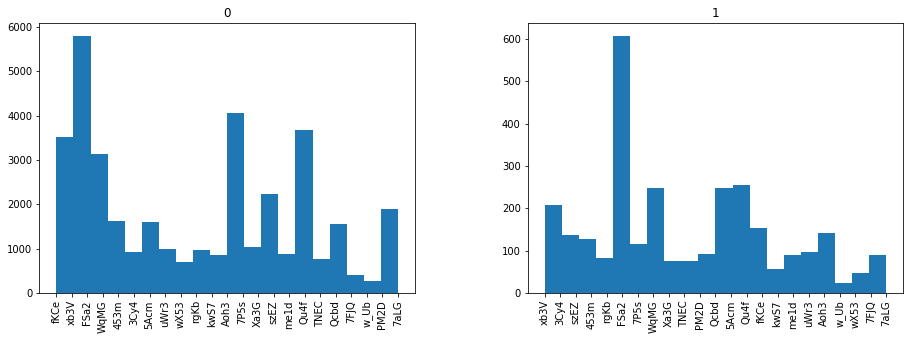

Значение корреляции признака Var211: 0.02
корреляция обоснована
Name of feature: Var211
Count notna elements 0: 2976, 1: 37024


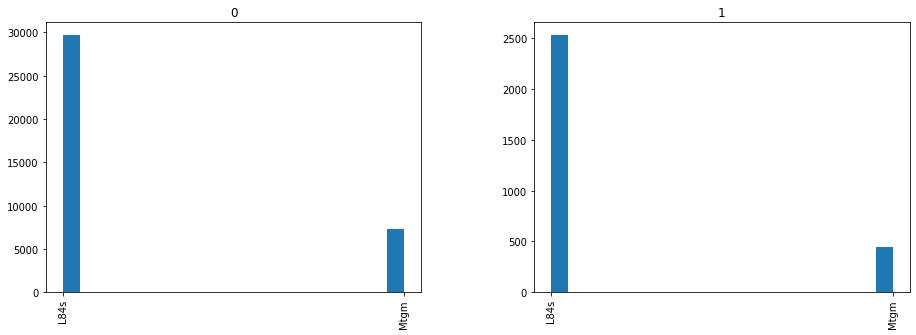

Значение корреляции признака Var195: 0.02
корреляция необоснована
Name of feature: Var195
Count notna elements 0: 2976, 1: 37024


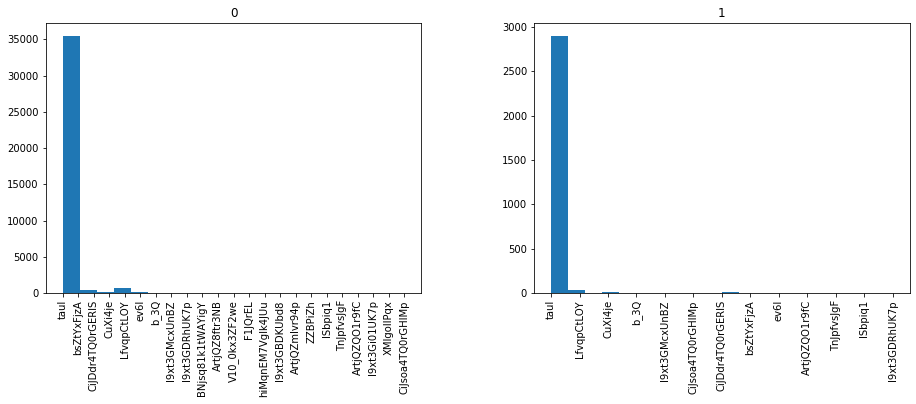

Значение корреляции признака Var219: 0.02
корреляция необоснована
Name of feature: Var219
Count notna elements 0: 2646, 1: 33158


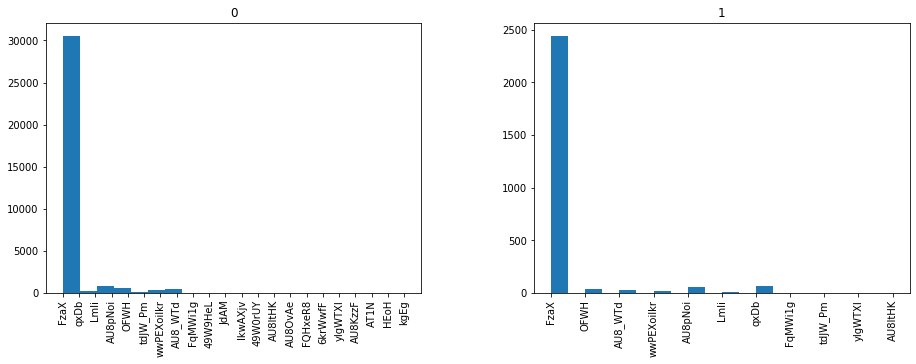

Значение корреляции признака Var194: 0.01
корреляция обоснована
Name of feature: Var194
Count notna elements 0: 678, 1: 9512


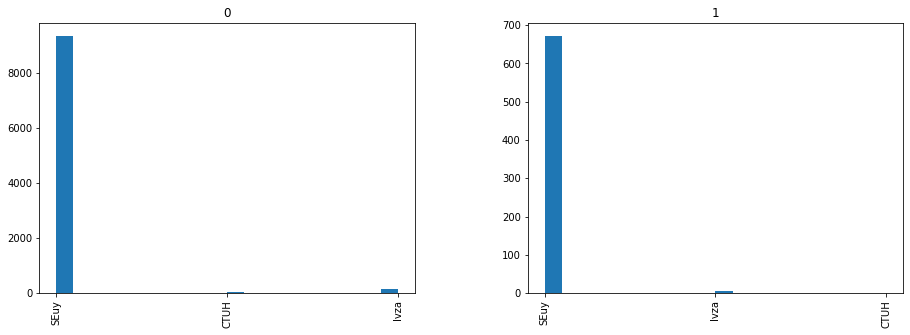

Значение корреляции признака Var201: 0.01
корреляция обоснована
Name of feature: Var201
Count notna elements 0: 678, 1: 9512


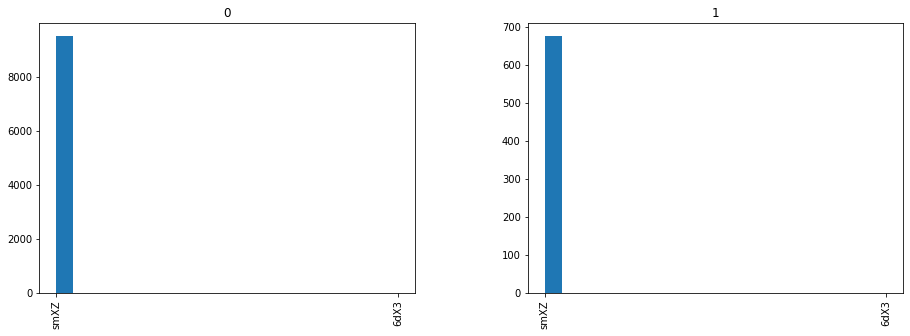

Значение корреляции признака Var203: 0.01
корреляция необоснована
Name of feature: Var203
Count notna elements 0: 2971, 1: 36906


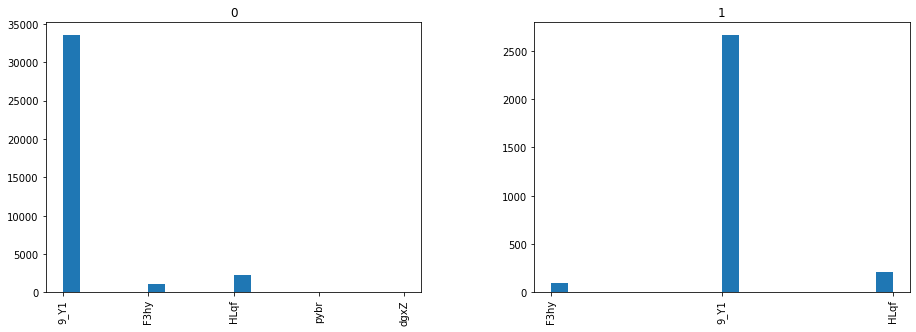

Значение корреляции признака Var196: 0.01
корреляция необоснована
Name of feature: Var196
Count notna elements 0: 2976, 1: 37024


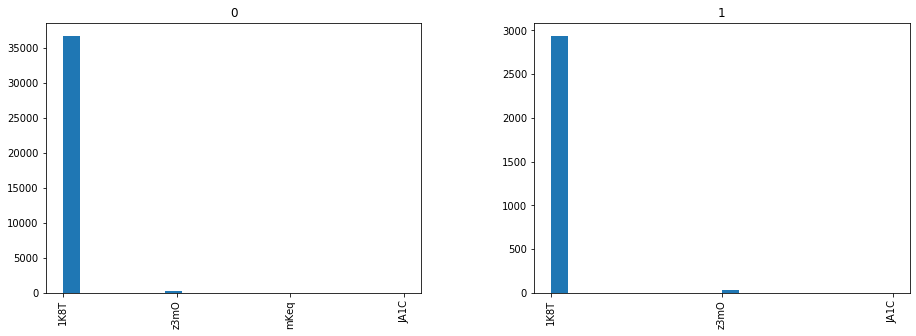

Значение корреляции признака Var208: 0.01
корреляция обоснована
Name of feature: Var208
Count notna elements 0: 2971, 1: 36906


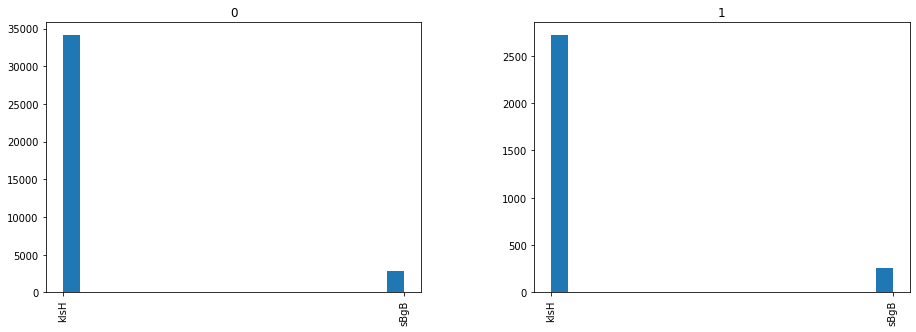

Значение корреляции признака Var223: 0.01
корреляция обоснована
Name of feature: Var223
Count notna elements 0: 2646, 1: 33158


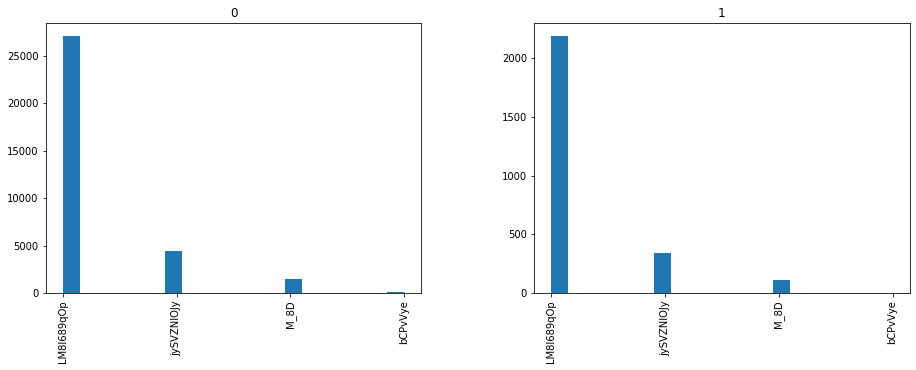

In [25]:
for col, corr, val in corr_cat_label.sort_values(by='corr',ascending=False)[['col','corr', 'validity']].values:
    print('Значение корреляции признака %s: %0.2f'%(col,corr))
    if val:
        print("корреляция обоснована")
    else:
        print("корреляция необоснована")
        
    get_stat_cat_features(churn_data, col, 'label')

Как мне кажется, следующие признаки окажут слабое влияние на модель:
Var207,Var227,Var221,Var210,Var211,Va195,Va194,Var223,Var208,Var229,Var201

А сильное влияние на модель я ожидаю от следующих признаков:
Var200, Var217, Var199, Var202, Var178.